In [1]:
import numpy as np
import emcee
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Edits (major):

# changed params file to boxsize 120 arcmin, dx = 4 for 2 degree patch, otherwise noise cov and pinv are taking 
# up too much space
# covariance matrix definition changed to the one below

In [3]:
import numpy as np, sys, os, scipy as sc, healpy as H, warnings, pickle, gzip
sys_folder = '../modules/'
sys.path.append(sys_folder)

import flatsky, tools, misc, moving_lens, inpaint, foregrounds as fg

import scipy.ndimage as ndimage
import matplotlib.cbook
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

from colossus.cosmology import cosmology
from colossus.halo import concentration, mass_defs
cosmology.setCosmology('planck15')
from astropy.cosmology import FlatLambdaCDM

%load_ext autoreload
%autoreload 2

#%pylab notebook
%matplotlib inline
from pylab import *
rcParams["figure.facecolor"] = 'white'
cmap = cm.RdYlBu_r

In [4]:
#others
perform_inpainting = False #True
use_pol_for_inpainting = False
mask = None
perform_oned_fitting = 1   

In [5]:
# read params file, if we need it

# params or supply a params file
paramfile = 'params_bullter_cluster.ini'

param_dict = misc.fn_get_param_dict(paramfile)

if not perform_oned_fitting:
    param_dict['boxsize'], param_dict['dx'] = 120., 2.

boxsize, dx = param_dict['boxsize'], param_dict['dx']
boxsize_am = boxsize
dls_file = param_dict['dls_file']
lmax, nside =  param_dict['lmax'],  param_dict['nside']
mask_file = param_dict['mask_file']

In [6]:
#get ra, dec or map-pixel grid
nx = int(boxsize_am/dx)
mapparams = [nx, nx, dx, dx]
x1,x2 = -nx/2. * dx, nx/2. * dx

ra_for_grid = np.linspace(x1,x2, nx)/60.
dec_for_grid = np.linspace(x1,x2, nx)/60.
ra_grid, dec_grid = np.meshgrid(ra_for_grid,dec_for_grid)

In [7]:
#read Cls now
if (0):#not use_pol_for_inpainting:
    el, dl = np.loadtxt(dls_file, usecols = [0,1], unpack = 1)
else:
    el, dl_tt, dl_ee, dl_bb, dl_te  = np.loadtxt(dls_file, unpack = 1)
    dl_all = np.asarray([dl_tt, dl_ee, dl_bb, dl_te])

dl_fac = el * (el + 1) / 2 / np.pi
cl_all = dl_all / dl_fac * 1e12
cl_tt, cl_ee, cl_bb, cl_te = cl_all
print(len(el), cl_tt.shape)

27658 (27658,)


In [8]:
# Set up beam

beamval = 1.2 #arcmins
bl2d = tools.get_bl(beamval, el, make_2d = 1, mapparams = mapparams)

In [9]:
# Set up noise

noiseval = 10.0 #uK-arcmin
npix = nx ** 2 
npix_cov = npix ** 2
noofsims_for_cov =  100000 #1500

nl = tools.get_nl(noiseval, el)
noofsims_for_cov

100000

In [10]:
# Set up sims for noise covariance matrix

noise_sims = list()

for i in tqdm(range(noofsims_for_cov)):
    noise_map = flatsky.make_gaussian_realisation(mapparams, el, nl)
    noise_sims.append(noise_map)
    
noise_sims = np.asarray(noise_sims).flatten().reshape(noofsims_for_cov, npix)

100%|██████████████████████████████████████████████████████████████████████████| 100000/100000 [02:53<00:00, 576.56it/s]


In [11]:
# ask -- the calcCov function in this version of tools uses sample covariance not population covariance??
# also using calcCov takes up too much memory space (26GB +) for such a numpy matrix. I used direct matmul instead.

# This takes up too much space for large number of sims.

noise_cov = np.matmul(noise_sims.T , noise_sims) / (noofsims_for_cov)
print(noise_cov.shape)
np.save("output/noise_cov_100k_20uK_120_dx1.npy", noise_cov)

(14400, 14400)


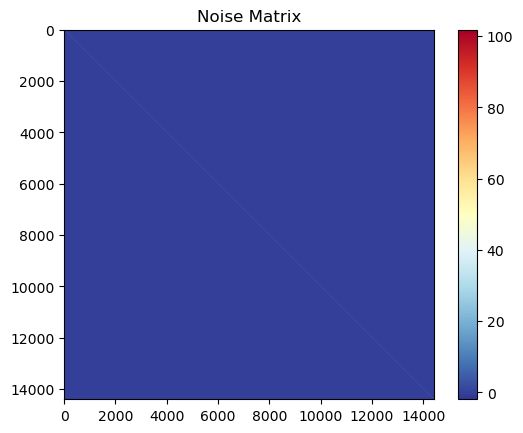

In [10]:
noise_cov = np.load("output/noise_cov_100k_10uK_120_dx1.npy", allow_pickle = True)
plt.imshow(noise_cov, cmap = cmap); colorbar(); title("Noise Matrix"); show()

---------------

In [13]:
# Invert noise covariance matrix and save it

noise_cov_inv = np.linalg.pinv(noise_cov)
np.save("output/noise_cov_inv_100k_20uK_120_dx1.npy", noise_cov_inv)

In [11]:
# Read in an inverted noise covariance matrix

noise_cov_inv = np.load("output/noise_cov_inv_100k_10uK_120_dx1.npy", allow_pickle = True)

------------------

# ML only #

In [12]:
# Simulate the Moving Lens signal

# There are 2 clusters in Bullet cluster
M200c_bullet_1, M200c_bullet_2 = 1.5e15, 1.5e14
redshift_1, redshift_2 = 0.296, 0.296
#redshift_1, redshift_2 = 2., 2.
v_phi_1, v_th_1 = 0., 4500.
phi_1, theta_1 = 0., 0.
v_phi_2, v_th_2 = 0., 4500. 
phi_2, theta_2 = 0., 0.

M200c = [M200c_bullet_1]#, M200c_bullet_2]
redshift = [redshift_1]#, redshift_2]
v_phi = [v_phi_1]#, v_phi_2]
v_th = [v_th_1]#, v_th_2]    
phi = [phi_1]#, phi_2]
theta = [theta_1]#, theta_2]

# Run 1 simulation for now
noofclus = len(M200c)

In [13]:
# get the moving lens dipole
ra_list = dec_list = np.zeros(len(M200c)) #cluster always at centre
mvl_arr, vel_dir_arr, vel_mag_arr = moving_lens.get_moving_lens_dipole(ra_grid, dec_grid, ra_list, dec_list, M200c, redshift, v_phi, v_th, param_dict, bl = bl2d)
print(mvl_arr.shape, vel_dir_arr.shape, vel_mag_arr.shape)
if (1): #repeat the same for all sims
    print(noofclus)
    mvl_arr = np.repeat(mvl_arr, noofclus, axis = 0)
    vel_dir_arr = np.repeat(vel_dir_arr, noofclus, axis = 0)
    vel_mag_arr = np.repeat(vel_mag_arr, noofclus, axis = 0)
    M200c = np.repeat(M200c, noofclus, axis = 0)
    redshift = np.repeat(redshift, noofclus, axis = 0)
    v_phi = np.repeat(v_phi, noofclus, axis = 0)
    v_th = np.repeat(v_th, noofclus, axis = 0)
    phi = np.repeat(phi, noofclus, axis = 0)
    theta = np.repeat(theta, noofclus, axis = 0)
print(mvl_arr.shape, vel_dir_arr.shape, vel_mag_arr.shape)

get moving lens dipole now
0.0 0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.000, z=0.30
		time taken for gettting deflection vector = 0.0003346840540568034
check me. 
		time taken for get dot product = 9.258588155110678e-06
(1, 30, 30) (1,) (1,)
1
(1, 30, 30) (1,) (1,)


/home/dchanda2002/MovingLensBC/transverse_velocity/scripts/../modules/moving_lens.py:623: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pvec_tmp = np.asarray( [phi, theta, 0.] )


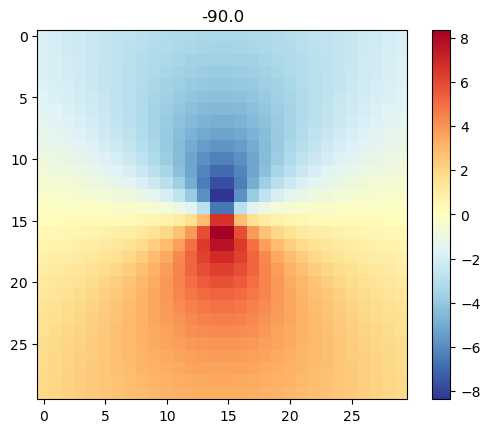

In [14]:
plt.imshow(mvl_arr[0], cmap = cmap); colorbar(); title(vel_dir_arr[0]); show()

-----------------

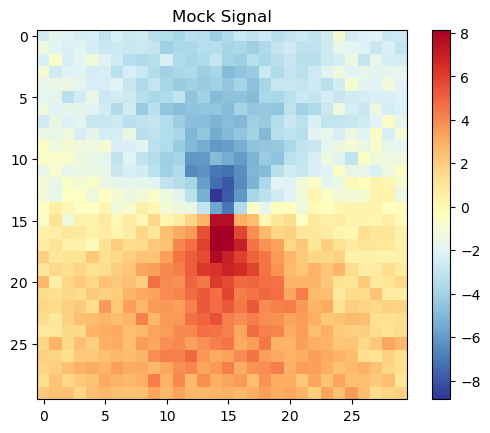

In [23]:
# Make a mock

ml_signal = mvl_arr[0]
noise_signal = flatsky.make_gaussian_realisation(mapparams, el, nl)
mock_signal = ml_signal + noise_signal
plt.imshow(mock_signal, cmap = cmap); colorbar(); title("Mock Signal"); show()

In [24]:
# Attempt a simple Emcee with amplitude of ML signal(even though there's just one param here :/ but at least it samples the
# distribution)

# To save shallow copy space, use global memory for now

cov = noise_cov
cov_inv = noise_cov_inv # np.linalg.pinv(cov)
data = mock_signal

def log_likelihood(amplitude):
    # cov_inv = np.ones_like(noise_cov)  # for testing

    d = data.flatten() ## - np.mean(MAP.flatten())
    m = abs(amplitude) * ml_signal.flatten() ## - np.mean(MODEL.flatten())
    diff = d - m
    
    return -0.5 * np.asarray( np.dot(diff.T, np.dot( cov_inv, diff ))).squeeze()

def log_prior(amplitude):
    if (abs(amplitude) < 5) & (abs(amplitude) > -5):
        return 0.0     # permit
    return -np.inf     # do not permit

def log_probability(amplitude):
    prior = log_prior(amplitude)
    if not np.isfinite(prior):
        return -np.inf
    return prior + log_likelihood(amplitude)


In [108]:
sample_amp = np.arange(-5,5,0.1)
likelihood = [log_likelihood(amp) for amp in tqdm(sample_amp)]

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 11434.23it/s]


In [109]:
like = likelihood - max(likelihood)
like = np.exp(like)
like/=max(like)
amp_mode=sample_amp[np.argmax(like)]

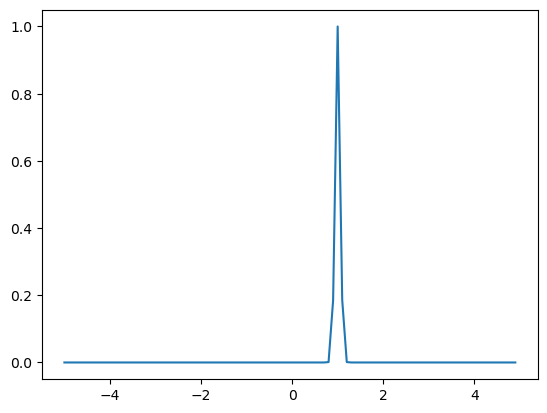

In [110]:
plt.plot(sample_amp, like)

In [25]:
# Then try using emcee

from multiprocessing import Pool

initial = np.random.rand(32, 1) + 0.5  # centered around an amplitude of 1
nwalkers, ndim = initial.shape

with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, pool = pool)
    burn_in = sampler.run_mcmc(initial, 100, progress = "notebook")
    sampler.reset()
    result = sampler.run_mcmc(burn_in, 1000, progress = 'notebook')
    samples = sampler.get_chain(flat = True)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

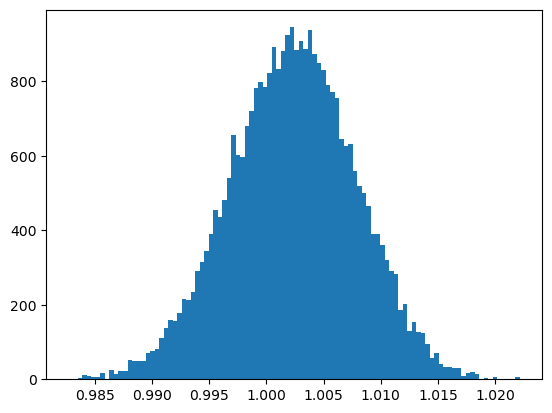

In [26]:
plt.hist(samples, bins = 100)
plt.show()

In [27]:
sixteen = np.percentile(samples, 16.)
eightyfour = np.percentile(samples, 84.)
mean = np.percentile(samples, 50.) # not really mean; change later
lowerr = mean - sixteen
higherr = eightyfour - mean

In [28]:
from IPython.display import display, Math
estimate, low, high = mean, lowerr, higherr
txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
txt = txt.format(estimate, low, high, "Amplitude")
display(Math(txt))

<IPython.core.display.Math object>

In [29]:
print("Stddev:", np.std(samples))

Stddev: 0.005488550777252931


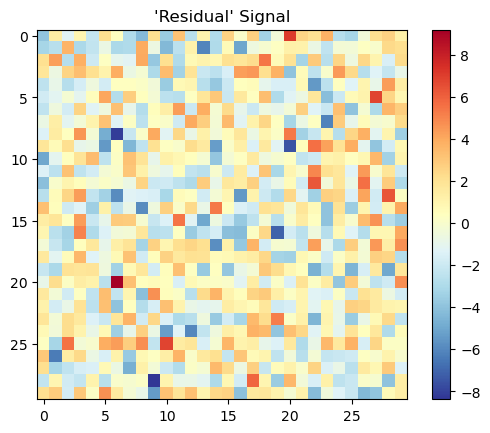

In [75]:
plt.imshow(mock_signal - amp_mode*ml_signal, cmap = cmap); colorbar(); title("\'Residual\' Signal"); show()

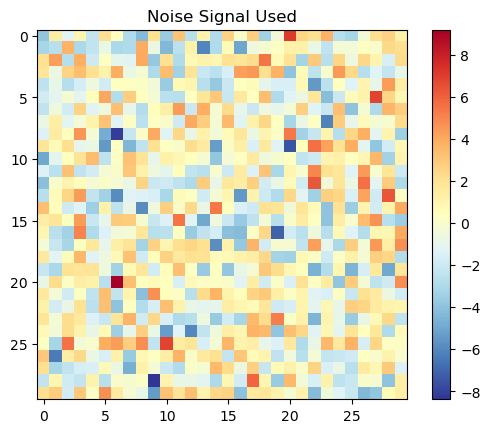

In [76]:
plt.imshow(noise_signal, cmap = cmap); colorbar(); title("Noise Signal Used"); show()

---------------

In [126]:
# Attempt a simple Emcee with mass and velocity characteristics (2 params)

# To save shallow copy space, use global memory for now
cov = noise_cov
cov_inv = np.linalg.pinv(cov)
data = mock_signal

def log_likelihood(theta):
    
    velocity, mass = theta
    d = data.flatten() ## - np.mean(MAP.flatten())
    
    v_phi = [v_phi_1]
    phi = [phi_1]
    theta = [theta_1]
    redshift = [redshift_1]
    
    M200c = [mass]
    v_th = [velocity]
    
    noofclus = len(M200c)
    ra_list = dec_list = np.zeros(len(M200c))
    
    mvl_arr, vel_dir_arr, vel_mag_arr = moving_lens.get_moving_lens_dipole(ra_grid, 
                                                    dec_grid, ra_list, dec_list, M200c, redshift, v_phi, v_th, 
                                                    param_dict, bl = bl2d)
    m = mvl_arr[0].flatten()
    diff = d - m
    
    return -0.5 * np.asarray( np.dot(diff.T, np.dot( cov_inv, diff ))).squeeze()

def log_prior(theta):
    velocity, mass = theta
    if (velocity < 4700) & (velocity > 4300) & (mass < 1.5e16) & (mass > 1.5e14):
        return 0.0     # permit
    return -np.inf     # do not permit

def log_probability(theta):
    prior = log_prior(theta)
    if not np.isfinite(prior):
        return -np.inf
    return prior + log_likelihood(theta)


In [127]:
v_init = (np.random.rand(32, 1) - 0.5) *500 + 4500
m_init = (np.random.rand(32, 1) - 0.5) *5e14 + 1.5e15
initial = np.hstack([v_init, m_init])

In [128]:
# Try using emcee

from multiprocessing import Pool

nwalkers, ndim = initial.shape

with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, pool = pool)
    burn_in = sampler.run_mcmc(initial, 100, progress = True)
    sampler.reset()
    result = sampler.run_mcmc(burn_in, 300, progress = True)
    samples = sampler.get_chain(flat = True)

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now

get moving lens dipole now






0.00.0
0.00.0 0.00.00.00.0    
0.00.00.00.0i=0: (ra,dec)=(0.000,0.000), mass=14.855, z=0.300.0
 

0.0  i=0: (ra,dec)=(0.000,0.000), mass=14.654, z=0.30
0.00.0
0.0

0.0 i=0: (ra,dec)=(0.000,0.000), mass=13.783, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=13.179, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.147, z=0.30
 

0.00.0
 		time taken for gettting deflection vector = 9.953975677490234e-05
i=0: (ra,dec)=(0.000,0.000), mass=12.672, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=16.006, z=0.300.0

		time taken for gettting deflection vector = 9.606679280598958e-05

		time taken for gettting deflection vector = 9.311437606811524e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.608, z=0.30i=0: (ra,dec)=(0.000,0.000

  0%|                                                                                           | 0/100 [00:00<?, ?it/s]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now


get moving lens dipole now
get moving lens dipole now
0.0
0.00.00.0
 
0.0get moving lens dipole now0.0get moving lens dipole now0.0 0.0 
 0.0
0.00.0
 

0.0 0.00.0 i=0: (ra,dec)=(0.000,0.000), mass=14.942, z=0.30

0.0
i=0: (ra,dec)=(0.000,0.000), mass=18.006, z=0.30 

0.00.0 i=0: (ra,dec)=(0.000,0.000), mass=15.807, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=16.009, z=0.300.0 0.0
0.0

		time taken for gettting deflection vector = 5.435943603515625e-05
i=0: (ra,dec)=(0.000,0.000), mass=14.080, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=16.468, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=13.831, z=0.30 



0.0i=0: (ra,dec)=(0.000,0.000), mass=13.831, z=0.30
		time taken for gettting deflection vector = 4.246632258097331e-05
0.0		time taken for gettting deflection vector = 5.497932434082031e-

/home/dchanda2002/anaconda3/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


check me. 		time taken for get dot product = 6.238619486490885e-07
		time taken for get dot product = 7.073084513346354e-07
get moving lens dipole now
check me. check me. 
0.0
		time taken for get dot product = 5.642573038736979e-07 0.0
check me. 

i=0: (ra,dec)=(0.000,0.000), mass=14.358, z=0.30
		time taken for get dot product = 5.563100179036459e-07
check me. 
		time taken for gettting deflection vector = 4.986921946207682e-05		time taken for get dot product = 7.62939453125e-07

check me. 

		time taken for get dot product = 4.967053731282552e-07		time taken for get dot product = 5.165735880533854e-07

check me. check me. 
check me. 
		time taken for get dot product = 9.854634602864584e-07

		time taken for get dot product = 5.086263020833333e-07		time taken for get dot product = 5.006790161132813e-07

check me. 
		time taken for get dot product = 5.125999450683594e-07
check me. 
		time taken for get dot product = 4.847844441731771e-07


  1%|▊                                                                                  | 1/100 [00:01<01:58,  1.20s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.00.00.0

 
 
0.00.00.00.0    0.00.00.00.0

0.00.0i=0: (ra,dec)=(0.000,0.000), mass=10.625, z=0.300.00.0
 
i=0: (ra,dec)=(0.000,0.000), mass=14.334, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=16.003, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=16.791, z=0.30
 0.0

 
		time taken for gettting deflection vector = 4.652738571166992e-05i=0: (ra,dec)=(0.000,0.000), mass=15.590, z=0.300.0

0.0i=0: (ra,dec)=(0.000,0.000), mass=16.828, z=0.30



0.0
		time taken for gettting deflection vector = 6.251732508341471e-050.0

		time taken for gettting deflection vector = 5.5448214213053385e-05
 


i=0: (ra,dec)=(0.000,0.000), mass=16.734, z=0.30		time taken for gettting deflection vector = 4.62

  2%|█▋                                                                                 | 2/100 [00:02<01:49,  1.11s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole now

0.00.00.0   0.0get moving lens dipole nowget moving lens dipole now
0.00.0get moving lens dipole now
i=0: (ra,dec)=(0.000,0.000), mass=12.041, z=0.300.0


get moving lens dipole now
get moving lens dipole now		time taken for gettting deflection vector = 4.925727844238281e-05i=0: (ra,dec)=(0.000,0.000), mass=15.612, z=0.300.0get moving lens dipole now0.0i=0: (ra,dec)=(0.000,0.000), mass=16.329, z=0.30 

 
 
0.0

0.0
		time taken for gettting deflection vector = 4.9396355946858725e-050.0  0.0
0.0
0.0
0.00.0i=0: (ra,dec)=(0.000,0.000), mass=16.705, z=0.300.0		time taken for gettting deflection vector = 5.2030881245930986e-050.0 0.0


i=0: (ra,dec)=(0.000,0.000), mass=14.507, z=0.30		time taken for gettting deflection vector = 4.9392382303873696e-05


 0.0
 
i=0: (ra,dec)=(0.000,0.000), mass=15.229, z=0.30i=0: (ra,dec)=(0.000,0.000)

  3%|██▍                                                                                | 3/100 [00:03<01:45,  1.09s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0
0.0get moving lens dipole now
get moving lens dipole now
get moving lens dipole nowget moving lens dipole now0.0

0.0


0.0
0.0 0.0  

0.0 0.0
 0.00.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.730, z=0.30 
0.0 0.00.00.00.0i=0: (ra,dec)=(0.000,0.000), mass=14.668, z=0.300.0 


0.0i=0: (ra,dec)=(0.000,0.000), mass=15.707, z=0.30		time taken for gettting deflection vector = 4.734595616658529e-05i=0: (ra,dec)=(0.000,0.000), mass=14.815, z=0.30
 


		time taken for gettting deflection vector = 5.260705947875977e-05  0.0


i=0: (ra,dec)=(0.000,0.000), mass=14.074, z=0.30 0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.030, z=0.30
0.0

		time taken for gettting deflection vector = 5.1093101501464846e-05		time taken for gettting deflection vector = 4.696051279703776e-05
0.0		time taken for g

  4%|███▎                                                                               | 4/100 [00:04<01:54,  1.19s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now


0.0
get moving lens dipole now 0.00.0get moving lens dipole now0.0




  0.00.00.0
0.0
 
 0.00.0 i=0: (ra,dec)=(0.000,0.000), mass=15.611, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.860, z=0.300.0 0.0


0.00.00.0i=0: (ra,dec)=(0.000,0.000), mass=14.334, z=0.30 

 get moving lens dipole now		time taken for gettting deflection vector = 7.013479868570964e-050.0
		time taken for gettting deflection vector = 6.63002332051595e-050.0i=0: (ra,dec)=(0.000,0.000), mass=15.293, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.653, z=0.30

0.00.0  

0.0

i=0: (ra,dec)=(0.000,0.000), mass=16.184, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.600, z=0.300.0		time taken for gettting deflection vector = 7.217725118001302e-05		time taken for gettting deflection vector = 7.75

  5%|████▏                                                                              | 5/100 [00:05<01:53,  1.19s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now


get moving lens dipole nowget moving lens dipole now0.00.0
 
0.00.0get moving lens dipole nowget moving lens dipole now0.0

 
0.0 i=0: (ra,dec)=(0.000,0.000), mass=14.046, z=0.30
0.0  0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.551, z=0.30
get moving lens dipole now0.00.0
 0.00.0

0.0
0.00.00.0
 		time taken for gettting deflection vector = 4.639228185017904e-05
0.0
 
 i=0: (ra,dec)=(0.000,0.000), mass=15.761, z=0.30		time taken for gettting deflection vector = 5.088647206624349e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.772, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=13.177, z=0.300.0
0.0

0.0
		time taken for gettting deflection vector = 4.426240921020508e-05		time taken for gettting deflection vector = 4.958709081013997e-05 i=0: (ra,dec)=(0.000,0.000), mass=14.529, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15

  6%|████▉                                                                              | 6/100 [00:07<01:58,  1.26s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole now



0.0get moving lens dipole now


0.00.00.00.00.00.00.0     0.00.0 0.00.0

0.0 0.00.0

i=0: (ra,dec)=(0.000,0.000), mass=13.439, z=0.30
0.0 
i=0: (ra,dec)=(0.000,0.000), mass=15.053, z=0.300.0
i=0: (ra,dec)=(0.000,0.000), mass=14.244, z=0.30
 0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.609, z=0.300.0

 
i=0: (ra,dec)=(0.000,0.000), mass=14.016, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=14.499, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.937, z=0.30

		time taken for gettting deflection vector = 4.602670669555664e-05		time taken for gettting deflection vector = 4.6253204345703125e-050.0

		time taken for gettting deflection vector = 4.4123331705729166e-050.0
		time taken for gettting deflection vector = 5.3

  7%|█████▊                                                                             | 7/100 [00:08<02:00,  1.30s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now


0.0get moving lens dipole now i=0: (ra,dec)=(0.000,0.000), mass=14.740, z=0.300.0
get moving lens dipole now0.0 0.0


 
 get moving lens dipole now0.0
0.00.00.0 0.0 0.0
0.0
0.0
 
		time taken for gettting deflection vector = 6.07609748840332e-05
0.00.0i=0: (ra,dec)=(0.000,0.000), mass=14.891, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.761, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=14.566, z=0.300.0
 0.0
 		time taken for gettting deflection vector = 4.358291625976563e-05get moving lens dipole now
i=0: (ra,dec)=(0.000,0.000), mass=11.248, z=0.30


0.0



0.0		time taken for gettting deflection vector = 5.0469239552815756e-05 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.911, z=0.30
0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.636, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.814, z=0.30

  8%|██████▋                                                                            | 8/100 [00:10<02:02,  1.33s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole now



0.00.0 0.0
get moving lens dipole now0.00.0
 
get moving lens dipole now 0.0 0.0
get moving lens dipole now 0.0 0.00.0
0.0
0.0 0.00.00.00.0i=0: (ra,dec)=(0.000,0.000), mass=14.641, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.489, z=0.30



 

		time taken for gettting deflection vector = 4.450082778930664e-050.00.0
		time taken for gettting deflection vector = 5.586544672648112e-05 0.0i=0: (ra,dec)=(0.000,0.000), mass=14.589, z=0.300.0
i=0: (ra,dec)=(0.000,0.000), mass=14.968, z=0.300.0

 i=0: (ra,dec)=(0.000,0.000), mass=15.493, z=0.30  


i=0: (ra,dec)=(0.000,0.000), mass=14.037, z=0.30
0.0		time taken for gettting deflection vector = 5.414485931396484e-05		time taken for gettting deflection vector = 4.920164744059245e-05
i=0: (ra,dec)=(0.000,0.000

  9%|███████▍                                                                           | 9/100 [00:11<02:06,  1.39s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
0.00.0

0.0  0.0 
get moving lens dipole now0.00.00.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.233, z=0.30
 0.0
0.0 


0.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.329, z=0.30 0.0

0.0  
0.0 i=0: (ra,dec)=(0.000,0.000), mass=12.581, z=0.30		time taken for gettting deflection vector = 4.836718241373698e-05i=0: (ra,dec)=(0.000,0.000), mass=14.226, z=0.30 get moving lens dipole now0.0
0.0		time taken for gettting deflection vector = 5.2030881245930986e-050.00.00.0


i=0: (ra,dec)=(0.000,0.000), mass=16.217, z=0.300.0


i=0: (ra,dec)=(0.000,0.000), mass=15.467, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.522, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.725, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=14.710, z=0.30
i=0: (ra,dec)=(0.00

 10%|████████▏                                                                         | 10/100 [00:12<02:04,  1.38s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now

0.0get moving lens dipole now0.0
 

0.0

0.0
0.0
  
0.0
0.00.00.00.00.0 0.0 
0.0 0.0 
 0.00.00.0
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.364, z=0.30  
0.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=16.270, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.416, z=0.30


 
0.0		time taken for gettting deflection vector = 5.01553217569987e-05i=0: (ra,dec)=(0.000,0.000), mass=15.341, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.993, z=0.30
0.0
 i=0: (ra,dec)=(0.000,0.000), mass=15.466, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.616, z=0.30

		time taken for gettting deflection vector = 5.9767564137776694e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.103, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.653, z=0.30


0.0i=0: (r

 11%|█████████                                                                         | 11/100 [00:14<02:03,  1.39s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now


get moving lens dipole nowget moving lens dipole now

0.0
0.00.0

0.00.0 

get moving lens dipole now 0.00.00.00.0   0.00.0
0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.188, z=0.300.0 0.0
 
0.0 0.0

 



 0.0i=0: (ra,dec)=(0.000,0.000), mass=14.895, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.052, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.488, z=0.300.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.319, z=0.30




		time taken for gettting deflection vector = 4.761616388956706e-05i=0: (ra,dec)=(0.000,0.000), mass=14.793, z=0.30 i=0: (ra,dec)=(0.000,0.000), mass=15.276, z=0.30 i=0: (ra,dec)=(0.000,0.000), mass=14.369, z=0.30		time taken for gettting deflection vector = 5.934635798136393e-05		time taken for gettting deflection vector = 4.5466423034667966e-05



 12%|█████████▊                                                                        | 12/100 [00:15<02:03,  1.41s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now0.0get moving lens dipole nowget moving lens dipole now
 get moving lens dipole now

get moving lens dipole nowget moving lens dipole now
0.0

0.00.0
  0.0get moving lens dipole now0.00.00.0
 0.0

  0.00.0 0.00.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.279, z=0.30

0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=14.697, z=0.30


 i=0: (ra,dec)=(0.000,0.000), mass=15.106, z=0.30 
		time taken for gettting deflection vector = 5.405743916829427e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.321, z=0.30		time taken for gettting deflection vector = 6.049076716105143e-05


i=0: (ra,dec)=(0.000,0.000), mass=15.187, z=0.30
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.016, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=14.576, z=0.30		time taken for gettting deflection vector = 6.803671518961589e-050.00.0i=0: (ra,dec)=(0.000,0.000), mass=13.264, z=0.30		time take

 13%|██████████▋                                                                       | 13/100 [00:17<02:05,  1.44s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

0.0
get moving lens dipole nowget moving lens dipole now0.0 0.00.0 

i=0: (ra,dec)=(0.000,0.000), mass=14.836, z=0.300.00.0get moving lens dipole now
 

		time taken for gettting deflection vector = 0.00011962652206420898
i=0: (ra,dec)=(0.000,0.000), mass=14.168, z=0.300.0
get moving lens dipole now0.0

0.0 

0.0i=0: (ra,dec)=(0.000,0.000), mass=15.304, z=0.30
0.0


0.0 
0.0  		time taken for gettting deflection vector = 5.497535069783529e-05		time taken for gettting deflection vector = 9.349584579467773e-05 i=0: (ra,dec)=(0.000,0.000), mass=15.986, z=0.30 0.0get moving lens dipole nowget moving lens dipole now0.0

0.0
 0.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.192, z=0.30		time taken for gettting deflection vector = 4.7540664672851564e-05
i=0: (ra,dec)=(0.000,0.000), mass=14.858, z=0.30
0.00.0


		time taken for gettting deflec

 14%|███████████▍                                                                      | 14/100 [00:18<02:10,  1.52s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now

0.00.0
0.0 get moving lens dipole now
get moving lens dipole nowget moving lens dipole now
get moving lens dipole now0.0
 
0.0
 
0.00.0
0.00.00.00.0

0.0i=0: (ra,dec)=(0.000,0.000), mass=15.278, z=0.30 i=0: (ra,dec)=(0.000,0.000), mass=15.288, z=0.30  
  i=0: (ra,dec)=(0.000,0.000), mass=14.891, z=0.300.00.00.0

 0.00.00.0
0.0
 
0.0 		time taken for gettting deflection vector = 4.818042119344076e-05		time taken for gettting deflection vector = 4.780292510986328e-050.0 



i=0: (ra,dec)=(0.000,0.000), mass=15.293, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.846, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=14.686, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.132, z=0.300.0

i=0: (ra,dec)=(0.000,0.000), mass=15.310, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=14.593, z=0.30i=0: (ra,dec

 15%|████████████▎                                                                     | 15/100 [00:20<02:09,  1.52s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now
0.0get moving lens dipole nowget moving lens dipole now0.0get moving lens dipole now 


0.00.00.0get moving lens dipole nowget moving lens dipole now


 0.0 0.00.0

get moving lens dipole now0.0
 0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.296, z=0.30

 0.0get moving lens dipole now 0.0
i=0: (ra,dec)=(0.000,0.000), mass=14.832, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.024, z=0.30
 0.0i=0: (ra,dec)=(0.000,0.000), mass=16.129, z=0.30
0.00.00.0


 i=0: (ra,dec)=(0.000,0.000), mass=15.132, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.296, z=0.30
0.00.0 
0.0

		time taken for gettting deflection vector = 4.951953887939453e-05i=0: (ra,dec)=(0.000,0.000), mass=14.432, z=0.30
0.0

 
		time taken for gettting deflection vector = 0.00010259548823038737		time taken for gettting deflection vector = 5.941390991210937e-05i=0: (ra,dec)=(0.000,0.000), mass=14.380, z=0.30 

 16%|█████████████                                                                     | 16/100 [00:22<02:09,  1.54s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now

0.0

get moving lens dipole now
0.0
0.0 
0.0
 
0.0 
0.0

 
0.00.0 0.00.0 i=0: (ra,dec)=(0.000,0.000), mass=15.485, z=0.300.00.00.0 0.0
		time taken for gettting deflection vector = 4.8442681630452475e-050.0 i=0: (ra,dec)=(0.000,0.000), mass=15.328, z=0.300.0
 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.024, z=0.30 

0.0i=0: (ra,dec)=(0.000,0.000), mass=14.780, z=0.300.0

i=0: (ra,dec)=(0.000,0.000), mass=14.736, z=0.300.0
0.00.0

 
		time taken for gettting deflection vector = 4.8669179280598957e-05i=0: (ra,dec)=(0.000,0.000), mass=15.061, z=0.30
		time taken for gettting deflection vector = 6.624857584635417e-050.0i=0: (ra,dec)=(0.000,0.000), mass=15.482, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.453, 

 17%|█████████████▉                                                                    | 17/100 [00:23<02:05,  1.52s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0



get moving lens dipole nowget moving lens dipole now

0.0
 0.00.00.0
 
0.0
0.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.424, z=0.30 get moving lens dipole now
0.00.0 0.00.0
 0.0
  0.0i=0: (ra,dec)=(0.000,0.000), mass=14.483, z=0.30 0.00.0

 i=0: (ra,dec)=(0.000,0.000), mass=15.395, z=0.300.00.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.138, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.744, z=0.30
0.0



i=0: (ra,dec)=(0.000,0.000), mass=15.469, z=0.30 

0.00.0		time taken for gettting deflection vector = 5.941390991210937e-05i=0: (ra,dec)=(0.000,0.000), mass=15.122, z=0.30
 
 		time taken for gettting deflection vector = 6.14166259765625e-05i=0: (ra,dec)=(0.000,0.000), mass=14.615, z=0.30
		time taken for gettting deflection vector = 4.9837430318196614e-

 18%|██████████████▊                                                                   | 18/100 [00:24<02:02,  1.50s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
0.0 

0.0 get moving lens dipole now0.00.0


get moving lens dipole now0.0get moving lens dipole now0.0

0.00.0
 i=0: (ra,dec)=(0.000,0.000), mass=15.241, z=0.30
0.0 
 i=0: (ra,dec)=(0.000,0.000), mass=15.639, z=0.30
 get moving lens dipole now0.0		time taken for gettting deflection vector = 4.6753883361816405e-05		time taken for gettting deflection vector = 4.953145980834961e-050.0

0.00.0 0.0i=0: (ra,dec)=(0.000,0.000), mass=14.888, z=0.300.0


 i=0: (ra,dec)=(0.000,0.000), mass=14.540, z=0.30

		time taken for gettting deflection vector = 6.239016850789388e-05 
		time taken for gettting deflection vector = 4.671017328898112e-05
0.00.0
 
0.00.0
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.562, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.903, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=1

 19%|███████████████▌                                                                  | 19/100 [00:26<01:54,  1.41s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now




0.0 

0.0
0.0 0.0


0.00.00.00.00.0

i=0: (ra,dec)=(0.000,0.000), mass=15.165, z=0.300.0

0.0 0.0 0.0 		time taken for gettting deflection vector = 5.150238672892253e-050.0 
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.673, z=0.30  
0.00.0
 0.0

 
i=0: (ra,dec)=(0.000,0.000), mass=15.346, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=14.482, z=0.30 i=0: (ra,dec)=(0.000,0.000), mass=15.734, z=0.300.0

i=0: (ra,dec)=(0.000,0.000), mass=15.199, z=0.30
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.003, z=0.30
 		time taken for gettting deflection vector = 8.654594421386719e-05

		time taken for gettting deflection vector = 4.79578971862793e-05		time taken for gettting deflection vector = 5.85

 20%|████████████████▍                                                                 | 20/100 [00:27<01:52,  1.40s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now
0.0get moving lens dipole now


get moving lens dipole nowget moving lens dipole now
0.0
get moving lens dipole now
0.0 0.00.0
0.0
 
 0.00.00.00.00.0
0.0    

0.00.0 0.00.00.0
i=0: (ra,dec)=(0.000,0.000), mass=14.758, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.479, z=0.300.0
i=0: (ra,dec)=(0.000,0.000), mass=15.388, z=0.30
   i=0: (ra,dec)=(0.000,0.000), mass=14.440, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.692, z=0.30
0.00.00.0 



0.0


		time taken for gettting deflection vector = 5.270242691040039e-050.0
		time taken for gettting deflection vector = 4.570484161376953e-050.0i=0: (ra,dec)=(0.000,0.000), mass=14.551, z=0.30		time taken for gettting deflection vector = 4.6181678771972654e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.068, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=14.

 21%|█████████████████▏                                                                | 21/100 [00:28<01:48,  1.38s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole now

0.0get moving lens dipole nowget moving lens dipole now0.0get moving lens dipole nowget moving lens dipole now0.0  get moving lens dipole now0.0 
0.00.0
0.0get moving lens dipole now


 i=0: (ra,dec)=(0.000,0.000), mass=15.312, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=14.772, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.785, z=0.30get moving lens dipole now
0.00.0




0.0i=0: (ra,dec)=(0.000,0.000), mass=14.854, z=0.30

		time taken for gettting deflection vector = 5.195140838623047e-05		time taken for gettting deflection vector = 4.610220591227214e-05 
0.0
  
 
0.00.0

0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.623, z=0.300.0 0.0i=0: (ra,dec)=(0.000,0.000), mass=14.799, z=0.300.0		time taken for gettting deflection vector = 5.6914488474527995e-05
0.0
 		time taken for gettting deflection vector = 5.081892013549805e-05


0.00.0
 		time taken for gettting d

 22%|██████████████████                                                                | 22/100 [00:30<01:41,  1.30s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
0.0
0.00.0
get moving lens dipole nowget moving lens dipole now0.0 
 0.0
0.0

0.0 
0.0
0.00.0 0.0

i=0: (ra,dec)=(0.000,0.000), mass=15.482, z=0.300.0
 0.0  i=0: (ra,dec)=(0.000,0.000), mass=15.901, z=0.30 0.0
0.00.00.00.0
0.0 
   0.0
0.00.0

i=0: (ra,dec)=(0.000,0.000), mass=14.949, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.166, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.778, z=0.30		time taken for gettting deflection vector = 7.017453511555989e-050.00.0



i=0: (ra,dec)=(0.000,0.000), mass=15.284, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.208, z=0.30
		time taken for gettting deflection vector = 4.236300786336263e-05i=0: (ra,dec)=(0.000,0.000), mass=15.344, z=0.30




		time taken for gettting deflection vector = 5.05407651

 23%|██████████████████▊                                                               | 23/100 [00:31<01:38,  1.27s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole now0.00.0
 



0.0 0.0get moving lens dipole now0.0

0.0  0.00.00.0get moving lens dipole now0.00.0


0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.110, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.144, z=0.30


0.0i=0: (ra,dec)=(0.000,0.000), mass=15.317, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.643, z=0.30
		time taken for gettting deflection vector = 5.1863988240559895e-05 		time taken for gettting deflection vector = 4.84466552734375e-05
get moving lens dipole now0.00.0  
 
0.0 		time taken for gettting deflection vector = 5.222956339518229e-05
0.0
0.0		time taken for gettting deflection vector = 6.073315938313802e-05

i=0: (ra,dec)=(0.000,0.000), mass=14.832, z=0.30 0.00.0
0.0


0.0  i=0: (ra,dec)=(0.000,0.000), mass=15.079, z=0.30i=0: (ra,dec)=(0.000,0.00

 24%|███████████████████▋                                                              | 24/100 [00:32<01:38,  1.29s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole now

0.0get moving lens dipole nowget moving lens dipole now0.0
 


0.0
0.00.0  0.0  
0.00.00.0  0.00.00.00.00.00.0 

0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.590, z=0.30



i=0: (ra,dec)=(0.000,0.000), mass=15.345, z=0.300.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.354, z=0.30get moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=15.099, z=0.30

 
i=0: (ra,dec)=(0.000,0.000), mass=14.556, z=0.30
		time taken for gettting deflection vector = 5.044142405192057e-05
 i=0: (ra,dec)=(0.000,0.000), mass=14.343, z=0.30



0.0i=0: (ra,dec)=(0.000,0.000), mass=15.329, z=0.30		time taken for gettting deflection vector = 4.5462449391682944e-050.0 


		time taken for gettting deflection vector = 4.792213439941406e-05 		time taken for gettting deflection vector = 5

 25%|████████████████████▌                                                             | 25/100 [00:33<01:33,  1.25s/it]

get moving lens dipole now
get moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0get moving lens dipole nowget moving lens dipole now
get moving lens dipole now


0.0
 0.0 


0.00.00.00.0 0.0
 0.0

0.0i=0: (ra,dec)=(0.000,0.000), mass=15.625, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.940, z=0.300.0


0.0 0.0  0.00.0get moving lens dipole now
		time taken for gettting deflection vector = 5.4764747619628904e-050.0
 		time taken for gettting deflection vector = 5.420843760172526e-050.0

0.0
 0.0i=0: (ra,dec)=(0.000,0.000), mass=14.318, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.508, z=0.30get moving lens dipole now0.0 

i=0: (ra,dec)=(0.000,0.000), mass=14.572, z=0.30 
0.0
		time taken for gettting deflection vector = 4.589160283406575e-05i=0: (ra,dec)=(0.000,0.000), mass=15.229, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.368, z=0.30		time taken for gettting deflection vector = 4.8

 26%|█████████████████████▎                                                            | 26/100 [00:35<01:35,  1.30s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now







0.0 
0.00.00.0
0.00.00.0   0.00.00.0   0.00.00.00.0 0.00.00.0 

0.0 0.0
 
i=0: (ra,dec)=(0.000,0.000), mass=15.685, z=0.300.00.0

0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.085, z=0.30


i=0: (ra,dec)=(0.000,0.000), mass=15.239, z=0.30 i=0: (ra,dec)=(0.000,0.000), mass=15.507, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=14.323, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=14.970, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.939, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.397, z=0.300.0
i=0: (ra,dec)=(0.000,0.000), mass=15.346, z=0.30		time taken for gettting deflection vector = 5.077521006266276e-05		time taken for gettting deflection vector = 4.7083695729573565e-05

		time taken

 27%|██████████████████████▏                                                           | 27/100 [00:36<01:32,  1.27s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now0.0

 
0.0
0.0 


0.00.0
 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.278, z=0.300.0 0.0
get moving lens dipole now0.0
0.0 0.0  		time taken for gettting deflection vector = 5.373160044352214e-050.0
 0.00.0
0.0
get moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=14.574, z=0.30 get moving lens dipole now0.00.0

i=0: (ra,dec)=(0.000,0.000), mass=15.252, z=0.300.00.0


i=0: (ra,dec)=(0.000,0.000), mass=15.017, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.666, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.297, z=0.30		time taken for gettting deflection vector = 4.789829254150391e-05

0.0
i=0: (ra,dec)=(0.000,0.000), mass=14.749, z=0.30		time taken for gettting deflection vector = 5.348523457845052e-05
		time taken for gettting deflection vector = 5.02268473

 28%|██████████████████████▉                                                           | 28/100 [00:37<01:29,  1.25s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
0.00.0get moving lens dipole nowget moving lens dipole now
 0.0

0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.742, z=0.300.0

0.0
0.00.0 
 0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.224, z=0.30
 
		time taken for gettting deflection vector = 5.738735198974609e-05
0.0 0.00.00.00.0 i=0: (ra,dec)=(0.000,0.000), mass=15.212, z=0.300.0





0.0		time taken for gettting deflection vector = 5.8317184448242186e-05 i=0: (ra,dec)=(0.000,0.000), mass=15.094, z=0.30 
get moving lens dipole now
i=0: (ra,dec)=(0.000,0.000), mass=15.683, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.044, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.779, z=0.300.0
0.0		time taken for gettting deflection vector = 4.86453374226888e-05

0.00.0 
0.0


		time taken for gettting deflection vector = 5.

 29%|███████████████████████▊                                                          | 29/100 [00:38<01:25,  1.20s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now0.0
 
get moving lens dipole nowget moving lens dipole now


0.0 0.00.0get moving lens dipole now0.00.0get moving lens dipole nowget moving lens dipole nowget moving lens dipole now

0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.332, z=0.30
  0.00.0		time taken for gettting deflection vector = 4.970630009969075e-05
i=0: (ra,dec)=(0.000,0.000), mass=14.902, z=0.30get moving lens dipole now  


i=0: (ra,dec)=(0.000,0.000), mass=15.552, z=0.300.00.0



0.0
0.0		time taken for gettting deflection vector = 4.7890345255533856e-05 i=0: (ra,dec)=(0.000,0.000), mass=15.180, z=0.300.0 0.0

0.0i=0: (ra,dec)=(0.000,0.000), mass=15.448, z=0.30

0.0 
i=0: (ra,dec)=(0.000,0.000), mass=15.642, z=0.30		time taken for gettting deflection vector = 5.956888198852539e-050.0
 

 0.00.00.0		time taken for gettting deflection vector = 4.8951307932535806e-05
		time taken for gettting

 30%|████████████████████████▌                                                         | 30/100 [00:39<01:25,  1.22s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now


get moving lens dipole now0.00.00.0 0.0 
0.0
 
0.0
0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.017, z=0.300.00.0  

0.0 

 i=0: (ra,dec)=(0.000,0.000), mass=15.076, z=0.30
0.0i=0: (ra,dec)=(0.000,0.000), mass=14.262, z=0.300.00.00.0		time taken for gettting deflection vector = 4.9066543579101565e-05get moving lens dipole now

 

 		time taken for gettting deflection vector = 4.760424296061198e-05
0.0
0.0 
i=0: (ra,dec)=(0.000,0.000), mass=14.959, z=0.300.0
		time taken for gettting deflection vector = 5.4391225179036457e-050.0

i=0: (ra,dec)=(0.000,0.000), mass=14.970, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.706, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.182, z=0.30
0.0

		time taken for gettting deflection vector = 4.85

 31%|█████████████████████████▍                                                        | 31/100 [00:41<01:26,  1.25s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now



0.0
0.0
0.0get moving lens dipole nowget moving lens dipole now 
0.00.0 
 
 get moving lens dipole now
0.00.00.00.0

0.00.0 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.071, z=0.300.00.0 0.00.0
  i=0: (ra,dec)=(0.000,0.000), mass=14.785, z=0.300.0

i=0: (ra,dec)=(0.000,0.000), mass=15.333, z=0.30  0.00.00.0

		time taken for gettting deflection vector = 3.820657730102539e-05
		time taken for gettting deflection vector = 6.142457326253255e-05i=0: (ra,dec)=(0.000,0.000), mass=15.542, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.129, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.477, z=0.30

 		time taken for gettting deflection vector = 5.003213882446289e-05

0.0



		time taken for gettting deflection vector = 5.980730056762695e-05


		time taken for gettting deflection vector = 4.69

 32%|██████████████████████████▏                                                       | 32/100 [00:42<01:25,  1.26s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now




0.00.0
0.00.00.0 0.00.0    
 0.00.0 0.00.0
0.0

0.0get moving lens dipole now i=0: (ra,dec)=(0.000,0.000), mass=15.409, z=0.300.0 
i=0: (ra,dec)=(0.000,0.000), mass=15.537, z=0.300.0get moving lens dipole now
0.00.00.0

i=0: (ra,dec)=(0.000,0.000), mass=14.404, z=0.30




i=0: (ra,dec)=(0.000,0.000), mass=15.160, z=0.30
0.0 
i=0: (ra,dec)=(0.000,0.000), mass=15.276, z=0.300.0
i=0: (ra,dec)=(0.000,0.000), mass=15.166, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.104, z=0.300.0
 
i=0: (ra,dec)=(0.000,0.000), mass=15.455, z=0.300.0
		time taken for gettting deflection vector = 5.168914794921875e-05i=0: (ra,dec)=(0.000,0.000), mass=15.499, z=0.300.0

		time taken for gettting deflection vector = 5.358457565307617e-05

 		time tak

 33%|███████████████████████████                                                       | 33/100 [00:43<01:27,  1.31s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
0.0
0.00.0

get moving lens dipole now  0.0 0.0 0.00.00.00.00.0 0.0

 
 0.0
get moving lens dipole now
get moving lens dipole now0.00.00.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.239, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.000, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.165, z=0.30

 i=0: (ra,dec)=(0.000,0.000), mass=15.937, z=0.30


0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.156, z=0.30


		time taken for gettting deflection vector = 5.7534376780192056e-05 
i=0: (ra,dec)=(0.000,0.000), mass=15.027, z=0.30
 
		time taken for gettting deflection vector = 4.78665033976237e-05i=0: (ra,dec)=(0.000,0.000), mass=15.523, z=0.300.00.0		time taken for gettting deflection vector = 5.267461140950521e-05
		time taken for gettting deflection vector = 4.9054622650146484e-05 



i=0: (ra

 34%|███████████████████████████▉                                                      | 34/100 [00:45<01:23,  1.26s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

0.00.00.0 0.0
get moving lens dipole now0.0get moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=14.672, z=0.30get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
 






0.0 0.00.00.0		time taken for gettting deflection vector = 4.925330479939779e-050.0

 0.0

0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.520, z=0.30  0.0 
 0.0 0.00.0 0.00.00.00.0

 


0.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.554, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.368, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.163, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.061, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.545, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.086, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.990, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.360, z=0.30

		time taken for gettting deflec

 35%|████████████████████████████▋                                                     | 35/100 [00:46<01:23,  1.28s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
0.0




 get moving lens dipole nowget moving lens dipole now0.00.00.00.0  
0.00.0
0.00.0
0.0
 i=0: (ra,dec)=(0.000,0.000), mass=15.947, z=0.30  0.0
0.00.0
 0.0 0.0
0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=14.896, z=0.30		time taken for gettting deflection vector = 4.986921946207682e-05




i=0: (ra,dec)=(0.000,0.000), mass=14.927, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.296, z=0.30 i=0: (ra,dec)=(0.000,0.000), mass=15.562, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.878, z=0.30
 0.00.00.0		time taken for gettting deflection vector = 5.565484364827474e-05
i=0: (ra,dec)=(0.000,0.000), mass=14.977, z=0.30

get moving lens dipole now



i=0: (ra,dec)=(0.000,0.000), mass=15.572, z=0.300.0

		time taken for gettting deflection vector = 4.915793736775716e-05

 36%|█████████████████████████████▌                                                    | 36/100 [00:48<01:29,  1.39s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now

get moving lens dipole now0.0

0.0
0.00.00.0
0.0   0.00.0 
 0.00.0i=0: (ra,dec)=(0.000,0.000), mass=14.460, z=0.30get moving lens dipole nowget moving lens dipole now
 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.230, z=0.30

0.0



0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.288, z=0.300.0

 
i=0: (ra,dec)=(0.000,0.000), mass=15.219, z=0.30
 0.0  
		time taken for gettting deflection vector = 6.147225697835286e-050.00.0		time taken for gettting deflection vector = 4.640817642211914e-050.0i=0: (ra,dec)=(0.000,0.000), mass=15.069, z=0.30		time taken for gettting deflection vector = 4.942814509073893e-05

0.0



0.0i=0: (ra,dec)=(0.000,0.000), mass=15.314, z=0.30

0.0i=0: (ra,dec)=(0.000,0.000), mass=14.547, z=0.30		time taken for gettting deflection vector = 5

 37%|██████████████████████████████▎                                                   | 37/100 [00:49<01:29,  1.42s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now


get moving lens dipole nowget moving lens dipole nowget moving lens dipole now


0.0get moving lens dipole now0.0
0.0 0.0 0.0

0.0
0.0 0.00.00.00.00.0 0.0
0.0  i=0: (ra,dec)=(0.000,0.000), mass=15.022, z=0.300.0
0.0  

0.0


 
i=0: (ra,dec)=(0.000,0.000), mass=15.458, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.962, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.497, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.583, z=0.30 i=0: (ra,dec)=(0.000,0.000), mass=15.060, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.899, z=0.300.00.0

0.00.0		time taken for gettting deflection vector = 4.7596295674641925e-05

 

		time taken for gettting deflection vector = 4.881620407104492e-050.0



i=0: (ra,dec)=(0.000,0.000), mass=15.236, z=0.30


0.0		time taken for gettting deflection vector = 5.399386088

 38%|███████████████████████████████▏                                                  | 38/100 [00:50<01:28,  1.43s/it]

get moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now0.0get moving lens dipole nowget moving lens dipole now0.0get moving lens dipole now

get moving lens dipole now

 
get moving lens dipole now0.0
0.00.00.0 

0.00.0 

0.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.688, z=0.30 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.558, z=0.300.0
   

  0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.746, z=0.300.0 
0.0
		time taken for gettting deflection vector = 5.457003911336263e-050.0

0.0		time taken for gettting deflection vector = 5.1808357238769534e-05
i=0: (ra,dec)=(0.000,0.000), mass=14.508, z=0.30
		time taken for gettting deflection vector = 5.2932898203531904e-05
i=0: (ra,dec)=(0.000,0.000), mass=14.618, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.460, z=0.30



i=0: (ra,dec)=(0.000,0.000), mass=15.500, z=0.30		time taken for gettting deflection vector = 7.124741872151692e-05i=0: (ra,dec)=

 39%|███████████████████████████████▉                                                  | 39/100 [00:52<01:28,  1.46s/it]

get moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now0.0get moving lens dipole now

get moving lens dipole now

0.0

get moving lens dipole now0.0
 0.0get moving lens dipole now0.00.0
  0.00.00.0 0.0
  0.0 
0.0


i=0: (ra,dec)=(0.000,0.000), mass=15.259, z=0.300.0 i=0: (ra,dec)=(0.000,0.000), mass=15.431, z=0.300.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.476, z=0.30 0.00.0

0.0 0.00.0

 i=0: (ra,dec)=(0.000,0.000), mass=15.462, z=0.300.0

0.0i=0: (ra,dec)=(0.000,0.000), mass=14.476, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.146, z=0.30


i=0: (ra,dec)=(0.000,0.000), mass=15.718, z=0.30



		time taken for gettting deflection vector = 5.268653233846028e-05i=0: (ra,dec)=(0.000,0.000), mass=15.424, z=0.30		time taken for gettting deflection vector = 5.363225936889648e-05		time taken for gettting deflection vector = 5.1597754160563

 40%|████████████████████████████████▊                                                 | 40/100 [00:54<01:29,  1.48s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now

0.0get moving lens dipole now

 0.00.0
  0.0get moving lens dipole now0.0 

0.0
get moving lens dipole now
0.00.00.0
0.00.00.0
 
get moving lens dipole now i=0: (ra,dec)=(0.000,0.000), mass=14.566, z=0.30 0.00.0i=0: (ra,dec)=(0.000,0.000), mass=14.582, z=0.300.0



0.0i=0: (ra,dec)=(0.000,0.000), mass=14.400, z=0.30
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.415, z=0.30
		time taken for gettting deflection vector = 4.948774973551432e-05



i=0: (ra,dec)=(0.000,0.000), mass=15.224, z=0.30		time taken for gettting deflection vector = 5.350907643636068e-05  
0.0		time taken for gettting deflection vector = 5.4383277893066405e-05
0.0
  0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.323, z=0.30 
0.00.0		time taken for gettting deflection vector = 6.364186604817708e-05		time taken for gettti

 41%|█████████████████████████████████▌                                                | 41/100 [00:55<01:25,  1.45s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now0.0get moving lens dipole now
get moving lens dipole now

get moving lens dipole nowget moving lens dipole now0.0
get moving lens dipole now
  0.0 0.0get moving lens dipole nowget moving lens dipole now

0.0 0.00.0

 0.0
0.0get moving lens dipole now
0.0

 
i=0: (ra,dec)=(0.000,0.000), mass=15.384, z=0.300.00.00.0
 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.602, z=0.300.0

 		time taken for gettting deflection vector = 5.0067901611328125e-050.0

i=0: (ra,dec)=(0.000,0.000), mass=15.353, z=0.300.0 0.0
 
i=0: (ra,dec)=(0.000,0.000), mass=15.020, z=0.300.0
i=0: (ra,dec)=(0.000,0.000), mass=14.329, z=0.30 
0.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.523, z=0.30 		time taken for gettting deflection vector = 5.3318341573079425e-05		time taken for gettting deflection vector = 5.928675333658854e-05




		time taken for gettting deflection vector = 8.557637532552083e-05i=0: (ra,dec)=(0.000,0.00

 42%|██████████████████████████████████▍                                               | 42/100 [00:56<01:24,  1.45s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now

get moving lens dipole now

get moving lens dipole now0.00.0
0.0get moving lens dipole now0.0  
0.0get moving lens dipole now
 0.00.0
 0.0 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.125, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.291, z=0.30



i=0: (ra,dec)=(0.000,0.000), mass=15.304, z=0.30 

		time taken for gettting deflection vector = 5.7526429494222005e-050.0		time taken for gettting deflection vector = 5.942583084106445e-050.00.00.0		time taken for gettting deflection vector = 4.9956639607747395e-05
 
0.00.0

 0.00.00.0 0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.333, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.128, z=0.30
 0.0		time taken for gettting deflection vector = 4.781484603881836e-05  i=0: (ra,dec)=(0.000,0.000), mass=15.481, z=0.30


0.0
i=0: (ra,dec)=(0.000,0.

 43%|███████████████████████████████████▎                                              | 43/100 [00:58<01:22,  1.46s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole nowget moving lens dipole now

get moving lens dipole now0.00.00.00.0


0.0  0.0 0.0 
0.0  0.00.00.00.0


 i=0: (ra,dec)=(0.000,0.000), mass=15.603, z=0.30 
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.207, z=0.30
get moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=15.095, z=0.300.0

get moving lens dipole now
0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.319, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.824, z=0.30		time taken for gettting deflection vector = 5.43673833211263e-05
		time taken for gettting deflection vector = 5.353291829427083e-05		time taken for gettting deflection vector = 4.954735438028971e-05



i=0: (ra,dec)=(0.000,0.000), mass=15.438, z=0.30


		time taken for gettting deflection vector = 4.90109125773112e-05i=0: (ra,dec)=(0.000,0.000), mass=14.188, z=0.30i=0: (

 44%|████████████████████████████████████                                              | 44/100 [00:59<01:18,  1.40s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole now

get moving lens dipole nowget moving lens dipole now0.00.00.0 0.0
 get moving lens dipole now
0.0

get moving lens dipole now0.00.0  0.0
0.0
0.0 

0.00.0i=0: (ra,dec)=(0.000,0.000), mass=14.709, z=0.30

 i=0: (ra,dec)=(0.000,0.000), mass=15.493, z=0.30
0.00.0 i=0: (ra,dec)=(0.000,0.000), mass=15.740, z=0.300.0
i=0: (ra,dec)=(0.000,0.000), mass=15.340, z=0.30 
 
		time taken for gettting deflection vector = 4.938046137491862e-05
0.0i=0: (ra,dec)=(0.000,0.000), mass=14.681, z=0.30
0.0

0.0		time taken for gettting deflection vector = 4.7194957733154294e-05		time taken for gettting deflection vector = 4.85380490620931e-05		time taken for gettting deflection vector = 5.462169647216797e-050.0

 0.0i=0: (ra,dec)=(0.000,0.000), mass=14.323, z=0.30



i=0: (ra,dec)=(0.000,0.000), mass=

 45%|████████████████████████████████████▉                                             | 45/100 [01:01<01:17,  1.40s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now


0.0get moving lens dipole now
get moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.00.0

 0.0
0.00.0  
  0.00.00.0 0.0

i=0: (ra,dec)=(0.000,0.000), mass=15.896, z=0.30
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.420, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.396, z=0.30
0.0





 i=0: (ra,dec)=(0.000,0.000), mass=15.559, z=0.30
0.0		time taken for gettting deflection vector = 6.226301193237304e-050.00.0i=0: (ra,dec)=(0.000,0.000), mass=14.620, z=0.30 

		time taken for gettting deflection vector = 4.869699478149414e-05		time taken for gettting deflection vector = 5.375146865844726e-05		time taken for gettting deflection vector = 4.863739013671875e-050.0
i=0: (ra,dec)=(0.000,0.000), mass=15.319, z=0.30

 0.0
0.00.0i=0: (ra,dec)=(0.000,0.000), mass=14.532

 46%|█████████████████████████████████████▋                                            | 46/100 [01:02<01:16,  1.41s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now


get moving lens dipole now
get moving lens dipole now
0.0
0.00.00.0  

0.0
get moving lens dipole now0.00.00.0

 
0.00.00.0 0.0    i=0: (ra,dec)=(0.000,0.000), mass=15.731, z=0.300.00.0
i=0: (ra,dec)=(0.000,0.000), mass=14.710, z=0.30
0.00.00.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.371, z=0.30


i=0: (ra,dec)=(0.000,0.000), mass=15.049, z=0.30 


 i=0: (ra,dec)=(0.000,0.000), mass=15.445, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.471, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.224, z=0.30
		time taken for gettting deflection vector = 5.020300547281901e-05		time taken for gettting deflection vector = 5.024274190266927e-05
		time taken for gettting deflection vector = 5.0691763559977215e-05
0.0


0.00.0
		time taken for gettting deflection vector = 5.

 47%|██████████████████████████████████████▌                                           | 47/100 [01:03<01:16,  1.44s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now


get moving lens dipole now0.0
get moving lens dipole nowget moving lens dipole now 0.0
0.0get moving lens dipole now0.0
 i=0: (ra,dec)=(0.000,0.000), mass=14.550, z=0.30 0.0get moving lens dipole now
0.0

0.00.0


 0.00.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.173, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.672, z=0.300.0
 get moving lens dipole now 


 0.0  		time taken for gettting deflection vector = 4.874070485432943e-050.00.00.00.0

0.0 0.0

		time taken for gettting deflection vector = 6.215572357177734e-05i=0: (ra,dec)=(0.000,0.000), mass=15.498, z=0.30get moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=15.728, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.556, z=0.30		time taken for gettting deflection vector = 5.056460698445638e-05		time taken for gettting deflection vector = 5.896886189778646e-05
i=0: (ra,dec)=(0.000,0.000), mass=14.471, z

 48%|███████████████████████████████████████▎                                          | 48/100 [01:05<01:17,  1.48s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0
get moving lens dipole now
get moving lens dipole now

0.0 0.00.00.0get moving lens dipole now0.0
 
0.0get moving lens dipole now0.0

 0.0
  0.0i=0: (ra,dec)=(0.000,0.000), mass=14.502, z=0.300.00.0
 0.0
 i=0: (ra,dec)=(0.000,0.000), mass=14.656, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.142, z=0.300.0 i=0: (ra,dec)=(0.000,0.000), mass=15.484, z=0.30
0.00.0



i=0: (ra,dec)=(0.000,0.000), mass=14.374, z=0.30
0.0		time taken for gettting deflection vector = 4.8605600992838543e-05

		time taken for gettting deflection vector = 5.2074591318766274e-05		time taken for gettting deflection vector = 5.974769592285156e-05

get moving lens dipole now
i=0: (ra,dec)=(0.000,0.000), mass=15.520, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.109, z=0.30
0.0 
 0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=14.473, z=0.30 0.

 49%|████████████████████████████████████████▏                                         | 49/100 [01:06<01:14,  1.45s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now
get moving lens dipole now


get moving lens dipole now0.00.0 0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.188, z=0.30
get moving lens dipole now0.0
  0.0		time taken for gettting deflection vector = 6.448030471801758e-050.0


0.0i=0: (ra,dec)=(0.000,0.000), mass=15.197, z=0.30

0.00.0
 		time taken for gettting deflection vector = 5.083084106445312e-05i=0: (ra,dec)=(0.000,0.000), mass=15.778, z=0.300.0
0.0 

 i=0: (ra,dec)=(0.000,0.000), mass=14.901, z=0.300.0		time taken for gettting deflection vector = 4.376570383707682e-05

 0.0
 
get moving lens dipole now
0.00.00.0
0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.530, z=0.30 

		time taken for gettting deflection vector = 5.251963933308919e-05

i=0: (ra,dec)=(0.000,0.000), mass=14.660, z=0.300.0 
 0.00.0
i=0: (ra,dec)=(0.000,0.00

 50%|█████████████████████████████████████████                                         | 50/100 [01:08<01:15,  1.50s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now

get moving lens dipole now0.0

get moving lens dipole now0.00.00.0get moving lens dipole now 

 0.00.0
0.0
0.0
0.0 
 i=0: (ra,dec)=(0.000,0.000), mass=15.324, z=0.300.00.0  0.0
  
0.00.00.0
0.0
 0.0		time taken for gettting deflection vector = 5.1069259643554685e-05
0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.279, z=0.30

0.0i=0: (ra,dec)=(0.000,0.000), mass=15.734, z=0.300.0
i=0: (ra,dec)=(0.000,0.000), mass=14.310, z=0.30 

i=0: (ra,dec)=(0.000,0.000), mass=15.409, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=14.455, z=0.30		time taken for gettting deflection vector = 4.9126148223876956e-05i=0: (ra,dec)=(0.000,0.000), mass=15.652, z=0.30
0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=14.450, z=0.300.0





		time taken for gettting deflection vector = 5.160172780

 51%|█████████████████████████████████████████▊                                        | 51/100 [01:09<01:11,  1.47s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now



0.0
0.00.00.0
 0.0  0.0  0.00.0 0.0
0.0get moving lens dipole now
0.0 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.677, z=0.30

0.0
i=0: (ra,dec)=(0.000,0.000), mass=14.916, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.954, z=0.300.0

i=0: (ra,dec)=(0.000,0.000), mass=15.783, z=0.30



		time taken for gettting deflection vector = 5.014340082804362e-050.0
0.0
 
i=0: (ra,dec)=(0.000,0.000), mass=15.277, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.979, z=0.30		time taken for gettting deflection vector = 6.057421366373698e-05 
		time taken for gettting deflection vector = 5.5559476216634114e-05

0.0
0.00.00.0 		time taken for gettting deflection vector = 5.704164505004883e-050.0



 		time taken for gettting de

 52%|██████████████████████████████████████████▋                                       | 52/100 [01:11<01:07,  1.41s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now
get moving lens dipole now0.0get moving lens dipole nowget moving lens dipole now

 

get moving lens dipole now
get moving lens dipole now0.00.00.0get moving lens dipole now0.00.0  0.0
   0.00.00.0

get moving lens dipole now0.00.00.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.031, z=0.30
0.0 
 
i=0: (ra,dec)=(0.000,0.000), mass=14.370, z=0.30 0.0
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.875, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.346, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.185, z=0.30



0.0
i=0: (ra,dec)=(0.000,0.000), mass=16.177, z=0.30

		time taken for gettting deflection vector = 4.964669545491536e-05

i=0: (ra,dec)=(0.000,0.000), mass=15.212, z=0.30		time taken for gettting deflection vector = 4.780292510986328e-05 0.0
		time taken for gettting deflection vector = 4.9126148223876956e-05		time taken for gettting deflection vector = 5.1569938

 53%|███████████████████████████████████████████▍                                      | 53/100 [01:12<01:04,  1.37s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now0.00.0




get moving lens dipole now 
 0.00.00.00.0get moving lens dipole now
0.00.0 0.0

0.0  
  i=0: (ra,dec)=(0.000,0.000), mass=15.449, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.561, z=0.300.0 

0.00.0


0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.304, z=0.30		time taken for gettting deflection vector = 5.590518315633138e-050.0
 0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.356, z=0.300.0

		time taken for gettting deflection vector = 4.92095947265625e-05
		time taken for gettting deflection vector = 5.519390106201172e-05 0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.787, z=0.30



i=0: (ra,dec)=(0.000,0.000), mass=15.044, z=0.30
		time taken for gettting deflection vector = 5.4212411244710285e-050.00.0
0.0
i=0: (ra,dec)=(0.000,0.000

 54%|████████████████████████████████████████████▎                                     | 54/100 [01:13<01:03,  1.38s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now

0.0get moving lens dipole now
 
get moving lens dipole now0.0get moving lens dipole now0.00.0 0.0get moving lens dipole now0.0

 
 i=0: (ra,dec)=(0.000,0.000), mass=15.415, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=14.268, z=0.30
0.00.00.0get moving lens dipole now0.0get moving lens dipole now

get moving lens dipole now
get moving lens dipole nowget moving lens dipole now
		time taken for gettting deflection vector = 5.3040186564127605e-05
		time taken for gettting deflection vector = 5.1633516947428385e-05 


i=0: (ra,dec)=(0.000,0.000), mass=15.362, z=0.300.0


		time taken for gettting deflection vector = 5.2134195963541664e-05
0.00.0
0.0  0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.013, z=0.30
 0.00.0		time taken for gettting deflection vector = 5.199511845906576e-05i=0: (ra,dec)=(0.000,0.000), mass=15.504, z=0.300.0 
0.00.00.0 
i=0: (ra,dec)=(0.000,0.000), mass=13.987, z=0.30
i=0: (ra,dec)=(0.000,0.000), 

 55%|█████████████████████████████████████████████                                     | 55/100 [01:15<01:01,  1.38s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now

0.00.0 
get moving lens dipole nowget moving lens dipole now
0.00.00.0 get moving lens dipole now 

 get moving lens dipole now0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.824, z=0.30
0.0
get moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=16.186, z=0.30
0.0

0.0


		time taken for gettting deflection vector = 4.934867223103841e-050.0
i=0: (ra,dec)=(0.000,0.000), mass=15.635, z=0.30
 0.0



0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.222, z=0.30
0.0
0.0 i=0: (ra,dec)=(0.000,0.000), mass=14.746, z=0.30		time taken for gettting deflection vector = 5.336205164591471e-05
0.0 0.00.0		time taken for gettting deflection vector = 5.066792170206706e-05		time taken for gettting deflection vector = 4.958311716715495e-05 
0.00.0



0.0 
i=0: (ra,dec)=(0.000,0.000), mass=14.949, z=0.30i=0: (ra,dec)=(0.000,0.000), 

 56%|█████████████████████████████████████████████▉                                    | 56/100 [01:16<00:57,  1.30s/it]

get moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0get moving lens dipole nowget moving lens dipole now
get moving lens dipole now
0.0get moving lens dipole now
get moving lens dipole now0.0



0.0 0.00.0 0.0
0.00.0
  i=0: (ra,dec)=(0.000,0.000), mass=15.901, z=0.30 0.00.0i=0: (ra,dec)=(0.000,0.000), mass=14.653, z=0.30
 


 get moving lens dipole now 0.0

0.0


0.0i=0: (ra,dec)=(0.000,0.000), mass=15.817, z=0.300.0 0.0i=0: (ra,dec)=(0.000,0.000), mass=14.924, z=0.300.00.0
0.0
0.0		time taken for gettting deflection vector = 6.459156672159831e-05

i=0: (ra,dec)=(0.000,0.000), mass=15.050, z=0.30		time taken for gettting deflection vector = 5.290110905965169e-05 
i=0: (ra,dec)=(0.000,0.000), mass=15.584, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.048, z=0.30
0.0		time taken for gettting deflection vector = 5.808273951212565e-05 


0.0
		time taken for gettting deflection vector 

 57%|██████████████████████████████████████████████▋                                   | 57/100 [01:17<00:54,  1.27s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

0.0get moving lens dipole now 0.0




0.0
0.0get moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=14.570, z=0.30get moving lens dipole now0.00.0

0.0
 
 0.0 0.0 
0.00.0  0.00.0
0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.459, z=0.30		time taken for gettting deflection vector = 5.2309036254882814e-05 
0.00.00.0 
		time taken for gettting deflection vector = 5.440711975097656e-05

 
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.533, z=0.30

0.0 0.0i=0: (ra,dec)=(0.000,0.000), mass=14.659, z=0.30


i=0: (ra,dec)=(0.000,0.000), mass=15.531, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.094, z=0.30
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.374, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.220, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.457, z=0.30

		time taken for gettting deflection ve

 58%|███████████████████████████████████████████████▌                                  | 58/100 [01:18<00:52,  1.25s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
0.0

 0.00.0

0.00.00.0 0.00.0  0.0  
0.0 0.00.0get moving lens dipole now0.00.0

0.0


i=0: (ra,dec)=(0.000,0.000), mass=16.000, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.453, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.977, z=0.300.0




i=0: (ra,dec)=(0.000,0.000), mass=15.490, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=16.053, z=0.30 
0.0 i=0: (ra,dec)=(0.000,0.000), mass=14.710, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=14.431, z=0.30


 		time taken for gettting deflection vector = 4.884004592895508e-05		time taken for gettting deflection vector = 6.126960118611654e-05
		time taken for gettting deflection vector = 5.653699239095052e-050.0

0.0		time taken for gettting deflection vector = 4.8430760701497394e-05
		time taken for gettting deflection v

 59%|████████████████████████████████████████████████▍                                 | 59/100 [01:19<00:50,  1.22s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

0.0get moving lens dipole now0.0 

 



0.0


0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.643, z=0.300.00.0
0.00.00.0  		time taken for gettting deflection vector = 5.1291783650716144e-050.00.0

 0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.259, z=0.30
0.00.0  0.0
 
0.0i=0: (ra,dec)=(0.000,0.000), mass=14.763, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.389, z=0.30 


i=0: (ra,dec)=(0.000,0.000), mass=15.214, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.001, z=0.300.0

0.0

		time taken for gettting deflection vector = 5.176067352294922e-05		time taken for gettting deflection vector = 5.277395248413086e-05i=0: (ra,dec)=(0.000,0.000), mass=15.574, z=0.30		time taken for gettting deflection vector = 5.133549372355143e-05		time taken for gettting deflection vec

 60%|█████████████████████████████████████████████████▏                                | 60/100 [01:21<00:48,  1.21s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

0.00.0


 

0.0 0.0
0.00.0  0.0
0.00.0 0.00.0 0.0
 0.00.0 
0.0
get moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=15.205, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.080, z=0.300.0


i=0: (ra,dec)=(0.000,0.000), mass=15.375, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.896, z=0.30
		time taken for gettting deflection vector = 3.814299901326497e-05get moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=14.705, z=0.300.0 
0.0i=0: (ra,dec)=(0.000,0.000), mass=14.977, z=0.300.0


 

		time taken for gettting deflection vector = 4.474322001139323e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.272, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=16.277, z=0.30get moving lens dipole now		time taken for gettting deflection vector = 4.527171452840169e-05i=0: (ra,

 61%|██████████████████████████████████████████████████                                | 61/100 [01:22<00:49,  1.28s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now




0.0get moving lens dipole now0.0

0.0 0.00.0  0.00.0 
0.0

i=0: (ra,dec)=(0.000,0.000), mass=14.993, z=0.300.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.498, z=0.30


0.0i=0: (ra,dec)=(0.000,0.000), mass=15.097, z=0.30


i=0: (ra,dec)=(0.000,0.000), mass=14.685, z=0.30

  
		time taken for gettting deflection vector = 5.222558975219727e-05		time taken for gettting deflection vector = 5.666812260945638e-050.0
0.0 		time taken for gettting deflection vector = 5.0357977549235026e-05

 0.0
0.00.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=14.419, z=0.30		time taken for gettting deflection vector = 5.249182383219401e-050.0


0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.841, z=0.30		time taken for gettting deflection v

 62%|██████████████████████████████████████████████████▊                               | 62/100 [01:24<00:52,  1.37s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now



0.0get moving lens dipole now0.00.0 
0.00.0 get moving lens dipole now0.0   0.0
0.0get moving lens dipole now
0.0

 0.00.00.00.00.00.00.0 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.641, z=0.30

  0.0

i=0: (ra,dec)=(0.000,0.000), mass=15.401, z=0.30

0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.076, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=14.919, z=0.30


i=0: (ra,dec)=(0.000,0.000), mass=15.822, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.775, z=0.30 0.0		time taken for gettting deflection vector = 5.7137012481689454e-050.0
 i=0: (ra,dec)=(0.000,0.000), mass=15.263, z=0.30
0.0


		time taken for gettting deflection vector = 5.530913670857747e-05 i=0: (ra,dec)=(0.000,0.000), mass=15.308, z=0.300.0		time taken for gettting deflection vector = 5.498727162679

 63%|███████████████████████████████████████████████████▋                              | 63/100 [01:25<00:51,  1.40s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now0.0

0.0 get moving lens dipole now
0.0get moving lens dipole now

0.00.0 
 0.0

0.0  
0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.290, z=0.30get moving lens dipole now

0.00.0 
 0.00.0
0.00.00.00.0		time taken for gettting deflection vector = 6.394783655802408e-05 0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.268, z=0.30

 
i=0: (ra,dec)=(0.000,0.000), mass=15.819, z=0.30
0.0 
i=0: (ra,dec)=(0.000,0.000), mass=14.976, z=0.300.0

i=0: (ra,dec)=(0.000,0.000), mass=15.244, z=0.30 
 
		time taken for gettting deflection vector = 5.0230820973714194e-050.0		time taken for gettting deflection vector = 5.475680033365885e-05i=0: (ra,dec)=(0.000,0.000), mass=15.188, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=14.773, z=0.300.0

i=0: (ra,dec)=(0.000,0.000), mass=15.409

 64%|████████████████████████████████████████████████████▍                             | 64/100 [01:27<00:50,  1.40s/it]

get moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

0.0

get moving lens dipole now


 0.00.00.0get moving lens dipole now
 0.00.00.0
0.0 0.0 0.0 
0.0get moving lens dipole now
 
0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.128, z=0.300.0
 0.0

  i=0: (ra,dec)=(0.000,0.000), mass=15.223, z=0.300.0
0.00.0

 
i=0: (ra,dec)=(0.000,0.000), mass=15.055, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.608, z=0.300.00.0i=0: (ra,dec)=(0.000,0.000), mass=16.059, z=0.30
		time taken for gettting deflection vector = 4.936456680297852e-050.0i=0: (ra,dec)=(0.000,0.000), mass=14.843, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.922, z=0.300.0

		time taken for gettting deflection vector = 6.339550018310546e-05

 		time taken for gettting deflection vector = 5.587339401245117e-05
		time taken for gettting deflection vector = 5

 65%|█████████████████████████████████████████████████████▎                            | 65/100 [01:28<00:49,  1.41s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0
get moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole now


 
0.0 0.00.0

0.00.00.00.00.0 0.0		time taken for gettting deflection vector = 6.154775619506835e-05

0.00.0  i=0: (ra,dec)=(0.000,0.000), mass=14.467, z=0.30  0.00.0 

 i=0: (ra,dec)=(0.000,0.000), mass=14.823, z=0.30

0.0

0.00.0i=0: (ra,dec)=(0.000,0.000), mass=14.578, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.589, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.085, z=0.30
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.001, z=0.30		time taken for gettting deflection vector = 5.399783452351888e-05





i=0: (ra,dec)=(0.000,0.000), mass=15.367, z=0.30
		time taken for gettting deflection vector = 4.9904982248942056e-05		time taken for gettting deflection vector = 5.269447962443034e-05		time taken for get

 66%|██████████████████████████████████████████████████████                            | 66/100 [01:29<00:48,  1.43s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now




get moving lens dipole now0.00.00.0
0.0 0.0
get moving lens dipole now 0.00.00.0get moving lens dipole nowget moving lens dipole now
0.0get moving lens dipole now  


0.0 

0.0  i=0: (ra,dec)=(0.000,0.000), mass=15.844, z=0.300.00.0

0.0
0.0 0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.415, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.485, z=0.30
 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.264, z=0.30
0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.291, z=0.30

 
0.0i=0: (ra,dec)=(0.000,0.000), mass=14.815, z=0.30		time taken for gettting deflection vector = 4.0741761525472003e-050.0



i=0: (ra,dec)=(0.000,0.000), mass=15.561, z=0.30
		time taken for gettting deflection vector = 6.127754847208658e-05		time taken for gettting deflection vector = 6.376504898071289e-05		time taken for gettting deflection vector = 6.144841512044271e-050.0i=0: 

 67%|██████████████████████████████████████████████████████▉                           | 67/100 [01:31<00:45,  1.37s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now
get moving lens dipole now0.0get moving lens dipole now
get moving lens dipole now
 0.00.0
0.0  0.0 
0.00.00.0i=0: (ra,dec)=(0.000,0.000), mass=14.764, z=0.300.0

i=0: (ra,dec)=(0.000,0.000), mass=15.556, z=0.30
 0.0

i=0: (ra,dec)=(0.000,0.000), mass=14.972, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.451, z=0.30get moving lens dipole now0.0
		time taken for gettting deflection vector = 5.462964375813802e-05

0.0

0.0
		time taken for gettting deflection vector = 5.267461140950521e-05 		time taken for gettting deflection vector = 4.819631576538086e-05get moving lens dipole now
 
i=0: (ra,dec)=(0.000,0.000), mass=15.374, z=0.30 
get moving lens dipole now0.0		time taken for gettting deflection vector = 5.116860071818034e-05
0.00.0
0.0
0.0
 0.0
 
i=0: (ra,dec)=(0.000,0.000), mass=15.158, z=0.300.0
		time taken for gettting deflecti

 68%|███████████████████████████████████████████████████████▊                          | 68/100 [01:32<00:43,  1.36s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now0.0get moving lens dipole nowget moving lens dipole now

0.0
 0.0 0.0 0.00.0
0.0get moving lens dipole now

i=0: (ra,dec)=(0.000,0.000), mass=15.240, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.354, z=0.300.0

i=0: (ra,dec)=(0.000,0.000), mass=15.222, z=0.30 0.0 
0.0

0.0
0.0get moving lens dipole now
		time taken for gettting deflection vector = 6.737311681111653e-05		time taken for gettting deflection vector = 4.9451986948649086e-05
  0.00.0
 get moving lens dipole now
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.756, z=0.30

 0.0

0.00.0i=0: (ra,dec)=(0.000,0.000), mass=14.889, z=0.30 0.0
0.00.0

i=0: (ra,dec)=(0.000,0.000), mass=15.458, z=0.30 0.0

0.0
i=0: (ra,dec)=(0.000,0.000), mass=14.815, z=0.30		time taken for gettting deflection vector = 5.2336851755778e-05		time taken for gettting deflection vector 

 69%|████████████████████████████████████████████████████████▌                         | 69/100 [01:33<00:41,  1.33s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

0.0

 get moving lens dipole now0.00.00.0get moving lens dipole now


0.0


0.00.00.0i=0: (ra,dec)=(0.000,0.000), mass=14.834, z=0.30

  0.0 0.0
0.0  0.0
0.0 0.0 
0.00.0i=0: (ra,dec)=(0.000,0.000), mass=14.797, z=0.30		time taken for gettting deflection vector = 4.981358846028646e-05 i=0: (ra,dec)=(0.000,0.000), mass=15.155, z=0.300.00.0




i=0: (ra,dec)=(0.000,0.000), mass=15.166, z=0.30 

i=0: (ra,dec)=(0.000,0.000), mass=15.137, z=0.30		time taken for gettting deflection vector = 4.86453374226888e-05
		time taken for gettting deflection vector = 5.407333374023438e-05
i=0: (ra,dec)=(0.000,0.000), mass=14.528, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.182, z=0.300.0

0.0
		time taken for gettting deflection vector = 4.937251

 70%|█████████████████████████████████████████████████████████▍                        | 70/100 [01:35<00:40,  1.36s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now0.00.0
0.0
  
0.00.0
 
get moving lens dipole now0.00.0
 0.00.00.0
0.0
 


0.00.0 0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.245, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.184, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.421, z=0.30 get moving lens dipole now0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.361, z=0.300.0




get moving lens dipole now i=0: (ra,dec)=(0.000,0.000), mass=14.926, z=0.30		time taken for gettting deflection vector = 5.08427619934082e-05i=0: (ra,dec)=(0.000,0.000), mass=14.834, z=0.30
0.0

 
i=0: (ra,dec)=(0.000,0.000), mass=14.688, z=0.300.0

		time taken for gettting deflection vector = 5.8428446451822916e-05		time taken for gettting deflection vector = 5.227724711100261e-05		time taken for gettting deflection vector = 6.060202916463216e-05i=0: (ra,dec)=(0.

 71%|██████████████████████████████████████████████████████████▏                       | 71/100 [01:36<00:38,  1.33s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now



get moving lens dipole now0.0get moving lens dipole now

get moving lens dipole nowget moving lens dipole now0.00.0 
 


 0.0

0.00.00.00.0 0.0
0.0 0.00.0
 0.0 
i=0: (ra,dec)=(0.000,0.000), mass=15.012, z=0.30  0.00.00.0 
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.470, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.671, z=0.30
0.0

0.00.0i=0: (ra,dec)=(0.000,0.000), mass=14.219, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.697, z=0.30

		time taken for gettting deflection vector = 6.463130315144856e-05



0.0i=0: (ra,dec)=(0.000,0.000), mass=15.734, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.952, z=0.300.0
i=0: (ra,dec)=(0.000,0.000), mass=15.016, z=0.30		time taken for gettting deflection vector = 5.685885747273763e-05

		time taken for gettting deflection vector = 5.1303704579671225e

 72%|███████████████████████████████████████████████████████████                       | 72/100 [01:37<00:37,  1.36s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0get moving lens dipole nowget moving lens dipole now

get moving lens dipole now

 
0.0
0.00.00.00.0 0.0 
0.0   0.00.0
0.0
get moving lens dipole now
0.00.0
get moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=15.245, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.702, z=0.30
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.899, z=0.300.0 
 0.0 

i=0: (ra,dec)=(0.000,0.000), mass=14.696, z=0.30		time taken for gettting deflection vector = 5.083084106445312e-05
0.0




0.0i=0: (ra,dec)=(0.000,0.000), mass=15.200, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.685, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.424, z=0.30

		time taken for gettting deflection vector = 5.088249842325846e-050.0		time taken for gettting deflection vector = 6.27279281616211e-050.0 
		time taken for gettting deflection vector = 5.53250312

 73%|███████████████████████████████████████████████████████████▊                      | 73/100 [01:39<00:35,  1.31s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now0.0
get moving lens dipole now
get moving lens dipole now0.00.00.0


0.00.00.0  
 
   0.00.00.00.00.0 
0.0

0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.687, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.203, z=0.30get moving lens dipole now0.0i=0: (ra,dec)=(0.000,0.000), mass=15.712, z=0.30
 i=0: (ra,dec)=(0.000,0.000), mass=15.668, z=0.300.0



get moving lens dipole now 
		time taken for gettting deflection vector = 5.704959233601888e-05

i=0: (ra,dec)=(0.000,0.000), mass=14.987, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.448, z=0.30		time taken for gettting deflection vector = 5.116860071818034e-05 0.00.0
0.00.0
 

		time taken for gettting deflection vector = 6.0665607452392575e-050.0
		time taken for gettting deflection vector = 6.374518076578776e-05


0.0i=0: (ra,dec)=(0.000

 74%|████████████████████████████████████████████████████████████▋                     | 74/100 [01:40<00:35,  1.35s/it]

get moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0
 0.0get moving lens dipole nowget moving lens dipole now

i=0: (ra,dec)=(0.000,0.000), mass=15.067, z=0.30

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0

0.0 0.00.0get moving lens dipole now0.0 		time taken for gettting deflection vector = 5.234082539876302e-050.0



i=0: (ra,dec)=(0.000,0.000), mass=15.685, z=0.30 
0.0

0.0 
 0.00.00.0
  0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.090, z=0.30 0.00.0

0.00.00.0 0.0

		time taken for gettting deflection vector = 5.1069259643554685e-05i=0: (ra,dec)=(0.000,0.000), mass=14.888, z=0.30 
		time taken for gettting deflection vector = 5.301237106323242e-05
i=0: (ra,dec)=(0.000,0.000), mass=14.852, z=0.30
		time taken for gettting deflection vector = 5.339384078979492e-050.0i=0: (ra,dec)=(0.000,0.000), mass=15.610, z=0.30i=0: (ra,dec)=(0.000,0.000), 

 75%|█████████████████████████████████████████████████████████████▌                    | 75/100 [01:42<00:35,  1.42s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0get moving lens dipole now


get moving lens dipole now0.00.0
 get moving lens dipole now

 0.00.0
0.00.0 
0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.159, z=0.30 0.00.0

get moving lens dipole now0.0 0.00.0



i=0: (ra,dec)=(0.000,0.000), mass=15.133, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.620, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.025, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.754, z=0.30		time taken for gettting deflection vector = 6.258090337117513e-05 
i=0: (ra,dec)=(0.000,0.000), mass=15.461, z=0.30
0.0


0.0 		time taken for gettting deflection vector = 5.3036212921142575e-05

0.0
0.0		time taken for gettting deflection vector = 5.617539087931315e-05		time taken for gettting deflection vector = 6.527105967203776e-05		time taken for gettting deflection vector = 5

 76%|██████████████████████████████████████████████████████████████▎                   | 76/100 [01:43<00:34,  1.44s/it]

get moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now
0.0 get moving lens dipole nowget moving lens dipole now0.0 0.0get moving lens dipole now
0.0

i=0: (ra,dec)=(0.000,0.000), mass=15.264, z=0.30


get moving lens dipole nowget moving lens dipole now0.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=14.981, z=0.30
get moving lens dipole now
0.0 
0.0 get moving lens dipole nowget moving lens dipole now		time taken for gettting deflection vector = 5.084673563639323e-050.0 

 

0.0i=0: (ra,dec)=(0.000,0.000), mass=14.426, z=0.300.00.00.0

		time taken for gettting deflection vector = 5.862315495808919e-05 
i=0: (ra,dec)=(0.000,0.000), mass=14.935, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.738, z=0.300.00.0  
0.0 0.00.0 


0.0i=0: (ra,dec)=(0.000,0.000), mass=14.841, z=0.30
0.0


0.0i=0: (ra,dec)=(0.000,0.000), mass=15.476, z=0.30 0.0

0.0i=0: (ra,dec)=(0.000,0.000), mass=15.421, z=0.30
		time taken for gettting deflection vector = 5.56190808

 77%|███████████████████████████████████████████████████████████████▏                  | 77/100 [01:45<00:33,  1.46s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now

get moving lens dipole now

0.0 0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.150, z=0.300.0 0.0
0.0
 
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.137, z=0.300.0
 
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.264, z=0.30 

get moving lens dipole now
i=0: (ra,dec)=(0.000,0.000), mass=14.925, z=0.300.0
		time taken for gettting deflection vector = 5.28415044148763e-05		time taken for gettting deflection vector = 5.9437751770019534e-050.0
 
0.00.00.00.0
get moving lens dipole now
 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.607, z=0.30 0.0
 i=0: (ra,dec)=(0.000,0.000), mass=15.146, z=0.300.0

i=0: (ra,dec)=(0.000,0.000), mass=15.534, z=0.30

		time taken for gettting deflection vector = 4.9857298533121747e-05

		time taken for gettting deflection vector = 5.188385645548503e-05 0.00.00.0

0.0
		time 

 78%|███████████████████████████████████████████████████████████████▉                  | 78/100 [01:46<00:31,  1.41s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole now
get moving lens dipole nowget moving lens dipole now


0.00.00.00.0
0.0
0.0    0.00.00.0 0.0  

0.0
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.238, z=0.300.0get moving lens dipole now
0.00.00.0

i=0: (ra,dec)=(0.000,0.000), mass=15.085, z=0.30


i=0: (ra,dec)=(0.000,0.000), mass=15.502, z=0.30 
get moving lens dipole now 

0.00.0		time taken for gettting deflection vector = 5.1705042521158856e-05i=0: (ra,dec)=(0.000,0.000), mass=15.642, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.192, z=0.30
		time taken for gettting deflection vector = 5.1756699879964195e-05i=0: (ra,dec)=(0.000,0.000), mass=15.566, z=0.30
 



i=0: (ra,dec)=(0.000,0.000), mass=15.001, z=0.300.0
0.0 
i=0: (ra,dec)=(0.000,0.000), mass=15.711, z=0.30
		time taken for gettting deflection vector = 5.368391672770182e-05

 79%|████████████████████████████████████████████████████████████████▊                 | 79/100 [01:47<00:29,  1.39s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now


get moving lens dipole now


0.00.0
 
0.0get moving lens dipole now0.0  
0.0 0.00.00.00.0

 i=0: (ra,dec)=(0.000,0.000), mass=14.897, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.027, z=0.300.0 0.0 0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.457, z=0.300.0
0.0

get moving lens dipole now0.0get moving lens dipole now


i=0: (ra,dec)=(0.000,0.000), mass=15.489, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.079, z=0.30
		time taken for gettting deflection vector = 4.9384435017903644e-050.00.0
i=0: (ra,dec)=(0.000,0.000), mass=14.738, z=0.30 0.0
0.0		time taken for gettting deflection vector = 6.264845530192057e-05 		time taken for gettting deflection vector = 3.6386648813883465e-05
i=0: (ra,dec)=(0.000,0.000), mass=14.654, z=0.30		time taken for gettting deflection vector = 4.76479530334

 80%|█████████████████████████████████████████████████████████████████▌                | 80/100 [01:48<00:26,  1.32s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now


0.00.0  
0.00.00.0


 

i=0: (ra,dec)=(0.000,0.000), mass=14.961, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.725, z=0.300.0



		time taken for gettting deflection vector = 5.0397713979085285e-05		time taken for gettting deflection vector = 5.3934256235758464e-050.00.0

0.0i=0: (ra,dec)=(0.000,0.000), mass=15.704, z=0.300.00.0get moving lens dipole nowget moving lens dipole nowget moving lens dipole now

 0.0
  
0.0  0.0
0.00.0 i=0: (ra,dec)=(0.000,0.000), mass=14.776, z=0.30

0.00.0		time taken for gettting deflection vector = 5.2098433176676435e-050.0		time taken for gettting deflection vector = 5.1685174306233724e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.149, z=0.30


0.0

i=0: (ra,dec)=(0.000,0.000), mass=15.560, z=0.30
i=0: (ra,dec)=(0.000,0.000), m

 81%|██████████████████████████████████████████████████████████████████▍               | 81/100 [01:50<00:26,  1.38s/it]

get moving lens dipole nowget moving lens dipole now0.0get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now


get moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now0.0

get moving lens dipole now0.0
  0.0
0.00.0 0.0 
0.00.00.00.0 
 0.0
 i=0: (ra,dec)=(0.000,0.000), mass=15.256, z=0.30
 0.0
0.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.597, z=0.30
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.550, z=0.300.0 



0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.010, z=0.30 
		time taken for gettting deflection vector = 5.362033843994141e-05get moving lens dipole now
i=0: (ra,dec)=(0.000,0.000), mass=15.288, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.537, z=0.30		time taken for gettting deflection vector = 5.658864974975586e-05


i=0: (ra,dec)=(0.000,0.000), mass=14.697, z=0.300.0
0.0		time taken for gettting deflection vector = 6.042718887329101e-05 
		time taken for gettting deflection vector = 5.6

 82%|███████████████████████████████████████████████████████████████████▏              | 82/100 [01:51<00:24,  1.39s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
0.0 0.0
get moving lens dipole now
 0.00.0
get moving lens dipole now 0.0

 get moving lens dipole now

0.00.00.0
0.0
 0.0 

i=0: (ra,dec)=(0.000,0.000), mass=15.106, z=0.30
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.328, z=0.300.0get moving lens dipole now0.00.00.0
  0.0		time taken for gettting deflection vector = 5.6072076161702475e-05
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.523, z=0.30 		time taken for gettting deflection vector = 6.06536865234375e-05
i=0: (ra,dec)=(0.000,0.000), mass=14.820, z=0.30
 
0.0



i=0: (ra,dec)=(0.000,0.000), mass=15.471, z=0.300.0
i=0: (ra,dec)=(0.000,0.000), mass=14.834, z=0.300.00.0

i=0: (ra,dec)=(0.000,0.000), mass=14.959, z=0.30		time taken for gettting deflection vector = 6.867249806722006e-05



i=0: (ra,dec)=(0.000,0.000), mass=15.579, z=0.3

 83%|████████████████████████████████████████████████████████████████████              | 83/100 [01:53<00:23,  1.39s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole now
0.0 get moving lens dipole now0.00.00.0get moving lens dipole now 


0.0i=0: (ra,dec)=(0.000,0.000), mass=15.517, z=0.30 

0.0

i=0: (ra,dec)=(0.000,0.000), mass=15.294, z=0.30get moving lens dipole now

get moving lens dipole now0.00.00.0  0.00.0get moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=15.691, z=0.30  
0.0
get moving lens dipole now
 		time taken for gettting deflection vector = 4.7326087951660156e-05
0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.235, z=0.300.0
		time taken for gettting deflection vector = 5.233287811279297e-05



i=0: (ra,dec)=(0.000,0.000), mass=15.132, z=0.300.0		time taken for gettting deflection vector = 6.569226582845053e-05		time taken for gettting deflection vector = 4.587570826212565e-050.0


i=0: (ra,dec)=(0.000,0.000), mass=15.274, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.536, z=0.30

 84%|████████████████████████████████████████████████████████████████████▉             | 84/100 [01:54<00:22,  1.41s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now



0.00.0get moving lens dipole now
 0.0
0.00.00.0 0.0  

  0.00.0 i=0: (ra,dec)=(0.000,0.000), mass=15.401, z=0.300.0
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.040, z=0.300.00.0
get moving lens dipole now

		time taken for gettting deflection vector = 5.222956339518229e-05
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.402, z=0.30


0.0i=0: (ra,dec)=(0.000,0.000), mass=15.549, z=0.30
		time taken for gettting deflection vector = 6.398359934488932e-05 


i=0: (ra,dec)=(0.000,0.000), mass=15.419, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.109, z=0.300.00.0		time taken for gettting deflection vector = 5.420446395874023e-05i=0: (ra,dec)=(0.000,0.000), mass=14.519, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.064, z=0.30
		time taken for gettting deflection vector = 5

 85%|█████████████████████████████████████████████████████████████████████▋            | 85/100 [01:56<00:21,  1.41s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now

0.0
0.0

get moving lens dipole now 
 


0.00.00.00.00.00.0  
0.0 
0.0

i=0: (ra,dec)=(0.000,0.000), mass=14.981, z=0.300.00.0  
0.00.0 
0.0
 
0.00.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.481, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.639, z=0.30
 i=0: (ra,dec)=(0.000,0.000), mass=14.533, z=0.30		time taken for gettting deflection vector = 4.8542022705078124e-05
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.608, z=0.30 0.00.0 

0.0


		time taken for gettting deflection vector = 5.793968836466472e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.304, z=0.300.0

i=0: (ra,dec)=(0.000,0.000), mass=14.683, z=0.30
0.0
		time taken for gettting deflection vector = 6.736119588216146e-05i=0: (ra,dec)=(0.000,0.000), mass=14

 86%|██████████████████████████████████████████████████████████████████████▌           | 86/100 [01:57<00:19,  1.37s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now



get moving lens dipole now0.00.00.0
   
0.0
0.00.00.0
0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.786, z=0.30get moving lens dipole now0.0



i=0: (ra,dec)=(0.000,0.000), mass=15.427, z=0.30 get moving lens dipole now
 
i=0: (ra,dec)=(0.000,0.000), mass=14.380, z=0.300.0		time taken for gettting deflection vector = 4.9738089243570965e-05
get moving lens dipole now
0.0

0.0 		time taken for gettting deflection vector = 5.0512949625651043e-05 0.0 0.00.00.0
		time taken for gettting deflection vector = 5.070765813191732e-050.0 
0.0
 
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.419, z=0.30
  		time taken for gettting deflection vector = 5.038579305013021e-050.00.0

i=0: (ra,dec)=(0.000,0.000), mass=15.589, z=0.30
0.0



0.0		time taken for gettting deflection vector = 9.41276550292968

 87%|███████████████████████████████████████████████████████████████████████▎          | 87/100 [01:58<00:17,  1.35s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0 0.00.0
 
get moving lens dipole now
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.712, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.374, z=0.30

0.00.00.0 

		time taken for gettting deflection vector = 5.558331807454427e-050.0



0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.659, z=0.300.00.00.0
 0.0 		time taken for gettting deflection vector = 5.395809809366862e-05
 0.0		time taken for gettting deflection vector = 4.935264587402344e-050.0

 

 0.0
0.0
i=0: (ra,dec)=(0.000,0.000), mass=14.693, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.539, z=0.30

0.0
 0.0
		time taken for gettting deflection vector = 5.138715108235677e-05i=0: (ra,dec)=(0.000,0.000), mass=15.412, z=0.300.0		time taken for gettting deflectio

 88%|████████████████████████████████████████████████████████████████████████▏         | 88/100 [01:59<00:15,  1.31s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now



0.00.00.0 0.0 0.0 

i=0: (ra,dec)=(0.000,0.000), mass=15.697, z=0.30
0.00.00.0 0.0


 

0.0i=0: (ra,dec)=(0.000,0.000), mass=15.455, z=0.300.0

get moving lens dipole now
i=0: (ra,dec)=(0.000,0.000), mass=15.731, z=0.30
0.0
		time taken for gettting deflection vector = 4.897514979044596e-050.0 i=0: (ra,dec)=(0.000,0.000), mass=15.590, z=0.30



0.00.0		time taken for gettting deflection vector = 5.128383636474609e-05get moving lens dipole now 		time taken for gettting deflection vector = 5.716085433959961e-050.0		time taken for gettting deflection vector = 5.0516923268636066e-05i=0: (ra,dec)=(0.000,0.000), mass=15.315, z=0.30


  i=0: (ra,dec)=(0.000,0.000), mass=14.832, z=0.300.0
 0.0
0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.

 89%|████████████████████████████████████████████████████████████████████████▉         | 89/100 [02:01<00:14,  1.29s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now

0.0

 0.0get moving lens dipole now0.0
0.0  get moving lens dipole now 0.0 0.0
0.0
0.00.0get moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=15.473, z=0.30get moving lens dipole nowget moving lens dipole now 
get moving lens dipole now

0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.294, z=0.30

0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.228, z=0.300.0
i=0: (ra,dec)=(0.000,0.000), mass=15.153, z=0.30 		time taken for gettting deflection vector = 6.974140803019205e-05
 		time taken for gettting deflection vector = 5.100568135579427e-050.0


0.0

		time taken for gettting deflection vector = 5.025466283162435e-05		time taken for gettting deflection vector = 6.146430969238282e-05

 
i=0: (ra,dec)=(0.000,0.000), mass=15.163, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.509, z=0.300.00.0 0.00.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=

 90%|█████████████████████████████████████████████████████████████████████████▊        | 90/100 [02:02<00:13,  1.32s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
0.0get moving lens dipole now


0.0
get moving lens dipole now
0.0 
0.00.0 0.0
0.00.0  
0.00.0i=0: (ra,dec)=(0.000,0.000), mass=14.879, z=0.30
 0.0
0.00.0 
i=0: (ra,dec)=(0.000,0.000), mass=15.339, z=0.300.0
i=0: (ra,dec)=(0.000,0.000), mass=15.261, z=0.300.0

  

0.0i=0: (ra,dec)=(0.000,0.000), mass=15.500, z=0.30 0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.197, z=0.30		time taken for gettting deflection vector = 4.64479128519694e-05

i=0: (ra,dec)=(0.000,0.000), mass=14.557, z=0.30

		time taken for gettting deflection vector = 5.737940470377604e-050.0
		time taken for gettting deflection vector = 4.483858744303385e-05i=0: (ra,dec)=(0.000,0.000), mass=15.576, z=0.30



i=0: (ra,dec)=(0.000,0.000), mass=14.748, z=0.30		time t

 91%|██████████████████████████████████████████████████████████████████████████▌       | 91/100 [02:03<00:12,  1.34s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole now0.0



 0.00.0get moving lens dipole now0.0 
0.00.00.0
 0.00.0 0.0 
 
 0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.144, z=0.300.0
0.0


0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.620, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.537, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.141, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.085, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.445, z=0.30


 get moving lens dipole now

0.0
get moving lens dipole now		time taken for gettting deflection vector = 5.429188410441081e-05		time taken for gettting deflection vector = 5.184809366861979e-05
i=0: (ra,dec)=(0.000,0.000), mass=14.986, z=0.30		time taken for gettting deflection vector = 5.9262911478678385e-05
		time taken for gettting deflection vector = 5.990266799926758e-05




 92%|███████████████████████████████████████████████████████████████████████████▍      | 92/100 [02:05<00:10,  1.36s/it]

get moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole nowget moving lens dipole now

get moving lens dipole now0.0 get moving lens dipole now
0.00.0get moving lens dipole now
 0.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=14.564, z=0.30
0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.613, z=0.30 0.0
 
0.0 get moving lens dipole now		time taken for gettting deflection vector = 5.0850709279378255e-050.0
 		time taken for gettting deflection vector = 5.4323673248291014e-050.0get moving lens dipole now0.0 
get moving lens dipole now

get moving lens dipole now


0.00.00.0

i=0: (ra,dec)=(0.000,0.000), mass=14.841, z=0.30
0.0
 i=0: (ra,dec)=(0.000,0.000), mass=15.755, z=0.300.0
		time taken for gettting deflection vector = 5.867083867390951e-05i=0: (ra,dec)=(0.000,0.000), mass=15.054, z=0.30 
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.205, z=0.30
0.0 0.00.0



0.0		time taken for gettting deflection vector = 6.299018859863281e-05 		time taken for gettting

 93%|████████████████████████████████████████████████████████████████████████████▎     | 93/100 [02:06<00:09,  1.34s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
0.00.0get moving lens dipole now

 
get moving lens dipole now0.0 get moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.00.0


0.0
 0.00.00.00.0  0.0
  
 
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.498, z=0.300.0
0.00.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.735, z=0.30
 0.0

i=0: (ra,dec)=(0.000,0.000), mass=15.233, z=0.30
0.0

i=0: (ra,dec)=(0.000,0.000), mass=15.512, z=0.30

 		time taken for gettting deflection vector = 5.067586898803711e-050.0		time taken for gettting deflection vector = 4.739761352539063e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.113, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.935, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.517, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.601, z=0.30
0.0

		time taken for gettting deflection vector = 5.083084106445312e-050.0


 94%|█████████████████████████████████████████████████████████████████████████████     | 94/100 [02:07<00:08,  1.35s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now

get moving lens dipole nowget moving lens dipole now
0.0get moving lens dipole now

 0.0

0.00.00.0
 0.0 
0.00.0 0.00.00.0  0.0
0.00.0  i=0: (ra,dec)=(0.000,0.000), mass=15.037, z=0.30
 
0.00.00.0i=0: (ra,dec)=(0.000,0.000), mass=14.205, z=0.30



i=0: (ra,dec)=(0.000,0.000), mass=14.381, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.757, z=0.30

0.0get moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=15.327, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.432, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.505, z=0.30

		time taken for gettting deflection vector = 6.224314371744792e-05i=0: (ra,dec)=(0.000,0.000), mass=15.541, z=0.30

0.0
0.0		time taken for gettting deflection vector = 4.978179931640625e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.318, z=0.30
 		time taken for gettting 

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 95/100 [02:09<00:06,  1.29s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

0.0

 0.0
0.00.0
0.0 

0.00.0 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.061, z=0.30  

0.00.00.0 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.064, z=0.30

0.0

 0.0 get moving lens dipole now
i=0: (ra,dec)=(0.000,0.000), mass=15.625, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.849, z=0.300.0get moving lens dipole now0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.521, z=0.30		time taken for gettting deflection vector = 4.8156579335530596e-05
0.0

 
0.0
0.0  0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.541, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.671, z=0.30
0.0		time taken for gettting deflection vector = 4.915793736775716e-05
0.0
		time taken for gettting deflection vector = 4.820028940836588e-05
		time taken for gettting deflection vector

 96%|██████████████████████████████████████████████████████████████████████████████▋   | 96/100 [02:10<00:05,  1.32s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now


0.0get moving lens dipole now


0.00.0
 0.0  0.00.00.00.00.0 
  
0.0get moving lens dipole now0.0
0.0
 i=0: (ra,dec)=(0.000,0.000), mass=15.440, z=0.30



0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.646, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.417, z=0.300.00.0
0.0
 0.0

0.0 

i=0: (ra,dec)=(0.000,0.000), mass=14.197, z=0.30  0.0		time taken for gettting deflection vector = 5.228916803995768e-05		time taken for gettting deflection vector = 4.926522572835286e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.325, z=0.30

0.0i=0: (ra,dec)=(0.000,0.000), mass=15.289, z=0.30


		time taken for gettting deflection vector = 5.542834599812825e-05		time taken for gettting deflection vector = 5.0628185272216796e-05i=0: (ra,dec)=(0.000,0.000), 

 97%|███████████████████████████████████████████████████████████████████████████████▌  | 97/100 [02:11<00:03,  1.32s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now



0.00.0
0.0get moving lens dipole now
get moving lens dipole nowget moving lens dipole now



 0.00.0  0.0 
0.00.00.00.00.0 i=0: (ra,dec)=(0.000,0.000), mass=14.790, z=0.300.0 0.0 
 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.145, z=0.300.0 
0.00.0

0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.637, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.939, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=14.838, z=0.30 
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.370, z=0.30
		time taken for gettting deflection vector = 6.204048792521158e-050.0		time taken for gettting deflection vector = 5.824565887451172e-05


i=0: (ra,dec)=(0.000,0.000), mass=15.268, z=0.30


i=0: (ra,dec)=(0.000,0.000), mass=14.664, z=0.30
		time taken for gettting deflection vector = 3.893772761027018e-05i=0: 

 98%|████████████████████████████████████████████████████████████████████████████████▎ | 98/100 [02:13<00:02,  1.32s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now

get moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
0.0get moving lens dipole now
get moving lens dipole now
get moving lens dipole now0.0
0.00.0

 
 0.00.00.00.00.00.00.0  

0.0 0.0  0.00.0
 0.0 0.00.0
0.0
 i=0: (ra,dec)=(0.000,0.000), mass=15.679, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.006, z=0.30

 i=0: (ra,dec)=(0.000,0.000), mass=15.542, z=0.300.0
i=0: (ra,dec)=(0.000,0.000), mass=15.392, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.993, z=0.30

 0.00.0


		time taken for gettting deflection vector = 4.620949427286784e-050.00.0		time taken for gettting deflection vector = 6.0117244720458986e-05

		time taken for gettting deflection vector = 4.5295556386311846e-05


i=0: (ra,dec)=(0.000,0.000), mass=15.395, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.820, z=0.30		time taken for gettting deflection

 99%|█████████████████████████████████████████████████████████████████████████████████▏| 99/100 [02:14<00:01,  1.31s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now





get moving lens dipole now0.0

0.00.0get moving lens dipole now0.00.0 0.0 
    0.00.00.00.00.0
0.0
0.00.0




i=0: (ra,dec)=(0.000,0.000), mass=15.561, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.128, z=0.30
 
i=0: (ra,dec)=(0.000,0.000), mass=15.743, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.370, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.432, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.404, z=0.30 0.00.0 0.00.0
0.0		time taken for gettting deflection vector = 5.014737447102865e-05
 0.0
0.0
		time taken for gettting deflection vector = 5.1919619242350264e-05


 i=0: (ra,dec)=(0.000,0.000), mass=15.810, z=0.30


i=0: (ra,dec)=(0.000,0.000), mass=14.805, z=0.30		time taken for gettting deflection vector = 5.31872113545735

  0%|                                                                                           | 0/300 [00:00<?, ?it/s]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole now

0.0get moving lens dipole now
0.00.0

0.0 
 0.00.00.0
 0.0 0.0 0.0
 0.00.00.0

i=0: (ra,dec)=(0.000,0.000), mass=15.611, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.580, z=0.30


		time taken for gettting deflection vector = 4.932085673014323e-05i=0: (ra,dec)=(0.000,0.000), mass=14.838, z=0.30
		time taken for gettting deflection vector = 4.729032516479492e-05

0.0i=0: (ra,dec)=(0.000,0.000), mass=15.525, z=0.30 get moving lens dipole nowget moving lens dipole now
i=0: (ra,dec)=(0.000,0.000), mass=15.396, z=0.30 
		time taken for gettting deflection vector = 5.015134811401367e-05
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.417, z=0.30

0.0 		time taken for gettting deflection vector = 5.134344100952148e-050.0
		time taken for gettting deflection vector = 5

  0%|▎                                                                                  | 1/300 [00:01<07:33,  1.52s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole now

get moving lens dipole now
get moving lens dipole now0.0get moving lens dipole now
0.00.0 
0.0
0.0get moving lens dipole now0.00.0
 
0.0 0.0 0.0   0.00.0 0.0 0.00.00.0
 

i=0: (ra,dec)=(0.000,0.000), mass=14.703, z=0.30
0.0


0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.391, z=0.30get moving lens dipole now

0.0i=0: (ra,dec)=(0.000,0.000), mass=15.164, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.637, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.152, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.569, z=0.30		time taken for gettting deflection vector = 5.509058634440104e-05


i=0: (ra,dec)=(0.000,0.000), mass=15.046, z=0.30


i=0: (ra,dec)=(0.000,0.000), mass=15.071, z=0.30
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.387, z=0.30
0.0 		time taken for gettting deflection vector = 4.882017771402995e-05i=0: (ra,dec)=(

  1%|▌                                                                                  | 2/300 [00:02<06:51,  1.38s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now



0.00.0 0.00.0 
get moving lens dipole now0.0
get moving lens dipole now
0.0get moving lens dipole nowget moving lens dipole now  
get moving lens dipole now
i=0: (ra,dec)=(0.000,0.000), mass=15.318, z=0.30
0.0 0.00.00.0
0.0

0.0

 

i=0: (ra,dec)=(0.000,0.000), mass=15.039, z=0.30 i=0: (ra,dec)=(0.000,0.000), mass=15.240, z=0.30		time taken for gettting deflection vector = 5.016326904296875e-05

i=0: (ra,dec)=(0.000,0.000), mass=15.128, z=0.30
0.0
i=0: (ra,dec)=(0.000,0.000), mass=14.959, z=0.30
0.00.0
		time taken for gettting deflection vector = 4.970232645670573e-05 
0.0		time taken for gettting deflection vector = 5.0123532613118486e-05 0.0		time taken for gettting deflection vector = 4.820028940836588e-050.0
 
0.00.0
 

		time taken for gettting deflection vector = 5.1081180572509766e-05
i=0: (ra,d

  1%|▊                                                                                  | 3/300 [00:04<06:58,  1.41s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now0.0
0.00.0

0.0 
   0.0
0.00.00.0get moving lens dipole now0.0 0.0
0.00.00.0

  i=0: (ra,dec)=(0.000,0.000), mass=15.159, z=0.30
0.0
0.00.0

i=0: (ra,dec)=(0.000,0.000), mass=15.305, z=0.30get moving lens dipole now0.0



		time taken for gettting deflection vector = 4.928906758626302e-05i=0: (ra,dec)=(0.000,0.000), mass=15.691, z=0.30 
 
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.076, z=0.30
0.0		time taken for gettting deflection vector = 4.7707557678222655e-05i=0: (ra,dec)=(0.000,0.000), mass=15.228, z=0.30 
 
0.0		time taken for gettting deflection vector = 6.080865859985352e-05i=0: (ra,dec)=(0.000,0.000), mass=15.374, z=0.30

 i=0: (ra,dec)=(0.000,0.000), mass=15.474, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.317, z=0.30
0.

  1%|█                                                                                  | 4/300 [00:05<06:44,  1.37s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now0.0


 0.0get moving lens dipole now
get moving lens dipole now

i=0: (ra,dec)=(0.000,0.000), mass=14.864, z=0.300.0get moving lens dipole now0.00.00.0
get moving lens dipole now  0.0
 0.0 0.00.0
0.0get moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=15.520, z=0.30		time taken for gettting deflection vector = 5.227327346801758e-05



i=0: (ra,dec)=(0.000,0.000), mass=15.029, z=0.30

0.0
0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.841, z=0.30 0.00.0 0.0
0.0
 		time taken for gettting deflection vector = 5.008379618326823e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.387, z=0.300.0
 
0.0

0.0 i=0: (ra,dec)=(0.000,0.000), mass=14.823, z=0.300.0


		time taken for gettting deflection vector = 6.206035614013672e-05
		time taken for gettting deflection vector = 5.110502243041992e-050.0
0.0i=0: (ra,dec)=(0.000,0.

  2%|█▍                                                                                 | 5/300 [00:07<07:02,  1.43s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now0.0
get moving lens dipole now
 get moving lens dipole now
get moving lens dipole now

0.0

0.0
0.00.00.0 
 0.00.00.0get moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=15.221, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.587, z=0.30
0.00.0
0.0
0.00.0  

  		time taken for gettting deflection vector = 4.980564117431641e-05		time taken for gettting deflection vector = 8.496840794881185e-05  0.0i=0: (ra,dec)=(0.000,0.000), mass=15.131, z=0.300.00.0  0.00.00.0
 0.0






0.0		time taken for gettting deflection vector = 5.2988529205322266e-05i=0: (ra,dec)=(0.000,0.000), mass=15.682, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.928, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.385, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.315, z=0.30


i=0: (ra,dec)=(0.000,0.000), mass=15.136, z=

  2%|█▋                                                                                 | 6/300 [00:08<06:56,  1.42s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now

get moving lens dipole now0.0
0.0
0.0
  0.00.0

  0.00.00.0 0.00.0
 
0.00.00.0 
 get moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=15.317, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.720, z=0.30
0.0
0.0get moving lens dipole now0.00.0


 i=0: (ra,dec)=(0.000,0.000), mass=15.338, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.829, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.771, z=0.300.00.0		time taken for gettting deflection vector = 4.8108895619710286e-05
0.0
 0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.443, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.706, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.378, z=0.30
 
0.0

		time taken for gettting deflection vector = 4.694859186808268e-05
i=0: (ra,dec)=(0.000,0.000), mass=14.898, z=0.30		time taken fo

  2%|█▉                                                                                 | 7/300 [00:09<06:42,  1.37s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now0.0


get moving lens dipole now
0.0 0.00.0
get moving lens dipole now 0.0
0.00.0 
get moving lens dipole now0.0i=0: (ra,dec)=(0.000,0.000), mass=15.166, z=0.300.0  
0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.297, z=0.300.0  

0.00.0

0.0

0.0i=0: (ra,dec)=(0.000,0.000), mass=15.593, z=0.30
0.0i=0: (ra,dec)=(0.000,0.000), mass=14.808, z=0.30		time taken for gettting deflection vector = 5.032221476236979e-05get moving lens dipole now		time taken for gettting deflection vector = 4.779895146687825e-05





i=0: (ra,dec)=(0.000,0.000), mass=15.784, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.926, z=0.30		time taken for gettting deflection vector = 6.67889912923177e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.241, z=0.30
get moving lens dipole now

0.00.0

		time taken for gettting deflection vector = 5.2539507548014

  3%|██▏                                                                                | 8/300 [00:11<06:36,  1.36s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole now
0.0
0.0 
0.0get moving lens dipole now 
0.0get moving lens dipole now


0.00.00.00.0
 0.00.00.0
  i=0: (ra,dec)=(0.000,0.000), mass=15.916, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.279, z=0.30 0.0
 

0.00.0get moving lens dipole now0.0  0.0i=0: (ra,dec)=(0.000,0.000), mass=15.265, z=0.30
0.00.0		time taken for gettting deflection vector = 5.0449371337890624e-05


i=0: (ra,dec)=(0.000,0.000), mass=14.504, z=0.30
 
		time taken for gettting deflection vector = 5.037387212117513e-05i=0: (ra,dec)=(0.000,0.000), mass=14.461, z=0.300.0
i=0: (ra,dec)=(0.000,0.000), mass=14.943, z=0.30		time taken for gettting deflection vector = 5.0127506256103516e-05 
0.0

0.0

i=0: (ra,dec)=(0.000,0.000), mass=15.889, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.551, z=

  3%|██▍                                                                                | 9/300 [00:12<06:38,  1.37s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole nowget moving lens dipole now
0.0
 get moving lens dipole now

0.00.0
get moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=15.993, z=0.30

get moving lens dipole nowget moving lens dipole now
0.0
0.0 0.00.0 0.0 0.0 
0.0get moving lens dipole now
i=0: (ra,dec)=(0.000,0.000), mass=14.860, z=0.30
 
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.086, z=0.300.0 
0.0 
0.0		time taken for gettting deflection vector = 4.9237410227457685e-05


i=0: (ra,dec)=(0.000,0.000), mass=14.621, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.391, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.658, z=0.300.0
0.00.00.0
		time taken for gettting deflection vector = 4.8112869262695315e-05

 		time taken for gettting deflection vector = 5.186001459757487e-05		time taken for gettting deflection vector = 4.741350809733073e-050.0  0.0
		time taken for gettting deflecti

  3%|██▋                                                                               | 10/300 [00:13<06:32,  1.35s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now
get moving lens dipole now

get moving lens dipole now
get moving lens dipole now0.00.0
get moving lens dipole now 0.0 
0.0
0.0 0.00.0 0.0get moving lens dipole now
 

0.00.0 0.00.0
0.00.00.0
  
 0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.427, z=0.30 i=0: (ra,dec)=(0.000,0.000), mass=14.310, z=0.30
0.0
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.355, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=14.697, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.881, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.218, z=0.30


i=0: (ra,dec)=(0.000,0.000), mass=14.468, z=0.30		time taken for gettting deflection vector = 4.823605219523112e-05		time taken for gettting deflection vector = 5.84721565246582e-050.0
		time taken for gettting deflection vector = 4.922946294148763e-05i=0: (ra,dec)=(0.000,0.000), mass=15.042, z=0.30


		tim

  4%|███                                                                               | 11/300 [00:15<06:18,  1.31s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now


get moving lens dipole now

0.0get moving lens dipole now
 
0.00.0
0.00.0 
 0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.705, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=14.755, z=0.30
  		time taken for gettting deflection vector = 3.694295883178711e-050.00.0		time taken for gettting deflection vector = 4.802147547403971e-05


0.0i=0: (ra,dec)=(0.000,0.000), mass=15.044, z=0.30


0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.489, z=0.30 		time taken for gettting deflection vector = 4.287163416544596e-05 

0.00.00.0 
i=0: (ra,dec)=(0.000,0.000), mass=15.402, z=0.300.0
0.0
i=0: (ra,dec)=(0.000,0.000), mass=14.541, z=0.30 
0.0

0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.653, z=0.300.0
		time taken for gettting deflection vector = 5.1069259643554685e-05

		time taken for gettting deflection

  4%|███▎                                                                              | 12/300 [00:16<06:04,  1.27s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now
0.0
get moving lens dipole nowget moving lens dipole now
 0.0 0.00.0
get moving lens dipole now0.00.0 
get moving lens dipole nowget moving lens dipole now 0.0
0.00.0


 
0.0 0.0 
i=0: (ra,dec)=(0.000,0.000), mass=15.576, z=0.300.0
i=0: (ra,dec)=(0.000,0.000), mass=15.645, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.732, z=0.30 0.0

		time taken for gettting deflection vector = 4.824399948120117e-050.0i=0: (ra,dec)=(0.000,0.000), mass=15.272, z=0.300.0
0.0		time taken for gettting deflection vector = 4.767179489135742e-05
		time taken for gettting deflection vector = 5.541245142618815e-05



0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.190, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.368, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.127, z=0.30
0.0 


i=0: (ra,dec)=(0.000,0.000), mass=14.976, z=0.30		time taken for gettting deflection vector = 5.123615264892578e

  4%|███▌                                                                              | 13/300 [00:17<05:42,  1.19s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole now0.0
 0.00.0get moving lens dipole now 
get moving lens dipole now0.0
0.0get moving lens dipole now
i=0: (ra,dec)=(0.000,0.000), mass=15.295, z=0.30
get moving lens dipole now

 i=0: (ra,dec)=(0.000,0.000), mass=15.831, z=0.30

0.0get moving lens dipole now
0.0		time taken for gettting deflection vector = 5.1792462666829424e-05
 
 0.0get moving lens dipole now0.00.00.0
0.0
		time taken for gettting deflection vector = 5.518198013305664e-050.0i=0: (ra,dec)=(0.000,0.000), mass=15.375, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.766, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.500, z=0.300.0

0.0
 
 
get moving lens dipole now 
0.0
		time taken for gettting deflection vector = 4.86453374226888e-050.0		time taken for gettting deflection vector = 5.116065343221029e-05

0.0
		time taken for gettting deflection vector = 4.991690317789714e-05 0.0 

0.0 0.0i=0: (ra,d

  5%|███▊                                                                              | 14/300 [00:18<05:50,  1.22s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now


get moving lens dipole now

0.0
0.0


 0.00.0 0.0
0.00.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.419, z=0.30

 
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.711, z=0.300.0

   0.00.00.0 
0.0i=0: (ra,dec)=(0.000,0.000), mass=14.835, z=0.300.0		time taken for gettting deflection vector = 4.688103993733724e-05
  0.00.00.0


i=0: (ra,dec)=(0.000,0.000), mass=15.275, z=0.30 
0.0

i=0: (ra,dec)=(0.000,0.000), mass=15.682, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.341, z=0.30

0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.408, z=0.30		time taken for gettting deflection vector = 5.335013071695964e-05i=0: (ra,dec)=(0.000,0.000), mass=15.401, z=0.30



i=0: (ra,dec)=(0.000,0.000), mass=15.814, z=0.300.0
		time taken for 

  5%|████                                                                              | 15/300 [00:19<06:03,  1.27s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now


get moving lens dipole now
get moving lens dipole now0.00.0 
0.0


0.00.0 

0.0
0.0  
0.0
0.0 0.00.00.00.00.0 i=0: (ra,dec)=(0.000,0.000), mass=14.588, z=0.30 0.0
 i=0: (ra,dec)=(0.000,0.000), mass=14.306, z=0.30

 0.00.0i=0: (ra,dec)=(0.000,0.000), mass=14.659, z=0.30 0.0



0.0
0.0

i=0: (ra,dec)=(0.000,0.000), mass=15.432, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.098, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.389, z=0.30


 
i=0: (ra,dec)=(0.000,0.000), mass=15.091, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.186, z=0.30		time taken for gettting deflection vector = 5.3934256235758464e-05		time taken for gettting deflection vector = 5.385875701904297e-05
		time taken for gettting deflection vector = 4.1608015696207685e-0

  5%|████▎                                                                             | 16/300 [00:21<05:53,  1.25s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now




get moving lens dipole now
get moving lens dipole nowget moving lens dipole now
0.0 0.0

0.0
 
0.00.00.0
  0.0i=0: (ra,dec)=(0.000,0.000), mass=15.286, z=0.300.0

0.0
 0.00.00.0 
i=0: (ra,dec)=(0.000,0.000), mass=15.353, z=0.30 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.462, z=0.30		time taken for gettting deflection vector = 4.943211873372396e-05
0.00.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.009, z=0.30

0.0

i=0: (ra,dec)=(0.000,0.000), mass=15.090, z=0.30

 
0.0 0.0
		time taken for gettting deflection vector = 4.9273173014322914e-050.00.0 
		time taken for gettting deflection vector = 5.257129669189453e-05 
i=0: (ra,dec)=(0.000,0.000), mass=15.034, z=0.300.0		time taken for gettting deflection vector = 5.357662836710612e-05
0.0i=0: (ra,dec)=(0.000,0.

  6%|████▋                                                                             | 17/300 [00:22<05:28,  1.16s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

0.0





0.0
0.0 0.0 0.00.0
0.00.00.0    0.0i=0: (ra,dec)=(0.000,0.000), mass=14.714, z=0.300.0 
0.0 0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.252, z=0.300.0 

get moving lens dipole now0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.474, z=0.30		time taken for gettting deflection vector = 5.2988529205322266e-050.0




i=0: (ra,dec)=(0.000,0.000), mass=15.341, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.677, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=14.897, z=0.300.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.198, z=0.300.0
		time taken for gettting deflection vector = 5.50230344136556e-05


		time taken for gettting deflection vector = 4.796584447224935e-05

 i=0: (ra,dec)=(0.000,0.000), mass=15.384, z=0.30
		time taken for gettting defl

  6%|████▉                                                                             | 18/300 [00:23<05:34,  1.19s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now
get moving lens dipole nowget moving lens dipole now
get moving lens dipole now0.0

0.0get moving lens dipole now0.0  0.0
get moving lens dipole now0.0
0.0

 0.00.0
 0.00.00.0
   0.0
0.00.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.367, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.213, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.240, z=0.30 0.0
 
0.0		time taken for gettting deflection vector = 5.067586898803711e-050.0i=0: (ra,dec)=(0.000,0.000), mass=15.822, z=0.300.0 		time taken for gettting deflection vector = 4.901885986328125e-05
0.0
 



0.0i=0: (ra,dec)=(0.000,0.000), mass=14.992, z=0.30		time taken for gettting deflection vector = 5.2034854888916016e-05


i=0: (ra,dec)=(0.000,0.000), mass=15.296, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.461, z=0.30		time taken for gettting deflection vector = 6.113052368164062e-05

i=0: 

  6%|█████▏                                                                            | 19/300 [00:24<05:16,  1.13s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now


0.0 get moving lens dipole now

get moving lens dipole now0.0

0.0get moving lens dipole now0.0get moving lens dipole now
 
0.0  0.00.0
0.00.0 


0.0i=0: (ra,dec)=(0.000,0.000), mass=14.992, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.954, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.768, z=0.30
0.00.0
 0.0
0.00.0 0.0


0.0i=0: (ra,dec)=(0.000,0.000), mass=14.626, z=0.30		time taken for gettting deflection vector = 5.306402842203776e-05  		time taken for gettting deflection vector = 4.674990971883138e-05		time taken for gettting deflection vector = 4.5641263326009115e-05
 



0.0
		time taken for gettting deflection vector = 4.83552614847819e-050.0i=0: (ra,dec)=(0.000,0.000), mass=15.581, z=0.300.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=14.843, z=0.30i=0: (ra,dec)=(0.000,0.000), mas

  7%|█████▍                                                                            | 20/300 [00:25<05:35,  1.20s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now
0.0
get moving lens dipole now
0.0get moving lens dipole nowget moving lens dipole now0.0
 0.0
 
  0.00.00.00.0


0.00.00.00.0


i=0: (ra,dec)=(0.000,0.000), mass=14.977, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=14.571, z=0.30 i=0: (ra,dec)=(0.000,0.000), mass=15.165, z=0.30 
  
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.506, z=0.300.0

0.00.0

0.00.0 

0.0i=0: (ra,dec)=(0.000,0.000), mass=15.059, z=0.30		time taken for gettting deflection vector = 5.9608618418375654e-05

0.0		time taken for gettting deflection vector = 5.6525071461995445e-05

i=0: (ra,dec)=(0.000,0.000), mass=15.661, z=0.30 i=0: (ra,dec)=(0.000,0.000), mass=15.778, z=0.30
 
		time taken for gettting deflection vector = 5.6862831115722656e-05
		time taken for gettting deflection vector = 4.

  7%|█████▋                                                                            | 21/300 [00:27<05:55,  1.27s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
0.0get moving lens dipole now
 
0.0

0.00.00.0
 0.00.0
  0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.022, z=0.300.00.0get moving lens dipole now
  
 


0.0i=0: (ra,dec)=(0.000,0.000), mass=14.922, z=0.30get moving lens dipole now

i=0: (ra,dec)=(0.000,0.000), mass=15.083, z=0.30
0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.227, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.470, z=0.300.0		time taken for gettting deflection vector = 4.772345225016276e-050.0
 
 0.00.0get moving lens dipole now0.0		time taken for gettting deflection vector = 4.762013753255208e-05		time taken for gettting deflection vector = 5.256334940592448e-05 0.0






		time taken for gettting deflection vector = 5.655686060587565e-05i=0: (ra,dec)=(0.000,0.000), mass=15.191, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=

  7%|██████                                                                            | 22/300 [00:28<06:05,  1.31s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole now


0.0get moving lens dipole now0.0 0.0get moving lens dipole now 

0.0 
0.00.0get moving lens dipole now
  0.0

0.0
0.00.0
0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.105, z=0.300.00.00.0 
0.0
 0.0  i=0: (ra,dec)=(0.000,0.000), mass=14.588, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.506, z=0.300.0
0.0
 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.214, z=0.30




i=0: (ra,dec)=(0.000,0.000), mass=15.443, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.585, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.418, z=0.30		time taken for gettting deflection vector = 5.577405293782552e-050.0		time taken for gettting deflection vector = 5.4168701171875e-05




0.0		time taken for gettting deflection vector = 7.335742314656576e-050.0		time taken for gettting deflection vector = 4.

  8%|██████▎                                                                           | 23/300 [00:29<06:09,  1.33s/it]

get moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now

0.0get moving lens dipole now
0.0  0.00.0
get moving lens dipole now

0.0 0.0
0.0get moving lens dipole now
0.0 
0.0 
i=0: (ra,dec)=(0.000,0.000), mass=14.807, z=0.30 0.0 
0.00.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.502, z=0.300.0
 
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.223, z=0.300.0  
0.0
0.00.0

 
i=0: (ra,dec)=(0.000,0.000), mass=15.149, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.734, z=0.30		time taken for gettting deflection vector = 4.102786382039388e-05

i=0: (ra,dec)=(0.000,0.000), mass=14.631, z=0.30
0.0
i=0: (ra,dec)=(0.000,0.000), mass=14.749, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.931, z=0.30
		time taken for gettting deflection vector = 4.6694278717041014e-050.0		time taken for gettting deflection vector = 4.909833272298177e-0

  8%|██████▌                                                                           | 24/300 [00:31<06:23,  1.39s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
0.0

 
0.0 get moving lens dipole now0.00.00.0
0.00.0 


get moving lens dipole now0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.652, z=0.30  0.0  0.00.0
 i=0: (ra,dec)=(0.000,0.000), mass=15.500, z=0.30

0.00.0i=0: (ra,dec)=(0.000,0.000), mass=14.298, z=0.30
0.0
0.0		time taken for gettting deflection vector = 4.629294077555338e-05get moving lens dipole now

 get moving lens dipole now		time taken for gettting deflection vector = 5.850394566853841e-05


		time taken for gettting deflection vector = 5.375544230143229e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.266, z=0.300.00.0

0.0i=0: (ra,dec)=(0.000,0.000), mass=15.269, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.880, z=0.30

 i=0: (ra,dec)=(0.000,0.000), mass=15.375, z=0.30

0.0i=0: (ra,dec)=(0.000,0.000), mass=14.616, z=0.30
 


  8%|██████▊                                                                           | 25/300 [00:32<06:22,  1.39s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now


get moving lens dipole nowget moving lens dipole nowget moving lens dipole now


0.0
0.00.0

get moving lens dipole now0.0 0.0 
 0.00.0  0.00.0
0.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.443, z=0.30
0.00.0 
0.00.0
0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=14.868, z=0.30  0.00.0
 
 
 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.854, z=0.30 0.0		time taken for gettting deflection vector = 4.827578862508138e-05i=0: (ra,dec)=(0.000,0.000), mass=15.698, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.833, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.212, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.945, z=0.300.0




i=0: (ra,dec)=(0.000,0.000), mass=14.585, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=14.860, z=0.30


i=0: (ra,dec)=(0.000,0.000), mass=15.777, z=0.30i=0: (ra,dec)=(0.000,0.000), m

  9%|███████                                                                           | 26/300 [00:34<06:19,  1.38s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole now0.0
get moving lens dipole nowget moving lens dipole now0.0

 get moving lens dipole now 0.00.0

0.00.0 
 0.0i=0: (ra,dec)=(0.000,0.000), mass=14.786, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.734, z=0.300.0get moving lens dipole now
0.0


get moving lens dipole now get moving lens dipole now 0.0



0.00.00.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.187, z=0.30
		time taken for gettting deflection vector = 5.113681157430013e-05



 i=0: (ra,dec)=(0.000,0.000), mass=15.317, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.513, z=0.300.00.0
0.00.0		time taken for gettting deflection vector = 4.9857298533121747e-05
 		time taken for gettting deflection vector = 0.00014162460962931315		time taken for gettting deflection vector = 4.864136377970378e-05  

0.0 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.011, z=0.300.0		time taken for gettting defle

  9%|███████▍                                                                          | 27/300 [00:35<06:15,  1.37s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now

get moving lens dipole now


0.0
0.0
0.00.00.0

0.00.00.00.0 0.0     0.0    0.00.0
0.0
0.0get moving lens dipole now0.0

i=0: (ra,dec)=(0.000,0.000), mass=15.141, z=0.30
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.195, z=0.300.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.505, z=0.30
0.0

i=0: (ra,dec)=(0.000,0.000), mass=15.649, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.233, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.086, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.046, z=0.30


 
0.0
		time taken for gettting deflection vector = 4.888772964477539e-05
		time taken for gettting deflection vector = 5.877812703450521e-05		time taken for gettting deflection vector = 5.5567423502604166e-05i=0: (ra,dec)=(0.000,0.000), mass=16.016, z=0.

  9%|███████▋                                                                          | 28/300 [00:36<06:11,  1.37s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now


get moving lens dipole nowget moving lens dipole now

0.0get moving lens dipole now

get moving lens dipole nowget moving lens dipole now0.00.0

0.0 
 0.00.0
0.00.0  0.00.00.00.0

0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.177, z=0.300.0 

0.0 
0.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.078, z=0.30 
i=0: (ra,dec)=(0.000,0.000), mass=15.193, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.412, z=0.300.00.0

		time taken for gettting deflection vector = 4.562536875406901e-05

i=0: (ra,dec)=(0.000,0.000), mass=14.519, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.777, z=0.30		time taken for gettting deflection vector = 5.0628185272216796e-05		time taken for gettting deflection vector = 4.5180320739746094e-05
i=0: (ra,dec)=(0.000,0.000), mass=14.736, z=0.30


  

0.0		time taken for gettting deflection vector = 4.8

 10%|███████▉                                                                          | 29/300 [00:38<06:15,  1.39s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole now
get moving lens dipole nowget moving lens dipole now


0.0

0.00.0 0.00.00.00.0 
0.00.0 
 
  0.00.00.0 0.00.00.00.0  

 
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.668, z=0.300.00.0



 0.0
i=0: (ra,dec)=(0.000,0.000), mass=14.343, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.998, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=14.499, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.765, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.035, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=14.544, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.475, z=0.30

		time taken for gettting deflection vector = 4.909435907999674e-050.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.101, z=0.30
 

0.0
i=0: (ra,dec)=(0.000,0.000), mass=14.599, z=0.30
		time taken for gettting

 10%|████████▏                                                                         | 30/300 [00:39<06:03,  1.35s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole now 0.0


0.0get moving lens dipole now
get moving lens dipole now0.00.0

0.0get moving lens dipole now

 0.00.0i=0: (ra,dec)=(0.000,0.000), mass=14.908, z=0.30 0.0
0.00.0
0.0  


0.0 0.0  
0.00.00.0 		time taken for gettting deflection vector = 5.352099736531575e-05
0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.116, z=0.30 i=0: (ra,dec)=(0.000,0.000), mass=15.016, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.853, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.395, z=0.30



0.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.416, z=0.300.0 0.0

 

i=0: (ra,dec)=(0.000,0.000), mass=15.158, z=0.30		time taken for gettting deflection vector = 4.87367312113444e-05
0.0
		time taken for gettting deflection vector = 4.778305689493815e-05
0.0
i=0: (ra,dec)=(0.000,0.000), mass=14.

 10%|████████▍                                                                         | 31/300 [00:40<05:40,  1.26s/it]

get moving lens dipole nowget moving lens dipole now

0.0get moving lens dipole nowget moving lens dipole now0.0 0.0get moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
i=0: (ra,dec)=(0.000,0.000), mass=15.217, z=0.30get moving lens dipole now
get moving lens dipole nowget moving lens dipole now
get moving lens dipole now		time taken for gettting deflection vector = 5.009571711222331e-05



 0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.461, z=0.30



0.0
0.00.0
0.0 0.00.0		time taken for gettting deflection vector = 4.93168830871582e-05 0.0 0.00.0 0.00.00.0
  

  0.0 0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.525, z=0.300.0

i=0: (ra,dec)=(0.000,0.000), mass=15.001, z=0.30

0.0		time taken for gettting deflection vector = 4.987319310506185e-05		time taken for gettting deflection vector = 4.9559275309244793e-050.0

0.0

i=0: (ra,dec)=(0.000,0.000), mass=15.200, z=0.30


0.0i=0: (ra,dec)=(0.000,0.000), mass=15.135, z=0.30i=0: (ra,dec)=(0.

 11%|████████▋                                                                         | 32/300 [00:41<05:37,  1.26s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

0.0
0.0 0.0
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
i=0: (ra,dec)=(0.000,0.000), mass=14.688, z=0.30
get moving lens dipole now 0.0get moving lens dipole now


		time taken for gettting deflection vector = 5.2976608276367185e-05get moving lens dipole now0.0
0.0
0.00.0   
  0.0
0.00.0
0.0 0.0get moving lens dipole now0.00.0
 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.524, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.148, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.428, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=14.834, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.352, z=0.30
0.0

i=0: (ra,dec)=(0.000,0.000), mass=15.151, z=0.300.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.079, z=0.30
		time taken for gettting deflection vector = 5.7192643483479816e-05		time taken for gettting deflection vector = 6.20881716410319e-05 

		time taken for gettting deflecti

 11%|█████████                                                                         | 33/300 [00:42<05:24,  1.22s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now
get moving lens dipole now



get moving lens dipole now0.00.00.00.0
  get moving lens dipole now
0.0 
0.00.00.00.0  0.0

0.0 


 0.00.0i=0: (ra,dec)=(0.000,0.000), mass=14.496, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.807, z=0.30
0.0
 0.00.0 i=0: (ra,dec)=(0.000,0.000), mass=15.593, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.773, z=0.30
0.0
		time taken for gettting deflection vector = 4.376570383707682e-050.0
		time taken for gettting deflection vector = 4.082918167114258e-05
i=0: (ra,dec)=(0.000,0.000), mass=14.395, z=0.300.0  
0.0
0.0
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.176, z=0.30

		time taken for gettting deflection vector = 5.314350128173828e-050.0
		time taken for gettting deflection vector = 4.438956578572591e-05
i=0: (ra,dec)=(0.000,0.

 11%|█████████▎                                                                        | 34/300 [00:44<05:20,  1.20s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole now
0.00.0 get moving lens dipole now0.0


0.0i=0: (ra,dec)=(0.000,0.000), mass=15.722, z=0.30



0.00.00.0 0.0  0.0
 
get moving lens dipole now0.0get moving lens dipole now0.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=14.703, z=0.30
0.0 

 
0.0		time taken for gettting deflection vector = 5.973577499389649e-05i=0: (ra,dec)=(0.000,0.000), mass=15.323, z=0.30		time taken for gettting deflection vector = 5.1637490590413414e-050.0

i=0: (ra,dec)=(0.000,0.000), mass=15.547, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.511, z=0.30 
0.0

0.0 0.0 0.0


i=0: (ra,dec)=(0.000,0.000), mass=15.358, z=0.30
 i=0: (ra,dec)=(0.000,0.000), mass=15.722, z=0.300.0

i=0: (ra,dec)=(0.000,0.000), mass=14.712, z=0.30

0.0		time taken for gettting deflection vector = 5.755424499511719e-

 12%|█████████▌                                                                        | 35/300 [00:45<05:38,  1.28s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole now

get moving lens dipole now
0.00.0

0.00.0 0.00.0get moving lens dipole nowget moving lens dipole now 
 0.00.0

0.0  0.00.0 

0.00.00.0 0.00.00.0   0.0


i=0: (ra,dec)=(0.000,0.000), mass=14.707, z=0.30
0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=14.317, z=0.30


 
0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.717, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.397, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.757, z=0.300.0


		time taken for gettting deflection vector = 0.00010183254877726237i=0: (ra,dec)=(0.000,0.000), mass=15.257, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.762, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.527, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.686, z=0.30




		time taken for gettting deflection vector = 6.341934204101562e-05		time tak

 12%|█████████▊                                                                        | 36/300 [00:46<05:43,  1.30s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
0.0
get moving lens dipole now

 0.00.00.0get moving lens dipole now0.0
get moving lens dipole now
get moving lens dipole now
 get moving lens dipole now0.0  


0.00.00.0 0.00.00.00.0

 i=0: (ra,dec)=(0.000,0.000), mass=14.981, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.288, z=0.30
0.0 
  

0.0
0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.706, z=0.30		time taken for gettting deflection vector = 4.743337631225586e-05 
0.00.0		time taken for gettting deflection vector = 5.55872917175293e-05
i=0: (ra,dec)=(0.000,0.000), mass=14.656, z=0.30 

0.0i=0: (ra,dec)=(0.000,0.000), mass=15.375, z=0.30
0.0		time taken for gettting deflection vector = 4.991690317789714e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.785, z=0.300.0






i=0: (ra,dec)=(0.000,0.000), mass=15.703, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.531, z=0.30

		time taken for gett

 12%|██████████                                                                        | 37/300 [00:48<05:37,  1.28s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
0.0
get moving lens dipole now


0.0
 0.0get moving lens dipole now0.0 0.0 
 0.00.00.0
0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.234, z=0.30
0.0
 0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.534, z=0.300.0

0.0  i=0: (ra,dec)=(0.000,0.000), mass=14.996, z=0.30

0.0


0.0i=0: (ra,dec)=(0.000,0.000), mass=14.584, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.759, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.180, z=0.300.00.0
		time taken for gettting deflection vector = 4.958311716715495e-05
0.0
 
 
0.0		time taken for gettting deflection vector = 4.9014886220296226e-050.0		time taken for gettting deflection vector = 4.729032516479492e-05
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.285, z=0.30


		time taken for gettting deflection vector =

 13%|██████████▍                                                                       | 38/300 [00:49<05:36,  1.28s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now


get moving lens dipole now



0.00.00.0   0.00.00.0
0.0 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.359, z=0.300.00.0get moving lens dipole now
   0.0
0.00.0

i=0: (ra,dec)=(0.000,0.000), mass=15.653, z=0.300.0

i=0: (ra,dec)=(0.000,0.000), mass=14.971, z=0.300.0
i=0: (ra,dec)=(0.000,0.000), mass=14.289, z=0.30
 i=0: (ra,dec)=(0.000,0.000), mass=14.618, z=0.30		time taken for gettting deflection vector = 5.104541778564453e-05


i=0: (ra,dec)=(0.000,0.000), mass=14.812, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.259, z=0.300.0
 
		time taken for gettting deflection vector = 4.828770955403646e-05		time taken for gettting deflection vector = 6.231466929117839e-05

i=0: (ra,dec)=(0.000,0.000), mass=15.786, z=0.30

0.0		time taken for gettting deflection vector = 6.250937779744466e-05



i=0: (ra,dec)=(0.000,0

 13%|██████████▋                                                                       | 39/300 [00:50<05:18,  1.22s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now


0.00.0 
0.00.0

0.0
0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.414, z=0.30 0.00.0 0.0
  
get moving lens dipole now0.00.0

i=0: (ra,dec)=(0.000,0.000), mass=15.474, z=0.300.0
		time taken for gettting deflection vector = 4.796584447224935e-05i=0: (ra,dec)=(0.000,0.000), mass=15.011, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.265, z=0.30


0.0		time taken for gettting deflection vector = 4.774332046508789e-05


		time taken for gettting deflection vector = 4.875659942626953e-05 
0.00.0i=0: (ra,dec)=(0.000,0.000), mass=14.692, z=0.30

0.0		time taken for gettting deflection vector = 5.6362152099609376e-05
0.0
i=0: (ra,dec)=(0.000,0.000), mass=14.691, z=0.30  
 0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.882, z=0.30		time taken for gettting deflection vector =

 13%|██████████▉                                                                       | 40/300 [00:51<05:14,  1.21s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole now


0.00.00.0 0.00.0 0.0 
0.0

 0.0
0.00.00.0get moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=15.717, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.488, z=0.30 
 
0.0
0.0

 		time taken for gettting deflection vector = 5.5579344431559247e-05i=0: (ra,dec)=(0.000,0.000), mass=15.090, z=0.300.0 

i=0: (ra,dec)=(0.000,0.000), mass=15.375, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=14.895, z=0.30		time taken for gettting deflection vector = 5.376736323038737e-05
 
0.00.0

		time taken for gettting deflection vector = 4.68293825785319e-05
 0.0		time taken for gettting deflection vector = 4.880428314208984e-05i=0: (ra,dec)=(0.000,0.000), mass=15.480, z=0.300.0



		time taken for gettting deflection vector = 7.942914962768554e

 14%|███████████▏                                                                      | 41/300 [00:53<05:29,  1.27s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

0.00.0 
get moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole now0.00.0 0.00.00.00.00.0   


0.0

0.0 0.0
i=0: (ra,dec)=(0.000,0.000), mass=14.810, z=0.30

0.0i=0: (ra,dec)=(0.000,0.000), mass=15.201, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.712, z=0.30
		time taken for gettting deflection vector = 5.1422913869222006e-05get moving lens dipole now
 

 0.00.0

0.0
i=0: (ra,dec)=(0.000,0.000), mass=14.849, z=0.30
  0.0

		time taken for gettting deflection vector = 5.178054173787435e-05i=0: (ra,dec)=(0.000,0.000), mass=15.490, z=0.30
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.266, z=0.300.00.00.0
 i=0: (ra,dec)=(0.000,0.000), mass=15.636, z=0.300.0


		time taken for gettting deflection vector = 4.8172473907470706e-05i=0: (ra,dec)=(0.000,0.000), mass=15.712,

 14%|███████████▍                                                                      | 42/300 [00:54<05:23,  1.25s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now
0.0get moving lens dipole nowget moving lens dipole now

 get moving lens dipole now0.0
get moving lens dipole now0.0

get moving lens dipole now0.00.00.0
 0.0  0.0
0.0 
 0.00.00.0  0.00.0 
0.00.00.00.0
 
i=0: (ra,dec)=(0.000,0.000), mass=15.298, z=0.30

0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.793, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.884, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.362, z=0.30
 
0.0

0.0
0.0


i=0: (ra,dec)=(0.000,0.000), mass=15.454, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.445, z=0.30 i=0: (ra,dec)=(0.000,0.000), mass=15.712, z=0.30


i=0: (ra,dec)=(0.000,0.000), mass=15.381, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.438, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.868, z=0.30		time taken for gettting deflection vector = 5.654493967692057e-05		time taken for gettting deflec

 14%|███████████▊                                                                      | 43/300 [00:55<05:26,  1.27s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now

0.0
get moving lens dipole now
0.00.0 get moving lens dipole now 0.00.0
 0.0 0.00.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.580, z=0.300.0
 
i=0: (ra,dec)=(0.000,0.000), mass=15.750, z=0.30
 
0.0

i=0: (ra,dec)=(0.000,0.000), mass=14.681, z=0.30
0.0		time taken for gettting deflection vector = 5.067189534505208e-05i=0: (ra,dec)=(0.000,0.000), mass=15.450, z=0.30
0.00.0get moving lens dipole now
0.0  get moving lens dipole nowget moving lens dipole now



 

		time taken for gettting deflection vector = 5.9715906778971355e-050.0

0.0i=0: (ra,dec)=(0.000,0.000), mass=15.370, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.636, z=0.30
		time taken for gettting deflection vector = 4.885991414388021e-05

i=0: (ra,dec)=(0.000,0.000), mass=14.972, z=0.30
0.0		time taken for gettting deflection vector = 5.2495797475

 15%|████████████                                                                      | 44/300 [00:56<05:14,  1.23s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0

get moving lens dipole now
get moving lens dipole now0.0

 
0.0 0.0
0.00.0 0.00.0
 0.00.0 
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.029, z=0.30
 
0.00.0
0.00.0 
 0.00.0 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.491, z=0.300.0
 
 
		time taken for gettting deflection vector = 4.6594937642415365e-05
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.740, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.914, z=0.30
0.0		time taken for gettting deflection vector = 5.362828572591146e-05i=0: (ra,dec)=(0.000,0.000), mass=15.433, z=0.300.0

i=0: (ra,dec)=(0.000,0.000), mass=15.712, z=0.30 i=0: (ra,dec)=(0.000,0.000), mass=14.452, z=0.30

		time taken for gettting deflection vector = 4.914601643880208e-050.0
		time taken for gettting deflection vector

 15%|████████████▎                                                                     | 45/300 [00:58<05:29,  1.29s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
0.0


 
0.0
0.00.0
0.0  
0.0
0.0 
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.578, z=0.300.00.0
 
 
0.0get moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=15.302, z=0.300.0
i=0: (ra,dec)=(0.000,0.000), mass=15.568, z=0.30get moving lens dipole now 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.346, z=0.30

		time taken for gettting deflection vector = 5.178451538085937e-05


0.0i=0: (ra,dec)=(0.000,0.000), mass=14.880, z=0.300.0

		time taken for gettting deflection vector = 5.956093470255534e-05
		time taken for gettting deflection vector = 5.514224370320638e-05

i=0: (ra,dec)=(0.000,0.000), mass=15.693, z=0.300.0
0.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.001, z=0.30
 		time taken for gettting deflection vector = 6.24775886535644

 15%|████████████▌                                                                     | 46/300 [00:59<05:41,  1.34s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now
get moving lens dipole now

0.00.0 

0.00.0

0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.847, z=0.30 0.0
0.0  0.0
get moving lens dipole now0.0 
		time taken for gettting deflection vector = 5.244016647338867e-050.0i=0: (ra,dec)=(0.000,0.000), mass=15.620, z=0.30get moving lens dipole now 
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.493, z=0.30 0.0

0.0



i=0: (ra,dec)=(0.000,0.000), mass=15.042, z=0.30		time taken for gettting deflection vector = 5.559523900349935e-05i=0: (ra,dec)=(0.000,0.000), mass=15.423, z=0.300.0 
		time taken for gettting deflection vector = 5.1867961883544925e-05i=0: (ra,dec)=(0.000,0.000), mass=14.908, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.086, z=0.30

0.00.0

		time taken for gettting deflection vector = 6.398359934488932e-05
		time taken for gettting deflection vector = 5.1645437876383465e-05
 0.0		t

 16%|████████████▊                                                                     | 47/300 [01:00<05:23,  1.28s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now
0.0get moving lens dipole now get moving lens dipole nowget moving lens dipole now
get moving lens dipole now



0.00.00.00.00.0 
0.00.0
0.0
 i=0: (ra,dec)=(0.000,0.000), mass=15.558, z=0.300.0 0.0  
 0.00.0 
0.00.0

0.00.0

		time taken for gettting deflection vector = 5.149443944295247e-05i=0: (ra,dec)=(0.000,0.000), mass=14.936, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.267, z=0.30
 i=0: (ra,dec)=(0.000,0.000), mass=15.500, z=0.30

 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.010, z=0.30
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.310, z=0.300.0
i=0: (ra,dec)=(0.000,0.000), mass=15.013, z=0.30


0.0
		time taken for gettting deflection vector = 6.288290023803711e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.011, z=0.300.0
		time taken for gettting deflection vector = 5.402167638142904e-0

 16%|█████████████                                                                     | 48/300 [01:02<05:27,  1.30s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now





0.00.00.00.0
0.0
  0.0get moving lens dipole now  
0.00.00.0 
0.00.0get moving lens dipole now0.00.00.0  
 0.00.00.0



0.0i=0: (ra,dec)=(0.000,0.000), mass=15.728, z=0.300.0
i=0: (ra,dec)=(0.000,0.000), mass=14.955, z=0.30 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.496, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.124, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.549, z=0.30
 


0.0i=0: (ra,dec)=(0.000,0.000), mass=14.966, z=0.30
 i=0: (ra,dec)=(0.000,0.000), mass=15.300, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=14.771, z=0.30		time taken for gettting deflection vector = 5.22613525390625e-05

i=0: (ra,dec)=(0.000,0.000), mass=14.911, z=0.30
		time taken for gettting deflection vector = 4.611810048421224e-05
		time taken for gett

 16%|█████████████▍                                                                    | 49/300 [01:03<05:11,  1.24s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now
0.00.0get moving lens dipole now
get moving lens dipole now



get moving lens dipole now0.00.00.0

  
0.00.00.0 0.00.00.00.0 
0.0 0.00.0 
 


0.0
  i=0: (ra,dec)=(0.000,0.000), mass=14.875, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.348, z=0.300.0
i=0: (ra,dec)=(0.000,0.000), mass=14.849, z=0.300.0

0.0i=0: (ra,dec)=(0.000,0.000), mass=15.650, z=0.30  i=0: (ra,dec)=(0.000,0.000), mass=15.103, z=0.30

 		time taken for gettting deflection vector = 4.7254562377929685e-050.0i=0: (ra,dec)=(0.000,0.000), mass=14.995, z=0.30
0.0

0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.020, z=0.30		time taken for gettting deflection vector = 4.7485033671061196e-05		time taken for gettting deflection vector = 5.022287368774414e-05i=0: (ra,dec)=(0.000,0.000), mass=15.789

 17%|█████████████▋                                                                    | 50/300 [01:04<05:16,  1.27s/it]

get moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0 

0.0get moving lens dipole now
get moving lens dipole now
0.0get moving lens dipole now
0.0 0.0

get moving lens dipole now
0.00.0 0.0

0.00.00.0
0.0 i=0: (ra,dec)=(0.000,0.000), mass=14.488, z=0.30 

 i=0: (ra,dec)=(0.000,0.000), mass=14.492, z=0.300.00.0    
0.00.0



0.00.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.917, z=0.300.0

		time taken for gettting deflection vector = 4.987319310506185e-05		time taken for gettting deflection vector = 4.654725392659505e-050.0i=0: (ra,dec)=(0.000,0.000), mass=14.940, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.141, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.284, z=0.30



0.0 
		time taken for gettting deflection vector = 4.948774973551432e-05
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.579, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.614, z

 17%|█████████████▉                                                                    | 51/300 [01:05<05:19,  1.28s/it]

get moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now0.0get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now


get moving lens dipole now
 0.00.0

 
0.00.0
0.0 0.0 0.00.0get moving lens dipole now  
 0.00.00.0
i=0: (ra,dec)=(0.000,0.000), mass=14.943, z=0.30
0.0 
0.0
 0.00.0get moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=15.703, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.534, z=0.300.0






0.0

i=0: (ra,dec)=(0.000,0.000), mass=14.541, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.348, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.572, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.765, z=0.30
		time taken for gettting deflection vector = 5.098183949788412e-050.0i=0: (ra,dec)=(0.000,0.000), mass=15.024, z=0.30		time taken for gettting deflection vector = 5.627075831095378e-05


		time taken for gettting deflection vector = 6.0156981150309244e-05		time ta

 17%|██████████████▏                                                                   | 52/300 [01:07<05:28,  1.32s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole now0.0



 0.00.0 

0.0
 
0.00.00.00.00.0 0.00.0 0.0 
0.0 0.0
 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.829, z=0.30

0.0
i=0: (ra,dec)=(0.000,0.000), mass=14.966, z=0.30 
0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.611, z=0.30
		time taken for gettting deflection vector = 5.8662891387939456e-050.0		time taken for gettting deflection vector = 4.632870356241862e-05

i=0: (ra,dec)=(0.000,0.000), mass=15.572, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.667, z=0.30		time taken for gettting deflection vector = 5.101362864176432e-05


i=0: (ra,dec)=(0.000,0.000), mass=14.594, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.199, z=0.30		time taken for gettting deflection vector = 4.6523412068684894e-05
0.0 
i=0: (ra

 18%|██████████████▍                                                                   | 53/300 [01:08<05:28,  1.33s/it]

get moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now




0.00.0
get moving lens dipole now
 0.0
0.00.00.00.00.0  0.0
   0.0 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.607, z=0.300.00.00.0 
0.00.0


get moving lens dipole now
0.0get moving lens dipole now
 
		time taken for gettting deflection vector = 5.125999450683594e-05i=0: (ra,dec)=(0.000,0.000), mass=15.508, z=0.300.00.0
i=0: (ra,dec)=(0.000,0.000), mass=14.798, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=16.110, z=0.30


i=0: (ra,dec)=(0.000,0.000), mass=15.256, z=0.30

0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.470, z=0.30		time taken for gettting deflection vector = 4.6197573343912764e-050.0		time taken for gettting deflection vector = 5.588134129842122e-05 


i=0: (ra,dec)=(0.000,0.000), mass=15.112, z=0.30

 i=0: (ra,dec)=(0.000,0.000), mass=15.028, z=0.

 18%|██████████████▊                                                                   | 54/300 [01:09<05:20,  1.30s/it]

get moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now
get moving lens dipole now
0.0
get moving lens dipole now0.0 get moving lens dipole nowget moving lens dipole now 
0.0get moving lens dipole now



0.00.00.0get moving lens dipole now
0.0 0.0   0.0i=0: (ra,dec)=(0.000,0.000), mass=15.704, z=0.300.0
get moving lens dipole now0.0
0.00.0 
 
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.173, z=0.30
get moving lens dipole now0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.713, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.097, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=14.984, z=0.30

0.0

 i=0: (ra,dec)=(0.000,0.000), mass=15.262, z=0.30
0.0


0.00.0		time taken for gettting deflection vector = 5.306005477905274e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.431, z=0.30  		time taken for gettting deflection vector = 5.2026907602945964e-05i=0: (ra,dec)=(0.000,0.000), mass=15.695, z=0.30

 		time taken for gettting deflection vector = 6.367365519205729e-0

 18%|███████████████                                                                   | 55/300 [01:11<05:26,  1.33s/it]

get moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0get moving lens dipole now

0.0get moving lens dipole now 0.0
get moving lens dipole now0.00.00.0 


0.0 get moving lens dipole now0.0 0.0  
get moving lens dipole now0.0
0.0
0.00.0  
i=0: (ra,dec)=(0.000,0.000), mass=15.512, z=0.30
0.0i=0: (ra,dec)=(0.000,0.000), mass=14.254, z=0.30

0.0 
0.00.0
 i=0: (ra,dec)=(0.000,0.000), mass=14.757, z=0.30

0.0		time taken for gettting deflection vector = 4.7711531321207684e-05i=0: (ra,dec)=(0.000,0.000), mass=15.691, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.469, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.686, z=0.300.0		time taken for gettting deflection vector = 4.77910041809082e-05

 
0.00.0
		time taken for gettting deflection vector = 5.145072937011719e-05



		time taken for gettting deflection vector = 5.4101149241129555e-05i=0: (ra,dec)=(0.000,0.00

 19%|███████████████▎                                                                  | 56/300 [01:12<05:34,  1.37s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now

0.00.0
0.0   0.00.00.00.0
 0.0i=0: (ra,dec)=(0.000,0.000), mass=14.865, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=14.734, z=0.30
0.00.0  0.0


i=0: (ra,dec)=(0.000,0.000), mass=15.654, z=0.30
		time taken for gettting deflection vector = 5.036592483520508e-05		time taken for gettting deflection vector = 4.9507617950439454e-050.0i=0: (ra,dec)=(0.000,0.000), mass=15.379, z=0.300.0
 


get moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=15.109, z=0.30

		time taken for gettting deflection vector = 4.879236221313477e-05i=0: (ra,dec)=(0.000,0.000), mass=15.134, z=0.300.00.0get moving lens dipole nowget moving lens dipole now




0.0		time taken for gettting deflection vector = 4.86294428507487e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.064, z=0.30
0.

 19%|███████████████▌                                                                  | 57/300 [01:14<05:49,  1.44s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole now0.0

get moving lens dipole nowget moving lens dipole now0.0
get moving lens dipole now 

0.00.00.0  0.00.0get moving lens dipole now

0.0 
i=0: (ra,dec)=(0.000,0.000), mass=15.438, z=0.30

0.0

i=0: (ra,dec)=(0.000,0.000), mass=15.537, z=0.300.00.0
 		time taken for gettting deflection vector = 5.1816304524739586e-05 
i=0: (ra,dec)=(0.000,0.000), mass=15.277, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.691, z=0.300.00.0 get moving lens dipole now0.0
 0.00.0

		time taken for gettting deflection vector = 6.0717264811197914e-05i=0: (ra,dec)=(0.000,0.000), mass=15.614, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.252, z=0.30


i=0: (ra,dec)=(0.000,0.000), mass=14.764, z=0.30
0.0 0.0		time taken for gettting deflection vector = 4.798173904418945e-05 
0.0
		time taken for gettting deflection vector = 4.5597553

 19%|███████████████▊                                                                  | 58/300 [01:15<05:36,  1.39s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now

0.0
get moving lens dipole now
0.0get moving lens dipole now
get moving lens dipole now0.0
get moving lens dipole now 0.0get moving lens dipole now0.0
 i=0: (ra,dec)=(0.000,0.000), mass=15.143, z=0.300.0

0.0 0.0
 0.00.0  0.00.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.831, z=0.300.0
0.0
 
i=0: (ra,dec)=(0.000,0.000), mass=15.349, z=0.30 
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.567, z=0.30
		time taken for gettting deflection vector = 3.702243169148763e-05i=0: (ra,dec)=(0.000,0.000), mass=15.776, z=0.30

 
i=0: (ra,dec)=(0.000,0.000), mass=15.600, z=0.300.00.0		time taken for gettting deflection vector = 5.18957773844401e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.009, z=0.30
 




i=0: (ra,dec)=(0.000,0.000), mass=15.596, z=0.30
0.0
		time taken for gettting deflection vector = 6.133317947387695e-050.0		time taken for gettting defle

 20%|████████████████▏                                                                 | 59/300 [01:16<05:23,  1.34s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole now
0.0
get moving lens dipole now

get moving lens dipole now0.00.0 get moving lens dipole now
 
0.00.00.00.00.00.0
 0.0
 0.0  
 0.0  
0.00.00.00.0
0.0
0.0 
i=0: (ra,dec)=(0.000,0.000), mass=14.909, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.088, z=0.30

0.0

i=0: (ra,dec)=(0.000,0.000), mass=15.322, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.352, z=0.30


i=0: (ra,dec)=(0.000,0.000), mass=15.038, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.435, z=0.30

		time taken for gettting deflection vector = 5.743900934855143e-05
		time taken for gettting deflection vector = 5.772908528645833e-05 0.0		time taken for gettting deflection vector = 5.7363510131835936e-05i=0: (ra,dec)=(0.000,0.000), mass=15.161, z=0.30

0.0
		time taken for gettting deflection vector 

 20%|████████████████▍                                                                 | 60/300 [01:18<05:22,  1.34s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
0.0get moving lens dipole now




0.00.0 0.00.00.0 
0.0 get moving lens dipole now 0.0
0.0 0.0
 0.0i=0: (ra,dec)=(0.000,0.000), mass=14.696, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.503, z=0.30
		time taken for gettting deflection vector = 4.7417481740315753e-050.00.0
 

i=0: (ra,dec)=(0.000,0.000), mass=15.616, z=0.30


i=0: (ra,dec)=(0.000,0.000), mass=15.538, z=0.300.0		time taken for gettting deflection vector = 5.5511792500813804e-050.00.00.0 
 0.0
		time taken for gettting deflection vector = 4.222393035888672e-05

0.0i=0: (ra,dec)=(0.000,0.000), mass=15.154, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.405, z=0.30

0.0i=0: (ra,dec)=(0.000,0.000), mass=16.101, z=0.30
		time taken for gettting deflection vector = 4.76876

 20%|████████████████▋                                                                 | 61/300 [01:19<05:31,  1.39s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now



0.00.0
0.0
get moving lens dipole now
  0.00.00.0
 0.0 

 0.0
 0.00.00.00.0
 
i=0: (ra,dec)=(0.000,0.000), mass=15.456, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.774, z=0.300.0
0.00.0

0.0get moving lens dipole now
 0.0i=0: (ra,dec)=(0.000,0.000), mass=14.655, z=0.30 

i=0: (ra,dec)=(0.000,0.000), mass=15.741, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.675, z=0.30 		time taken for gettting deflection vector = 5.087852478027344e-05		time taken for gettting deflection vector = 4.884799321492513e-05
0.00.0


		time taken for gettting deflection vector = 5.390246709187826e-05


i=0: (ra,dec)=(0.000,0.000), mass=15.677, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.277, z=0.30

0.0

0.0i=0: (ra,dec)=(0.000,0.000), mass=15.443, z=0.30

 21%|████████████████▉                                                                 | 62/300 [01:21<05:30,  1.39s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now

get moving lens dipole now

0.0

0.00.00.00.00.0  
0.0 

 0.0get moving lens dipole now 0.00.00.00.0  
0.0
0.0get moving lens dipole now

i=0: (ra,dec)=(0.000,0.000), mass=15.679, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.324, z=0.30
 
i=0: (ra,dec)=(0.000,0.000), mass=14.444, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.552, z=0.300.0
get moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=15.695, z=0.30		time taken for gettting deflection vector = 4.7608216603597006e-05

i=0: (ra,dec)=(0.000,0.000), mass=15.753, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=14.751, z=0.300.0

		time taken for gettting deflection vector = 4.6694278717041014e-05
		time taken for gettting deflection vector = 4.668235778808594e-05

		time taken for gettting deflection vector = 4.482666651407878e

 21%|█████████████████▏                                                                | 63/300 [01:22<05:27,  1.38s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now




0.00.0get moving lens dipole now0.00.0
 0.0 0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.376, z=0.30
get moving lens dipole now  
0.00.0
0.0		time taken for gettting deflection vector = 5.1697095235188804e-050.00.0  
0.0

 0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.374, z=0.30
0.0
 i=0: (ra,dec)=(0.000,0.000), mass=15.413, z=0.300.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.726, z=0.30 
 
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.265, z=0.30

		time taken for gettting deflection vector = 5.407333374023438e-05

i=0: (ra,dec)=(0.000,0.000), mass=15.719, z=0.300.0 
0.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.718, z=0.30
 i=0: (ra,dec)=(0.000,0.000), mass=15.692, z=0.30
0.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.421, z=0.30		time t

 21%|█████████████████▍                                                                | 64/300 [01:23<05:27,  1.39s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole now
get moving lens dipole now0.00.0
  get moving lens dipole now
0.0
0.00.0
0.0
  i=0: (ra,dec)=(0.000,0.000), mass=15.123, z=0.300.00.0get moving lens dipole now



0.00.00.0get moving lens dipole now i=0: (ra,dec)=(0.000,0.000), mass=15.458, z=0.30get moving lens dipole nowget moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=15.758, z=0.300.0

 0.0 
 

0.00.0		time taken for gettting deflection vector = 4.991690317789714e-050.0
0.0

 
 
		time taken for gettting deflection vector = 5.228519439697266e-050.00.0 0.0

		time taken for gettting deflection vector = 5.436340967814128e-050.0i=0: (ra,dec)=(0.000,0.000), mass=15.392, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.328, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.174, z=0.300.0


i=0: (ra,dec)=(0.000,0.000), mass=15.698, z=0.30


		time taken for gettting deflection vector 

 22%|█████████████████▊                                                                | 65/300 [01:25<05:32,  1.42s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0get moving lens dipole now
get moving lens dipole now


get moving lens dipole now0.00.0

  0.0
0.0get moving lens dipole now0.0  0.0 
0.0  0.0 0.00.0
0.00.0
get moving lens dipole now
0.0
0.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.026, z=0.300.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.678, z=0.30

  i=0: (ra,dec)=(0.000,0.000), mass=15.676, z=0.30

0.0




i=0: (ra,dec)=(0.000,0.000), mass=15.245, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.073, z=0.300.0		time taken for gettting deflection vector = 5.240440368652344e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.584, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.709, z=0.30


i=0: (ra,dec)=(0.000,0.000), mass=14.980, z=0.300.0		time taken for gettting deflection vector = 4.835128784179688e-05 		time taken for gettting deflection vector = 5.027453104654948e-050.

 22%|██████████████████                                                                | 66/300 [01:26<05:07,  1.32s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0

 
get moving lens dipole nowget moving lens dipole now 0.0


0.00.00.0get moving lens dipole now

0.0 
0.00.0 0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.323, z=0.30 0.0 get moving lens dipole now 0.0


0.0
0.0 0.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.292, z=0.30 
i=0: (ra,dec)=(0.000,0.000), mass=14.952, z=0.30
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.173, z=0.30 

i=0: (ra,dec)=(0.000,0.000), mass=15.709, z=0.30		time taken for gettting deflection vector = 5.459388097127278e-05
0.0



i=0: (ra,dec)=(0.000,0.000), mass=15.741, z=0.300.0
 i=0: (ra,dec)=(0.000,0.000), mass=15.622, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.084, z=0.300.0		time taken for gettting deflection vector = 5.252361297607422e-05		time taken for gettting deflection vector = 4.991292953491211e-05




 22%|██████████████████▎                                                               | 67/300 [01:27<05:09,  1.33s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now


0.00.0get moving lens dipole now

0.00.0
 0.0 0.00.0 0.0get moving lens dipole now
get moving lens dipole now 
  0.00.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.302, z=0.30
0.0
0.0

0.0
get moving lens dipole now 
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.589, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.705, z=0.300.0 i=0: (ra,dec)=(0.000,0.000), mass=14.493, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.983, z=0.300.0

 
 0.0
		time taken for gettting deflection vector = 4.792213439941406e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.925, z=0.30
		time taken for gettting deflection vector = 5.526940027872721e-050.0

i=0: (ra,dec)=(0.000,0.000), mass=15.784, z=0.30		time taken for gettting deflection vector = 5.089044570922851e-05		time taken for gettting deflection vector = 4.49379285176

 23%|██████████████████▌                                                               | 68/300 [01:29<05:12,  1.35s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now


get moving lens dipole now

0.00.00.00.00.0

   get moving lens dipole nowget moving lens dipole now 0.0

 0.00.00.00.0

i=0: (ra,dec)=(0.000,0.000), mass=15.008, z=0.300.0 
0.00.0 0.0
0.0

i=0: (ra,dec)=(0.000,0.000), mass=15.034, z=0.30 i=0: (ra,dec)=(0.000,0.000), mass=15.172, z=0.30

0.0
 0.00.00.0

i=0: (ra,dec)=(0.000,0.000), mass=15.682, z=0.30 		time taken for gettting deflection vector = 5.933046340942383e-050.0

		time taken for gettting deflection vector = 4.869302113850911e-05		time taken for gettting deflection vector = 4.657109578450521e-05  0.0i=0: (ra,dec)=(0.000,0.000), mass=15.310, z=0.300.0		time taken for gettting deflection vector = 4.454851150512695e-05i=0: (ra,dec)=(0.000,0.000), mass=15.479, z=0.30
i=0: (ra,dec)=(0.000,0.000), 

 23%|██████████████████▊                                                               | 69/300 [01:30<05:15,  1.36s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now
get moving lens dipole now
0.0get moving lens dipole now0.0

  0.0

0.00.0 0.0
0.0 0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.666, z=0.30 0.00.0

0.0
		time taken for gettting deflection vector = 4.862149556477865e-050.0get moving lens dipole now
  

 0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.176, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.203, z=0.30

0.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.861, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=14.800, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.511, z=0.30 


0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.484, z=0.300.0		time taken for gettting deflection vector = 5.106131235758463e-05 		time taken for gettting deflection vector = 4.707574844360351e-050.0

i=0: (ra,dec)=(0.000,0.000), mass=15.667, z=0.30get moving lens dipole now		time tak

 23%|███████████████████▏                                                              | 70/300 [01:32<05:20,  1.39s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now0.0




0.0
0.00.00.00.00.00.0    0.0 0.00.0   0.00.00.0


0.00.0


i=0: (ra,dec)=(0.000,0.000), mass=15.369, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.649, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.307, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.692, z=0.30
0.0

i=0: (ra,dec)=(0.000,0.000), mass=15.386, z=0.30get moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=15.172, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.544, z=0.30


		time taken for gettting deflection vector = 4.8490365346272785e-05		time taken for gettting deflection vector = 4.6765804290771486e-05		time taken for gettting deflection vector = 4.64479128519694e-05

		time taken for gettting deflection vector = 4.870494206746419e-05
 0.0		time taken for gettting deflection vector = 4

 24%|███████████████████▍                                                              | 71/300 [01:33<05:06,  1.34s/it]

get moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0

get moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0
0.0
0.0 get moving lens dipole now
 
0.0 0.0
 
0.00.00.0 i=0: (ra,dec)=(0.000,0.000), mass=15.612, z=0.30 0.00.0
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.134, z=0.30

0.0 
		time taken for gettting deflection vector = 4.537502924601237e-050.00.0
0.0  

0.0		time taken for gettting deflection vector = 4.49379285176595e-05i=0: (ra,dec)=(0.000,0.000), mass=15.397, z=0.30
0.0
 i=0: (ra,dec)=(0.000,0.000), mass=15.486, z=0.30 0.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=14.844, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.615, z=0.30

0.0		time taken for gettting deflection vector = 4.3455759684244795e-05


		time taken for gettting deflection vector = 4.38531239827474e-05
i=0: (ra,dec)=(0.000,0.000), ma

 24%|███████████████████▋                                                              | 72/300 [01:34<05:08,  1.35s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole now

get moving lens dipole now0.0get moving lens dipole now0.0get moving lens dipole now0.00.0
 

get moving lens dipole nowget moving lens dipole now  0.00.00.0 0.00.0   0.00.00.0


get moving lens dipole now
0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.421, z=0.300.0get moving lens dipole now
i=0: (ra,dec)=(0.000,0.000), mass=14.387, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.832, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.611, z=0.30




 

i=0: (ra,dec)=(0.000,0.000), mass=15.122, z=0.300.0		time taken for gettting deflection vector = 5.789995193481445e-05

0.0		time taken for gettting deflection vector = 4.746119181315104e-05i=0: (ra,dec)=(0.000,0.000), mass=15.174, z=0.30
 
i=0: (ra,dec)=(0.000,0.000), mass=14.615, z=0.300.0

 


		time taken for gettting deflection vector = 5.784432093302409e-05		time taken for gettting deflection vector = 4.7592322031

 24%|███████████████████▉                                                              | 73/300 [01:35<05:04,  1.34s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
0.0get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now


0.0
 get moving lens dipole nowget moving lens dipole now 0.00.00.0
0.00.0
get moving lens dipole now   
0.00.00.0

0.0

0.0
 0.0
 i=0: (ra,dec)=(0.000,0.000), mass=15.445, z=0.300.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.076, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.604, z=0.30



 
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.480, z=0.300.0		time taken for gettting deflection vector = 4.807710647583008e-05
 
		time taken for gettting deflection vector = 6.763140360514323e-050.0 

i=0: (ra,dec)=(0.000,0.000), mass=15.873, z=0.300.0
		time taken for gettting deflection vector = 5.879004796346029e-05
		time taken for gettting deflection vector = 5.727608998616536e-05

i=0: (ra,dec)=(0.000,0.000), mass=15.417, z=0.30
		time taken for gettting deflection

 25%|████████████████████▏                                                             | 74/300 [01:37<05:07,  1.36s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now0.0
get moving lens dipole now
 get moving lens dipole now0.00.00.0
0.0  
0.00.0

get moving lens dipole now0.0

i=0: (ra,dec)=(0.000,0.000), mass=15.669, z=0.300.0
0.0 
 i=0: (ra,dec)=(0.000,0.000), mass=15.182, z=0.30 get moving lens dipole now0.0

get moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=15.417, z=0.30		time taken for gettting deflection vector = 5.6127707163492836e-05
 
0.00.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.758, z=0.30
 


0.0
0.00.0 		time taken for gettting deflection vector = 4.839499791463216e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.336, z=0.300.0



 0.0
		time taken for gettting deflection vector = 5.430380503336589e-050.0i=0: (ra,dec)=(0.000,0.000), mass=15.128, z=0.30

 
0.0		time taken for gettting deflection vector = 5.795558293660482e-05i=0: (ra,dec)=(0.000,0.000),

 25%|████████████████████▌                                                             | 75/300 [01:38<05:11,  1.39s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now0.0

 
get moving lens dipole now
0.00.00.00.00.0 0.0


  get moving lens dipole now
0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.362, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.216, z=0.300.0 0.0

		time taken for gettting deflection vector = 4.56849733988444e-05
 get moving lens dipole now

 0.00.0
		time taken for gettting deflection vector = 5.270242691040039e-05  0.0

0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.019, z=0.300.0


 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.625, z=0.30
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.118, z=0.300.0




i=0: (ra,dec)=(0.000,0.000), mass=15.329, z=0.30
0.0		time taken for gettting deflection vector = 5.2253405253092446e-05i=0: (ra,dec)=(0.000,0.000), mass=14.858, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.688, z=0.30



 25%|████████████████████▊                                                             | 76/300 [01:40<05:10,  1.39s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole nowget moving lens dipole now







get moving lens dipole now0.00.00.00.0    0.00.0


0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.157, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.729, z=0.300.0

0.00.00.0
   		time taken for gettting deflection vector = 5.060036977132161e-05 0.0get moving lens dipole now


		time taken for gettting deflection vector = 5.121231079101563e-05i=0: (ra,dec)=(0.000,0.000), mass=15.306, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.598, z=0.30
0.00.0

0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.326, z=0.300.0
0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=14.978, z=0.30
		time taken for gettting deflection vector = 4.753271738688151e-05
		time taken for gettting deflection vector = 4.784663518269857e-05		time taken for gettting deflection vec

 26%|█████████████████████                                                             | 77/300 [01:41<05:16,  1.42s/it]

get moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
0.0
0.0
 0.00.0
get moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=15.294, z=0.30get moving lens dipole nowget moving lens dipole now
 
 0.00.00.0
 
0.00.0 

0.0get moving lens dipole now		time taken for gettting deflection vector = 5.1685174306233724e-050.0 
0.00.0
get moving lens dipole now
i=0: (ra,dec)=(0.000,0.000), mass=15.853, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.292, z=0.300.0
 
get moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=15.958, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.174, z=0.30

get moving lens dipole now



		time taken for gettting deflection vector = 5.216201146443685e-05		time taken for gettting deflection vector = 5.4160753885904946e-05i=0: (ra,dec)=(0.000,0.000), mass=14.972, z=0.30		time taken for gettting deflection vector = 5.020300547281901e-05

i=0: (ra,dec)=(0.000,0.000), mass=14.796, z=0.300.0
0.00

 26%|█████████████████████▎                                                            | 78/300 [01:43<05:14,  1.42s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now

0.00.0get moving lens dipole nowget moving lens dipole now 


 
0.00.00.00.0 0.00.0
 
 0.0
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.671, z=0.300.0
0.0 
 
 0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.901, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.806, z=0.30
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.027, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.453, z=0.300.0
get moving lens dipole now0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.299, z=0.30		time taken for gettting deflection vector = 5.217790603637695e-05
0.0		time taken for gettting deflection vector = 5.849599838256836e-050.0




0.0 
		time taken for gettting deflection vector = 5.407333374023438e-05 i=0: (ra,dec)=(0.000,0.000), mass=15.093, z=0.30		time taken for gettting deflection vector = 5.311171213

 26%|█████████████████████▌                                                            | 79/300 [01:44<05:09,  1.40s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
0.0

get moving lens dipole nowget moving lens dipole now
0.0

0.0 
 
0.0
0.00.0
0.0  0.00.0  0.00.0
0.00.0
 
0.0 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.049, z=0.30 
 0.0

0.00.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.142, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.900, z=0.30

  0.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.708, z=0.30
0.0
i=0: (ra,dec)=(0.000,0.000), mass=14.714, z=0.30
		time taken for gettting deflection vector = 5.17884890238444e-050.0

i=0: (ra,dec)=(0.000,0.000), mass=15.327, z=0.300.0
		time taken for gettting deflection vector = 4.784663518269857e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.530, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.843, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.474, z=0.30
		time tak

 27%|█████████████████████▊                                                            | 80/300 [01:45<04:52,  1.33s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now

get moving lens dipole now0.0

0.0get moving lens dipole nowget moving lens dipole now

 
0.00.00.0 0.0 0.0
0.0  0.00.00.0
 


0.0i=0: (ra,dec)=(0.000,0.000), mass=15.720, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.686, z=0.30
 
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.529, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.301, z=0.30
		time taken for gettting deflection vector = 4.881223042805989e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.018, z=0.300.0		time taken for gettting deflection vector = 4.8172473907470706e-050.00.0
0.0 

get moving lens dipole now
		time taken for gettting deflection vector = 5.8432420094807945e-05  



0.0		time taken for gettting deflection vector = 5.064805348714193e-05
0.0 0.00.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.775, z=0.30
i=0: (ra,dec)=(0.000,0.00

 27%|██████████████████████▏                                                           | 81/300 [01:47<05:06,  1.40s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now



0.0get moving lens dipole now
get moving lens dipole now
get moving lens dipole now
0.00.00.0 0.00.0get moving lens dipole now   

0.00.00.00.00.0
 i=0: (ra,dec)=(0.000,0.000), mass=14.904, z=0.300.00.0

 


 i=0: (ra,dec)=(0.000,0.000), mass=15.241, z=0.300.0 i=0: (ra,dec)=(0.000,0.000), mass=15.839, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.581, z=0.30

		time taken for gettting deflection vector = 4.946390787760417e-05


		time taken for gettting deflection vector = 5.509853363037109e-050.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.552, z=0.30		time taken for gettting deflection vector = 4.4858455657958986e-05
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.859, z=0.30



i=0: (ra,dec)=(0.000,0.000), mass=15.418, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.819, z=0.30get moving lens dipole now

0.0

0.0		time

 27%|██████████████████████▍                                                           | 82/300 [01:48<05:14,  1.44s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now


get moving lens dipole now

0.0
0.0

0.00.0 0.00.00.00.00.0   0.0  0.00.0 0.0
get moving lens dipole now0.00.0


i=0: (ra,dec)=(0.000,0.000), mass=15.180, z=0.30   
0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=14.921, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.123, z=0.30


0.0
0.0



i=0: (ra,dec)=(0.000,0.000), mass=15.546, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.429, z=0.30
0.0		time taken for gettting deflection vector = 4.966259002685547e-05i=0: (ra,dec)=(0.000,0.000), mass=15.139, z=0.300.0		time taken for gettting deflection vector = 4.9118200937906904e-05 i=0: (ra,dec)=(0.000,0.000), mass=15.026, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.811, z=0.30		time taken for gettting deflection vector = 5.592505137125651e-050.0


 28%|██████████████████████▋                                                           | 83/300 [01:50<05:09,  1.43s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now0.0
 get moving lens dipole nowget moving lens dipole now

get moving lens dipole now0.0get moving lens dipole nowget moving lens dipole now
0.00.0


0.0 0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=14.679, z=0.300.00.0
0.0
 i=0: (ra,dec)=(0.000,0.000), mass=14.435, z=0.300.0 get moving lens dipole now
 0.0
get moving lens dipole now

i=0: (ra,dec)=(0.000,0.000), mass=15.226, z=0.30 
i=0: (ra,dec)=(0.000,0.000), mass=15.210, z=0.30		time taken for gettting deflection vector = 5.590518315633138e-050.0		time taken for gettting deflection vector = 4.7540664672851564e-05


 0.0
i=0: (ra,dec)=(0.000,0.000), mass=14.374, z=0.30

0.0 		time taken for gettting deflection vector = 6.11424446105957e-05

		time taken for gettting deflection vector = 4.942417144775391e-05 
0.00.00.0
  0.00.0
0.0
0.0
 		time taken for gettting deflection vector = 6.83744748433431e-05i=0: (r

 28%|██████████████████████▉                                                           | 84/300 [01:51<05:06,  1.42s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0

get moving lens dipole now
0.00.00.0  
0.0

0.0 0.00.00.0   
 0.00.00.00.0 0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.082, z=0.30




get moving lens dipole now0.0
0.0		time taken for gettting deflection vector = 4.8661231994628905e-05

 i=0: (ra,dec)=(0.000,0.000), mass=15.422, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.568, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.211, z=0.30

0.0i=0: (ra,dec)=(0.000,0.000), mass=15.440, z=0.300.0
 i=0: (ra,dec)=(0.000,0.000), mass=14.888, z=0.30
 i=0: (ra,dec)=(0.000,0.000), mass=15.159, z=0.30


get moving lens dipole now0.0i=0: (ra,dec)=(0.000,0.000), mass=15.610, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.397, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.702, z=0.30


		time taken for gettting deflecti

 28%|███████████████████████▏                                                          | 85/300 [01:52<04:59,  1.39s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0get moving lens dipole now



get moving lens dipole now

get moving lens dipole nowget moving lens dipole now0.0get moving lens dipole now0.00.0
 
0.00.0 0.0
 0.00.0
0.00.0   
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.314, z=0.30

0.0 0.00.0

i=0: (ra,dec)=(0.000,0.000), mass=15.232, z=0.300.0
i=0: (ra,dec)=(0.000,0.000), mass=14.230, z=0.30

0.00.00.0 

i=0: (ra,dec)=(0.000,0.000), mass=14.838, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.490, z=0.30  i=0: (ra,dec)=(0.000,0.000), mass=15.265, z=0.30		time taken for gettting deflection vector = 7.454554239908855e-05		time taken for gettting deflection vector = 7.170438766479492e-05 i=0: (ra,dec)=(0.000,0.000), mass=15.725, z=0.300.0


		time taken for gettting deflection vector = 5.70376714070638e-05
0.0

0.0

		time taken for gettting deflection vector =

 29%|███████████████████████▌                                                          | 86/300 [01:54<04:59,  1.40s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now
get moving lens dipole now

get moving lens dipole now0.0 0.0get moving lens dipole now
0.0get moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=15.179, z=0.300.0
get moving lens dipole now



0.00.00.0    0.0

0.00.0 
0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.567, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.105, z=0.30
0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=14.806, z=0.30
 
0.0
		time taken for gettting deflection vector = 5.0898392995198565e-05i=0: (ra,dec)=(0.000,0.000), mass=15.426, z=0.30 
0.0 
		time taken for gettting deflection vector = 5.547205607096354e-050.0

0.00.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.485, z=0.30


 
0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.707, z=0.30
0.0		time taken for gettting deflection vector = 6.715456644694011e-05
		time taken for gettting deflection vector 

 29%|███████████████████████▊                                                          | 87/300 [01:55<04:45,  1.34s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now



0.00.00.0
0.00.0 0.00.0 
i=0: (ra,dec)=(0.000,0.000), mass=14.813, z=0.300.0  
i=0: (ra,dec)=(0.000,0.000), mass=15.604, z=0.30
 

get moving lens dipole now0.00.0
0.0 
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.775, z=0.30

 get moving lens dipole now		time taken for gettting deflection vector = 4.699230194091797e-05
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.883, z=0.30		time taken for gettting deflection vector = 4.722277323404948e-050.0 0.00.00.0




i=0: (ra,dec)=(0.000,0.000), mass=15.197, z=0.30
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.463, z=0.30		time taken for gettting deflection vector = 5.251566569010417e-05		time taken for gettting deflection vector = 4.639228185017904e-05


		time taken for gettting deflection vector = 4.7719478607177736e-05i

 29%|████████████████████████                                                          | 88/300 [01:56<04:39,  1.32s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
0.0 get moving lens dipole now

0.0get moving lens dipole now0.0
 0.0
 0.00.00.0get moving lens dipole now
0.0
get moving lens dipole now 

0.0get moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=14.995, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.297, z=0.30
0.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.093, z=0.30 
 
get moving lens dipole now0.0

get moving lens dipole now 0.0get moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=14.676, z=0.30 
		time taken for gettting deflection vector = 6.134907404581706e-05		time taken for gettting deflection vector = 5.190769831339518e-050.0
0.00.00.0
		time taken for gettting deflection vector = 5.199511845906576e-05



0.00.0		time taken for gettting deflection vector = 4.6654542287190756e-05
0.0
 
i=0: (ra,dec)=(0.000,0.000), mass=14.965, z=0.30
 i=0: (ra,dec)=(0.000,0.000), mass=15.044, z=0.300.00.0

  
0.0
i=0: (ra,dec)=(0.00

 30%|████████████████████████▎                                                         | 89/300 [01:58<04:36,  1.31s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now0.0


0.0 0.0
0.0 
0.00.00.0
 0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.013, z=0.30
get moving lens dipole now
 0.0  0.00.00.00.00.00.0

i=0: (ra,dec)=(0.000,0.000), mass=15.231, z=0.30 
0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.436, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.323, z=0.30


i=0: (ra,dec)=(0.000,0.000), mass=15.359, z=0.30
 
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.883, z=0.30


		time taken for gettting deflection vector = 5.9886773427327475e-050.0i=0: (ra,dec)=(0.000,0.000), mass=14.696, z=0.30
		time taken for gettting deflection vector = 5.221366882324219e-05i=0: (ra,dec)=(0.000,0.000), mass=14.402, z=0.30




		time taken for gettting deflection vector = 4.9332777659098305e-05 i=0: (

 30%|████████████████████████▌                                                         | 90/300 [01:59<04:38,  1.32s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0



 get moving lens dipole now
0.00.00.0 0.0
0.0   0.00.0
0.0

0.00.00.0
0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.082, z=0.30 
 
  0.0
0.00.00.0
0.00.0
 
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.648, z=0.30		time taken for gettting deflection vector = 4.819234212239583e-05
 
i=0: (ra,dec)=(0.000,0.000), mass=15.692, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.971, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.623, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.532, z=0.30


0.0		time taken for gettting deflection vector = 5.0115585327148435e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.228, z=0.30
		time taken for gettting deflection vector = 4.872878392537435e-05 0.0		time taken for gettting deflection 

 30%|████████████████████████▊                                                         | 91/300 [02:00<04:40,  1.34s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0



0.0
0.0
0.0 get moving lens dipole now0.0
  

0.00.0 0.00.0

i=0: (ra,dec)=(0.000,0.000), mass=15.645, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=14.949, z=0.300.0get moving lens dipole now


0.00.0i=0: (ra,dec)=(0.000,0.000), mass=14.401, z=0.300.0

i=0: (ra,dec)=(0.000,0.000), mass=15.017, z=0.30 0.0   		time taken for gettting deflection vector = 5.3544839223225914e-050.00.0  		time taken for gettting deflection vector = 5.325476328531901e-050.0

i=0: (ra,dec)=(0.000,0.000), mass=14.979, z=0.300.0


0.0i=0: (ra,dec)=(0.000,0.000), mass=15.111, z=0.30
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.468, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.771, z=0.30

		time taken for gettting deflection vector = 4.595120747884114e-05

0.0	

 31%|█████████████████████████▏                                                        | 92/300 [02:02<04:49,  1.39s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now


get moving lens dipole now
get moving lens dipole now
0.00.0 0.00.0
  0.0get moving lens dipole now0.00.0

get moving lens dipole now

get moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=15.288, z=0.30 

0.00.0

0.0
 0.00.0 0.00.00.00.00.0
   

0.0i=0: (ra,dec)=(0.000,0.000), mass=15.409, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.455, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=14.897, z=0.30
0.00.0
 

 i=0: (ra,dec)=(0.000,0.000), mass=15.281, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.322, z=0.300.0
		time taken for gettting deflection vector = 5.019903182983399e-05 		time taken for gettting deflection vector = 4.870096842447917e-05

0.0		time taken for gettting deflection vector = 6.346702575683593e-05


i=0: (ra,dec)=(0.000,0.000), mass=15.677, z=0.30
0.0
i=0: (ra,dec)=(0.000,0.000), mass=1

 31%|█████████████████████████▍                                                        | 93/300 [02:03<04:52,  1.41s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now0.0get moving lens dipole now
get moving lens dipole nowget moving lens dipole now 0.00.0
 get moving lens dipole now

 get moving lens dipole now0.00.00.0get moving lens dipole now0.0

 
0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.091, z=0.30
0.00.00.0
 0.00.0 0.0

0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.104, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.737, z=0.30


0.0


i=0: (ra,dec)=(0.000,0.000), mass=15.383, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.421, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.554, z=0.30 		time taken for gettting deflection vector = 3.236134847005208e-05
 
i=0: (ra,dec)=(0.000,0.000), mass=15.613, z=0.300.0



		time taken for gettting deflection vector = 4.433790842692057e-05		time taken for gettting deflection vector = 4.179477691650391e-050.0
		time taken for gettting deflection vector = 4.4087568918863

 31%|█████████████████████████▋                                                        | 94/300 [02:05<04:57,  1.44s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now
get moving lens dipole now
0.0


0.0 0.00.0  get moving lens dipole nowget moving lens dipole now
0.0

get moving lens dipole now 0.00.0
0.00.0 
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.559, z=0.30 
 0.0
0.0
0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.406, z=0.300.00.0		time taken for gettting deflection vector = 4.790623982747396e-05i=0: (ra,dec)=(0.000,0.000), mass=15.318, z=0.30 

 

 i=0: (ra,dec)=(0.000,0.000), mass=14.847, z=0.300.00.0

0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.548, z=0.30
		time taken for gettting deflection vector = 6.07609748840332e-05		time taken for gettting deflection vector = 4.7477086385091144e-050.0		time taken for gettting deflection vector = 4.6463807423909503e-050.0		time taken for gettting deflection vector = 4.5804182688395184e-05







i=0: (

 32%|█████████████████████████▉                                                        | 95/300 [02:06<04:50,  1.42s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now
get moving lens dipole now

get moving lens dipole now0.0get moving lens dipole now0.0
get moving lens dipole now
  0.00.0
0.0

0.0  get moving lens dipole now0.00.00.0



0.0  0.0i=0: (ra,dec)=(0.000,0.000), mass=15.223, z=0.300.00.00.0
   0.00.00.0 i=0: (ra,dec)=(0.000,0.000), mass=14.380, z=0.30  0.00.0
0.0


		time taken for gettting deflection vector = 6.145238876342773e-050.0i=0: (ra,dec)=(0.000,0.000), mass=15.231, z=0.30
0.0
0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.256, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.254, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.344, z=0.30



i=0: (ra,dec)=(0.000,0.000), mass=14.664, z=0.30


		time taken for gettting deflection vector = 4.830757776896159e-05i=0: (ra,dec)=(0.000,0.000), mass=15.580, z=0.30

		time taken for gettting deflection vector = 6.36855

 32%|██████████████████████████▏                                                       | 96/300 [02:08<04:49,  1.42s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole now0.0
get moving lens dipole now

0.0
0.0 get moving lens dipole now 
get moving lens dipole now
0.0 0.00.00.00.00.0 0.0  
0.0
0.0

i=0: (ra,dec)=(0.000,0.000), mass=14.846, z=0.30get moving lens dipole now0.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.295, z=0.30

 
 i=0: (ra,dec)=(0.000,0.000), mass=15.292, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.426, z=0.30
0.0
0.0
0.00.0 		time taken for gettting deflection vector = 5.1744778951009114e-05		time taken for gettting deflection vector = 4.958709081013997e-05

0.0
0.0
 
		time taken for gettting deflection vector = 5.3211053212483725e-05i=0: (ra,dec)=(0.000,0.000), mass=15.065, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.733, z=0.300.0

i=0: (ra,dec)=(0.000,0.000), mass=15.525, z=0.30
 
i=0: (ra,dec)=(0.000,0.000), mass=14.627, z=0.3

 32%|██████████████████████████▌                                                       | 97/300 [02:09<04:44,  1.40s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now

get moving lens dipole now
0.0get moving lens dipole now0.0 0.00.0
 
0.0
get moving lens dipole now0.0



0.0 
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.547, z=0.300.0 0.0

0.0
0.0 0.00.0   0.00.00.00.0		time taken for gettting deflection vector = 4.856586456298828e-05 0.0
 
 0.0 
i=0: (ra,dec)=(0.000,0.000), mass=15.193, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.028, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.520, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.558, z=0.30

0.0i=0: (ra,dec)=(0.000,0.000), mass=14.639, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.500, z=0.300.00.0		time taken for gettting deflection vector = 4.7719478607177736e-05		time taken for gettting deflection vector = 4.581610361735026e-05		time taken for gettting deflection vector =

 33%|██████████████████████████▊                                                       | 98/300 [02:10<04:31,  1.34s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now



get moving lens dipole nowget moving lens dipole now0.0get moving lens dipole now
0.0
0.0


  0.00.0

0.00.0
0.0   0.00.00.00.00.0 
0.0 0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.045, z=0.30


i=0: (ra,dec)=(0.000,0.000), mass=15.389, z=0.30 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.540, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.121, z=0.30 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.653, z=0.300.0
0.0  


i=0: (ra,dec)=(0.000,0.000), mass=15.278, z=0.30
0.0 0.0

i=0: (ra,dec)=(0.000,0.000), mass=15.656, z=0.30		time taken for gettting deflection vector = 0.000108488400777181		time taken for gettting deflection vector = 6.283124287923178e-05

i=0: (ra,dec)=(0.000,0.000), mass=15.593, z=0.300.0
i=0: (ra,dec)=(0.000,0.000), mass=15.700, z=0.30		time taken fo

 33%|███████████████████████████                                                       | 99/300 [02:12<04:32,  1.36s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now




get moving lens dipole now
get moving lens dipole now0.0
0.00.00.00.0 0.00.0 
    0.00.0
0.00.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.464, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.503, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.135, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.596, z=0.30

0.0


get moving lens dipole now i=0: (ra,dec)=(0.000,0.000), mass=14.573, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.787, z=0.30
		time taken for gettting deflection vector = 5.0449371337890624e-05

get moving lens dipole now0.00.0

		time taken for gettting deflection vector = 5.92192014058431e-05

		time taken for gettting deflection vector = 5.4907798767089846e-05
0.00.0		time taken for gettting deflection vector = 5.407333374023438e-05
  
		time taken for gettting deflection vect

 33%|███████████████████████████                                                      | 100/300 [02:13<04:46,  1.43s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now0.0




 0.00.0 0.0 0.0
0.0get moving lens dipole now0.00.0
0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.174, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=14.844, z=0.300.0 
0.00.0  
get moving lens dipole now0.0

0.0

i=0: (ra,dec)=(0.000,0.000), mass=15.403, z=0.30
get moving lens dipole now0.0
i=0: (ra,dec)=(0.000,0.000), mass=14.361, z=0.30		time taken for gettting deflection vector = 4.95751698811849e-05 		time taken for gettting deflection vector = 4.864931106567383e-05

0.0


0.00.0 0.0 0.00.0 
0.0		time taken for gettting deflection vector = 4.6265125274658206e-05


		time taken for gettting deflection vector = 4.99725341796875e-050.0i=0: (ra,dec)=(0.000,0.000), mass=15.227, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.590, z=0.30
i=0: (ra,dec)=(0.000,0.00

 34%|███████████████████████████▎                                                     | 101/300 [02:15<04:48,  1.45s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole now


get moving lens dipole now0.00.0  0.0

0.0
0.00.0
0.0get moving lens dipole now 
get moving lens dipole now
i=0: (ra,dec)=(0.000,0.000), mass=14.843, z=0.30 0.0 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.564, z=0.300.0 

i=0: (ra,dec)=(0.000,0.000), mass=15.350, z=0.300.00.0


0.0get moving lens dipole now0.00.0

0.0   		time taken for gettting deflection vector = 5.379120508829753e-05i=0: (ra,dec)=(0.000,0.000), mass=15.408, z=0.30


		time taken for gettting deflection vector = 4.6543280283610026e-05i=0: (ra,dec)=(0.000,0.000), mass=14.947, z=0.30		time taken for gettting deflection vector = 7.436275482177734e-05
0.0
 0.0

		time taken for gettting deflection vector = 5.665222803751628e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.424, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.4

 34%|███████████████████████████▌                                                     | 102/300 [02:16<04:41,  1.42s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now




0.00.00.0get moving lens dipole now0.0
  
get moving lens dipole nowget moving lens dipole now

0.0
  0.0 0.00.00.00.0
0.00.0 0.00.0
  
 
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.074, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=14.750, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.462, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.803, z=0.30
0.0



 
i=0: (ra,dec)=(0.000,0.000), mass=14.983, z=0.300.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.675, z=0.300.00.0

		time taken for gettting deflection vector = 5.2420298258463543e-05		time taken for gettting deflection vector = 5.2924950917561846e-05		time taken for gettting deflection vector = 5.064805348714193e-05
0.0

  i=0: (ra,dec)=(0.000,0.000), mass=14.508, z=0.30


		time taken for gettting deflection v

 34%|███████████████████████████▊                                                     | 103/300 [02:17<04:23,  1.34s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole now
0.00.0

 
get moving lens dipole now get moving lens dipole now


0.00.00.00.0 0.00.0
 0.00.0  0.0i=0: (ra,dec)=(0.000,0.000), mass=15.329, z=0.30
 0.00.0 
0.0 
0.0
i=0: (ra,dec)=(0.000,0.000), mass=14.369, z=0.30


i=0: (ra,dec)=(0.000,0.000), mass=15.195, z=0.30
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.744, z=0.30
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.421, z=0.30
		time taken for gettting deflection vector = 5.888938903808594e-05
		time taken for gettting deflection vector = 5.997021993001302e-050.0

		time taken for gettting deflection vector = 4.874070485432943e-05
0.0		time taken for gettting deflection vector = 5.0902366638183594e-050.0
i=0: (ra,dec)=(0.000,0.000), mass=14.967, z=0.30
		time taken for gettting deflection vector = 6.3089529673258

 35%|████████████████████████████                                                     | 104/300 [02:18<04:07,  1.26s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

0.0 
0.0



0.0get moving lens dipole nowget moving lens dipole now 
0.0i=0: (ra,dec)=(0.000,0.000), mass=14.862, z=0.300.00.0

0.0get moving lens dipole now0.0 
0.00.00.00.0  
0.0 
   0.0
0.00.00.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.532, z=0.30

 i=0: (ra,dec)=(0.000,0.000), mass=14.555, z=0.30
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.559, z=0.30		time taken for gettting deflection vector = 5.286137262980143e-050.0i=0: (ra,dec)=(0.000,0.000), mass=14.438, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.062, z=0.30

0.0




i=0: (ra,dec)=(0.000,0.000), mass=15.144, z=0.30		time taken for gettting deflection vector = 5.1311651865641276e-05		time taken for gettting deflection vector = 5.116462707519531e-05
 

		time taken for gettting deflection vector = 5

 35%|████████████████████████████▎                                                    | 105/300 [02:20<04:12,  1.30s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole nowget moving lens dipole now
0.0get moving lens dipole nowget moving lens dipole now
 
get moving lens dipole now
0.0get moving lens dipole now
0.0
0.0

0.0 0.00.0 0.0 

0.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.211, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.564, z=0.30 
0.0
0.00.0

0.00.0  
 0.00.0		time taken for gettting deflection vector = 4.6916802724202474e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.046, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.809, z=0.30 

0.00.0i=0: (ra,dec)=(0.000,0.000), mass=14.203, z=0.300.0 		time taken for gettting deflection vector = 5.190769831339518e-050.0
0.0



i=0: (ra,dec)=(0.000,0.000), mass=14.558, z=0.30		time taken for gettting deflection vector = 5.233287811279297e-05
i=0: (ra,dec)=(0.000,0.000), mass=14.940, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.501, z=0

 35%|████████████████████████████▌                                                    | 106/300 [02:21<04:19,  1.34s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole now

get moving lens dipole now
0.0
0.0
 0.0 

0.00.0
 0.00.0
0.0
 
0.0
i=0: (ra,dec)=(0.000,0.000), mass=14.785, z=0.30 0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.564, z=0.30 0.0

0.0 0.0   0.0 
0.0		time taken for gettting deflection vector = 4.728237787882487e-050.0

i=0: (ra,dec)=(0.000,0.000), mass=15.258, z=0.30
		time taken for gettting deflection vector = 5.067586898803711e-050.0i=0: (ra,dec)=(0.000,0.000), mass=15.547, z=0.300.0
0.0 
i=0: (ra,dec)=(0.000,0.000), mass=14.732, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.704, z=0.300.0

		time taken for gettting deflection vector = 5.454222361246745e-05i=0: (ra,dec)=(0.000,0.000), mass=15.612, z=0.30
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.780, z=0.3

 36%|████████████████████████████▉                                                    | 107/300 [02:22<04:06,  1.27s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now0.0get moving lens dipole now

0.00.0 0.0 
get moving lens dipole now 
get moving lens dipole now0.0

get moving lens dipole now0.00.0
get moving lens dipole nowget moving lens dipole now0.0
0.0
0.00.0 i=0: (ra,dec)=(0.000,0.000), mass=14.742, z=0.300.00.0 

 0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.606, z=0.30
get moving lens dipole now		time taken for gettting deflection vector = 5.1530202229817707e-05



 

i=0: (ra,dec)=(0.000,0.000), mass=14.203, z=0.300.0		time taken for gettting deflection vector = 4.93168830871582e-05


i=0: (ra,dec)=(0.000,0.000), mass=15.695, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.774, z=0.30		time taken for gettting deflection vector = 4.99884287516276e-05


0.0
 i=0: (ra,dec)=(0.000,0.000), mass=14.642, z=0.300.0		time taken for gettting deflection vector = 5.793571472167969e-05i=0: (ra,dec)=(0.000,0.000), mass=15.441, z=0

 36%|█████████████████████████████▏                                                   | 108/300 [02:24<04:15,  1.33s/it]

get moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now


get moving lens dipole now

0.0get moving lens dipole now0.0
0.00.0
  0.00.0  0.00.0

0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.167, z=0.300.00.0
 
 
0.00.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.484, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.654, z=0.30
 		time taken for gettting deflection vector = 4.9563248952229816e-05get moving lens dipole now0.0 
 i=0: (ra,dec)=(0.000,0.000), mass=14.552, z=0.30


0.00.00.0		time taken for gettting deflection vector = 5.009969075520833e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.277, z=0.30
0.0
		time taken for gettting deflection vector = 5.3592522939046224e-05
i=0: (ra,dec)=(0.000,0.000), mass=14.939, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.859, z=0.30


 
get moving lens dipole now
0.0
i=0: (ra,dec)=(0.000,0.000), mass=14.438, z=0.

 36%|█████████████████████████████▍                                                   | 109/300 [02:25<04:03,  1.28s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now0.0get moving lens dipole now 
0.0



0.00.0
 0.0 0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.607, z=0.30
0.00.0
0.0 
0.00.0 i=0: (ra,dec)=(0.000,0.000), mass=15.127, z=0.300.0
 0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.580, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.258, z=0.30 

0.0		time taken for gettting deflection vector = 4.829565684000651e-050.0 0.0
  0.00.0
		time taken for gettting deflection vector = 4.930496215820313e-05

i=0: (ra,dec)=(0.000,0.000), mass=14.979, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.692, z=0.30get moving lens dipole now0.0
		time taken for gettting deflection vector = 4.835128784179688e-05

i=0: (ra,dec)=(0.000,0.000), mass=15.328, z=0.30

0.00.0
		time taken for gettting deflection vector = 5.18

 37%|█████████████████████████████▋                                                   | 110/300 [02:26<03:52,  1.22s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole now0.0get moving lens dipole now0.0

get moving lens dipole now0.0


0.00.0 0.00.0 

 0.0
 
i=0: (ra,dec)=(0.000,0.000), mass=15.215, z=0.300.00.0

0.00.00.0 
i=0: (ra,dec)=(0.000,0.000), mass=14.937, z=0.300.0 0.00.0
   i=0: (ra,dec)=(0.000,0.000), mass=15.863, z=0.30
		time taken for gettting deflection vector = 5.688667297363281e-050.0 0.00.0 

i=0: (ra,dec)=(0.000,0.000), mass=15.430, z=0.30
0.0i=0: (ra,dec)=(0.000,0.000), mass=14.256, z=0.30

		time taken for gettting deflection vector = 4.656712214152018e-05		time taken for gettting deflection vector = 6.07450803120931e-05
i=0: (ra,dec)=(0.000,0.000), mass=14.148, z=0.300.0
0.0
 i=0: (ra,dec)=(0.000,0.000), mass=14.612, z=0.30
0.0

		time taken for gettting deflection vecto

 37%|█████████████████████████████▉                                                   | 111/300 [02:27<03:57,  1.26s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole now0.00.0
 get moving lens dipole now0.0

  0.00.0



0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.600, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=14.513, z=0.30  

0.0
 0.00.0get moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=15.655, z=0.300.00.00.0
0.00.0
  0.0



0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.221, z=0.30
		time taken for gettting deflection vector = 4.7993659973144534e-050.0  i=0: (ra,dec)=(0.000,0.000), mass=15.777, z=0.300.0

i=0: (ra,dec)=(0.000,0.000), mass=15.329, z=0.30

 		time taken for gettting deflection vector = 5.318323771158854e-050.0
0.0		time taken for gettting deflection vector = 5.6803226470947266e-05
0.0		time taken for gettting deflection vector = 4.5800209045410155e-05

i=0: (ra,dec)=(0.00

 37%|██████████████████████████████▏                                                  | 112/300 [02:28<03:54,  1.25s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now
get moving lens dipole now

0.0
get moving lens dipole now

0.00.00.0 0.00.0 
 get moving lens dipole now 0.0  
0.00.0

0.00.00.00.0 0.00.0
0.0 

i=0: (ra,dec)=(0.000,0.000), mass=15.181, z=0.300.00.00.0

i=0: (ra,dec)=(0.000,0.000), mass=14.905, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.292, z=0.30 
 i=0: (ra,dec)=(0.000,0.000), mass=15.258, z=0.30 

0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.766, z=0.30
0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.184, z=0.30
0.0		time taken for gettting deflection vector = 4.841883977254232e-05		time taken for gettting deflection vector = 5.116860071818034e-050.0


i=0: (ra,dec)=(0.000,0.000), mass=15.482, z=0.30


		time taken for gettting deflection vector = 4.632870356241862e-05		time taken for gettting deflection v

 38%|██████████████████████████████▌                                                  | 113/300 [02:30<03:55,  1.26s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now

get moving lens dipole nowget moving lens dipole now0.0
0.0get moving lens dipole nowget moving lens dipole nowget moving lens dipole now


 0.0 0.0 0.00.00.00.0

0.0 i=0: (ra,dec)=(0.000,0.000), mass=14.778, z=0.300.0

 0.0
0.0
i=0: (ra,dec)=(0.000,0.000), mass=14.055, z=0.30

0.0		time taken for gettting deflection vector = 5.1875909169514976e-050.0 		time taken for gettting deflection vector = 4.858175913492839e-05i=0: (ra,dec)=(0.000,0.000), mass=15.230, z=0.30
 

0.00.0
0.0 
 i=0: (ra,dec)=(0.000,0.000), mass=14.523, z=0.300.0
0.0 0.00.0


		time taken for gettting deflection vector = 5.126794179280599e-05 
0.00.0i=0: (ra,dec)=(0.000,0.000), mass=14.776, z=0.30
		time taken for gettting deflection vector = 6.17067019144694e-05

i=0: (ra,dec)=(0.000,0.000), mass=14.995, z=0.30


i=0: (ra,dec)=(0.000

 38%|██████████████████████████████▊                                                  | 114/300 [02:31<03:51,  1.24s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0 get moving lens dipole now0.0

get moving lens dipole nowget moving lens dipole now
0.0
i=0: (ra,dec)=(0.000,0.000), mass=14.828, z=0.30 0.0



0.0

get moving lens dipole now0.0  
0.00.0get moving lens dipole now0.0		time taken for gettting deflection vector = 4.717111587524414e-050.0
i=0: (ra,dec)=(0.000,0.000), mass=15.565, z=0.300.0

 

 0.00.0 0.0 

i=0: (ra,dec)=(0.000,0.000), mass=15.455, z=0.300.0		time taken for gettting deflection vector = 4.812479019165039e-05 
0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.052, z=0.300.0 0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.058, z=0.300.00.00.0
 

i=0: (ra,dec)=(0.000,0.000), mass=14.982, z=0.30
		time taken for gettting deflection vector = 5.594491958618164e-05


i=0: (ra,dec)=(0.000,0.000), mass=15.055, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=14.677, z=

 38%|███████████████████████████████                                                  | 115/300 [02:32<03:55,  1.27s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

0.0
 get moving lens dipole now0.00.00.0

 

 0.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.700, z=0.300.0get moving lens dipole now0.0
0.0  
 get moving lens dipole now0.00.0


i=0: (ra,dec)=(0.000,0.000), mass=15.275, z=0.300.0		time taken for gettting deflection vector = 4.836718241373698e-05
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.499, z=0.30 0.0

i=0: (ra,dec)=(0.000,0.000), mass=14.600, z=0.30
get moving lens dipole now




i=0: (ra,dec)=(0.000,0.000), mass=14.715, z=0.300.0		time taken for gettting deflection vector = 5.782445271809896e-050.0
		time taken for gettting deflection vector = 5.427996317545573e-05 

		time taken for gettting deflection vector = 5.019505818684896e-05i=0: (ra,dec)=(0.000,0.000), mass=14.994, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.188, z=0.30


 39%|███████████████████████████████▎                                                 | 116/300 [02:33<03:51,  1.26s/it]

get moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now


0.00.00.0
 0.00.0
  
  0.00.00.00.00.00.0 0.0 
0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.699, z=0.30 


i=0: (ra,dec)=(0.000,0.000), mass=15.318, z=0.300.0
0.0		time taken for gettting deflection vector = 4.967053731282552e-05
i=0: (ra,dec)=(0.000,0.000), mass=14.430, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.114, z=0.300.0
 

0.0
0.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=14.875, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.908, z=0.30		time taken for gettting deflection vector = 5.111296971638997e-05		time taken for gettting deflection vector = 4.657109578450521e-05 i=0: (ra,dec)=(0.000,0.000), mass=14.924, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.505, z=0.30 		time t

 39%|███████████████████████████████▌                                                 | 117/300 [02:35<04:04,  1.33s/it]

get moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now



0.0
get moving lens dipole now0.0get moving lens dipole now

 0.00.0
0.0 
0.0  0.0
0.0
 0.00.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.744, z=0.300.00.0 0.0
0.0
 
 
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.428, z=0.30 
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.040, z=0.300.00.0

		time taken for gettting deflection vector = 6.840229034423828e-05i=0: (ra,dec)=(0.000,0.000), mass=15.034, z=0.300.00.0

 
i=0: (ra,dec)=(0.000,0.000), mass=15.235, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.909, z=0.300.0
 
 i=0: (ra,dec)=(0.000,0.000), mass=15.588, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.216, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.318, z=0.30
		time taken for gettting deflection vector = 5.4494539896647135e-05		time taken fo

 39%|███████████████████████████████▊                                                 | 118/300 [02:36<04:09,  1.37s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole now

0.0 0.00.0get moving lens dipole now 
0.0 0.00.0		time taken for gettting deflection vector = 5.520184834798177e-05
 
0.0i=0: (ra,dec)=(0.000,0.000), mass=14.960, z=0.30
get moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=15.176, z=0.300.0



 0.00.00.0get moving lens dipole now
 		time taken for gettting deflection vector = 6.0562292734781904e-05

 0.00.00.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.768, z=0.30
 0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.559, z=0.30



get moving lens dipole now		time taken for gettting deflection vector = 5.0008296966552734e-05		time taken for gettting deflection vector = 5.458593368530273e-05
i=0: (ra,dec)=(0.000,0.000), mass=14.943, z=0.300.0get moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=15.339, z=0.30

 0.0

i=0: (ra,dec)=(0.000,0.000), mass=15.324

 40%|████████████████████████████████▏                                                | 119/300 [02:38<04:12,  1.39s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
0.0 0.0get moving lens dipole now

get moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=15.408, z=0.30
0.0

get moving lens dipole now
0.0
 0.0
 0.00.0 0.0
0.0 

i=0: (ra,dec)=(0.000,0.000), mass=15.537, z=0.300.00.00.00.0
 
get moving lens dipole now0.0
0.0 
i=0: (ra,dec)=(0.000,0.000), mass=14.925, z=0.300.00.0 
		time taken for gettting deflection vector = 5.1645437876383465e-05
		time taken for gettting deflection vector = 5.913972854614258e-050.0

 

 i=0: (ra,dec)=(0.000,0.000), mass=15.298, z=0.30

0.00.0i=0: (ra,dec)=(0.000,0.000), mass=14.807, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.647, z=0.30
		time taken for gettting deflection vector = 5.734761555989583e-05 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.311, z=0.30		time taken for gettting deflection vector = 5.1

 40%|████████████████████████████████▍                                                | 120/300 [02:39<04:16,  1.43s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0 

 



0.0
 0.00.00.00.00.00.0
  
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.998, z=0.30 
 
0.00.00.00.0
0.00.0 
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.150, z=0.30

 i=0: (ra,dec)=(0.000,0.000), mass=15.384, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.955, z=0.30


0.0		time taken for gettting deflection vector = 5.0179163614908855e-050.0
i=0: (ra,dec)=(0.000,0.000), mass=15.072, z=0.30		time taken for gettting deflection vector = 6.123781204223633e-05

0.0i=0: (ra,dec)=(0.000,0.000), mass=15.744, z=0.300.0
		time taken for gettting deflection vector = 5.161364873250325e-05i=0: (ra,dec)=(0.000,0.000), mass=14.995, z=0.30
 
  
		time taken for gettting deflection vector = 4

 40%|████████████████████████████████▋                                                | 121/300 [02:41<04:14,  1.42s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now


0.00.0
get moving lens dipole now0.0
0.00.0   

0.0 0.0 0.0
0.0 0.00.0 0.0
0.0

  0.00.00.0
0.00.0

i=0: (ra,dec)=(0.000,0.000), mass=14.519, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.302, z=0.30 
i=0: (ra,dec)=(0.000,0.000), mass=15.280, z=0.30 

0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.370, z=0.30
		time taken for gettting deflection vector = 4.731019337972005e-050.00.0i=0: (ra,dec)=(0.000,0.000), mass=14.952, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.632, z=0.30		time taken for gettting deflection vector = 6.082455317179362e-05
 

0.0
		time taken for gettting deflection vector = 5.121628443400065e-05i=0: (ra,dec)=(0.000,0.000), mass=15.066, z=0.30
0.0i=0: (ra,dec)=(0.000,0.000), mass=14.797, z

 41%|████████████████████████████████▉                                                | 122/300 [02:42<04:00,  1.35s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0

get moving lens dipole nowget moving lens dipole now

0.00.0
0.0
 

0.00.0 
0.00.00.0 0.0  0.00.0
 0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.310, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.115, z=0.300.0
0.0
  

0.0  i=0: (ra,dec)=(0.000,0.000), mass=15.490, z=0.300.00.0
i=0: (ra,dec)=(0.000,0.000), mass=14.517, z=0.30
0.0
i=0: (ra,dec)=(0.000,0.000), mass=14.813, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.041, z=0.30



i=0: (ra,dec)=(0.000,0.000), mass=15.028, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.350, z=0.30		time taken for gettting deflection vector = 5.115270614624024e-05
		time taken for gettting deflection vector = 5.060036977132161e-05		time taken for gettting deflection vector = 4.6265125274658206e-05		time taken for gettting deflection

 41%|█████████████████████████████████▏                                               | 123/300 [02:43<04:03,  1.38s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now


0.0
get moving lens dipole now 0.0
0.00.0  0.0
0.0
i=0: (ra,dec)=(0.000,0.000), mass=16.036, z=0.30get moving lens dipole now


i=0: (ra,dec)=(0.000,0.000), mass=15.201, z=0.30
0.0

0.00.0 
 0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.280, z=0.30
 0.00.00.00.0		time taken for gettting deflection vector = 5.083084106445312e-050.0
0.0 
 		time taken for gettting deflection vector = 5.2706400553385416e-05

 i=0: (ra,dec)=(0.000,0.000), mass=15.222, z=0.300.00.00.0 
		time taken for gettting deflection vector = 4.8891703287760416e-050.0
 0.0
0.0
 		time taken for gettting deflection vector = 5.16057014465332e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.104, z=0.30


i=0: (ra,dec)=(0.000,0.000), mass=15.282, z=0.30i=0: (ra,dec)=(0.000,0.0

 41%|█████████████████████████████████▍                                               | 124/300 [02:45<04:00,  1.37s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now


0.0get moving lens dipole now 

0.00.00.0
 0.0  
0.0 0.00.00.0

0.00.0get moving lens dipole now0.00.0
get moving lens dipole now
 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.281, z=0.300.0
 0.0


i=0: (ra,dec)=(0.000,0.000), mass=14.972, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.671, z=0.30
 


i=0: (ra,dec)=(0.000,0.000), mass=15.314, z=0.30
0.0
0.0
		time taken for gettting deflection vector = 4.847447077433268e-05i=0: (ra,dec)=(0.000,0.000), mass=14.756, z=0.300.0 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.475, z=0.30		time taken for gettting deflection vector = 5.0286451975504555e-05		time taken for gettting deflection vector = 4.622141520182292e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.795, z=0.30
		time taken for gettting deflection vector = 5.05924224

 42%|█████████████████████████████████▊                                               | 125/300 [02:46<04:02,  1.39s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now




0.00.00.0
  0.00.0


0.00.00.0 i=0: (ra,dec)=(0.000,0.000), mass=14.910, z=0.30
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.319, z=0.30 0.0get moving lens dipole now

 0.0 0.0i=0: (ra,dec)=(0.000,0.000), mass=14.682, z=0.30 		time taken for gettting deflection vector = 5.4498513539632164e-05 

0.0
0.0
0.0

0.0		time taken for gettting deflection vector = 4.796187082926432e-05
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.359, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.752, z=0.300.0

i=0: (ra,dec)=(0.000,0.000), mass=15.626, z=0.30
get moving lens dipole now
		time taken for gettting deflection vector = 4.4528643290201826e-05
 		time taken for gettting deflection vector = 5.7486693064371747e-05		time taken for gettting deflection vector = 4.649559656778972e-

 42%|██████████████████████████████████                                               | 126/300 [02:48<03:59,  1.38s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now0.0get moving lens dipole nowget moving lens dipole now
get moving lens dipole now

 

0.00.0get moving lens dipole nowget moving lens dipole now 
0.00.00.00.0 
0.0 0.0

 0.0
0.00.00.00.0 
i=0: (ra,dec)=(0.000,0.000), mass=14.827, z=0.30
0.0  
0.00.00.0 i=0: (ra,dec)=(0.000,0.000), mass=15.311, z=0.30


0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.030, z=0.30
		time taken for gettting deflection vector = 4.656712214152018e-05 
0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=14.964, z=0.30
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.302, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.232, z=0.30
		time taken for gettting deflection vector = 4.46319580078125e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.752, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.870, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.224, z=0.30

		time taken for g

 42%|██████████████████████████████████▎                                              | 127/300 [02:49<03:58,  1.38s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now0.0 
0.0

i=0: (ra,dec)=(0.000,0.000), mass=15.668, z=0.30
get moving lens dipole nowget moving lens dipole now0.00.0get moving lens dipole nowget moving lens dipole now 
get moving lens dipole now


get moving lens dipole now

0.0		time taken for gettting deflection vector = 5.346536636352539e-05
 0.0
0.00.00.00.0  0.0
0.0
 i=0: (ra,dec)=(0.000,0.000), mass=15.925, z=0.30

0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.518, z=0.30
0.0
  0.0

0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.312, z=0.300.00.0 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.295, z=0.30
		time taken for gettting deflection vector = 4.966259002685547e-05i=0: (ra,dec)=(0.000,0.000), mass=15.073, z=0.30


i=0: (ra,dec)=(0.000,0.000), mass=16.011, z=0.30

 0.0
 0.0 		time taken for gettting deflection vector = 5.041360855102539e-05		time taken for gettting deflection vector 

 43%|██████████████████████████████████▌                                              | 128/300 [02:50<04:03,  1.41s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole now
get moving lens dipole now0.0
get moving lens dipole now0.0



  0.00.00.0
0.00.0get moving lens dipole now 0.00.0

0.0 
 i=0: (ra,dec)=(0.000,0.000), mass=14.969, z=0.30 0.0 0.00.0 

0.00.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.175, z=0.30
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.248, z=0.300.00.0 
 i=0: (ra,dec)=(0.000,0.000), mass=15.622, z=0.30
		time taken for gettting deflection vector = 4.885196685791016e-05


0.00.0



		time taken for gettting deflection vector = 4.7318140665690105e-05i=0: (ra,dec)=(0.000,0.000), mass=15.346, z=0.30		time taken for gettting deflection vector = 6.222327550252279e-05 
i=0: (ra,dec)=(0.000,0.000), mass=15.095, z=0.300.0
i=0: (ra,dec)=(0.000,0.000), mass=15.159, z=0.30

		time taken for gettting deflection vector = 5.362033843994141e-05

i

 43%|██████████████████████████████████▊                                              | 129/300 [02:52<03:54,  1.37s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole now

0.0get moving lens dipole now 

0.0

get moving lens dipole now0.00.0
0.0
get moving lens dipole now0.0 0.00.0 
0.00.0  
 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.331, z=0.30 
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.730, z=0.300.00.00.0
0.0 
 0.00.00.00.0
		time taken for gettting deflection vector = 5.1522254943847655e-050.0 
 


 i=0: (ra,dec)=(0.000,0.000), mass=15.779, z=0.30
		time taken for gettting deflection vector = 4.926522572835286e-05i=0: (ra,dec)=(0.000,0.000), mass=15.295, z=0.300.0

i=0: (ra,dec)=(0.000,0.000), mass=15.485, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.682, z=0.30
0.0
0.0



		time taken for gettting deflection vector = 6.492137908935547e-05		time taken for gettting deflection vector = 6.690422693888347e-05
		time taken for 

 43%|███████████████████████████████████                                              | 130/300 [02:53<03:54,  1.38s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now0.0
get moving lens dipole now


 0.00.00.0
0.0  0.0

 

0.00.00.0
0.0  0.0
 0.0 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.543, z=0.30

0.0i=0: (ra,dec)=(0.000,0.000), mass=15.819, z=0.30

0.00.00.0
i=0: (ra,dec)=(0.000,0.000), mass=14.894, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.225, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.442, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.186, z=0.30



i=0: (ra,dec)=(0.000,0.000), mass=15.073, z=0.300.00.00.0

		time taken for gettting deflection vector = 5.579789479573568e-05 
 		time taken for gettting deflection vector = 6.164312362670899e-05		time taken for gettting deflection vector = 5.1903724670410154e-05		time taken for gettting deflection vector = 4.794994

 44%|███████████████████████████████████▎                                             | 131/300 [02:55<03:59,  1.42s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

0.0get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now0.0
 0.0


0.00.0   
 0.00.0
0.00.00.0
0.0
0.00.00.00.0 i=0: (ra,dec)=(0.000,0.000), mass=15.654, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=14.880, z=0.30 
0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.427, z=0.30
0.0 
0.0

i=0: (ra,dec)=(0.000,0.000), mass=15.385, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.051, z=0.30		time taken for gettting deflection vector = 5.519787470499675e-05

0.0 		time taken for gettting deflection vector = 5.0055980682373044e-05		time taken for gettting deflection vector = 4.707574844360351e-05
i=0: (ra,dec)=(0.000,0.000), mass=14.846, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.178, z=0.30




		time taken for gettting deflection vector = 4.50531641

 44%|███████████████████████████████████▋                                             | 132/300 [02:56<03:52,  1.39s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole now0.00.0get moving lens dipole now 
get moving lens dipole now 
0.0
get moving lens dipole now0.0  0.0

0.00.0

i=0: (ra,dec)=(0.000,0.000), mass=14.890, z=0.30

get moving lens dipole nowget moving lens dipole now0.0get moving lens dipole now

i=0: (ra,dec)=(0.000,0.000), mass=15.473, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.268, z=0.300.0

 0.0		time taken for gettting deflection vector = 5.3882598876953125e-05  


 0.00.0
0.0
0.00.00.0

i=0: (ra,dec)=(0.000,0.000), mass=15.073, z=0.300.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=14.265, z=0.30		time taken for gettting deflection vector = 8.45193862915039e-05

 i=0: (ra,dec)=(0.000,0.000), mass=15.150, z=0.30 i=0: (ra,dec)=(0.000,0.000), mass=15.849, z=0.30		time taken for gettting deflection vector = 9.338855743408203e-05  
		time taken for gettting deflection vector = 4.82718149

 44%|███████████████████████████████████▉                                             | 133/300 [02:57<03:51,  1.39s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now0.0get moving lens dipole now get moving lens dipole now

get moving lens dipole now
get moving lens dipole now0.0
0.0
0.00.0get moving lens dipole now 0.0get moving lens dipole now0.0
i=0: (ra,dec)=(0.000,0.000), mass=14.696, z=0.30  
0.0 0.0 

0.0
0.0
0.0get moving lens dipole now0.0
i=0: (ra,dec)=(0.000,0.000), mass=14.732, z=0.30 
0.00.0

 		time taken for gettting deflection vector = 6.058613459269206e-05

0.0i=0: (ra,dec)=(0.000,0.000), mass=15.545, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=14.780, z=0.30 

		time taken for gettting deflection vector = 5.699396133422852e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.584, z=0.30		time taken for gettting deflection vector = 4.5013427734375e-05
0.0

		time taken for gettting deflection vector = 5.7637691497802734e-05i=0: (ra,dec)=(0.000,0.000), mass=15.257, z=0.30

0.0		time taken for gettting deflection vecto

 45%|████████████████████████████████████▏                                            | 134/300 [02:59<03:55,  1.42s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now0.0
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now


0.00.0
 0.0get moving lens dipole now
0.0
 0.00.00.00.0  0.0 
0.00.0

0.0 0.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.740, z=0.30
 0.0

0.0 
 i=0: (ra,dec)=(0.000,0.000), mass=14.862, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.361, z=0.30		time taken for gettting deflection vector = 4.851818084716797e-05 0.00.0
		time taken for gettting deflection vector = 5.1530202229817707e-05i=0: (ra,dec)=(0.000,0.000), mass=15.125, z=0.300.0
0.0 

0.0i=0: (ra,dec)=(0.000,0.000), mass=14.936, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.159, z=0.300.0



		time taken for gettting deflection vector = 5.273024241129557e-05

i=0: (ra,dec)=(0.000,0.000), mass=15.131, z=0.30

		time taken for gettting deflection vec

 45%|████████████████████████████████████▍                                            | 135/300 [03:00<03:49,  1.39s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
0.0get moving lens dipole nowget moving lens dipole now


0.0

 
0.00.00.00.0get moving lens dipole now0.0
0.00.0  0.0
0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.145, z=0.300.0
  i=0: (ra,dec)=(0.000,0.000), mass=15.407, z=0.30
get moving lens dipole now


0.0i=0: (ra,dec)=(0.000,0.000), mass=16.079, z=0.300.00.0 
		time taken for gettting deflection vector = 4.23431396484375e-050.0
i=0: (ra,dec)=(0.000,0.000), mass=15.004, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.424, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.377, z=0.30



i=0: (ra,dec)=(0.000,0.000), mass=15.488, z=0.300.0  0.0 0.0 0.00.00.0


		time taken for gettting deflection vector = 5.62747319539388e-05i=0: (ra,dec)=(0.000,0.000), mass=15.056, z=0.30
		time taken for gettting deflection vector = 4.72863515218099e-05



 45%|████████████████████████████████████▋                                            | 136/300 [03:01<03:42,  1.35s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now


0.0get moving lens dipole nowget moving lens dipole nowget moving lens dipole now 
0.0
0.0 
 0.00.0
0.0get moving lens dipole now0.0 0.0
 0.0get moving lens dipole now
get moving lens dipole now

0.0

0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.025, z=0.30  
0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.419, z=0.30
0.00.0		time taken for gettting deflection vector = 6.384054819742838e-050.00.0 
  0.0


i=0: (ra,dec)=(0.000,0.000), mass=15.447, z=0.300.0 i=0: (ra,dec)=(0.000,0.000), mass=15.177, z=0.300.0		time taken for gettting deflection vector = 6.738503774007161e-050.0



0.0

0.0
 		time taken for gettting deflection vector = 9.754896163940429e-05

i=0: (ra,dec)=(0.000,0.000), mass=15.105, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.908, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.115, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.484,

 46%|████████████████████████████████████▉                                            | 137/300 [03:03<03:41,  1.36s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now


get moving lens dipole now0.0
0.0
get moving lens dipole now 0.0 get moving lens dipole nowget moving lens dipole now0.0
get moving lens dipole now
 0.00.00.00.00.0  0.0


0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.373, z=0.300.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.677, z=0.30  
0.0
0.00.0

 		time taken for gettting deflection vector = 5.6636333465576175e-05i=0: (ra,dec)=(0.000,0.000), mass=15.114, z=0.30

0.0 


i=0: (ra,dec)=(0.000,0.000), mass=15.047, z=0.300.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.185, z=0.30		time taken for gettting deflection vector = 5.1355361938476564e-05i=0: (ra,dec)=(0.000,0.000), mass=15.118, z=0.300.0


0.0 		time taken for gettting deflection vector = 5.844831466674805e-05

0.0i=0: (ra,dec)=(0.000,0.000), mass=14.957, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.419, z=0

 46%|█████████████████████████████████████▎                                           | 138/300 [03:04<03:24,  1.27s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now0.0
get moving lens dipole now
 0.0


0.0
 
0.0

0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.886, z=0.300.00.00.0
0.00.0
 
0.0  i=0: (ra,dec)=(0.000,0.000), mass=15.004, z=0.30   0.0
0.0 0.0		time taken for gettting deflection vector = 5.9505303700764976e-05 0.0

		time taken for gettting deflection vector = 6.93519910176595e-050.0i=0: (ra,dec)=(0.000,0.000), mass=15.302, z=0.300.00.0

0.00.00.0 i=0: (ra,dec)=(0.000,0.000), mass=15.410, z=0.30
		time taken for gettting deflection vector = 5.2857398986816404e-05


 


i=0: (ra,dec)=(0.000,0.000), mass=14.632, z=0.300.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.791, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=14.470, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.1

 46%|█████████████████████████████████████▌                                           | 139/300 [03:05<03:36,  1.34s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now



0.00.0
0.0get moving lens dipole now0.00.00.0
  0.00.0   0.0 
0.00.0 
0.0


 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.162, z=0.30 0.00.00.00.00.00.0
get moving lens dipole now
 
i=0: (ra,dec)=(0.000,0.000), mass=14.308, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.189, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.323, z=0.30

0.0i=0: (ra,dec)=(0.000,0.000), mass=15.823, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.390, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.079, z=0.30		time taken for gettting deflection vector = 4.868507385253906e-05		time taken for gettting deflection vector = 4.936059315999349e-05


i=0: (ra,dec)=(0.000,0.000), mass=15.406, z=0.30


		time taken for gettting deflection vector = 4.9726168314615885e-05

0.0

 47%|█████████████████████████████████████▊                                           | 140/300 [03:07<03:28,  1.31s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now

0.0get moving lens dipole nowget moving lens dipole nowget moving lens dipole now

0.00.0 get moving lens dipole now 0.00.0 
0.0
0.0

i=0: (ra,dec)=(0.000,0.000), mass=15.128, z=0.30 i=0: (ra,dec)=(0.000,0.000), mass=15.348, z=0.300.00.00.0

0.0
 0.0get moving lens dipole now


0.00.0  0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.280, z=0.30


0.0
		time taken for gettting deflection vector = 6.0228506724039715e-050.00.0		time taken for gettting deflection vector = 6.15239143371582e-050.0  
i=0: (ra,dec)=(0.000,0.000), mass=14.442, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.732, z=0.300.0 


0.0

0.00.0		time taken for gettting deflection vector = 5.3783257802327476e-05


i=0: (ra,dec)=(0.000,0.000), mass=15.888, z=0.30 		time taken for gettting deflection vector = 4.9396355946858725e-05		time taken for get

 47%|██████████████████████████████████████                                           | 141/300 [03:08<03:27,  1.31s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now




get moving lens dipole now0.00.00.00.0  0.0  0.0 0.00.00.0get moving lens dipole now0.0
get moving lens dipole now
i=0: (ra,dec)=(0.000,0.000), mass=14.720, z=0.30



i=0: (ra,dec)=(0.000,0.000), mass=15.670, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.574, z=0.30



i=0: (ra,dec)=(0.000,0.000), mass=15.403, z=0.300.0

get moving lens dipole now
0.0i=0: (ra,dec)=(0.000,0.000), mass=14.697, z=0.30get moving lens dipole now

0.0		time taken for gettting deflection vector = 5.187193552652995e-05 0.0
0.0
0.0 		time taken for gettting deflection vector = 5.596478780110677e-05
0.00.0 0.0 0.0
 
0.00.00.0i=0: (ra,dec)=(0.000,0.000), mass=14.852, z=0.30
 
		time taken for gettting deflection vector = 5.6914488474527995e-05		time taken for gettting deflection vector = 4.8943360646565755e-05
i=0: (ra,dec)=(0.000,0

 47%|██████████████████████████████████████▎                                          | 142/300 [03:09<03:30,  1.34s/it]

get moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now0.0
get moving lens dipole now

 

0.0

0.0get moving lens dipole now
0.00.0
0.00.0i=0: (ra,dec)=(0.000,0.000), mass=14.681, z=0.30get moving lens dipole now0.0 0.0
0.00.0   0.0 
i=0: (ra,dec)=(0.000,0.000), mass=14.728, z=0.30

0.0		time taken for gettting deflection vector = 4.7143300374348955e-050.00.0 


i=0: (ra,dec)=(0.000,0.000), mass=14.932, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.870, z=0.30		time taken for gettting deflection vector = 5.5670738220214844e-05

0.0

0.0i=0: (ra,dec)=(0.000,0.000), mass=14.923, z=0.300.0  
0.0 0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.399, z=0.30		time taken for gettting deflection vector = 4.731019337972005e-05i=0: (ra,dec)=(0.000,0.000), mass=15.972, z=0.30

 i=0: (ra,dec)=(0.000,0.000), mass=15.148, z=0.300.0


 48%|██████████████████████████████████████▌                                          | 143/300 [03:10<03:19,  1.27s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now


0.00.00.00.0get moving lens dipole now0.0 get moving lens dipole now
 
get moving lens dipole now 0.0


 get moving lens dipole nowget moving lens dipole now0.0

0.0i=0: (ra,dec)=(0.000,0.000), mass=15.271, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.316, z=0.30
 0.0 


i=0: (ra,dec)=(0.000,0.000), mass=15.403, z=0.30
0.00.00.00.0
0.0		time taken for gettting deflection vector = 4.324913024902344e-05 

 0.00.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.179, z=0.300.0 
0.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.219, z=0.30


		time taken for gettting deflection vector = 5.585749944051107e-05
 0.0
 0.0		time taken for gettting deflection vector = 6.042718887329101e-05i=0: (ra,dec)=(0.000,0.000), mass=15.343, z=0.30
		time taken for gettting deflection vector = 5.335013071695964e-05
i=0: (ra,dec)=(0.000,0.000)

 48%|██████████████████████████████████████▉                                          | 144/300 [03:12<03:16,  1.26s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now


0.0get moving lens dipole nowget moving lens dipole nowget moving lens dipole now


get moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.00.00.0
0.0  
 
0.0

0.0 
0.00.0
0.00.0  i=0: (ra,dec)=(0.000,0.000), mass=14.940, z=0.300.0
  0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.871, z=0.30

0.0 0.0 
0.00.0
0.0
0.0		time taken for gettting deflection vector = 4.719893137613932e-05
 i=0: (ra,dec)=(0.000,0.000), mass=15.383, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=14.955, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.739, z=0.300.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.069, z=0.30
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.645, z=0.30 


		time taken for gettting deflection vector = 5.132357279459636e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.349, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.187, z=0.30
0.0


i=0: (r

 48%|███████████████████████████████████████▏                                         | 145/300 [03:13<03:17,  1.27s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now


get moving lens dipole now0.00.00.0


 get moving lens dipole now

get moving lens dipole now0.00.0 0.0 
  0.0

0.0i=0: (ra,dec)=(0.000,0.000), mass=15.196, z=0.300.00.00.00.0
0.0 0.0 0.0 
get moving lens dipole now0.0
 0.0		time taken for gettting deflection vector = 5.1017602284749346e-05i=0: (ra,dec)=(0.000,0.000), mass=15.240, z=0.300.00.0



i=0: (ra,dec)=(0.000,0.000), mass=15.823, z=0.30
		time taken for gettting deflection vector = 4.223187764485677e-05

i=0: (ra,dec)=(0.000,0.000), mass=15.604, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=14.896, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.822, z=0.30
0.0i=0: (ra,dec)=(0.000,0.000), mass=14.846, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.760, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=14.688, z=0.30
 		time taken for gettti

 49%|███████████████████████████████████████▍                                         | 146/300 [03:14<03:28,  1.35s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole nowget moving lens dipole now0.0
get moving lens dipole now
0.0get moving lens dipole now 
0.00.0
get moving lens dipole now  

0.0 
i=0: (ra,dec)=(0.000,0.000), mass=15.298, z=0.300.00.00.0


0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.316, z=0.300.0
i=0: (ra,dec)=(0.000,0.000), mass=15.428, z=0.30

  0.00.00.0
0.0

  
 0.00.0		time taken for gettting deflection vector = 4.858175913492839e-05
		time taken for gettting deflection vector = 0.000105043252309163410.0i=0: (ra,dec)=(0.000,0.000), mass=14.699, z=0.30 
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.719, z=0.300.0
i=0: (ra,dec)=(0.000,0.000), mass=15.006, z=0.30

 
0.0		time taken for gettting deflection vector = 5.793968836466472e-05i=0: (ra,dec)=(0.000,0.000), mass=15.649, z=0.30
0.0		time taken for gettting deflection vector = 

 49%|███████████████████████████████████████▋                                         | 147/300 [03:16<03:27,  1.35s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

0.0get moving lens dipole now
get moving lens dipole now


0.0 0.0

0.0 0.00.00.00.00.00.0 0.0 0.0
 
0.00.0

i=0: (ra,dec)=(0.000,0.000), mass=15.373, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.464, z=0.30 

i=0: (ra,dec)=(0.000,0.000), mass=15.176, z=0.300.00.0 
 i=0: (ra,dec)=(0.000,0.000), mass=14.455, z=0.300.00.0

		time taken for gettting deflection vector = 5.555550257364909e-05
 

		time taken for gettting deflection vector = 4.9213568369547524e-05

i=0: (ra,dec)=(0.000,0.000), mass=15.428, z=0.30		time taken for gettting deflection vector = 5.519390106201172e-05


0.00.0i=0: (ra,dec)=(0.000,0.000), mass=14.349, z=0.30

 		time taken for gettting deflection vector = 5.520184834798177e-050.00.0
i=0: (ra,dec)=(0.000,0.00

 49%|███████████████████████████████████████▉                                         | 148/300 [03:17<03:15,  1.29s/it]

get moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
0.0get moving lens dipole now get moving lens dipole now0.00.0get moving lens dipole now 
get moving lens dipole now0.0


0.0get moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=15.427, z=0.30



0.0get moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=15.728, z=0.30get moving lens dipole now
0.0get moving lens dipole now
  
 0.0
0.0 0.0
0.00.0 0.00.0		time taken for gettting deflection vector = 5.0131479899088545e-050.00.00.0



   i=0: (ra,dec)=(0.000,0.000), mass=15.451, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.512, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.605, z=0.300.0



0.0
 i=0: (ra,dec)=(0.000,0.000), mass=15.112, z=0.30		time taken for gettting deflection vector = 4.9126148223876956e-05 0.00.00.00.0
0.0


		time taken for gettting deflection vector = 4.9066543579101565e-05
		time taken for gettting deflection vector = 5.108912785847982e-05
i=0: (ra,dec)=

 50%|████████████████████████████████████████▏                                        | 149/300 [03:18<03:12,  1.27s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole now

get moving lens dipole now


0.0


0.0
0.0 
0.00.00.0 0.00.0
0.0  
i=0: (ra,dec)=(0.000,0.000), mass=15.853, z=0.30 0.0 0.00.00.0i=0: (ra,dec)=(0.000,0.000), mass=14.481, z=0.30 
0.00.0		time taken for gettting deflection vector = 4.6420097351074216e-050.00.0
0.00.0 0.0  

i=0: (ra,dec)=(0.000,0.000), mass=15.025, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.157, z=0.30
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.682, z=0.30


i=0: (ra,dec)=(0.000,0.000), mass=15.214, z=0.30


i=0: (ra,dec)=(0.000,0.000), mass=15.187, z=0.30  0.0		time taken for gettting deflection vector = 4.9396355946858725e-05

i=0: (ra,dec)=(0.000,0.000), mass=15.706, z=0.30
		time taken for gettting deflection vector = 5.2432219187418

 50%|████████████████████████████████████████▌                                        | 150/300 [03:20<03:14,  1.30s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0


get moving lens dipole now
get moving lens dipole now
0.0
 0.00.0 0.00.0 0.0
0.0 
0.0 0.00.00.0
0.0
   
0.00.0


i=0: (ra,dec)=(0.000,0.000), mass=14.199, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=14.977, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.615, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.314, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.759, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.711, z=0.30

0.0

i=0: (ra,dec)=(0.000,0.000), mass=15.032, z=0.30		time taken for gettting deflection vector = 4.54862912495931e-05		time taken for gettting deflection vector = 3.6156177520751954e-05

i=0: (ra,dec)=(0.000,0.000), mass=15.115, z=0.30 

0.0
		time taken for gettting deflection vector = 5.990664164225261e-050.00.0		time t

 50%|████████████████████████████████████████▊                                        | 151/300 [03:21<03:18,  1.33s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now


get moving lens dipole nowget moving lens dipole now0.00.0

 
0.00.00.0
0.0
0.0  0.0

0.0  i=0: (ra,dec)=(0.000,0.000), mass=14.652, z=0.300.0
0.00.00.0 get moving lens dipole now


0.0 i=0: (ra,dec)=(0.000,0.000), mass=14.801, z=0.30		time taken for gettting deflection vector = 5.1355361938476564e-05
 i=0: (ra,dec)=(0.000,0.000), mass=15.201, z=0.300.00.0 

i=0: (ra,dec)=(0.000,0.000), mass=15.615, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.017, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.060, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.374, z=0.30 0.0		time taken for gettting deflection vector = 5.9966246287028e-050.0

0.0



		time taken for gettting deflection vector = 6.818373998006185e-05i=0: (ra,dec)=(0.000,0.000), mass=14.968, z=0.30		time 

 51%|█████████████████████████████████████████                                        | 152/300 [03:22<03:22,  1.37s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole now
0.0
0.0 

0.00.00.0 
0.0 0.0

get moving lens dipole now0.0i=0: (ra,dec)=(0.000,0.000), mass=15.121, z=0.30

0.0
   
0.0		time taken for gettting deflection vector = 4.951953887939453e-050.0 i=0: (ra,dec)=(0.000,0.000), mass=15.495, z=0.300.00.0 0.0

0.0


0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.139, z=0.300.0 get moving lens dipole nowget moving lens dipole now		time taken for gettting deflection vector = 4.934867223103841e-05i=0: (ra,dec)=(0.000,0.000), mass=15.362, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.715, z=0.30


0.00.00.0 0.0
i=0: (ra,dec)=(0.000,0.000), mass=14.749, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.393, z=0.30
 
 		time taken for gettting deflection vector = 4.649957021077474e-05		time taken for gettting deflection vector = 4.3

 51%|█████████████████████████████████████████▎                                       | 153/300 [03:24<03:19,  1.36s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now

get moving lens dipole nowget moving lens dipole now
0.0
0.0
get moving lens dipole nowget moving lens dipole now0.00.0  
  get moving lens dipole now0.0
0.0
0.00.0

0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.025, z=0.30
0.0 
0.0i=0: (ra,dec)=(0.000,0.000), mass=14.670, z=0.30

 i=0: (ra,dec)=(0.000,0.000), mass=14.987, z=0.30
		time taken for gettting deflection vector = 4.75764274597168e-05
0.0
0.0 0.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.875, z=0.30 0.0 0.0

 0.00.0		time taken for gettting deflection vector = 5.4005781809488935e-05

i=0: (ra,dec)=(0.000,0.000), mass=14.838, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.350, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.600, z=0.30

		time taken for gettting deflection vector = 4.3622652689615886e-05i=0: (ra,dec)=(0.000,0.000), mass=14.598, z=0.30		ti

 51%|█████████████████████████████████████████▌                                       | 154/300 [03:25<03:17,  1.36s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole now0.0get moving lens dipole now
0.00.0get moving lens dipole now0.0 


 0.0
0.0get moving lens dipole now 0.0 
0.00.0 0.0 
0.0i=0: (ra,dec)=(0.000,0.000), mass=14.955, z=0.30 i=0: (ra,dec)=(0.000,0.000), mass=15.634, z=0.300.0
get moving lens dipole now

0.00.0




i=0: (ra,dec)=(0.000,0.000), mass=15.535, z=0.30		time taken for gettting deflection vector = 6.030003229777018e-05get moving lens dipole now0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.606, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.095, z=0.30
0.00.0
 
		time taken for gettting deflection vector = 5.13156255086263e-05

0.0
 i=0: (ra,dec)=(0.000,0.000), mass=15.767, z=0.30 0.0
 		time taken for gettting deflection vector = 5.2094459533691406e-050.0		time taken for gettting deflection vector = 5.1073233286539714e-050.0
		time taken for gettting defle

 52%|█████████████████████████████████████████▊                                       | 155/300 [03:26<03:09,  1.31s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0 get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
0.0


0.0 0.0get moving lens dipole now0.0

i=0: (ra,dec)=(0.000,0.000), mass=15.180, z=0.30
0.0
  

 
0.00.00.00.00.0
		time taken for gettting deflection vector = 5.838871002197266e-050.00.00.0


 i=0: (ra,dec)=(0.000,0.000), mass=15.295, z=0.30 i=0: (ra,dec)=(0.000,0.000), mass=15.012, z=0.30 
0.00.0
 0.0 
0.00.0
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.757, z=0.30 i=0: (ra,dec)=(0.000,0.000), mass=15.464, z=0.300.0


0.0
		time taken for gettting deflection vector = 4.7151247660319014e-05i=0: (ra,dec)=(0.000,0.000), mass=15.308, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.039, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.019, z=0.30
		time taken for gettting deflection vector = 6.410678227742513e

 52%|██████████████████████████████████████████                                       | 156/300 [03:28<03:12,  1.34s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now0.0

get moving lens dipole now
get moving lens dipole nowget moving lens dipole now0.0

 0.00.00.0 0.00.0  0.0

i=0: (ra,dec)=(0.000,0.000), mass=15.769, z=0.30

0.00.00.0
 
		time taken for gettting deflection vector = 4.920164744059245e-050.0 
 0.0 
0.0
 

i=0: (ra,dec)=(0.000,0.000), mass=15.096, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.275, z=0.30


		time taken for gettting deflection vector = 4.8724810282389325e-05i=0: (ra,dec)=(0.000,0.000), mass=14.510, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.053, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=14.651, z=0.300.0

		time taken for gettting deflection vector = 4.7938028971354166e-05
0.0		time taken for gettting deflection vector = 5.155801773071289e-050.0

 0.0
		time taken for gettting deflection

 52%|██████████████████████████████████████████▍                                      | 157/300 [03:29<03:09,  1.33s/it]

get moving lens dipole nowget moving lens dipole now
get moving lens dipole now
0.00.0get moving lens dipole now get moving lens dipole now get moving lens dipole nowget moving lens dipole now0.0get moving lens dipole now0.0

0.0


get moving lens dipole nowget moving lens dipole now



0.0i=0: (ra,dec)=(0.000,0.000), mass=15.306, z=0.30get moving lens dipole now 
0.0get moving lens dipole now 
0.00.0 0.00.00.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.032, z=0.30
0.0
 i=0: (ra,dec)=(0.000,0.000), mass=15.811, z=0.30

		time taken for gettting deflection vector = 4.937251408894857e-05

i=0: (ra,dec)=(0.000,0.000), mass=15.109, z=0.30  		time taken for gettting deflection vector = 5.0346056620279946e-05		time taken for gettting deflection vector = 4.94996706644694e-050.0

 

0.00.00.0 0.00.0

i=0: (ra,dec)=(0.000,0.000), mass=14.913, z=0.300.0 
i=0: (ra,dec)=(0.000,0.000), mass=15.465, z=0.300.0

 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.305, z=0.30
		time taken for gettting deflection vect

 53%|██████████████████████████████████████████▋                                      | 158/300 [03:30<03:10,  1.34s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now



get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
0.0



0.00.0 
0.00.00.00.0
0.0   0.0
0.00.0i=0: (ra,dec)=(0.000,0.000), mass=14.955, z=0.30 0.0 0.00.0   
0.0  0.0
0.00.00.00.00.0
0.0



i=0: (ra,dec)=(0.000,0.000), mass=15.375, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.264, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.699, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.285, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.291, z=0.30
		time taken for gettting deflection vector = 5.377928415934245e-05
i=0: (ra,dec)=(0.000,0.000), mass=14.926, z=0.30


0.0 
		time taken for gettting deflection vector = 5.563894907633464e-05i=0: (ra,dec)=(0.000,0.000), mass=15.287, z=0.30


0.0		time taken for gettting deflection vector = 4.7310193

 53%|██████████████████████████████████████████▉                                      | 159/300 [03:32<03:07,  1.33s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now


0.0
0.00.00.0   0.0get moving lens dipole now0.00.0

i=0: (ra,dec)=(0.000,0.000), mass=15.462, z=0.30 
0.0get moving lens dipole nowget moving lens dipole now0.0i=0: (ra,dec)=(0.000,0.000), mass=14.855, z=0.30


 i=0: (ra,dec)=(0.000,0.000), mass=14.882, z=0.30
0.00.0 


0.00.0
		time taken for gettting deflection vector = 4.748106002807617e-05i=0: (ra,dec)=(0.000,0.000), mass=14.698, z=0.30
		time taken for gettting deflection vector = 4.880825678507487e-05

		time taken for gettting deflection vector = 4.5462449391682944e-05get moving lens dipole now0.0

i=0: (ra,dec)=(0.000,0.000), mass=14.696, z=0.30 		time taken for gettting deflection vector = 5.1093101501464846e-05get moving lens dipole now
 0.0 0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.373, z=0.30
0.0
0.0get moving lens dipole now		time taken for gettting deflection vecto

 53%|███████████████████████████████████████████▏                                     | 160/300 [03:33<03:09,  1.35s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now
0.0



0.0
0.0get moving lens dipole now0.00.00.0 
  get moving lens dipole now0.0 
0.0 0.0 0.00.00.00.0
 
 
i=0: (ra,dec)=(0.000,0.000), mass=15.702, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=14.660, z=0.300.0 0.00.0



i=0: (ra,dec)=(0.000,0.000), mass=14.876, z=0.30 

i=0: (ra,dec)=(0.000,0.000), mass=15.615, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.697, z=0.30

0.0 0.0		time taken for gettting deflection vector = 4.6133995056152344e-050.0
0.0		time taken for gettting deflection vector = 5.162556966145833e-05



		time taken for gettting deflection vector = 4.862149556477865e-05i=0: (ra,dec)=(0.000,0.000), mass=15.640, z=0.30		time taken for gettting deflection vector = 5.291302998860677e-05i=0: (ra,dec)=(0.000,0.000)

 54%|███████████████████████████████████████████▍                                     | 161/300 [03:35<03:15,  1.40s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole now
0.0

0.0



0.00.00.0 0.0
 0.0  0.00.00.00.0
 
 i=0: (ra,dec)=(0.000,0.000), mass=15.752, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.111, z=0.300.0 0.00.00.0  0.00.0 

0.0

i=0: (ra,dec)=(0.000,0.000), mass=15.152, z=0.30get moving lens dipole now		time taken for gettting deflection vector = 5.934238433837891e-05
		time taken for gettting deflection vector = 5.2185853322347003e-05



i=0: (ra,dec)=(0.000,0.000), mass=14.704, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.219, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=14.945, z=0.30
 
0.0		time taken for gettting deflection vector = 6.709893544514974e-05
i=0: (ra,dec)=(0.000,0.000), mass=14.946, z=0.30

0.0
		time taken for gettting deflection vector = 4.

 54%|███████████████████████████████████████████▋                                     | 162/300 [03:36<03:11,  1.38s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now




0.0get moving lens dipole now0.00.00.0  0.0

  0.00.00.0 0.0 



0.0
get moving lens dipole now0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=14.640, z=0.30
0.0
0.0 


 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.007, z=0.30
0.0i=0: (ra,dec)=(0.000,0.000), mass=14.719, z=0.30

0.0i=0: (ra,dec)=(0.000,0.000), mass=15.080, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.986, z=0.300.0
i=0: (ra,dec)=(0.000,0.000), mass=15.443, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.246, z=0.30
		time taken for gettting deflection vector = 4.838705062866211e-05		time taken for gettting deflection vector = 5.074739456176758e-05
0.0 		time taken for gettting deflection vector = 5.1911671956380205e-05


 
0.0 
		time taken for gettting deflection vector = 4.68

 54%|████████████████████████████████████████████                                     | 163/300 [03:37<03:08,  1.38s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole now
get moving lens dipole now0.0get moving lens dipole now0.0get moving lens dipole now get moving lens dipole nowget moving lens dipole now
 0.00.00.0


0.00.0
0.0
 
0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.167, z=0.30  0.0


get moving lens dipole now 0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.582, z=0.30 0.0		time taken for gettting deflection vector = 5.7025750478108725e-050.00.00.0

i=0: (ra,dec)=(0.000,0.000), mass=14.733, z=0.30get moving lens dipole now
i=0: (ra,dec)=(0.000,0.000), mass=15.125, z=0.30
0.0i=0: (ra,dec)=(0.000,0.000), mass=14.975, z=0.30


 

i=0: (ra,dec)=(0.000,0.000), mass=15.561, z=0.30
0.0

0.0i=0: (ra,dec)=(0.000,0.000), mass=15.597, z=0.30		time taken for gettting deflection vector = 5.062421162923177e-05		time taken for gettting deflection vector = 5.024274190266927e-05 		time taken for gettting deflection vector = 5.224148432

 55%|████████████████████████████████████████████▎                                    | 164/300 [03:39<03:05,  1.37s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole nowget moving lens dipole now



0.00.0get moving lens dipole now0.00.0
    0.0 0.00.0get moving lens dipole now0.0

0.0 
0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.650, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.711, z=0.30



0.00.00.0 0.0  0.0
0.0		time taken for gettting deflection vector = 6.0896078745524086e-05
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.006, z=0.30
		time taken for gettting deflection vector = 4.576444625854492e-05



i=0: (ra,dec)=(0.000,0.000), mass=15.714, z=0.30



0.0i=0: (ra,dec)=(0.000,0.000), mass=15.891, z=0.300.0 		time taken for gettting deflection vector = 5.363623301188151e-05
i=0: (ra,dec)=(0.000,0.000), mass=14.683, z=0.30		time taken for gettting deflection vector = 5.547205607096354e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.323, z=0.30
		time take

 55%|████████████████████████████████████████████▌                                    | 165/300 [03:40<02:58,  1.32s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0


0.00.0
 0.0

get moving lens dipole nowget moving lens dipole now0.0get moving lens dipole now0.0 
0.00.0  
0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.243, z=0.300.00.00.0


0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.539, z=0.300.0 0.0
0.0

i=0: (ra,dec)=(0.000,0.000), mass=15.667, z=0.30		time taken for gettting deflection vector = 5.2364667256673175e-05i=0: (ra,dec)=(0.000,0.000), mass=15.272, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.369, z=0.30get moving lens dipole now
  		time taken for gettting deflection vector = 8.243719736735026e-05
0.00.0


		time taken for gettting deflection vector = 7.051229476928711e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.135, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.790, z=0.30
get moving lens dipole now
		time taken for gettting deflection vector = 6.57995541890462

 55%|████████████████████████████████████████████▊                                    | 166/300 [03:41<03:05,  1.38s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now

get moving lens dipole now
get moving lens dipole nowget moving lens dipole now0.0

0.0 0.0get moving lens dipole now0.00.0get moving lens dipole now 0.00.0
 
 
0.0
0.0 

0.0 
0.00.0 i=0: (ra,dec)=(0.000,0.000), mass=15.591, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.189, z=0.30 


0.00.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.283, z=0.30 

0.0

		time taken for gettting deflection vector = 5.0449371337890624e-05i=0: (ra,dec)=(0.000,0.000), mass=15.914, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.186, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.922, z=0.300.0
		time taken for gettting deflection vector = 4.9114227294921875e-05
 


i=0: (ra,dec)=(0.000,0.000), mass=15.065, z=0.30

		time taken for gettting deflection vector = 5.186001459757487e-050.0
 i=0: (ra,dec)=(0.000,0.000), mass=15.371, z=0.30
0

 56%|█████████████████████████████████████████████                                    | 167/300 [03:43<03:06,  1.40s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole now
0.0
get moving lens dipole now
0.0 0.00.0

  
0.0 get moving lens dipole now0.00.00.0

 0.00.0
 0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.176, z=0.30 0.00.00.0

i=0: (ra,dec)=(0.000,0.000), mass=15.567, z=0.300.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.050, z=0.30

  
0.0i=0: (ra,dec)=(0.000,0.000), mass=14.938, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.955, z=0.300.0		time taken for gettting deflection vector = 5.0731499989827474e-05




i=0: (ra,dec)=(0.000,0.000), mass=14.578, z=0.30

0.0
0.0
 i=0: (ra,dec)=(0.000,0.000), mass=14.689, z=0.30
0.00.0		time taken for gettting deflection vector = 5.302031834920247e-05
		time taken for gettting deflection vector = 5.698601404825847e-05		time taken for gettting deflection vector =

 56%|█████████████████████████████████████████████▎                                   | 168/300 [03:44<02:56,  1.34s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

0.0get moving lens dipole now 
0.00.0
 get moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now0.0
0.0get moving lens dipole now
0.0

get moving lens dipole now 
i=0: (ra,dec)=(0.000,0.000), mass=15.335, z=0.30get moving lens dipole now0.0
0.0
0.00.0 
 
 0.00.00.0 0.0 		time taken for gettting deflection vector = 8.833805720011393e-05i=0: (ra,dec)=(0.000,0.000), mass=15.582, z=0.30
 0.0
 0.0
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.584, z=0.300.00.0

		time taken for gettting deflection vector = 5.4780642191569014e-05i=0: (ra,dec)=(0.000,0.000), mass=15.492, z=0.30 i=0: (ra,dec)=(0.000,0.000), mass=15.291, z=0.300.0

0.0


0.0
i=0: (ra,dec)=(0.000,0.000), mass=14.493, z=0.30		time taken for gettting deflection vector = 5.3493181864420575e-05i=0: (ra,dec)=(0.000,0.000), mass=15.255, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.151, z=0.

 56%|█████████████████████████████████████████████▋                                   | 169/300 [03:45<02:59,  1.37s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now

0.0
get moving lens dipole nowget moving lens dipole now
 0.00.0
get moving lens dipole now
0.0 

0.0 0.0 0.0 0.0get moving lens dipole now
get moving lens dipole now0.00.00.00.0 


 0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.098, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.121, z=0.300.0
i=0: (ra,dec)=(0.000,0.000), mass=15.385, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.626, z=0.300.0

		time taken for gettting deflection vector = 4.556576410929362e-05
0.00.0
 0.0

   0.0
0.0

i=0: (ra,dec)=(0.000,0.000), mass=15.333, z=0.300.0

i=0: (ra,dec)=(0.000,0.000), mass=15.443, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.412, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.550, z=0.30		time taken for gettting deflection vector = 4.746119181315104e-05i=0: (ra,dec)=(0.000,0.000), mass=15.560, z=0.30		time taken for get

 57%|█████████████████████████████████████████████▉                                   | 170/300 [03:47<03:01,  1.39s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now

get moving lens dipole now


get moving lens dipole now

0.00.00.00.0get moving lens dipole now0.0
  
0.00.0 0.0

0.0  0.00.0 
 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.438, z=0.30
0.0 0.00.0
0.00.0
  i=0: (ra,dec)=(0.000,0.000), mass=14.792, z=0.300.0
i=0: (ra,dec)=(0.000,0.000), mass=15.255, z=0.30
0.0
 
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.373, z=0.300.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.151, z=0.30

0.0
		time taken for gettting deflection vector = 5.800724029541016e-05i=0: (ra,dec)=(0.000,0.000), mass=15.247, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.399, z=0.30
		time taken for gettting deflection vector = 5.61674435933431e-05
		time taken for gettting deflection vector = 5.059639612833659e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.161, z

 57%|██████████████████████████████████████████████▏                                  | 171/300 [03:48<02:59,  1.39s/it]

get moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
0.0
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now 

0.0
0.00.0
get moving lens dipole now
0.0
0.00.0   0.0get moving lens dipole now0.00.00.0 


0.0  0.00.0 

 i=0: (ra,dec)=(0.000,0.000), mass=15.579, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.862, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.402, z=0.300.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.439, z=0.30

 0.0
 0.0
		time taken for gettting deflection vector = 4.7314167022705075e-050.0i=0: (ra,dec)=(0.000,0.000), mass=15.272, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.169, z=0.30
		time taken for gettting deflection vector = 5.058447519938151e-05




0.0		time taken for gettting deflection vector = 4.28160031636556e-05i=0: (ra,dec)=(0.000,0.000), mass=15.478, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.075, z=0.30	

 57%|██████████████████████████████████████████████▍                                  | 172/300 [03:50<02:52,  1.34s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now
0.00.00.0
  
0.00.0


0.0get moving lens dipole now

i=0: (ra,dec)=(0.000,0.000), mass=14.486, z=0.30
 get moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=15.086, z=0.30
0.00.0

		time taken for gettting deflection vector = 5.296866099039713e-05
0.00.00.00.0
 
0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.231, z=0.30  
  0.0 0.0		time taken for gettting deflection vector = 5.220174789428711e-050.0 		time taken for gettting deflection vector = 4.814465840657552e-050.0

0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.619, z=0.30



i=0: (ra,dec)=(0.000,0.000), mass=15.105, z=0.30
0.00.0 i=0: (ra,dec)=(0.000,0.000), mass=15.494, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.755, z=0.30

 i=0: (ra,dec)=(0.000,0.000), mass=14.991, z=

 58%|██████████████████████████████████████████████▋                                  | 173/300 [03:51<02:55,  1.38s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now



0.00.0

0.0
0.00.00.00.00.0 0.0     0.0 0.00.0 


 0.00.0
0.00.00.00.0



i=0: (ra,dec)=(0.000,0.000), mass=15.343, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.525, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=14.991, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.050, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.544, z=0.300.0



i=0: (ra,dec)=(0.000,0.000), mass=15.655, z=0.30 
i=0: (ra,dec)=(0.000,0.000), mass=15.180, z=0.300.0
get moving lens dipole now
		time taken for gettting deflection vector = 4.881620407104492e-05



		time taken for gettting deflection vector = 4.859368006388346e-05i=0: (ra,dec)=(0.000,0.000), mass=15.293, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.070, z=0.30		time taken for get

 58%|██████████████████████████████████████████████▉                                  | 174/300 [03:52<02:57,  1.41s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now


get moving lens dipole now0.00.0get moving lens dipole now

 0.00.0 
0.0 
 0.0 0.0
0.0



0.00.0
 0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.045, z=0.30get moving lens dipole nowget moving lens dipole now0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.026, z=0.300.0
 
 i=0: (ra,dec)=(0.000,0.000), mass=15.032, z=0.300.00.00.00.0
0.0 
0.0



0.0i=0: (ra,dec)=(0.000,0.000), mass=14.455, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.299, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.303, z=0.30


i=0: (ra,dec)=(0.000,0.000), mass=14.525, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.165, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.654, z=0.30		time taken for gettting deflection vector = 5.356868108113607e-05		time taken for gettting deflection vector = 4.9968560536702476e-05
 



0.00.0

i=0: (ra,d

 58%|███████████████████████████████████████████████▎                                 | 175/300 [03:54<02:47,  1.34s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now



0.0
0.0
0.0get moving lens dipole now
get moving lens dipole now0.00.00.0
0.0 0.0  0.0  0.0
0.0 0.0
0.0 
 i=0: (ra,dec)=(0.000,0.000), mass=14.437, z=0.30
0.0


0.0i=0: (ra,dec)=(0.000,0.000), mass=15.051, z=0.30 0.0		time taken for gettting deflection vector = 4.926125208536784e-050.0



		time taken for gettting deflection vector = 5.050102869669596e-05
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.020, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.261, z=0.300.0

i=0: (ra,dec)=(0.000,0.000), mass=15.633, z=0.30 0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.286, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.412, z=0.30


 
0.0
 i=0: (ra,dec)=(0.000,0.000), mass=15.610, z=0.30		time taken for gettting deflection vector = 5.104144414265951

 59%|███████████████████████████████████████████████▌                                 | 176/300 [03:55<02:46,  1.35s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now


0.0get moving lens dipole now0.0
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
0.0
0.0  0.0
get moving lens dipole nowget moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=15.231, z=0.300.0get moving lens dipole now 




0.0		time taken for gettting deflection vector = 0.00010033845901489258 0.00.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.549, z=0.30 
0.0
0.0
0.0
  
 0.0		time taken for gettting deflection vector = 4.96069590250651e-05
0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.075, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.805, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=14.660, z=0.300.0

0.0
0.0		time taken for gettting deflection vector = 5.5730342864990234e-05 		time taken for gettting deflection vector = 5.395015080769857e-05i=0: (ra,dec)=(0.000,0.000), mass=15.609, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.350, z

 59%|███████████████████████████████████████████████▊                                 | 177/300 [03:56<02:50,  1.38s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

0.00.0 
get moving lens dipole nowget moving lens dipole now 0.0
get moving lens dipole now0.00.0

get moving lens dipole now

 get moving lens dipole now
get moving lens dipole nowget moving lens dipole now 
0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.042, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.607, z=0.30

0.00.0i=0: (ra,dec)=(0.000,0.000), mass=14.525, z=0.300.00.0
  		time taken for gettting deflection vector = 5.014737447102865e-05

0.0
0.00.00.0
		time taken for gettting deflection vector = 4.7588348388671874e-05

		time taken for gettting deflection vector = 4.9789746602376304e-05 0.0 
0.0 

i=0: (ra,dec)=(0.000,0.000), mass=15.881, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.114, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.648, z=0.300.0
0.0

  0.0		time taken for gettting deflection vector = 4.808505376180013e-050.0i=0: (ra,dec)=(0.000,0.000), m

 59%|████████████████████████████████████████████████                                 | 178/300 [03:58<02:45,  1.35s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now0.0

0.0get moving lens dipole nowget moving lens dipole now get moving lens dipole nowget moving lens dipole now
0.0
0.00.0  
 0.0
0.00.00.0
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.311, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.413, z=0.30 

0.0 
		time taken for gettting deflection vector = 4.82638676961263e-05i=0: (ra,dec)=(0.000,0.000), mass=15.606, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.678, z=0.300.0



0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.169, z=0.30
		time taken for gettting deflection vector = 4.76996103922526e-05
0.0
 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.572, z=0.300.0
 

		time taken for gettting deflection vector = 6.114641825358072e-05
 		time taken for gettting deflection vector = 4.936059315999349e-05		time taken for gettting deflection vector = 5.0016

 60%|████████████████████████████████████████████████▎                                | 179/300 [03:59<02:45,  1.37s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now
get moving lens dipole now0.0get moving lens dipole nowget moving lens dipole now

 get moving lens dipole nowget moving lens dipole now0.00.0
0.0

 
0.0 
i=0: (ra,dec)=(0.000,0.000), mass=15.572, z=0.300.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.224, z=0.30
 
0.00.0 0.0		time taken for gettting deflection vector = 5.279382069905599e-05

 
0.0
i=0: (ra,dec)=(0.000,0.000), mass=14.962, z=0.300.0 
get moving lens dipole now
0.00.00.0get moving lens dipole now0.00.0

i=0: (ra,dec)=(0.000,0.000), mass=15.268, z=0.30
 


i=0: (ra,dec)=(0.000,0.000), mass=15.306, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.144, z=0.30		time taken for gettting deflection vector = 4.918177922566732e-05


		time taken for gettting deflection vector = 4.929304122924805e-05
 0.0		time taken for gettting deflection vector = 5.891720453898112e-05 
0.0 
i=0: (ra,dec)=(0.000,0.000), mas

 60%|████████████████████████████████████████████████▌                                | 180/300 [04:01<02:45,  1.38s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now

0.0
get moving lens dipole now 
get moving lens dipole now0.00.0get moving lens dipole now
0.0
get moving lens dipole now0.0
0.00.0

0.0get moving lens dipole now
 0.00.0
      0.00.00.0
 0.00.00.00.00.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.105, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.371, z=0.30 i=0: (ra,dec)=(0.000,0.000), mass=14.696, z=0.30


0.0i=0: (ra,dec)=(0.000,0.000), mass=15.087, z=0.30



i=0: (ra,dec)=(0.000,0.000), mass=15.452, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.424, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.327, z=0.30		time taken for gettting deflection vector = 6.266832351684571e-05
0.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.231, z=0.30 


 


		time taken for gettting deflection vector = 5.3886572519938154e-05i=0: (ra,dec)=(0.000,0.000), mass=15.282, z=0.30i=0: (ra,dec

 60%|████████████████████████████████████████████████▊                                | 181/300 [04:02<02:42,  1.36s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now








0.00.0
0.00.0 0.00.0 0.0   0.00.0 0.0 0.00.0
0.0 0.00.0
0.00.0

i=0: (ra,dec)=(0.000,0.000), mass=15.296, z=0.30
 i=0: (ra,dec)=(0.000,0.000), mass=15.781, z=0.300.0

 i=0: (ra,dec)=(0.000,0.000), mass=14.664, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.402, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.091, z=0.30


0.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=14.614, z=0.30
0.0 

		time taken for gettting deflection vector = 4.599491755167643e-05		time taken for gettting deflection vector = 5.59846560160319e-05
0.0		time taken for gettting deflection vector = 5.6183338165283204e-05		time taken for gettting deflection vector = 4.8665205637613934e-05
i=0: (ra,dec)=(0.000,0.000

 61%|█████████████████████████████████████████████████▏                               | 182/300 [04:03<02:35,  1.32s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now



get moving lens dipole now0.00.0
0.0 0.0 

0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.137, z=0.300.0
0.0
 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.304, z=0.30		time taken for gettting deflection vector = 4.6257177988688154e-05  
get moving lens dipole now 0.00.00.0

0.00.00.0 
 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.689, z=0.300.00.0
 
0.0 0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.753, z=0.300.0		time taken for gettting deflection vector = 0.00010080337524414063
 		time taken for gettting deflection vector = 6.651083628336588e-05


0.0
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.268, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.766, z=0.30


i=0: (ra,dec)=(0.000,0.000), mass=14.497, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.313,

 61%|█████████████████████████████████████████████████▍                               | 183/300 [04:05<02:40,  1.37s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

0.0get moving lens dipole now0.0 get moving lens dipole nowget moving lens dipole now 0.0get moving lens dipole now0.0get moving lens dipole now



0.0 
0.0
0.0
i=0: (ra,dec)=(0.000,0.000), mass=14.507, z=0.30
 i=0: (ra,dec)=(0.000,0.000), mass=14.780, z=0.300.0

get moving lens dipole now 0.00.0

0.0i=0: (ra,dec)=(0.000,0.000), mass=15.374, z=0.30

 0.0		time taken for gettting deflection vector = 5.036195119222005e-05
  0.0
0.0
0.00.0 0.00.00.0

 
 0.0 
0.00.00.0
		time taken for gettting deflection vector = 4.9845377604166666e-05i=0: (ra,dec)=(0.000,0.000), mass=15.619, z=0.30


i=0: (ra,dec)=(0.000,0.000), mass=15.668, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.965, z=0.30
0.0

		time taken for gettting deflection vector = 5.308389663696289e-05i=0: (ra,dec)=(0.000,0.000), mass=15.157, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15

 61%|█████████████████████████████████████████████████▋                               | 184/300 [04:06<02:33,  1.33s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now


get moving lens dipole nowget moving lens dipole now
0.00.00.0  
 
0.0


0.0get moving lens dipole now
0.0
get moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=14.598, z=0.30 i=0: (ra,dec)=(0.000,0.000), mass=14.931, z=0.30
0.00.00.0

0.0		time taken for gettting deflection vector = 5.0838788350423174e-05
 0.0i=0: (ra,dec)=(0.000,0.000), mass=14.667, z=0.30		time taken for gettting deflection vector = 5.341768264770508e-05 0.0
0.0get moving lens dipole now0.0
0.0 0.0
get moving lens dipole now

 
0.0i=0: (ra,dec)=(0.000,0.000), mass=14.894, z=0.300.0
 
i=0: (ra,dec)=(0.000,0.000), mass=15.223, z=0.30

		time taken for gettting deflection vector = 5.4617722829182945e-05
		time taken for gettting deflection vector = 5.1812330881754556e-05		time taken for gettting deflection vector = 5.4049491882324216e-05i=0: (ra,dec)=(0.000

 62%|█████████████████████████████████████████████████▉                               | 185/300 [04:07<02:28,  1.29s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now

0.0
get moving lens dipole now 
0.00.00.0 
 0.0get moving lens dipole now0.00.0

 get moving lens dipole nowget moving lens dipole now0.0
 0.0
0.00.0get moving lens dipole nowget moving lens dipole now
0.00.0 
i=0: (ra,dec)=(0.000,0.000), mass=15.735, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.503, z=0.300.0





i=0: (ra,dec)=(0.000,0.000), mass=15.263, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.534, z=0.30 0.0		time taken for gettting deflection vector = 5.648533503214518e-05
0.0
   
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.696, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=14.691, z=0.300.00.0		time taken for gettting deflection vector = 6.974935531616211e-050.0
		time taken for gettting deflection vector = 5.4216384887695314e-05
0.0 0.0
0.0 

		time taken for gettting deflection vector = 5.3211053212483725e-05		time taken for gett

 62%|██████████████████████████████████████████████████▏                              | 186/300 [04:08<02:27,  1.29s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.00.0
  get moving lens dipole now
get moving lens dipole now
get moving lens dipole now

0.0
0.0 

0.0
0.00.00.00.0  i=0: (ra,dec)=(0.000,0.000), mass=15.696, z=0.300.0 
 0.0
0.00.0


0.0 
i=0: (ra,dec)=(0.000,0.000), mass=14.931, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.318, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.133, z=0.300.0 
i=0: (ra,dec)=(0.000,0.000), mass=15.344, z=0.30		time taken for gettting deflection vector = 0.000121764341990152990.0 get moving lens dipole now0.00.0


 


i=0: (ra,dec)=(0.000,0.000), mass=15.402, z=0.300.0		time taken for gettting deflection vector = 5.3481260935465494e-05		time taken for gettting deflection vector = 5.307594935099284e-05i=0: (ra,dec)=(0.000,0.000), mass=15.293, z=0.30
0.0

0.00.0

 0.0

		time taken for gettting deflecti

 62%|██████████████████████████████████████████████████▍                              | 187/300 [04:10<02:24,  1.28s/it]

get moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole now0.0
0.0get moving lens dipole nowget moving lens dipole now
0.0

 0.00.0
0.00.0 
0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.373, z=0.300.0

 
 0.0
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.173, z=0.300.00.0		time taken for gettting deflection vector = 5.609591801961263e-050.0 0.0 get moving lens dipole nowget moving lens dipole now


0.0i=0: (ra,dec)=(0.000,0.000), mass=15.500, z=0.30

 0.0		time taken for gettting deflection vector = 5.015134811401367e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.334, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.320, z=0.30 

0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.074, z=0.300.0
 i=0: (ra,dec)=(0.000,0.000), mass=15.692, z=0.30 

i=0: (ra,dec)=(0.000,0.000), mass=15.688, z=0.30		time taken for gettting deflection vector = 5.1025549570719404e-050.0

 63%|██████████████████████████████████████████████████▊                              | 188/300 [04:11<02:29,  1.33s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now


get moving lens dipole now
get moving lens dipole now0.0

0.00.0

0.0   0.00.00.00.0   
0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.363, z=0.300.0
0.00.0
0.00.0
0.00.0get moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=15.423, z=0.30


		time taken for gettting deflection vector = 4.7779083251953126e-05

 
i=0: (ra,dec)=(0.000,0.000), mass=15.546, z=0.300.0
 
i=0: (ra,dec)=(0.000,0.000), mass=15.603, z=0.300.0
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.591, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=14.976, z=0.300.0		time taken for gettting deflection vector = 4.95751698811849e-05i=0: (ra,dec)=(0.000,0.000), mass=15.369, z=0.300.0
  
		time taken for gettting deflection vector = 5.1140785217285156e-05		time taken for gettting deflection vector = 4.92

 63%|███████████████████████████████████████████████████                              | 189/300 [04:12<02:29,  1.35s/it]

get moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

0.0
get moving lens dipole now 

0.0get moving lens dipole now0.00.0 0.00.0 

0.0
0.0 
0.0
0.0 0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.841, z=0.30
0.00.0 
get moving lens dipole nowget moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=15.254, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.132, z=0.30

  

i=0: (ra,dec)=(0.000,0.000), mass=15.159, z=0.300.00.00.0		time taken for gettting deflection vector = 5.78006108601888e-05

 
get moving lens dipole now		time taken for gettting deflection vector = 4.9185752868652346e-05

i=0: (ra,dec)=(0.000,0.000), mass=15.297, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.409, z=0.30




0.0i=0: (ra,dec)=(0.000,0.000), mass=14.976, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.274, z=0.30		time taken for gettting deflection vector = 5.178451538085937e-050.0		t

 63%|███████████████████████████████████████████████████▎                             | 190/300 [04:14<02:31,  1.38s/it]

get moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole now



get moving lens dipole now0.00.00.00.00.0
get moving lens dipole nowget moving lens dipole now 
0.0


 0.00.0   0.0i=0: (ra,dec)=(0.000,0.000), mass=14.902, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.855, z=0.300.00.0
 0.0
		time taken for gettting deflection vector = 4.738569259643555e-05 
 0.00.0		time taken for gettting deflection vector = 4.697243372599284e-05get moving lens dipole now 
0.0
i=0: (ra,dec)=(0.000,0.000), mass=14.601, z=0.30 

0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.454, z=0.300.00.00.0 
0.0
		time taken for gettting deflection vector = 4.621744155883789e-050.0
i=0: (ra,dec)=(0.000,0.000), mass=15.624, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.129, z=0.30 0.0
		time taken for gettting deflection vector = 4.8883756001790364e-05

0.00.0i=0: (ra,dec)=(0.0

 64%|███████████████████████████████████████████████████▌                             | 191/300 [04:15<02:29,  1.37s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

 0.0 get moving lens dipole now0.0

get moving lens dipole now
0.0  get moving lens dipole now0.00.00.00.0
get moving lens dipole now0.0get moving lens dipole now
0.0


i=0: (ra,dec)=(0.000,0.000), mass=15.239, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.249, z=0.300.0



i=0: (ra,dec)=(0.000,0.000), mass=15.244, z=0.30
0.0		time taken for gettting deflection vector = 5.306005477905274e-05 		time taken for gettting deflection vector = 5.1875909169514976e-05 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.701, z=0.300.00.00.0
0.0  


0.0


 		time taken for gettting deflection vector = 5.733966827392578e-050.0 
i=0: (ra,dec)=(0.000,0.000), mass=15.811, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.230, z=0.30
0.0i=0: (ra,dec)=(0.000,0.000), mass=14.648, z=0.30
0.0

		time taken for gettting deflection vector = 4.914601643880208e-05i=0: (ra,dec)=(0.000,0.000), mass=15.

 64%|███████████████████████████████████████████████████▊                             | 192/300 [04:16<02:19,  1.29s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now0.0 0.0
get moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=15.666, z=0.30get moving lens dipole now

get moving lens dipole nowget moving lens dipole now0.0get moving lens dipole now


 


0.0
0.00.00.00.00.0  
0.0
 i=0: (ra,dec)=(0.000,0.000), mass=15.869, z=0.30  0.00.0 0.0
get moving lens dipole now0.0
0.00.0

0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.164, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.379, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.094, z=0.30


		time taken for gettting deflection vector = 4.843473434448242e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.403, z=0.30 0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.482, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=14.685, z=0.30
		time taken for gettting deflection vector = 4.865725835164388e-050.0 

 0.0
 
		time taken for gettting deflection vector = 4.939238230387369

 64%|████████████████████████████████████████████████████                             | 193/300 [04:18<02:19,  1.30s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
0.00.0
 
get moving lens dipole now 
0.00.0get moving lens dipole now

get moving lens dipole now
0.00.00.00.0 0.0 

get moving lens dipole now0.00.0 
0.00.0
 i=0: (ra,dec)=(0.000,0.000), mass=14.697, z=0.30 i=0: (ra,dec)=(0.000,0.000), mass=15.088, z=0.300.00.0i=0: (ra,dec)=(0.000,0.000), mass=14.344, z=0.30

0.0
  0.0i=0: (ra,dec)=(0.000,0.000), mass=15.463, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=14.862, z=0.30
		time taken for gettting deflection vector = 4.576841990152995e-05
		time taken for gettting deflection vector = 4.6420097351074216e-050.0
i=0: (ra,dec)=(0.000,0.000), mass=15.396, z=0.30


		time taken for gettting deflection vector = 4.567702611287435e-050.0
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.071, z=0.30

 

0.00.0 		time taken for gettting deflection vector 

 65%|████████████████████████████████████████████████████▍                            | 194/300 [04:19<02:20,  1.33s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole now0.00.0get moving lens dipole now
0.0get moving lens dipole nowget moving lens dipole now
 get moving lens dipole now 
 
0.00.0
0.00.0get moving lens dipole now0.0  0.0
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.088, z=0.300.0
  i=0: (ra,dec)=(0.000,0.000), mass=15.532, z=0.30

0.00.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.406, z=0.300.0




		time taken for gettting deflection vector = 5.08427619934082e-05

i=0: (ra,dec)=(0.000,0.000), mass=14.914, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.557, z=0.30		time taken for gettting deflection vector = 5.204280217488607e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.377, z=0.30 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.109, z=0.30


		time taken for gettting deflection vector = 5.744695663452148e-05get moving lens dipole now
		time taken for gettting deflection vector = 5.744695663452148e-05		ti

 65%|████████████████████████████████████████████████████▋                            | 195/300 [04:20<02:14,  1.28s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole now
0.0get moving lens dipole now
0.0
 0.0
0.0  0.0get moving lens dipole now0.0

i=0: (ra,dec)=(0.000,0.000), mass=14.982, z=0.30 
0.00.00.0 		time taken for gettting deflection vector = 5.279779434204101e-05
get moving lens dipole nowget moving lens dipole now


0.00.0i=0: (ra,dec)=(0.000,0.000), mass=14.797, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.253, z=0.30
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.167, z=0.30

 

0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.564, z=0.30		time taken for gettting deflection vector = 7.213354110717774e-050.0		time taken for gettting deflection vector = 4.901885986328125e-05  
0.00.0		time taken for gettting deflection vector = 4.7087669372558594e-050.0 
 
0.00.00.0 


i=0: (ra,dec)=(0.000,0.000), mass=15.192, z=0.30		time taken for gettting deflection vector = 5.137523015340

 65%|████████████████████████████████████████████████████▉                            | 196/300 [04:21<02:12,  1.27s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now
 0.0
get moving lens dipole now
get moving lens dipole now0.0





0.0

0.00.00.00.00.0  0.0   0.0
0.00.0 0.00.0
0.00.0 0.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.405, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.790, z=0.300.0


 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.524, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.243, z=0.300.0

i=0: (ra,dec)=(0.000,0.000), mass=15.401, z=0.30
 

		time taken for gettting deflection vector = 7.352828979492187e-050.0
i=0: (ra,dec)=(0.000,0.000), mass=14.453, z=0.30
		time taken for gettting deflection vector = 5.625089009602865e-05

i=0: (ra,dec)=(0.000,0.000), mass=15.165, z=0.30
		time taken for gettting deflection vector = 5.5170059204101564e-05 i=0: (ra,dec)=(0.000,0.000), mass=15.185, z=0

 66%|█████████████████████████████████████████████████████▏                           | 197/300 [04:23<02:12,  1.29s/it]

get moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0
 
0.0

0.00.0get moving lens dipole now

 
0.0
0.00.00.00.0
 0.0  

i=0: (ra,dec)=(0.000,0.000), mass=14.295, z=0.30 0.00.00.00.0  i=0: (ra,dec)=(0.000,0.000), mass=14.642, z=0.30

0.00.0  0.00.00.00.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.748, z=0.30

 

i=0: (ra,dec)=(0.000,0.000), mass=15.352, z=0.30
0.0 		time taken for gettting deflection vector = 5.5277347564697264e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.535, z=0.30
0.0
		time taken for gettting deflection vector = 8.34504763285319e-05		time taken for gettting deflection vector = 7.640918095906576e-050.0i=0: (ra,dec)=(0.000,0.000), mass=15.483, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.699, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.083,

 66%|█████████████████████████████████████████████████████▍                           | 198/300 [04:24<02:18,  1.36s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now0.0get moving lens dipole nowget moving lens dipole now
 get moving lens dipole nowget moving lens dipole now0.00.0

 

0.0

get moving lens dipole now0.0i=0: (ra,dec)=(0.000,0.000), mass=15.551, z=0.30get moving lens dipole now
get moving lens dipole nowget moving lens dipole now0.00.0 0.0
0.0
  0.00.0
 
i=0: (ra,dec)=(0.000,0.000), mass=14.386, z=0.30
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.330, z=0.300.0

i=0: (ra,dec)=(0.000,0.000), mass=15.248, z=0.30 
0.0 		time taken for gettting deflection vector = 5.544424057006836e-05
0.0
0.00.0
 


0.0i=0: (ra,dec)=(0.000,0.000), mass=15.800, z=0.300.0
		time taken for gettting deflection vector = 4.87526257832845e-05 0.0		time taken for gettting deflection vector = 4.7107537587483726e-05
i=0: (ra,dec)=(0.000,0.000), mass=14.936, z=0.30
 i=0: (ra,dec)=(0.000,0.000), mass=15.401, z=0.300.00.0
 		time taken for gettting deflection vector = 

 66%|█████████████████████████████████████████████████████▋                           | 199/300 [04:26<02:19,  1.38s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now



get moving lens dipole now
0.0

0.00.00.00.0
0.0 0.0 0.0  0.0
0.0 0.0  
i=0: (ra,dec)=(0.000,0.000), mass=15.562, z=0.30
 i=0: (ra,dec)=(0.000,0.000), mass=15.422, z=0.30get moving lens dipole now0.0
0.0get moving lens dipole now0.00.0

 0.0
0.0
0.0

0.0
0.0		time taken for gettting deflection vector = 4.952351252237956e-05i=0: (ra,dec)=(0.000,0.000), mass=14.786, z=0.30 
i=0: (ra,dec)=(0.000,0.000), mass=15.327, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.286, z=0.30 i=0: (ra,dec)=(0.000,0.000), mass=15.024, z=0.30

0.0		time taken for gettting deflection vector = 5.173285802205403e-05


0.0i=0: (ra,dec)=(0.000,0.000), mass=15.237, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.664, z=0.30 		time taken for gettting deflection vector = 5.031824111938477e-0

 67%|██████████████████████████████████████████████████████                           | 200/300 [04:27<02:21,  1.42s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now0.0 get moving lens dipole now0.0

get moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=15.236, z=0.30
get moving lens dipole now0.0

get moving lens dipole now
get moving lens dipole nowget moving lens dipole now0.0 
 0.0

0.00.0 0.00.00.00.0
0.0  
0.0
0.00.0
get moving lens dipole now0.0 0.0
 

 0.0i=0: (ra,dec)=(0.000,0.000), mass=14.731, z=0.30 0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.072, z=0.300.0
 0.0

i=0: (ra,dec)=(0.000,0.000), mass=14.960, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.612, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.102, z=0.30


i=0: (ra,dec)=(0.000,0.000), mass=14.706, z=0.30
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.961, z=0.30
0.0
		time taken for gettting deflection vector = 4.666646321614583e-05		time taken for gettting deflection vector = 5.520184834798177e-05		time taken for gettting deflection vector = 5.52932421366373

 67%|██████████████████████████████████████████████████████▎                          | 201/300 [04:29<02:18,  1.40s/it]

get moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.00.0get moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now



  

0.0
0.00.0
0.0
0.00.0   0.00.00.0 0.00.00.0 
0.00.0 0.0 

i=0: (ra,dec)=(0.000,0.000), mass=15.555, z=0.300.0

i=0: (ra,dec)=(0.000,0.000), mass=14.277, z=0.30

 0.0i=0: (ra,dec)=(0.000,0.000), mass=14.441, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.540, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.254, z=0.30 0.0

 


0.0i=0: (ra,dec)=(0.000,0.000), mass=15.076, z=0.30
		time taken for gettting deflection vector = 5.808273951212565e-05		time taken for gettting deflection vector = 4.943609237670898e-05



i=0: (ra,dec)=(0.000,0.000), mass=15.233, z=0.30		time taken for gettting deflection vector = 5.577007929484049e-05i=0: (ra,dec)=(0.000,0.000), mass=15.577,

 67%|██████████████████████████████████████████████████████▌                          | 202/300 [04:30<02:17,  1.41s/it]

get moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole nowget moving lens dipole now0.0get moving lens dipole nowget moving lens dipole nowget moving lens dipole now

0.0get moving lens dipole now 
0.00.0 

i=0: (ra,dec)=(0.000,0.000), mass=15.544, z=0.300.00.0
 


0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.487, z=0.30 0.00.00.00.00.0
 		time taken for gettting deflection vector = 4.58677609761556e-05  0.0 

0.0
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.727, z=0.30		time taken for gettting deflection vector = 4.1933854420979816e-05
0.0		time taken for gettting deflection vector = 4.827578862508138e-05
0.0

i=0: (ra,dec)=(0.000,0.000), mass=14.596, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.292, z=0.30 

0.0

 0.0
 i=0: (ra,dec)=(0.000,0.000), mass=15.162, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.083, z=0.30		time taken for gettting deflection vector = 4.54545

 68%|██████████████████████████████████████████████████████▊                          | 203/300 [04:31<02:16,  1.41s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now



0.0 0.0
0.00.0 get moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=15.547, z=0.30
0.0

0.0  0.0
		time taken for gettting deflection vector = 4.848241806030273e-050.0 get moving lens dipole now0.0
get moving lens dipole now

0.00.0i=0: (ra,dec)=(0.000,0.000), mass=14.723, z=0.30
 get moving lens dipole now
0.0

0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.332, z=0.300.00.00.0
i=0: (ra,dec)=(0.000,0.000), mass=14.844, z=0.30 
 0.0
0.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=14.877, z=0.30
		time taken for gettting deflection vector = 5.985101064046224e-05
 		time taken for gettting deflection vector = 5.2599112192789715e-050.0i=0: (ra,dec)=(0.000,0.000), mass=14.528, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.256, z=0.30
 

		time taken for gettting deflection vector = 5.8531

 68%|███████████████████████████████████████████████████████                          | 204/300 [04:33<02:13,  1.40s/it]

get moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
0.0get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
0.0 0.0


 0.00.00.0get moving lens dipole now  0.00.00.0 


0.0 
i=0: (ra,dec)=(0.000,0.000), mass=14.657, z=0.300.00.00.0get moving lens dipole now
 
i=0: (ra,dec)=(0.000,0.000), mass=15.289, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.805, z=0.30

get moving lens dipole now
0.0		time taken for gettting deflection vector = 4.8613548278808595e-05i=0: (ra,dec)=(0.000,0.000), mass=15.476, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.447, z=0.30



0.00.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.252, z=0.30
  i=0: (ra,dec)=(0.000,0.000), mass=15.993, z=0.30
		time taken for gettting deflection vector = 6.253321965535482e-05 

		time taken for gettting deflection vector = 4.903872807820638e-050.0		time taken for gettting deflection vector = 5.510250727335612e-050.0
0.0		time taken for gettting deflection ve

 68%|███████████████████████████████████████████████████████▎                         | 205/300 [04:34<02:05,  1.33s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now




get moving lens dipole now
get moving lens dipole now0.00.0get moving lens dipole now
0.00.0  0.00.0
 0.0
 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.348, z=0.300.00.00.0

  0.00.00.0
   0.0i=0: (ra,dec)=(0.000,0.000), mass=15.384, z=0.300.0
0.0

0.0get moving lens dipole now
		time taken for gettting deflection vector = 5.1363309224446615e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.012, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.292, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.952, z=0.300.0
 i=0: (ra,dec)=(0.000,0.000), mass=15.733, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.749, z=0.30

		time taken for gettting deflection vector = 5.0290425618489584e-05 
0.0



0.0

		time taken for gettting deflection vector = 5.1311651865641276e-05		time taken for gettting deflection vector =

 69%|███████████████████████████████████████████████████████▌                         | 206/300 [04:35<02:05,  1.34s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now

get moving lens dipole nowget moving lens dipole now


get moving lens dipole now0.00.00.0 0.0 0.0
0.0 0.00.00.0


 0.0i=0: (ra,dec)=(0.000,0.000), mass=14.320, z=0.30 

 0.0 0.00.00.00.00.0		time taken for gettting deflection vector = 4.679361979166667e-05 0.00.0 
0.0
 
 

i=0: (ra,dec)=(0.000,0.000), mass=15.529, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.790, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.266, z=0.30

0.0




		time taken for gettting deflection vector = 3.5190582275390624e-05i=0: (ra,dec)=(0.000,0.000), mass=15.026, z=0.30		time taken for gettting deflection vector = 4.4739246368408204e-05i=0: (ra,dec)=(0.000,0.000), mass=15.673, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.106, z=0.30
0.0

 		time taken for gettting deflection vector

 69%|███████████████████████████████████████████████████████▉                         | 207/300 [04:37<02:05,  1.35s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole now0.0
get moving lens dipole now0.0

 0.0

0.0 
 0.0
0.0
0.00.0 0.00.00.0 
 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.245, z=0.300.0 
0.0
0.0
0.0
get moving lens dipole now

 i=0: (ra,dec)=(0.000,0.000), mass=15.574, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.534, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.164, z=0.30
0.00.0 i=0: (ra,dec)=(0.000,0.000), mass=15.052, z=0.30
0.0

i=0: (ra,dec)=(0.000,0.000), mass=15.149, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.203, z=0.30		time taken for gettting deflection vector = 5.267461140950521e-05


		time taken for gettting deflection vector = 4.634459813435872e-050.0
i=0: (ra,dec)=(0.000,0.000), mass=14.866, z=0.30 0.0 		time taken for gettting deflection vector = 5.04295031229655e-05
		time taken for gettting defl

 69%|████████████████████████████████████████████████████████▏                        | 208/300 [04:38<02:08,  1.40s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now


get moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now0.00.0
0.0 
0.00.00.0 
 0.00.0 
0.0

 i=0: (ra,dec)=(0.000,0.000), mass=15.075, z=0.300.0

0.0 0.0

0.0
 
i=0: (ra,dec)=(0.000,0.000), mass=15.304, z=0.30 
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.283, z=0.300.0
 0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.748, z=0.30		time taken for gettting deflection vector = 6.143649419148763e-05
		time taken for gettting deflection vector = 4.758437474568685e-050.0 


0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.236, z=0.30

0.0i=0: (ra,dec)=(0.000,0.000), mass=15.039, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.691, z=0.30


		time taken for gettting deflection vector = 4.785060882568359e-05		time taken for gettting deflection vector = 4.59233

 70%|████████████████████████████████████████████████████████▍                        | 209/300 [04:40<02:02,  1.35s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole now0.00.0
 get moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0get moving lens dipole now



get moving lens dipole now0.0
  0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.164, z=0.30 0.00.00.0


 0.0
 
		time taken for gettting deflection vector = 4.5482317606608076e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.625, z=0.300.00.00.0

i=0: (ra,dec)=(0.000,0.000), mass=15.082, z=0.30
 

i=0: (ra,dec)=(0.000,0.000), mass=15.145, z=0.30get moving lens dipole nowget moving lens dipole now
i=0: (ra,dec)=(0.000,0.000), mass=14.825, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=14.273, z=0.30
0.0		time taken for gettting deflection vector = 4.67379887898763e-050.0
 0.0		time taken for gettting deflection vector = 4.924535751342774e-05
0.00.00.0 
		time taken for gettting deflection vector = 5.0508975982666014e-05		time taken for gettting deflection vec

 70%|████████████████████████████████████████████████████████▋                        | 210/300 [04:41<02:01,  1.35s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now0.0 get moving lens dipole now
0.0get moving lens dipole now
i=0: (ra,dec)=(0.000,0.000), mass=14.783, z=0.30get moving lens dipole now



0.00.0get moving lens dipole now0.0
get moving lens dipole now 

0.0 		time taken for gettting deflection vector = 5.074739456176758e-05 0.00.0 0.00.0
0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.015, z=0.30 

i=0: (ra,dec)=(0.000,0.000), mass=15.098, z=0.30
  		time taken for gettting deflection vector = 5.429983139038086e-050.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.793, z=0.300.0
0.0


i=0: (ra,dec)=(0.000,0.000), mass=15.663, z=0.30get moving lens dipole now

i=0: (ra,dec)=(0.000,0.000), mass=15.175, z=0.300.0		time taken for gettting deflection vector = 5.119641621907552e-05




0.0
		time taken for gettting deflection vector = 4.9563248952229816e-05		time taken for gettting deflection vect

 70%|████████████████████████████████████████████████████████▉                        | 211/300 [04:42<02:00,  1.36s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now



get moving lens dipole now



0.0
0.00.00.00.00.00.00.00.0 0.0    0.00.00.00.00.0  


   0.0i=0: (ra,dec)=(0.000,0.000), mass=14.305, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.184, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.796, z=0.30
0.0


0.0i=0: (ra,dec)=(0.000,0.000), mass=15.072, z=0.30


 i=0: (ra,dec)=(0.000,0.000), mass=15.058, z=0.30
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.302, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.743, z=0.30



i=0: (ra,dec)=(0.000,0.000), mass=15.572, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.100, z=0.30
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.659, z=0.30
		time taken for gettting deflection vector = 5.2265326182047526e-05
		time taken for gettting deflection vector = 4.020134607950

 71%|█████████████████████████████████████████████████████████▏                       | 212/300 [04:43<01:54,  1.30s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now


get moving lens dipole now0.00.00.00.00.00.0get moving lens dipole now0.0
0.0  
   
0.00.0
0.0 0.00.0 
i=0: (ra,dec)=(0.000,0.000), mass=15.580, z=0.300.0 0.00.00.00.0i=0: (ra,dec)=(0.000,0.000), mass=14.927, z=0.30


i=0: (ra,dec)=(0.000,0.000), mass=15.305, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.732, z=0.30




get moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=14.580, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=14.894, z=0.30 i=0: (ra,dec)=(0.000,0.000), mass=15.451, z=0.30		time taken for gettting deflection vector = 4.909833272298177e-05i=0: (ra,dec)=(0.000,0.000), mass=15.840, z=0.30
get moving lens dipole now


 

		time taken for gettting deflection vector = 4.493395487467448e-05		time taken for gettting deflection vector = 4.410743713378906e-050.0
0.0		ti

 71%|█████████████████████████████████████████████████████████▌                       | 213/300 [04:45<01:51,  1.29s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now

get moving lens dipole nowget moving lens dipole now

0.00.0  0.0
0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.121, z=0.30

0.0 
get moving lens dipole nowget moving lens dipole now0.0 0.0get moving lens dipole now0.00.0 
0.0 get moving lens dipole now0.0
 0.0		time taken for gettting deflection vector = 5.108912785847982e-050.00.00.0
 



i=0: (ra,dec)=(0.000,0.000), mass=15.235, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.573, z=0.300.0
i=0: (ra,dec)=(0.000,0.000), mass=14.794, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.130, z=0.30

 0.0 

		time taken for gettting deflection vector = 4.859765370686849e-05i=0: (ra,dec)=(0.000,0.000), mass=14.648, z=0.30

0.0

i=0: (ra,dec)=(0.000,0.000), mass=14.630, z=0.30 0.0		time taken for gettting deflection vector = 4.772345225016276e-050.00.0

0.0
		time taken for gettting deflection vect

 71%|█████████████████████████████████████████████████████████▊                       | 214/300 [04:46<01:47,  1.25s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now
get moving lens dipole now0.0 0.0 0.0
get moving lens dipole now
0.0

0.00.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.611, z=0.30 

0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.496, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.559, z=0.300.00.0

0.0
		time taken for gettting deflection vector = 5.555152893066406e-05   0.00.0 0.00.0



 0.0		time taken for gettting deflection vector = 5.392630894978841e-050.0
i=0: (ra,dec)=(0.000,0.000), mass=15.406, z=0.30		time taken for gettting deflection vector = 4.787445068359375e-05 
0.0 0.0
0.0  
i=0: (ra,dec)=(0.000,0.000), mass=14.462, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.236, z=0.300.0

0.0		time taken for gettting deflection vector = 5.2313009897867836e-05i=0: (ra,dec)=(0.000,0.000

 72%|██████████████████████████████████████████████████████████                       | 215/300 [04:47<01:45,  1.24s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now






0.00.0
0.0
0.00.0  0.00.0
  0.0get moving lens dipole now0.0
0.00.0 0.0  


 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.253, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.400, z=0.300.00.0
0.0

  0.00.0


 i=0: (ra,dec)=(0.000,0.000), mass=15.259, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.139, z=0.30
0.0i=0: (ra,dec)=(0.000,0.000), mass=14.573, z=0.30

0.0
0.0
		time taken for gettting deflection vector = 5.3870677947998044e-05		time taken for gettting deflection vector = 5.104541778564453e-05i=0: (ra,dec)=(0.000,0.000), mass=15.394, z=0.30		time taken for gettting deflection vector = 6.30497932434082e-050.0		time taken for gettting deflection vector = 5.671183268229167e-05i=0: (ra,dec)=(0.000,0.000), m

 72%|██████████████████████████████████████████████████████████▎                      | 216/300 [04:48<01:49,  1.31s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now


get moving lens dipole nowget moving lens dipole now


0.0get moving lens dipole now
get moving lens dipole now0.00.00.0
 
get moving lens dipole now0.00.00.0 0.00.0   0.00.0
 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.536, z=0.30
 
 0.0get moving lens dipole now
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.487, z=0.300.0 

0.00.0 


i=0: (ra,dec)=(0.000,0.000), mass=15.167, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.166, z=0.30
0.0
		time taken for gettting deflection vector = 5.8150291442871095e-050.0
i=0: (ra,dec)=(0.000,0.000), mass=15.563, z=0.30		time taken for gettting deflection vector = 5.0016244252522786e-050.0 i=0: (ra,dec)=(0.000,0.000), mass=15.033, z=0.30

0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.677, z=0.30

		time taken for gettting deflection vector = 5.851586659749349e-05i=0: (ra,dec)=(0.000,0.000), mass=15.706, z=0.3

 72%|██████████████████████████████████████████████████████████▌                      | 217/300 [04:50<01:51,  1.35s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now

get moving lens dipole now
get moving lens dipole now
get moving lens dipole now0.0
0.00.0get moving lens dipole now
0.00.0  
0.00.00.00.0   

0.0get moving lens dipole now0.00.0

0.0i=0: (ra,dec)=(0.000,0.000), mass=15.186, z=0.30
 i=0: (ra,dec)=(0.000,0.000), mass=15.503, z=0.30 
0.0 
0.00.0

i=0: (ra,dec)=(0.000,0.000), mass=14.991, z=0.30
0.0
		time taken for gettting deflection vector = 3.645817438761393e-05i=0: (ra,dec)=(0.000,0.000), mass=15.007, z=0.30

0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.700, z=0.30 
0.0

 i=0: (ra,dec)=(0.000,0.000), mass=15.251, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.076, z=0.300.0 		time taken for gettting deflection vector = 5.063613255818685e-050.0		time taken for gettting deflection vector = 4.8991044362386065e-05



		time taken for gettting deflection vector =

 73%|██████████████████████████████████████████████████████████▊                      | 218/300 [04:51<01:48,  1.32s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now
get moving lens dipole now
0.0get moving lens dipole now0.0get moving lens dipole nowget moving lens dipole now0.0 
0.0

 
0.0



i=0: (ra,dec)=(0.000,0.000), mass=15.305, z=0.300.0
0.0
 0.0i=0: (ra,dec)=(0.000,0.000), mass=14.211, z=0.30 
 0.00.00.00.0
 
0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.188, z=0.30		time taken for gettting deflection vector = 5.368789037068685e-050.0
  0.0i=0: (ra,dec)=(0.000,0.000), mass=14.496, z=0.30
0.00.00.0		time taken for gettting deflection vector = 5.098581314086914e-05 


i=0: (ra,dec)=(0.000,0.000), mass=15.334, z=0.30
 0.00.0
 		time taken for gettting deflection vector = 5.243221918741862e-05i=0: (ra,dec)=(0.000,0.000), mass=15.181, z=0.30
		time taken for gettting deflection vector = 4.8824151357014974e-05 


i=0: (ra,dec)=(0.000,0.000),

 73%|███████████████████████████████████████████████████████████▏                     | 219/300 [04:53<01:47,  1.33s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now


get moving lens dipole nowget moving lens dipole now0.0
get moving lens dipole now0.0 

0.0 0.0 get moving lens dipole now0.0

get moving lens dipole now
0.0
 0.00.0
0.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.552, z=0.300.0 0.0
  0.0 
0.00.0 0.0i=0: (ra,dec)=(0.000,0.000), mass=14.811, z=0.30
 0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.128, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.186, z=0.30
0.0
		time taken for gettting deflection vector = 4.8903624216715497e-05
0.00.0		time taken for gettting deflection vector = 5.1927566528320315e-05
i=0: (ra,dec)=(0.000,0.000), mass=14.562, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.160, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.352, z=0.30



i=0: (ra,dec)=(0.000,0.000), mass=15.704, z=0.30

		time taken for gettting deflection vector = 5.144675572713216e-05		

 73%|███████████████████████████████████████████████████████████▍                     | 220/300 [04:54<01:43,  1.30s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
0.0 


0.00.0

0.00.0 

0.00.0

 0.00.00.0 0.0
 0.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.590, z=0.30 
 0.0 
0.0 0.00.00.0

0.0i=0: (ra,dec)=(0.000,0.000), mass=15.299, z=0.30		time taken for gettting deflection vector = 5.183219909667969e-05
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.696, z=0.30 i=0: (ra,dec)=(0.000,0.000), mass=15.246, z=0.30




i=0: (ra,dec)=(0.000,0.000), mass=14.670, z=0.30
 i=0: (ra,dec)=(0.000,0.000), mass=15.513, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.287, z=0.30
 
i=0: (ra,dec)=(0.000,0.000), mass=14.804, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.851, z=0.30		time taken for gettting deflection vector = 5.133152008056641e-050.00.0

0.0
		time 

 74%|███████████████████████████████████████████████████████████▋                     | 221/300 [04:55<01:40,  1.27s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now

get moving lens dipole now
0.0
0.0get moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0
 

0.0  get moving lens dipole now0.00.0

 0.0 0.00.00.00.0
 0.00.00.00.0  0.0i=0: (ra,dec)=(0.000,0.000), mass=14.503, z=0.30
 0.0i=0: (ra,dec)=(0.000,0.000), mass=14.694, z=0.30

 0.00.00.0
i=0: (ra,dec)=(0.000,0.000), mass=14.556, z=0.30


0.0
get moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=14.678, z=0.30
 
		time taken for gettting deflection vector = 4.9062569936116536e-05i=0: (ra,dec)=(0.000,0.000), mass=15.361, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.152, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.590, z=0.30



i=0: (ra,dec)=(0.000,0.000), mass=14.983, z=0.300.0		time taken for gettting deflection vector = 5.234082539876302e-05



		time taken for gettting deflection vector = 5.31554222106933

 74%|███████████████████████████████████████████████████████████▉                     | 222/300 [04:56<01:42,  1.31s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now
get moving lens dipole now
0.00.0get moving lens dipole now0.0
0.0
 0.0


 0.0  0.00.00.0 0.0 0.00.0
0.0 
0.0

0.0i=0: (ra,dec)=(0.000,0.000), mass=14.750, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.456, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.931, z=0.300.0



i=0: (ra,dec)=(0.000,0.000), mass=14.855, z=0.30 
get moving lens dipole nowget moving lens dipole now
 

0.0i=0: (ra,dec)=(0.000,0.000), mass=15.109, z=0.30 		time taken for gettting deflection vector = 4.9324830373128253e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.511, z=0.30
		time taken for gettting deflection vector = 4.71035639444987e-05
0.00.0
0.0
0.0


		time taken for gettting deflection vector = 5.0628185272216796e-05
i=0: (ra,dec)=(0.000,0.000), mass=14.917, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.019, z=0.3

 74%|████████████████████████████████████████████████████████████▏                    | 223/300 [04:58<01:41,  1.32s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now

0.0
0.0
get moving lens dipole now0.0 
0.0  0.00.0get moving lens dipole now0.0
0.0  
0.00.0
 0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.563, z=0.300.0  
0.0
0.0

get moving lens dipole now


0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.734, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.082, z=0.30
0.0		time taken for gettting deflection vector = 5.5460135142008465e-05


i=0: (ra,dec)=(0.000,0.000), mass=14.524, z=0.30
  i=0: (ra,dec)=(0.000,0.000), mass=15.388, z=0.300.0
		time taken for gettting deflection vector = 5.0512949625651043e-05 i=0: (ra,dec)=(0.000,0.000), mass=15.215, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=14.615, z=0.30
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.676, z=0.30		time taken for gettting deflection vector = 4.494190216064453e-050.0
0.0




i=0: (ra,dec)=(0.0

 75%|████████████████████████████████████████████████████████████▍                    | 224/300 [04:59<01:36,  1.27s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now






0.00.00.00.0 0.0  0.0 0.0
 0.0get moving lens dipole now 
0.0
 0.00.00.00.0 i=0: (ra,dec)=(0.000,0.000), mass=15.194, z=0.30
0.0


 

0.0i=0: (ra,dec)=(0.000,0.000), mass=15.261, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.886, z=0.300.00.0		time taken for gettting deflection vector = 5.188385645548503e-05get moving lens dipole now0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.607, z=0.30


0.0

i=0: (ra,dec)=(0.000,0.000), mass=14.250, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.974, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=16.087, z=0.30		time taken for gettting deflection vector = 4.7767162322998046e-050.0		time taken for gettting deflection vector = 4.836320877075195e-05i=0: (ra,dec)=(0.000,0.000), mass=15.473, z=0.30 
0.0


		

 75%|████████████████████████████████████████████████████████████▊                    | 225/300 [05:00<01:30,  1.21s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0 get moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0
0.0
 

i=0: (ra,dec)=(0.000,0.000), mass=15.688, z=0.30


0.00.0
 0.00.0

i=0: (ra,dec)=(0.000,0.000), mass=15.110, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.444, z=0.300.0		time taken for gettting deflection vector = 4.764397939046224e-05

get moving lens dipole now
0.0get moving lens dipole now0.00.0 0.0 
		time taken for gettting deflection vector = 5.6242942810058595e-05
0.0 


i=0: (ra,dec)=(0.000,0.000), mass=15.261, z=0.30
  
		time taken for gettting deflection vector = 5.1359335581461586e-050.0
0.00.0		time taken for gettting deflection vector = 8.326371510823568e-05
0.00.00.0 0.0

 0.0  
i=0: (ra,dec)=(0.000,0.000), mass=14.713, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.688, z=0.30


i=0: (ra,dec)=(0.000,0.00

 75%|█████████████████████████████████████████████████████████████                    | 226/300 [05:01<01:32,  1.25s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now

get moving lens dipole now0.00.0
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
0.0
 0.0
 0.0
 

0.00.0  0.00.0 0.0
 0.0 0.00.00.00.0i=0: (ra,dec)=(0.000,0.000), mass=14.724, z=0.30
 0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.049, z=0.30 0.0
i=0: (ra,dec)=(0.000,0.000), mass=14.851, z=0.30


0.0i=0: (ra,dec)=(0.000,0.000), mass=15.699, z=0.300.0 0.00.0


0.0i=0: (ra,dec)=(0.000,0.000), mass=15.176, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.005, z=0.30
 
i=0: (ra,dec)=(0.000,0.000), mass=14.688, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.563, z=0.30		time taken for gettting deflection vector = 5.300442377726237e-05

i=0: (ra,dec)=(0.000,0.000), mass=15.677, z=0.30

		time taken for gettting deflection vector = 4.565715789794922e-05
0.0		time t

 76%|█████████████████████████████████████████████████████████████▎                   | 227/300 [05:03<01:33,  1.28s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now


get moving lens dipole nowget moving lens dipole now
0.00.0get moving lens dipole now0.00.0 get moving lens dipole nowget moving lens dipole nowget moving lens dipole now



  
0.0
0.0
0.0 0.0  0.0

0.00.00.00.0
0.00.0   
i=0: (ra,dec)=(0.000,0.000), mass=14.810, z=0.300.00.0

0.0i=0: (ra,dec)=(0.000,0.000), mass=15.415, z=0.300.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.549, z=0.30
 i=0: (ra,dec)=(0.000,0.000), mass=14.507, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.588, z=0.300.0 
i=0: (ra,dec)=(0.000,0.000), mass=15.169, z=0.30
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.102, z=0.30



i=0: (ra,dec)=(0.000,0.000), mass=15.106, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.286, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.370, z=0.30

		time taken for gettting deflection vector = 4.7314167022705075e-05

 i=0: (ra,dec)=(0.000,0.000), 

 76%|█████████████████████████████████████████████████████████████▌                   | 228/300 [05:04<01:36,  1.34s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now






 

0.00.00.00.00.00.00.00.0get moving lens dipole now 
0.0   0.00.00.0
0.0 0.0i=0: (ra,dec)=(0.000,0.000), mass=14.948, z=0.30 
 
0.0 0.00.0 0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.643, z=0.30
0.0
  i=0: (ra,dec)=(0.000,0.000), mass=15.576, z=0.300.0


		time taken for gettting deflection vector = 5.3258736928304035e-05i=0: (ra,dec)=(0.000,0.000), mass=14.889, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.210, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.102, z=0.30

0.0

0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.129, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.214, z=0.30		time taken for gettting deflection vector = 6.345907847086589e-05		time taken for gettting deflection vector = 5.809466044108073e-

 76%|█████████████████████████████████████████████████████████████▊                   | 229/300 [05:06<01:38,  1.38s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now


0.0
get moving lens dipole now
0.00.0
0.0 0.0  
0.00.0
0.0 get moving lens dipole now 0.0 
0.00.0
0.0 0.00.0
0.0


i=0: (ra,dec)=(0.000,0.000), mass=15.464, z=0.30 
i=0: (ra,dec)=(0.000,0.000), mass=15.754, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.343, z=0.30 i=0: (ra,dec)=(0.000,0.000), mass=15.476, z=0.300.0





		time taken for gettting deflection vector = 8.771022160847982e-050.0i=0: (ra,dec)=(0.000,0.000), mass=15.064, z=0.300.0 
0.00.0		time taken for gettting deflection vector = 6.025632222493489e-05
  		time taken for gettting deflection vector = 5.2881240844726565e-05
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.355, z=0.300.00.00.0		time taken for gettting deflection vector = 4.9285093943277995e-05
i=0: (ra,dec)=(0.00

 77%|██████████████████████████████████████████████████████████████                   | 230/300 [05:07<01:39,  1.42s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now


get moving lens dipole now0.0get moving lens dipole now
0.0
 0.00.00.0get moving lens dipole now
0.0 0.0

get moving lens dipole now 
  0.00.0 0.00.0 0.0

0.00.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.539, z=0.30

 
i=0: (ra,dec)=(0.000,0.000), mass=15.089, z=0.30 
0.00.0i=0: (ra,dec)=(0.000,0.000), mass=14.903, z=0.300.00.0
 
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.615, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=14.520, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.048, z=0.30
 		time taken for gettting deflection vector = 4.7099590301513675e-050.0


0.0
		time taken for gettting deflection vector = 5.021890004475911e-050.0i=0: (ra,dec)=(0.000,0.000), mass=15.679, z=0.30 
i=0: (ra,dec)=(0.000,0.000), mass=15.002, z=0.30

		time taken for gettting deflection vector = 5.49713770548

 77%|██████████████████████████████████████████████████████████████▎                  | 231/300 [05:09<01:42,  1.48s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now


get moving lens dipole nowget moving lens dipole now
0.0
 0.0
0.0

0.0get moving lens dipole now  0.00.00.0get moving lens dipole now0.00.00.0

 0.0 0.0  
get moving lens dipole now
0.0get moving lens dipole now0.0i=0: (ra,dec)=(0.000,0.000), mass=15.729, z=0.300.0
0.0  

 i=0: (ra,dec)=(0.000,0.000), mass=15.495, z=0.30
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.503, z=0.300.00.00.0
 
		time taken for gettting deflection vector = 4.909833272298177e-050.0
i=0: (ra,dec)=(0.000,0.000), mass=15.410, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.188, z=0.30

0.0i=0: (ra,dec)=(0.000,0.000), mass=15.593, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.607, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.703, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.527, z=0.30






		time taken for gettting deflection vector = 6.133715311686198e-05
i=0: (ra,dec)

 77%|██████████████████████████████████████████████████████████████▋                  | 232/300 [05:10<01:43,  1.52s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
0.0
get moving lens dipole now0.00.0get moving lens dipole now 


 

0.0
0.0
0.0
0.00.00.0 0.00.0 
  0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.558, z=0.30
0.0 

0.0 0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.711, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.604, z=0.30
 

 i=0: (ra,dec)=(0.000,0.000), mass=14.777, z=0.300.0
0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.415, z=0.30

0.00.0
0.0		time taken for gettting deflection vector = 7.053216298421224e-05
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.998, z=0.30
		time taken for gettting deflection vector = 0.00016582806905110676i=0: (ra,dec)=(0.000,0.000), mass=15.460, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.447, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.712, z=0.30
 
0.0

		time t

 78%|██████████████████████████████████████████████████████████████▉                  | 233/300 [05:12<01:42,  1.53s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now




0.0get moving lens dipole now0.0
 0.0

  0.00.0
0.0 
0.00.00.0

0.0 i=0: (ra,dec)=(0.000,0.000), mass=14.510, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=14.616, z=0.300.0

  i=0: (ra,dec)=(0.000,0.000), mass=15.280, z=0.300.0

		time taken for gettting deflection vector = 4.934072494506836e-05

get moving lens dipole now0.0		time taken for gettting deflection vector = 4.7429402669270834e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.363, z=0.30
 
i=0: (ra,dec)=(0.000,0.000), mass=15.486, z=0.300.00.00.00.0
 

i=0: (ra,dec)=(0.000,0.000), mass=15.568, z=0.300.0
 		time taken for gettting deflection vector = 5.853573481241862e-05		time taken for gettting deflection vector = 6.037155787150065e-05

0.00.00.0


i=0: (ra,dec)=(0.000,0.00

 78%|███████████████████████████████████████████████████████████████▏                 | 234/300 [05:13<01:36,  1.47s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
0.00.0




get moving lens dipole now0.0get moving lens dipole now 
0.00.0get moving lens dipole now 0.0 0.00.0

 0.00.0
 0.00.0 
0.0 


0.0 i=0: (ra,dec)=(0.000,0.000), mass=14.681, z=0.30
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.645, z=0.30
0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.676, z=0.30
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.104, z=0.300.0 0.0


 

		time taken for gettting deflection vector = 5.14984130859375e-050.0i=0: (ra,dec)=(0.000,0.000), mass=14.863, z=0.300.0get moving lens dipole now		time taken for gettting deflection vector = 6.385644276936849e-050.0
		time taken for gettting deflection vector = 5.025863647460938e-05i=0: (ra,dec)=(0.000,0.000), mass=15.559, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=14.771, z=0.30




		time taken for gettting deflection vector =

 78%|███████████████████████████████████████████████████████████████▍                 | 235/300 [05:15<01:41,  1.56s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0get moving lens dipole now

get moving lens dipole now




get moving lens dipole now0.0
 
 0.00.00.00.00.0 0.0
0.0 0.00.0 i=0: (ra,dec)=(0.000,0.000), mass=14.825, z=0.30 
 

0.00.00.00.00.0i=0: (ra,dec)=(0.000,0.000), mass=14.587, z=0.30 get moving lens dipole now0.0
 




		time taken for gettting deflection vector = 5.16812006632487e-05

i=0: (ra,dec)=(0.000,0.000), mass=15.278, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.569, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.414, z=0.30 0.00.0		time taken for gettting deflection vector = 5.223751068115234e-05

i=0: (ra,dec)=(0.000,0.000), mass=15.204, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.748, z=0.30


0.0
  0.0



i=0: (ra,dec)=(0.000,0.000), mass=15.989, z=0.30		time taken for gettting deflection vector = 5.1339467366

 79%|███████████████████████████████████████████████████████████████▋                 | 236/300 [05:17<01:42,  1.60s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now


0.0
0.0 0.0 get moving lens dipole now0.00.0

 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.485, z=0.30get moving lens dipole now0.0
 
0.0
0.0
get moving lens dipole now
0.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.331, z=0.30  		time taken for gettting deflection vector = 4.886786142985026e-05
0.00.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.593, z=0.300.0 
 
 


0.00.00.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.227, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.660, z=0.300.0		time taken for gettting deflection vector = 5.945364634195964e-05i=0: (ra,dec)=(0.000,0.000), mass=14.555, z=0.30 
i=0: (ra,dec)=(0.000,0.000), mass=15.358, z=0.30
		time taken for gettting deflection vector = 5.2587191263834635e-05		time taken for gettting deflection vector = 5.766948

 79%|███████████████████████████████████████████████████████████████▉                 | 237/300 [05:18<01:34,  1.51s/it]

get moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now

get moving lens dipole now

0.0
0.00.00.0get moving lens dipole now  0.0

 0.0 0.00.0
0.00.0 0.00.00.0 
 

 0.0
0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.424, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.059, z=0.30 i=0: (ra,dec)=(0.000,0.000), mass=15.478, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.381, z=0.300.0


 

0.0i=0: (ra,dec)=(0.000,0.000), mass=14.348, z=0.30 

i=0: (ra,dec)=(0.000,0.000), mass=15.654, z=0.300.0
i=0: (ra,dec)=(0.000,0.000), mass=15.239, z=0.30




0.0
		time taken for gettting deflection vector = 4.915793736775716e-05		time taken for gettting deflection vector = 4.566510518391927e-05
		time taken for gettting deflection vector = 4.783868789672852e-05		time taken for gettting deflection vector =

 79%|████████████████████████████████████████████████████████████████▎                | 238/300 [05:19<01:33,  1.50s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now



get moving lens dipole nowget moving lens dipole now

0.00.00.00.0

 0.00.0 0.00.00.00.0  0.0 0.0
0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.897, z=0.30
0.0

  0.00.0
 
i=0: (ra,dec)=(0.000,0.000), mass=15.388, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.154, z=0.30
 
0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.769, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.462, z=0.300.0  
0.00.0



		time taken for gettting deflection vector = 4.533131917317708e-05i=0: (ra,dec)=(0.000,0.000), mass=14.389, z=0.30

		time taken for gettting deflection vector = 5.087852478027344e-05		time taken for gettting deflection vector = 4.7977765401204424e-05		time taken for gettting deflection vector = 4.802942276000976e-050.0


i=0: (ra,dec)=(0.000,

 80%|████████████████████████████████████████████████████████████████▌                | 239/300 [05:21<01:31,  1.50s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now

get moving lens dipole nowget moving lens dipole now
get moving lens dipole now


0.0
0.00.0

 0.0  0.00.00.0
 0.0
  0.0
0.00.00.0  0.0i=0: (ra,dec)=(0.000,0.000), mass=15.013, z=0.30 
0.00.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.409, z=0.30
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.689, z=0.30
0.0

i=0: (ra,dec)=(0.000,0.000), mass=15.888, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.763, z=0.30

		time taken for gettting deflection vector = 4.599491755167643e-05		time taken for gettting deflection vector = 5.088249842325846e-05 0.0

0.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=14.267, z=0.30 


 
i=0: (ra,dec)=(0.000,0.000), mass=15.552, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.506, z=0.30
0.0


		time taken for gettting deflection vector = 4.818042119344

 80%|████████████████████████████████████████████████████████████████▊                | 240/300 [05:22<01:30,  1.51s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now





get moving lens dipole now0.00.0
0.00.00.0
0.0
   0.00.0 0.0 0.00.00.00.00.0


 get moving lens dipole now
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.991, z=0.30
 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.270, z=0.30 0.00.0  



i=0: (ra,dec)=(0.000,0.000), mass=15.216, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.226, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.226, z=0.300.0

i=0: (ra,dec)=(0.000,0.000), mass=15.961, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.067, z=0.300.0 		time taken for gettting deflection vector = 5.038579305013021e-05		time taken for gettting deflection vector = 7.32580820719401e-05

0.0		time taken for gettting deflection vector = 6.026029586791992e-05

		time taken for gettting deflection vector = 4.82

 80%|█████████████████████████████████████████████████████████████████                | 241/300 [05:24<01:22,  1.40s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now0.0
get moving lens dipole now
get moving lens dipole now
 



0.00.00.00.00.00.0 0.0  0.00.0
 0.0
  0.0
 
0.0 
0.0

0.0i=0: (ra,dec)=(0.000,0.000), mass=15.199, z=0.300.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.032, z=0.300.0

0.0i=0: (ra,dec)=(0.000,0.000), mass=15.270, z=0.30
0.0
 		time taken for gettting deflection vector = 5.344549814860026e-050.0 


i=0: (ra,dec)=(0.000,0.000), mass=15.168, z=0.30
		time taken for gettting deflection vector = 5.817810694376628e-050.0i=0: (ra,dec)=(0.000,0.000), mass=15.260, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.078, z=0.30

 i=0: (ra,dec)=(0.000,0.000), mass=15.122, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.966, z=0.30
		time taken for gettting deflection vector = 4.6988328297932945

 81%|█████████████████████████████████████████████████████████████████▎               | 242/300 [05:25<01:19,  1.38s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now


0.00.00.0


 0.0get moving lens dipole nowget moving lens dipole nowget moving lens dipole now 0.0

 0.00.0 0.00.00.00.0


   0.0i=0: (ra,dec)=(0.000,0.000), mass=15.217, z=0.30 i=0: (ra,dec)=(0.000,0.000), mass=15.240, z=0.300.0
i=0: (ra,dec)=(0.000,0.000), mass=14.788, z=0.300.00.0
0.0


0.0 


i=0: (ra,dec)=(0.000,0.000), mass=15.045, z=0.30
		time taken for gettting deflection vector = 5.071560541788737e-050.0
i=0: (ra,dec)=(0.000,0.000), mass=15.557, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.052, z=0.300.0
i=0: (ra,dec)=(0.000,0.000), mass=15.349, z=0.30
		time taken for gettting deflection vector = 4.796981811523437e-05 
0.0		time taken for gettting deflection vector = 5.565087000528971e-050.0		time taken for gettting deflection vector = 6.17

 81%|█████████████████████████████████████████████████████████████████▌               | 243/300 [05:26<01:13,  1.30s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now


get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
0.0get moving lens dipole now 
0.0 0.0
 0.0
0.00.00.0
0.00.0 
 
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.136, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.715, z=0.300.0get moving lens dipole now

 0.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=14.708, z=0.30
0.0
0.0
 i=0: (ra,dec)=(0.000,0.000), mass=15.065, z=0.300.0 i=0: (ra,dec)=(0.000,0.000), mass=14.729, z=0.30		time taken for gettting deflection vector = 5.709330240885417e-05
		time taken for gettting deflection vector = 4.80810801188151e-05i=0: (ra,dec)=(0.000,0.000), mass=15.421, z=0.30 

 
0.0
		time taken for gettting deflection vector = 6.714661916097005e-05
0.0
		time taken for gettting deflection vector = 9.866952896118165e-050.0
0.00.0i=0: (ra,dec)=(0.000,0.000), mass

 81%|█████████████████████████████████████████████████████████████████▉               | 244/300 [05:27<01:15,  1.34s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

 



get moving lens dipole now
0.0get moving lens dipole now

 0.00.00.00.00.00.0 
 
0.00.00.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.028, z=0.30 
0.0

0.00.0  i=0: (ra,dec)=(0.000,0.000), mass=15.384, z=0.30  0.0		time taken for gettting deflection vector = 4.827578862508138e-05
 i=0: (ra,dec)=(0.000,0.000), mass=14.624, z=0.300.0

0.0
 i=0: (ra,dec)=(0.000,0.000), mass=14.926, z=0.300.0


0.0i=0: (ra,dec)=(0.000,0.000), mass=15.113, z=0.30
		time taken for gettting deflection vector = 6.440480550130208e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.590, z=0.30

0.0		time taken for gettting deflection vector = 6.703138351440429e-05i=0: (ra,dec)=(0.000,0.000), mass=15.713, z=0.30		time taken for gettting deflection vector = 4.99

 82%|██████████████████████████████████████████████████████████████████▏              | 245/300 [05:29<01:16,  1.40s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now get moving lens dipole now0.0




get moving lens dipole now 
get moving lens dipole now0.0get moving lens dipole now0.00.00.0


0.00.0get moving lens dipole now0.0i=0: (ra,dec)=(0.000,0.000), mass=15.520, z=0.300.0 
 0.00.00.0 
 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.521, z=0.30 0.0 0.0
0.0 i=0: (ra,dec)=(0.000,0.000), mass=14.561, z=0.300.0



i=0: (ra,dec)=(0.000,0.000), mass=15.565, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=14.582, z=0.30
		time taken for gettting deflection vector = 4.8883756001790364e-050.0

0.0
		time taken for gettting deflection vector = 5.807081858317057e-05
		time taken for gettting deflection vector = 6.042321523030599e-05i=0: (ra,dec)=(0.000,0.000), mass=15.046, z=0.30
 
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.296, z=0.300.0 

		time taken for gettting deflection vector = 6.

 82%|██████████████████████████████████████████████████████████████████▍              | 246/300 [05:30<01:16,  1.42s/it]

get moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
0.0get moving lens dipole nowget moving lens dipole now 
0.00.0 get moving lens dipole now0.00.0
0.0 get moving lens dipole now
0.0

get moving lens dipole now



0.0
 0.0 0.0
0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.423, z=0.30
 0.0  i=0: (ra,dec)=(0.000,0.000), mass=15.117, z=0.30
0.0
0.0
		time taken for gettting deflection vector = 5.564689636230469e-05 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.449, z=0.300.0
0.0

i=0: (ra,dec)=(0.000,0.000), mass=15.339, z=0.30
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.359, z=0.300.0
i=0: (ra,dec)=(0.000,0.000), mass=15.163, z=0.30 i=0: (ra,dec)=(0.000,0.000), mass=15.144, z=0.30		time taken for gettting deflection vector = 5.228519439697266e-05i=0: (ra,dec)=(0.000,0.000), mass=15.738, z=0.30 
get moving lens dipole now

		time taken for gettting deflection vector = 4.689296086629232e-05

		t

 82%|██████████████████████████████████████████████████████████████████▋              | 247/300 [05:32<01:16,  1.45s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole now
get moving lens dipole now


0.0get moving lens dipole now

0.00.0
  0.00.0 0.00.0
 0.00.00.0
0.00.0


 i=0: (ra,dec)=(0.000,0.000), mass=15.817, z=0.300.0 0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.148, z=0.300.00.0   


0.0


0.0i=0: (ra,dec)=(0.000,0.000), mass=15.143, z=0.300.0 
0.0		time taken for gettting deflection vector = 6.521940231323242e-05 i=0: (ra,dec)=(0.000,0.000), mass=15.668, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.124, z=0.30

0.00.00.0		time taken for gettting deflection vector = 6.260871887207032e-05

		time taken for gettting deflection vector = 6.512800852457683e-050.0i=0: (ra,dec)=(0.000,0.000), mass=15.552, z=0.30


i=0: (ra,dec)=(0.000,0.000), mass=15.505, z=0.30




i=0: (ra,dec)=(0.000,0.000), mass=

 83%|██████████████████████████████████████████████████████████████████▉              | 248/300 [05:33<01:14,  1.44s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now


get moving lens dipole now
get moving lens dipole nowget moving lens dipole now


0.0
0.0

0.00.00.00.00.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.776, z=0.30

 0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.755, z=0.300.0 0.00.0
0.0
 0.0 0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.317, z=0.300.00.0
 
 

  0.00.0   i=0: (ra,dec)=(0.000,0.000), mass=14.882, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.663, z=0.30


		time taken for gettting deflection vector = 5.7868162790934245e-05i=0: (ra,dec)=(0.000,0.000), mass=15.477, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.292, z=0.30		time taken for gettting deflection vector = 8.186896642049153e-05		time taken for gettting deflection vector = 4.8224131266276045e-050.0

0.0		time taken for gettting deflection vector = 4

 83%|███████████████████████████████████████████████████████████████████▏             | 249/300 [05:35<01:10,  1.39s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now
0.0 get moving lens dipole now
get moving lens dipole now0.0
get moving lens dipole nowget moving lens dipole now
0.00.0

0.00.0get moving lens dipole now i=0: (ra,dec)=(0.000,0.000), mass=15.206, z=0.300.00.0   


get moving lens dipole nowget moving lens dipole now0.00.0
0.00.00.0


i=0: (ra,dec)=(0.000,0.000), mass=15.496, z=0.30
 
		time taken for gettting deflection vector = 5.767742792765299e-05

0.00.0		time taken for gettting deflection vector = 6.88632329305013e-05
 
  i=0: (ra,dec)=(0.000,0.000), mass=15.589, z=0.30

0.0		time taken for gettting deflection vector = 5.170106887817383e-050.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.472, z=0.30
0.00.0i=0: (ra,dec)=(0.000,0.000), mass=14.991, z=0.30 i=0: (ra,dec)=(0.000,0.000), mass=15.166, z=0.30
0.0
0.0 

		time taken for gettting deflection vector = 4.969437917073568e-05 i=0: (ra,dec)=(0.000,0.000)

 83%|███████████████████████████████████████████████████████████████████▌             | 250/300 [05:36<01:08,  1.38s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

0.0
get moving lens dipole now
 0.0 0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.056, z=0.30


0.0get moving lens dipole now0.00.0		time taken for gettting deflection vector = 5.419254302978516e-050.0
 
 
get moving lens dipole nowget moving lens dipole now
0.0
 0.00.00.0 0.00.00.00.0 

  0.0

i=0: (ra,dec)=(0.000,0.000), mass=14.615, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.127, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.476, z=0.30get moving lens dipole now


0.00.0 i=0: (ra,dec)=(0.000,0.000), mass=15.264, z=0.30
0.0
		time taken for gettting deflection vector = 5.7196617126464845e-05


		time taken for gettting deflection vector = 5.7188669840494793e-05i=0: (ra,dec)=(0.000,0.000), mass=15.457, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.755, z=0.30		time taken for gettting deflection vector = 4.7532

 84%|███████████████████████████████████████████████████████████████████▊             | 251/300 [05:37<01:04,  1.32s/it]

get moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now
0.00.00.0
get moving lens dipole now
 0.0 0.00.0


0.0


0.0i=0: (ra,dec)=(0.000,0.000), mass=14.659, z=0.300.0 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.742, z=0.30
 get moving lens dipole now0.0 
 0.00.00.00.0 		time taken for gettting deflection vector = 5.174080530802409e-050.0


i=0: (ra,dec)=(0.000,0.000), mass=15.508, z=0.30  
0.00.0  

0.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.693, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.148, z=0.30


0.0

		time taken for gettting deflection vector = 5.022287368774414e-05i=0: (ra,dec)=(0.000,0.000), mass=15.467, z=0.30		time taken for gettting deflection vector = 5.344947179158529e-05
		time taken for gettting deflection vector = 4.9173831939697266e-05
i=0: (ra,dec)=(0.000,0.000

 84%|████████████████████████████████████████████████████████████████████             | 252/300 [05:38<01:01,  1.28s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now0.0
 get moving lens dipole now
0.0
0.0
 get moving lens dipole nowget moving lens dipole now0.00.0  0.00.0



0.00.00.0
0.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.453, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.584, z=0.30

 get moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=15.832, z=0.30  get moving lens dipole now
0.0
0.0		time taken for gettting deflection vector = 5.322694778442383e-05
 
 


0.0i=0: (ra,dec)=(0.000,0.000), mass=15.761, z=0.30
0.0		time taken for gettting deflection vector = 5.095402399698893e-05i=0: (ra,dec)=(0.000,0.000), mass=15.415, z=0.30
0.0
0.0


		time taken for gettting deflection vector = 6.989240646362304e-05 0.0i=0: (ra,dec)=(0.000,0.000), mass=14.818, z=0.30		time taken for gettting deflection vector = 5.104939142862956e-05

		time taken for gettting deflecti

 84%|████████████████████████████████████████████████████████████████████▎            | 253/300 [05:40<01:00,  1.30s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now


0.0get moving lens dipole now
 get moving lens dipole now0.00.0

i=0: (ra,dec)=(0.000,0.000), mass=15.671, z=0.300.0 		time taken for gettting deflection vector = 5.6684017181396484e-05get moving lens dipole now 

0.00.00.0
 0.0
0.00.0
0.0

i=0: (ra,dec)=(0.000,0.000), mass=15.535, z=0.300.0  

0.00.0 
i=0: (ra,dec)=(0.000,0.000), mass=14.842, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=14.496, z=0.30
0.0

i=0: (ra,dec)=(0.000,0.000), mass=14.909, z=0.30
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.490, z=0.30 
0.0
0.0		time taken for gettting deflection vector = 5.269447962443034e-05 
i=0: (ra,dec)=(0.000,0.000), mass=14.696, z=0.30		time taken for gettting deflection vector = 5.09182612101237e-05
0.0  0.00.0



i=0: (ra,dec)=(0.000,0.000), mass=14.845, z=0.30
i=0: (ra,dec)=(0.000,0.00

 85%|████████████████████████████████████████████████████████████████████▌            | 254/300 [05:41<00:59,  1.29s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now


get moving lens dipole now
0.00.0
0.0   
0.0
0.00.00.00.0get moving lens dipole now
0.00.0
0.0  
 0.0
0.0
i=0: (ra,dec)=(0.000,0.000), mass=14.676, z=0.300.00.0  i=0: (ra,dec)=(0.000,0.000), mass=14.586, z=0.300.0

0.0
i=0: (ra,dec)=(0.000,0.000), mass=14.738, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.175, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.903, z=0.30 0.0		time taken for gettting deflection vector = 5.267461140950521e-05



0.0 		time taken for gettting deflection vector = 4.1925907135009764e-05i=0: (ra,dec)=(0.000,0.000), mass=14.409, z=0.30		time taken for gettting deflection vector = 4.763205846150716e-05

0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.418, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.408, z=0.30




 85%|████████████████████████████████████████████████████████████████████▊            | 255/300 [05:42<00:57,  1.27s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
0.0

 0.0get moving lens dipole now
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.486, z=0.30

0.00.0get moving lens dipole nowget moving lens dipole now 
  
		time taken for gettting deflection vector = 5.410909652709961e-050.00.0

0.0get moving lens dipole now0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.085, z=0.30
get moving lens dipole now0.0
0.0
  
0.00.0 0.0		time taken for gettting deflection vector = 5.430380503336589e-05get moving lens dipole now

0.0
 0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.365, z=0.30 




i=0: (ra,dec)=(0.000,0.000), mass=15.703, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.824, z=0.300.00.0
 i=0: (ra,dec)=(0.000,0.000), mass=15.065, z=0.30
		time taken for gettting deflection vector = 5.363623301188151e-05		time taken for gettting deflection vector = 5.5742263793945315e-05


0.0i=0: (ra,dec)=(0.000,0.000), mas

 85%|█████████████████████████████████████████████████████████████████████            | 256/300 [05:44<00:56,  1.28s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now



0.0
0.00.0get moving lens dipole now0.0 
 0.00.0 0.00.0
 0.00.0get moving lens dipole now0.0

0.0
i=0: (ra,dec)=(0.000,0.000), mass=14.525, z=0.30 
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.106, z=0.30

0.0i=0: (ra,dec)=(0.000,0.000), mass=15.615, z=0.30 i=0: (ra,dec)=(0.000,0.000), mass=15.383, z=0.30		time taken for gettting deflection vector = 5.631049474080404e-05

0.0

 
		time taken for gettting deflection vector = 4.6372413635253906e-05
0.0		time taken for gettting deflection vector = 5.0187110900878906e-05
		time taken for gettting deflection vector = 4.988908767700195e-05i=0: (ra,dec)=(0.000,0.000), mass=15.037, z=0.300.0   


0.0		time taken for gettting deflection vector = 5.233287811279297e-05i=0: (ra,dec)=(0.000,0.000), mass=15.344, z=0.30
i=0: (ra,dec)=(0.000,0.00

 86%|█████████████████████████████████████████████████████████████████████▍           | 257/300 [05:45<00:54,  1.26s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0get moving lens dipole now 
get moving lens dipole now0.00.0
 


i=0: (ra,dec)=(0.000,0.000), mass=15.540, z=0.30
get moving lens dipole nowget moving lens dipole now



0.00.00.00.0
0.0 0.0
0.0  0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.322, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.608, z=0.30 

 0.0 0.0		time taken for gettting deflection vector = 5.010763804117838e-050.00.0
0.0
		time taken for gettting deflection vector = 4.986921946207682e-05		time taken for gettting deflection vector = 5.3652127583821614e-05i=0: (ra,dec)=(0.000,0.000), mass=14.903, z=0.300.0


i=0: (ra,dec)=(0.000,0.000), mass=15.039, z=0.300.0 i=0: (ra,dec)=(0.000,0.000), mass=15.541, z=0.30




 i=0: (ra,dec)=(0.000,0.000), mass=15.037, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.223, z=0.300.0
0.0	

 86%|█████████████████████████████████████████████████████████████████████▋           | 258/300 [05:46<00:54,  1.30s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now



get moving lens dipole now
get moving lens dipole now0.0



0.0
0.0get moving lens dipole now0.00.00.0   0.0 
 0.00.00.0 0.0
 
0.0

0.00.0 

0.00.0 0.00.0i=0: (ra,dec)=(0.000,0.000), mass=14.751, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.645, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.472, z=0.30

 
0.0

i=0: (ra,dec)=(0.000,0.000), mass=15.359, z=0.300.0
		time taken for gettting deflection vector = 5.353689193725586e-05		time taken for gettting deflection vector = 4.7266483306884766e-05i=0: (ra,dec)=(0.000,0.000), mass=14.675, z=0.30		time taken for gettting deflection vector = 5.027453104654948e-05i=0: (ra,dec)=(0.000,0.000), mass=14.783, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.108, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.246, z=0.30i=0: 

 86%|█████████████████████████████████████████████████████████████████████▉           | 259/300 [05:48<00:55,  1.35s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now0.0 get moving lens dipole now0.0


get moving lens dipole now

0.0
0.00.00.0 
i=0: (ra,dec)=(0.000,0.000), mass=15.055, z=0.30get moving lens dipole now

0.00.0 0.00.0 0.0 
 0.0
0.0

i=0: (ra,dec)=(0.000,0.000), mass=15.415, z=0.30get moving lens dipole now
 i=0: (ra,dec)=(0.000,0.000), mass=14.760, z=0.30

0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.751, z=0.30		time taken for gettting deflection vector = 5.575418472290039e-05 0.0		time taken for gettting deflection vector = 5.9608618418375654e-05
0.0
		time taken for gettting deflection vector = 4.758437474568685e-05

i=0: (ra,dec)=(0.000,0.000), mass=14.549, z=0.30 0.00.0 		time taken for gettting deflection vector = 5.195140838623047e-05

0.0

0.0i=0: (ra,dec)=(0.000,0.000), mass=15.663, z=0.30i=0: (ra,dec)=(0.000,0.000), mas

 87%|██████████████████████████████████████████████████████████████████████▏          | 260/300 [05:49<00:55,  1.38s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now0.0get moving lens dipole now

0.0
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now 0.0




0.00.00.00.00.0  0.00.00.0   
 0.0 0.0 i=0: (ra,dec)=(0.000,0.000), mass=14.785, z=0.300.0


0.0get moving lens dipole now0.0i=0: (ra,dec)=(0.000,0.000), mass=14.677, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.585, z=0.30
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.497, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.579, z=0.30




		time taken for gettting deflection vector = 4.7830740610758465e-05

i=0: (ra,dec)=(0.000,0.000), mass=15.748, z=0.30
0.0		time taken for gettting deflection vector = 5.327463150024414e-05		time taken for gettting deflection vector = 5.053281784057617e-05i=0: (ra,dec)=(0.000,0.000), mass=14.596, z=0.30		time taken for gettting deflection vector = 5.1756699879964195e-05		time taken for gettting deflection vector = 

 87%|██████████████████████████████████████████████████████████████████████▍          | 261/300 [05:50<00:52,  1.34s/it]

get moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
0.0get moving lens dipole now
0.0
get moving lens dipole now
 
0.00.0 0.0 0.0
0.0 
0.00.00.0  0.00.00.0 0.0
i=0: (ra,dec)=(0.000,0.000), mass=14.942, z=0.30
  0.0




0.0i=0: (ra,dec)=(0.000,0.000), mass=15.300, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.598, z=0.300.0
i=0: (ra,dec)=(0.000,0.000), mass=15.494, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.966, z=0.30		time taken for gettting deflection vector = 5.0401687622070314e-05



0.0

0.0i=0: (ra,dec)=(0.000,0.000), mass=15.934, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=14.740, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.023, z=0.30		time taken for gettting deflection vector = 4.61737314860026e-05		time taken for gettting deflection vector = 4.93168830871582e-05		time taken for gettting deflection

 87%|██████████████████████████████████████████████████████████████████████▋          | 262/300 [05:52<00:49,  1.31s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now




get moving lens dipole nowget moving lens dipole now

0.00.00.0  0.00.0
 0.00.00.0  0.0 0.0 0.0
0.0
0.0


i=0: (ra,dec)=(0.000,0.000), mass=15.275, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.739, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.989, z=0.300.0
i=0: (ra,dec)=(0.000,0.000), mass=14.859, z=0.30 i=0: (ra,dec)=(0.000,0.000), mass=14.703, z=0.30


0.0

		time taken for gettting deflection vector = 5.749066670735677e-050.00.0
		time taken for gettting deflection vector = 6.268024444580078e-05		time taken for gettting deflection vector = 6.0327847798665364e-05
		time taken for gettting deflection vector = 4.8327445983886716e-05

 

		time taken for gettting deflection vector = 5.0179163614908855e-05
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.666, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.282, z=0.30i=

 88%|███████████████████████████████████████████████████████████████████████          | 263/300 [05:53<00:44,  1.21s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

0.0
get moving lens dipole now

0.0 get moving lens dipole now 0.00.0get moving lens dipole now0.0get moving lens dipole now 
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.775, z=0.300.0

 0.0


get moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=14.523, z=0.30 0.0

0.0		time taken for gettting deflection vector = 5.676746368408203e-05
0.00.0
  i=0: (ra,dec)=(0.000,0.000), mass=14.344, z=0.300.0 0.00.00.0		time taken for gettting deflection vector = 5.986293156941732e-05

  

0.0
0.0 0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.367, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.638, z=0.30
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.734, z=0.30





0.0i=0: (ra,dec)=(0.000,0.000), mass=14.675, z=0.30		time taken for gettting deflection vector = 5.0115585327148435e-05 		time taken for gettting deflection vecto

 88%|███████████████████████████████████████████████████████████████████████▎         | 264/300 [05:54<00:44,  1.23s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now


get moving lens dipole now



0.00.0



0.0
0.0 0.00.00.00.00.0 0.00.0 0.00.0  0.0 
  
0.0
0.00.00.0

i=0: (ra,dec)=(0.000,0.000), mass=15.829, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.553, z=0.30 
i=0: (ra,dec)=(0.000,0.000), mass=15.748, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=14.671, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=14.975, z=0.30

0.00.00.0 
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.162, z=0.30
 		time taken for gettting deflection vector = 7.053216298421224e-05
 		time taken for gettting deflection vector = 5.5793921152750654e-05
i=0: (ra,dec)=(0.000,0.000), mass=14.653, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=14.619, z=0.30

		time taken for gettting deflection vector = 5.66045443216

 88%|███████████████████████████████████████████████████████████████████████▌         | 265/300 [05:55<00:42,  1.22s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now
get moving lens dipole now
0.0
get moving lens dipole now0.00.0 
0.0get moving lens dipole now
get moving lens dipole now 0.0
0.00.00.00.0 get moving lens dipole now0.00.0get moving lens dipole now 
 
 

0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.386, z=0.300.0 
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.320, z=0.30 
0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.355, z=0.30
get moving lens dipole now

0.00.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.091, z=0.30		time taken for gettting deflection vector = 4.887580871582031e-05

 		time taken for gettting deflection vector = 5.105336507161458e-05
i=0: (ra,dec)=(0.000,0.000), mass=14.790, z=0.30


i=0: (ra,dec)=(0.000,0.000), mass=14.932, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.869, z=0.300.0

0.0


 0.0		time taken for gettting deflection vector = 5.076726277669271e-05

 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.58

 89%|███████████████████████████████████████████████████████████████████████▊         | 266/300 [05:56<00:43,  1.28s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now



get moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0

get moving lens dipole now
 
0.00.00.00.00.00.0
 
  0.00.0 0.0
 0.0 0.0get moving lens dipole now0.0
 i=0: (ra,dec)=(0.000,0.000), mass=14.820, z=0.300.0
0.00.0 
0.0

0.0
get moving lens dipole now

0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.384, z=0.30
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.292, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.383, z=0.30

0.0i=0: (ra,dec)=(0.000,0.000), mass=14.891, z=0.300.0

i=0: (ra,dec)=(0.000,0.000), mass=14.973, z=0.30		time taken for gettting deflection vector = 6.119012832641601e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.829, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.384, z=0.30 
i=0: (ra,dec)=(0.000,0.000), mass=15.282, z=0.30		time taken for gettting deflection vector = 4.649559656778972e-050.0 i=0: (ra,dec)=(

 89%|████████████████████████████████████████████████████████████████████████         | 267/300 [05:58<00:41,  1.25s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole now0.0 get moving lens dipole now


0.00.00.00.0 
 get moving lens dipole now0.0get moving lens dipole now0.0


i=0: (ra,dec)=(0.000,0.000), mass=15.631, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.350, z=0.300.0get moving lens dipole now get moving lens dipole now0.0

i=0: (ra,dec)=(0.000,0.000), mass=14.858, z=0.300.00.0

 
0.0		time taken for gettting deflection vector = 3.877878189086914e-050.0 0.00.0
  
0.0 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.209, z=0.300.0 0.0
0.0

0.0

i=0: (ra,dec)=(0.000,0.000), mass=15.887, z=0.30		time taken for gettting deflection vector = 5.1128864288330075e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.101, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.670, z=0.30		time taken for gettting deflection vector = 4.752477010091146e-05

		time taken for gettting deflection vector = 4.611412684122721e-05i=0: (ra

 89%|████████████████████████████████████████████████████████████████████████▎        | 268/300 [05:59<00:38,  1.21s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now
get moving lens dipole now



0.00.00.0
0.0 get moving lens dipole now
0.00.00.0  0.0 


 0.00.0  0.00.00.0
0.00.00.0
 
i=0: (ra,dec)=(0.000,0.000), mass=14.695, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=14.978, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.022, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.314, z=0.300.0



0.0 
i=0: (ra,dec)=(0.000,0.000), mass=15.611, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.542, z=0.300.0  0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.615, z=0.30
0.0		time taken for gettting deflection vector = 5.395015080769857e-05

0.0		time taken for gettting deflection vector = 3.94741694132487e-05 		time taken for gettting deflection vector = 4.605452219645182e-05		time taken for gettting deflection vector =

 90%|████████████████████████████████████████████████████████████████████████▋        | 269/300 [06:00<00:37,  1.22s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole nowget moving lens dipole now

0.0
0.0get moving lens dipole now0.0
 0.00.0 0.0
 
0.0i=0: (ra,dec)=(0.000,0.000), mass=14.910, z=0.30
  0.0i=0: (ra,dec)=(0.000,0.000), mass=14.505, z=0.30get moving lens dipole now

0.0
 0.0
		time taken for gettting deflection vector = 5.1414966583251954e-050.00.0get moving lens dipole now

		time taken for gettting deflection vector = 6.209214528401693e-050.0i=0: (ra,dec)=(0.000,0.000), mass=14.611, z=0.30 

0.0

0.0

i=0: (ra,dec)=(0.000,0.000), mass=15.206, z=0.300.0
0.0		time taken for gettting deflection vector = 6.052652994791667e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.635, z=0.30 
i=0: (ra,dec)=(0.000,0.000), mass=15.262, z=0.30 
 
0.0
0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.295, z=0.30 		time taken for gettting deflection vector = 4.952748616536458e-05


i=0: (ra

 90%|████████████████████████████████████████████████████████████████████████▉        | 270/300 [06:01<00:37,  1.23s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0

 

 0.0get moving lens dipole now0.00.00.0
0.0
0.00.00.0  0.0 0.00.0 
  0.0
0.0
0.00.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.561, z=0.30
 

i=0: (ra,dec)=(0.000,0.000), mass=15.310, z=0.30
0.0


0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.395, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.273, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=14.891, z=0.30		time taken for gettting deflection vector = 5.032618840535482e-05i=0: (ra,dec)=(0.000,0.000), mass=14.927, z=0.300.0


i=0: (ra,dec)=(0.000,0.000), mass=15.634, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.656, z=0.30



0.00.0
		time taken for gettting deflection vector = 5.930264790852864e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.255, z=0.30		time taken

 90%|█████████████████████████████████████████████████████████████████████████▏       | 271/300 [06:03<00:36,  1.26s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
0.0 0.00.0get moving lens dipole now

 
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.468, z=0.300.0
0.00.0get moving lens dipole now 0.0 
 0.0
0.00.0
 i=0: (ra,dec)=(0.000,0.000), mass=15.721, z=0.30
 
0.00.00.0		time taken for gettting deflection vector = 5.583365758260091e-05 0.00.0


0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.501, z=0.30 

0.0i=0: (ra,dec)=(0.000,0.000), mass=15.310, z=0.300.00.0		time taken for gettting deflection vector = 4.96983528137207e-05
i=0: (ra,dec)=(0.000,0.000), mass=14.875, z=0.30

		time taken for gettting deflection vector = 5.0854682922363284e-05
get moving lens dipole now
i=0: (ra,dec)=(0.000,0.000), mass=15.914, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.875, z=0.30



i=0: (ra,dec)=(0.000,0.000), mass=15.016, z=0.30

0.0


 91%|█████████████████████████████████████████████████████████████████████████▍       | 272/300 [06:04<00:37,  1.33s/it]

get moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0
get moving lens dipole now
get moving lens dipole now0.00.0 
 0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.711, z=0.30
0.0
 

0.0get moving lens dipole now0.0
0.0 		time taken for gettting deflection vector = 4.909833272298177e-050.00.0 get moving lens dipole now i=0: (ra,dec)=(0.000,0.000), mass=14.497, z=0.30 
0.0
0.0 
0.0

0.0

0.00.0		time taken for gettting deflection vector = 4.768768946329753e-05

 i=0: (ra,dec)=(0.000,0.000), mass=15.677, z=0.300.00.00.0 
i=0: (ra,dec)=(0.000,0.000), mass=15.681, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.649, z=0.300.0


		time taken for gettting deflection vector = 4.829963048299154e-05 i=0: (ra,dec)=(0.000,0.000), mass=15.468, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.051, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.531, z=0.30



 91%|█████████████████████████████████████████████████████████████████████████▋       | 273/300 [06:05<00:34,  1.26s/it]

get moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now 

0.0
0.0 

0.00.0  0.00.00.00.0
0.0

0.0
   0.0
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.077, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.290, z=0.300.0 0.00.0
0.0 






i=0: (ra,dec)=(0.000,0.000), mass=15.432, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.748, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=14.821, z=0.30		time taken for gettting deflection vector = 5.116065343221029e-05i=0: (ra,dec)=(0.000,0.000), mass=14.937, z=0.30


0.0		time taken for gettting deflection vector = 5.3258736928304035e-05


i=0: (ra,dec)=(0.000,0.000), mass=15.767, z=0.30
 0.0		time taken for gettting deflection vector = 4.523197809855143e-050.0
i=0: (ra,dec)=(0.000,0.000), mass=15.038, z=0.3

 91%|█████████████████████████████████████████████████████████████████████████▉       | 274/300 [06:06<00:32,  1.23s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

0.0
get moving lens dipole now




0.00.0 0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.226, z=0.30

0.00.0 		time taken for gettting deflection vector = 5.038976669311523e-05
 0.00.00.0 0.0 
0.0

0.00.00.0 0.0   
 i=0: (ra,dec)=(0.000,0.000), mass=15.414, z=0.300.0
0.0

i=0: (ra,dec)=(0.000,0.000), mass=14.574, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.237, z=0.30
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.696, z=0.300.0
		time taken for gettting deflection vector = 5.8992703755696615e-050.00.0		time taken for gettting deflection vector = 6.275574366251627e-05 0.0

		time taken for gettting deflection vector = 4.707574844360351e-05i=0: (ra,dec)=(0.000,0.000), mass=15.059, z=0.30



		time taken for gettting deflection vector = 4.9964

 92%|██████████████████████████████████████████████████████████████████████████▎      | 275/300 [06:08<00:31,  1.26s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now

0.0
get moving lens dipole now0.0
0.0



0.0
 0.0 0.00.00.0
0.00.0  0.0   0.00.00.0 
 0.0 0.00.0 0.00.0

i=0: (ra,dec)=(0.000,0.000), mass=15.562, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.579, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.660, z=0.300.00.0

0.0i=0: (ra,dec)=(0.000,0.000), mass=15.037, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.159, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.116, z=0.30




i=0: (ra,dec)=(0.000,0.000), mass=15.181, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.779, z=0.30

0.0		time taken for gettting deflection vector = 5.565484364827474e-05		time taken for gettting deflection vector = 7.199843724568685e-05i=0: (ra,dec)=(0.000,0.000), mass=15.265, z=0.30
		time taken f

 92%|██████████████████████████████████████████████████████████████████████████▌      | 276/300 [06:09<00:31,  1.33s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole nowget moving lens dipole now

0.0
0.0
0.00.0 
0.0  0.00.00.0
 0.0

 0.0get moving lens dipole now0.00.00.0i=0: (ra,dec)=(0.000,0.000), mass=14.908, z=0.30 

i=0: (ra,dec)=(0.000,0.000), mass=15.705, z=0.30

  
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.695, z=0.30 
i=0: (ra,dec)=(0.000,0.000), mass=15.239, z=0.30
0.00.0		time taken for gettting deflection vector = 5.880594253540039e-050.00.0		time taken for gettting deflection vector = 5.0922234853108726e-05  


0.0i=0: (ra,dec)=(0.000,0.000), mass=15.403, z=0.30

		time taken for gettting deflection vector = 6.915728251139323e-05
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.620, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.688, z=0.30

 
0.00.0		time taken for gettting deflection vector

 92%|██████████████████████████████████████████████████████████████████████████▊      | 277/300 [06:11<00:31,  1.39s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole nowget moving lens dipole now0.0
get moving lens dipole now 
0.0get moving lens dipole now0.0
0.0
get moving lens dipole now



0.00.0

0.0i=0: (ra,dec)=(0.000,0.000), mass=15.348, z=0.300.0 0.0  0.0  0.00.00.00.0

 0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.296, z=0.30
 
0.00.00.00.0 




0.0i=0: (ra,dec)=(0.000,0.000), mass=15.585, z=0.30 0.0
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.860, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.876, z=0.30		time taken for gettting deflection vector = 6.120602289835611e-05i=0: (ra,dec)=(0.000,0.000), mass=15.214, z=0.30		time taken for gettting deflection vector = 4.76837158203125e-05

i=0: (ra,dec)=(0.000,0.000), mass=15.789, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=14.429, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.085, z=0.30i=0: (ra,dec)=(0.

 93%|███████████████████████████████████████████████████████████████████████████      | 278/300 [06:12<00:29,  1.34s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now




0.0


0.00.0 0.00.00.0
0.00.00.0 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.428, z=0.30  
0.0  0.00.00.0  
 0.0i=0: (ra,dec)=(0.000,0.000), mass=14.825, z=0.30		time taken for gettting deflection vector = 5.681912104288737e-050.00.0


0.00.0 
		time taken for gettting deflection vector = 5.296071370442708e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.343, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.317, z=0.30

0.0i=0: (ra,dec)=(0.000,0.000), mass=15.521, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.707, z=0.30
		time taken for gettting deflection vector = 6.041129430135091e-05



i=0: (ra,dec)=(0.000,0.000), mass=14.759, z=0.30

		time taken for gettting deflection vector = 5.69303830464681e-05

i=0: (ra,dec)=(0.000,0.000), mass=15.

 93%|███████████████████████████████████████████████████████████████████████████▎     | 279/300 [06:13<00:28,  1.35s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now



get moving lens dipole now


get moving lens dipole now0.00.0
  get moving lens dipole now0.00.0get moving lens dipole now0.00.00.00.00.0   
0.0 0.0
0.0

 i=0: (ra,dec)=(0.000,0.000), mass=15.695, z=0.30

0.00.0

i=0: (ra,dec)=(0.000,0.000), mass=14.715, z=0.30 i=0: (ra,dec)=(0.000,0.000), mass=15.430, z=0.30
0.0		time taken for gettting deflection vector = 4.756053288777669e-05i=0: (ra,dec)=(0.000,0.000), mass=15.521, z=0.300.0



0.00.0		time taken for gettting deflection vector = 4.841486612955729e-05
 0.0 
 
i=0: (ra,dec)=(0.000,0.000), mass=15.458, z=0.300.0
0.0



i=0: (ra,dec)=(0.000,0.000), mass=14.631, z=0.30		time taken for gettting deflection vector = 5.320310592651367e-05		time taken for gettting deflection vector = 4.910628000895182e-05i=0: (ra,dec)=(0.000,0.000), 

 93%|███████████████████████████████████████████████████████████████████████████▌     | 280/300 [06:15<00:28,  1.41s/it]

get moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
0.0
get moving lens dipole nowget moving lens dipole now

0.0 get moving lens dipole now0.0get moving lens dipole now0.0
0.00.0  



 i=0: (ra,dec)=(0.000,0.000), mass=15.362, z=0.30 0.00.0
0.0 0.00.0
0.00.0
 get moving lens dipole now
 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.224, z=0.30		time taken for gettting deflection vector = 7.342894872029623e-050.00.0
 
0.0		time taken for gettting deflection vector = 4.7540664672851564e-050.0



i=0: (ra,dec)=(0.000,0.000), mass=15.625, z=0.300.0 

i=0: (ra,dec)=(0.000,0.000), mass=15.775, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.780, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=14.879, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=14.441, z=0.30
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.074, z=0.30

		time taken for gettting deflection vector = 6.0828526814778644e-05		

 94%|███████████████████████████████████████████████████████████████████████████▊     | 281/300 [06:16<00:26,  1.41s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole now
get moving lens dipole nowget moving lens dipole now
get moving lens dipole now0.0

get moving lens dipole nowget moving lens dipole now
0.0

0.00.00.0
0.00.0  get moving lens dipole now
  0.0
0.00.00.0

 0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.519, z=0.300.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.688, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.038, z=0.30  
  0.0
0.00.0 0.0

		time taken for gettting deflection vector = 5.2416324615478514e-05
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.385, z=0.30		time taken for gettting deflection vector = 4.9901008605957034e-05

i=0: (ra,dec)=(0.000,0.000), mass=15.179, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.657, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.576, z=0.30


 
		time taken for gettting deflection vector = 6.013711293538411e-05
		time taken for gettting deflection vector = 5.01

 94%|████████████████████████████████████████████████████████████████████████████▏    | 282/300 [06:18<00:25,  1.40s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0

get moving lens dipole now


0.00.00.00.00.0 
 0.0  0.0
 
 0.00.00.00.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.088, z=0.30 
get moving lens dipole nowget moving lens dipole now0.00.0
0.0 0.00.0




 i=0: (ra,dec)=(0.000,0.000), mass=15.230, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.696, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.447, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.694, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.607, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.666, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.276, z=0.30 

		time taken for gettting deflection vector = 5.2881240844726565e-05
0.0




0.0		time taken for gettting deflection vector = 5.212624867757161e-05		time taken for gettting deflection vector = 5.099773406982422e-05

 94%|████████████████████████████████████████████████████████████████████████████▍    | 283/300 [06:19<00:23,  1.39s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now


0.0get moving lens dipole now
0.0



 get moving lens dipole now
0.00.00.00.0 0.0
 
 i=0: (ra,dec)=(0.000,0.000), mass=15.146, z=0.300.00.00.0
 0.00.0 0.0 
0.0
0.0 0.00.0 
0.0		time taken for gettting deflection vector = 9.040435155232747e-05  
0.0
0.0
i=0: (ra,dec)=(0.000,0.000), mass=14.569, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.588, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.831, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.681, z=0.30


 0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=14.966, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.734, z=0.300.0		time taken for gettting deflection vector = 5.70376714070638e-05


		time taken for gettting deflection vector = 5.487998326619466e-05

i=0: (ra,dec)=(0.000,0.000), mass=15.48

 95%|████████████████████████████████████████████████████████████████████████████▋    | 284/300 [06:20<00:22,  1.41s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now


get moving lens dipole now
get moving lens dipole nowget moving lens dipole now
0.0
get moving lens dipole now0.00.00.0 
 0.00.0get moving lens dipole nowget moving lens dipole now  
0.00.0
0.00.0
 0.0
 0.00.0

0.0 
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.810, z=0.30
0.0
   i=0: (ra,dec)=(0.000,0.000), mass=15.673, z=0.300.00.00.0
 

i=0: (ra,dec)=(0.000,0.000), mass=15.578, z=0.30		time taken for gettting deflection vector = 4.6483675638834636e-05i=0: (ra,dec)=(0.000,0.000), mass=15.366, z=0.30
0.0
0.0

		time taken for gettting deflection vector = 5.8142344156901043e-05
0.0
i=0: (ra,dec)=(0.000,0.000), mass=14.920, z=0.30		time taken for gettting deflection vector = 5.316734313964844e-05

i=0: (ra,dec)=(0.000,0.000), mass=14.738, z=0.300.0
i=0: (ra,dec)=(0.000,0.000), mass=15.212, z=0.30
 i=0: (ra,dec)=(0.000,0.000), mass=15.50

 95%|████████████████████████████████████████████████████████████████████████████▉    | 285/300 [06:22<00:20,  1.38s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole now


0.00.0 0.00.00.0
0.0
0.0 0.0  
 0.0
0.0get moving lens dipole now
0.0  0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=14.465, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.046, z=0.30
0.0 

i=0: (ra,dec)=(0.000,0.000), mass=15.269, z=0.30

0.0
0.0 0.0		time taken for gettting deflection vector = 4.926125208536784e-050.0

		time taken for gettting deflection vector = 6.251732508341471e-05
0.0		time taken for gettting deflection vector = 5.201498667399088e-05


i=0: (ra,dec)=(0.000,0.000), mass=15.554, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.664, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.732, z=0.300.0
i=0: (ra,dec)=(0.000,0.000), mass=15.489, z=0.300.0
 0.0
		time taken for gettting deflection vector = 

 95%|█████████████████████████████████████████████████████████████████████████████▏   | 286/300 [06:23<00:20,  1.43s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now

0.0get moving lens dipole now

get moving lens dipole now

get moving lens dipole now0.00.0

0.0  0.0 0.00.00.0
   0.00.00.00.00.0
0.00.00.0 

 
i=0: (ra,dec)=(0.000,0.000), mass=15.303, z=0.30 
i=0: (ra,dec)=(0.000,0.000), mass=15.353, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.376, z=0.30get moving lens dipole now
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.127, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.427, z=0.30 
0.0
0.0

0.0
		time taken for gettting deflection vector = 5.622307459513346e-05i=0: (ra,dec)=(0.000,0.000), mass=15.847, z=0.30		time taken for gettting deflection vector = 5.420446395874023e-05

		time taken for gettting deflection vector = 6.009737650553385e-05i=0: (ra,dec)=(0.000,0.000), mass=15.109, z=0.30

0.0

  0.0i=0: (ra,dec)=(0.000,0.000), mass=15.418,

 96%|█████████████████████████████████████████████████████████████████████████████▍   | 287/300 [06:25<00:20,  1.55s/it]

get moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now


0.00.0

get moving lens dipole now0.00.0
0.0get moving lens dipole now0.0  
0.0 0.00.0 0.00.0   


 0.00.00.00.0
0.00.0
0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.690, z=0.30 i=0: (ra,dec)=(0.000,0.000), mass=15.530, z=0.300.0 i=0: (ra,dec)=(0.000,0.000), mass=15.673, z=0.30
 

i=0: (ra,dec)=(0.000,0.000), mass=15.452, z=0.30


i=0: (ra,dec)=(0.000,0.000), mass=15.634, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.188, z=0.30 
0.00.0
		time taken for gettting deflection vector = 8.556445439656575e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.614, z=0.30

0.0

		time taken for gettting deflection vector = 0.0001439054807027181
i=0: (ra,dec)=(0.000,0.000), mass=15.754, z=0.30

		time taken for gettting deflection vector = 0.000250065

 96%|█████████████████████████████████████████████████████████████████████████████▊   | 288/300 [06:28<00:21,  1.81s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now0.0get moving lens dipole now 



0.0get moving lens dipole now
0.0get moving lens dipole now get moving lens dipole nowget moving lens dipole now0.00.0

0.0

 0.0 0.00.0


0.00.0
 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.242, z=0.30 
0.00.00.00.0 i=0: (ra,dec)=(0.000,0.000), mass=15.728, z=0.30 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.657, z=0.30  0.00.0 0.0

0.0



		time taken for gettting deflection vector = 8.207162221272787e-050.0

		time taken for gettting deflection vector = 5.4669380187988284e-05i=0: (ra,dec)=(0.000,0.000), mass=15.494, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=14.903, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=14.917, z=0.30

0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.711, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.431, z=0.30 




i=0: (ra,dec)=(0.000,0.000), mass=15.780, z=0.300.0i=0:

 96%|██████████████████████████████████████████████████████████████████████████████   | 289/300 [06:29<00:19,  1.75s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now0.0





0.0  0.00.00.00.00.0 0.00.00.00.0  0.0  
  0.00.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.741, z=0.30



0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.559, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.240, z=0.300.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.707, z=0.30 


i=0: (ra,dec)=(0.000,0.000), mass=14.694, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=14.817, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.146, z=0.30

0.0

		time taken for gettting deflection vector = 5.049308141072591e-050.0		time taken for gettting deflection vector = 6.120999654134115e-05
i=0: (ra,dec)=(0.000,0.000), mass=15.377, z=0.30		time taken for gettting deflection vector = 5.7975451151529946e-05

i

 97%|██████████████████████████████████████████████████████████████████████████████▎  | 290/300 [06:31<00:17,  1.80s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole nowget moving lens dipole now
get moving lens dipole now0.0get moving lens dipole now





 
0.0
0.00.0 0.00.0
0.0
0.00.0     0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.253, z=0.30
0.0 0.0
 i=0: (ra,dec)=(0.000,0.000), mass=15.723, z=0.300.00.0 0.0

0.00.00.00.0 0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.552, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.594, z=0.30

 
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.653, z=0.30
0.0		time taken for gettting deflection vector = 7.283687591552734e-05i=0: (ra,dec)=(0.000,0.000), mass=15.405, z=0.30
		time taken for gettting deflection vector = 7.817745208740234e-05





i=0: (ra,dec)=(0.000,0.000), mass=15.498, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.218, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.224, z=0.30

i=0: (

 97%|██████████████████████████████████████████████████████████████████████████████▌  | 291/300 [06:33<00:15,  1.78s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole now0.0get moving lens dipole now
0.0  get moving lens dipole now


0.0

0.00.0

0.00.00.0 i=0: (ra,dec)=(0.000,0.000), mass=15.630, z=0.30

 0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.333, z=0.300.0
  
 
0.00.00.0


0.00.0 0.0
0.0		time taken for gettting deflection vector = 8.039077123006185e-05i=0: (ra,dec)=(0.000,0.000), mass=14.811, z=0.30
 
get moving lens dipole now0.0i=0: (ra,dec)=(0.000,0.000), mass=15.025, z=0.30

0.0 i=0: (ra,dec)=(0.000,0.000), mass=15.665, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.450, z=0.30		time taken for gettting deflection vector = 5.9966246287028e-05
 0.0
0.0
		time taken for gettting deflection vector = 5.4160753885904946e-05
		time taken for gettting deflection vector = 5.143880844116211e-05


0.0i=0: (ra,dec)=(0.000,0

 97%|██████████████████████████████████████████████████████████████████████████████▊  | 292/300 [06:34<00:13,  1.68s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
0.0 

0.00.0
0.0


 0.0  0.0
0.00.0get moving lens dipole now
0.0
0.0
0.0 
 0.0 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.847, z=0.30 
0.00.0 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.556, z=0.300.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.729, z=0.300.0 0.0


i=0: (ra,dec)=(0.000,0.000), mass=15.245, z=0.300.0


		time taken for gettting deflection vector = 5.649328231811523e-05
0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.453, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.607, z=0.30 

0.0
		time taken for gettting deflection vector = 6.308158238728841e-05i=0: (ra,dec)=(0.000,0.000), mass=15.452, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.591, z=0.30		time taken for gettting deflection vector = 0.000179413954416

 98%|███████████████████████████████████████████████████████████████████████████████  | 293/300 [06:37<00:13,  1.97s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0




0.0
0.0
0.00.00.0 
0.00.0  0.00.0 
 0.0  0.0 0.0

0.0 0.00.0 
i=0: (ra,dec)=(0.000,0.000), mass=15.200, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.467, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.450, z=0.300.00.0 0.0
0.00.0


0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.583, z=0.30 		time taken for gettting deflection vector = 5.251566569010417e-05



0.0		time taken for gettting deflection vector = 5.243619283040365e-05i=0: (ra,dec)=(0.000,0.000), mass=15.469, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=15.543, z=0.30



		time taken for gettting deflection vector = 6.293058395385742e-05		time taken for gettting deflection vector = 6.633202234903971e-05i=0: (ra,dec)=(0.000

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 294/300 [06:39<00:11,  1.95s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0get moving lens dipole now


 get moving lens dipole now

0.0
0.0
0.00.00.00.0   0.0 0.00.00.00.0
 get moving lens dipole now0.0
0.0
 
0.0 0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.677, z=0.30

 


i=0: (ra,dec)=(0.000,0.000), mass=15.436, z=0.300.00.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.347, z=0.30
0.0i=0: (ra,dec)=(0.000,0.000), mass=14.419, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.376, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.179, z=0.30 


 

		time taken for gettting deflection vector = 9.833176930745443e-050.0 i=0: (ra,dec)=(0.000,0.000), mass=15.579, z=0.30		time taken for gettting deflection vector = 5.16812006632487e-050.0

i=0: (ra,dec)=(0.000,0.000), mass=15.590, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.615, z=0.30		time taken 

 98%|███████████████████████████████████████████████████████████████████████████████▋ | 295/300 [06:40<00:08,  1.75s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now









get moving lens dipole now0.00.00.0
0.00.00.00.00.00.0  
0.00.00.0     0.0  0.0  

0.00.0i=0: (ra,dec)=(0.000,0.000), mass=15.193, z=0.300.00.00.0

i=0: (ra,dec)=(0.000,0.000), mass=15.382, z=0.30
0.0 0.00.00.0		time taken for gettting deflection vector = 6.186962127685547e-05







i=0: (ra,dec)=(0.000,0.000), mass=15.771, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=14.919, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.436, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.734, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.795, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.614, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.527, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=15.488, z=0.30		time taken for gettting defl

 99%|███████████████████████████████████████████████████████████████████████████████▉ | 296/300 [06:41<00:06,  1.63s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now



get moving lens dipole now

get moving lens dipole now
0.00.0get moving lens dipole now0.00.00.0 0.0
 
0.00.0 0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.535, z=0.30get moving lens dipole now
i=0: (ra,dec)=(0.000,0.000), mass=14.978, z=0.30
0.00.00.0  
 
0.0  0.0
get moving lens dipole now
0.0i=0: (ra,dec)=(0.000,0.000), mass=15.598, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.323, z=0.30


 0.0i=0: (ra,dec)=(0.000,0.000), mass=15.880, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.651, z=0.300.0


i=0: (ra,dec)=(0.000,0.000), mass=15.579, z=0.30

		time taken for gettting deflection vector = 5.4836273193359375e-05		time taken for gettting deflection vector = 4.6753883361816405e-05		time taken for gettting deflection vector = 5.1017602284749346e-05
0.0 
		time taken for gettting deflection vector = 5.904833475

 99%|████████████████████████████████████████████████████████████████████████████████▏| 297/300 [06:43<00:04,  1.57s/it]

get moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0get moving lens dipole now 0.0 get moving lens dipole nowget moving lens dipole now
0.00.0




i=0: (ra,dec)=(0.000,0.000), mass=15.756, z=0.30
0.0 

0.0

  0.00.0
0.00.0
0.0		time taken for gettting deflection vector = 5.206664403279622e-050.00.00.0

 i=0: (ra,dec)=(0.000,0.000), mass=15.533, z=0.30 
i=0: (ra,dec)=(0.000,0.000), mass=15.011, z=0.30
0.0 		time taken for gettting deflection vector = 5.0457318623860675e-05i=0: (ra,dec)=(0.000,0.000), mass=15.512, z=0.300.0
0.0		time taken for gettting deflection vector = 4.8442681630452475e-05


 0.0 
i=0: (ra,dec)=(0.000,0.000), mass=15.596, z=0.300.0  
0.0		time taken for gettting deflection vector = 5.211035410563151e-050.0		time taken for gettting deflection vector = 4.984140396118164e-05

0.0


0.0

 99%|████████████████████████████████████████████████████████████████████████████████▍| 298/300 [06:44<00:03,  1.55s/it]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
0.0
0.0
 
0.00.00.00.0get moving lens dipole now

 0.00.0
0.0 get moving lens dipole now i=0: (ra,dec)=(0.000,0.000), mass=14.507, z=0.300.0 
0.0
		time taken for gettting deflection vector = 4.940032958984375e-05 0.0


  0.00.0  0.0i=0: (ra,dec)=(0.000,0.000), mass=15.723, z=0.300.0

0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=15.657, z=0.30



0.0
i=0: (ra,dec)=(0.000,0.000), mass=14.865, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.091, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.692, z=0.30		time taken for gettting deflection vector = 4.995266596476237e-05
0.00.0



		time taken for gettting deflection vector = 7.241566975911459e-050.0
		time taken for gettting deflection vector = 5.334218343098958e-05i=0: (ra,dec)=(0.000,0.000)

100%|████████████████████████████████████████████████████████████████████████████████▋| 299/300 [06:46<00:01,  1.60s/it]

get moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now


0.00.0get moving lens dipole nowget moving lens dipole now get moving lens dipole nowget moving lens dipole now get moving lens dipole now0.0
get moving lens dipole now
0.0 
0.00.00.0get moving lens dipole now
get moving lens dipole now

0.0 0.0
0.0

 0.0
0.0
0.00.0   i=0: (ra,dec)=(0.000,0.000), mass=15.214, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.925, z=0.300.00.0
0.0

0.0i=0: (ra,dec)=(0.000,0.000), mass=15.415, z=0.30 i=0: (ra,dec)=(0.000,0.000), mass=15.336, z=0.30


		time taken for gettting deflection vector = 0.0001060326894124349
i=0: (ra,dec)=(0.000,0.000), mass=15.323, z=0.30  0.0		time taken for gettting deflection vector = 7.644891738891601e-050.0

0.0 0.00.0
0.0

		time taken for gettting deflection vector = 0.00016562541325887043i=0: (ra,dec)=(0.000,0.000), mass=15.683, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=15.658, z=0.30		time taken for gettting deflection v

100%|█████████████████████████████████████████████████████████████████████████████████| 300/300 [06:48<00:00,  1.36s/it]


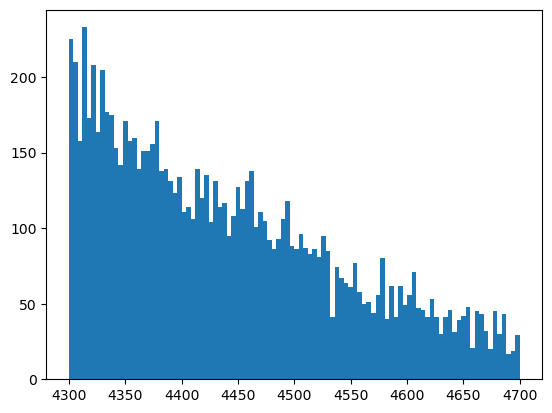

In [129]:
vel_flat = samples[:,0]
mass_flat = samples[:,1]

v_arr, v_bins, foo1 = plt.hist(vel_flat, bins = 100)
plt.show()

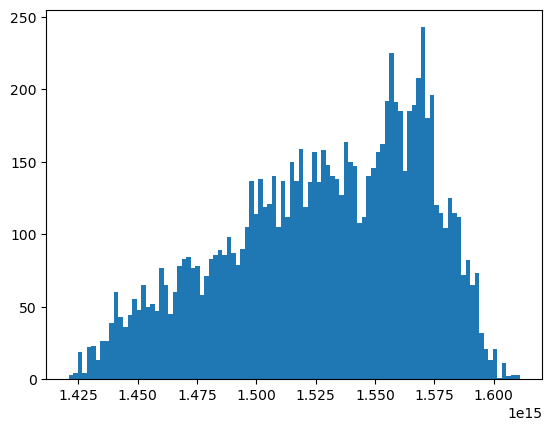

In [130]:
M_arr, M_bins, foo2 = plt.hist(mass_flat, bins = 100)
plt.show()

In [137]:
v_mode=v_bins[np.argmax(v_arr)]
M_mode=M_bins[np.argmax(M_arr)]
print(v_mode, M_mode)

4312.015694654106 1569198339081775.2


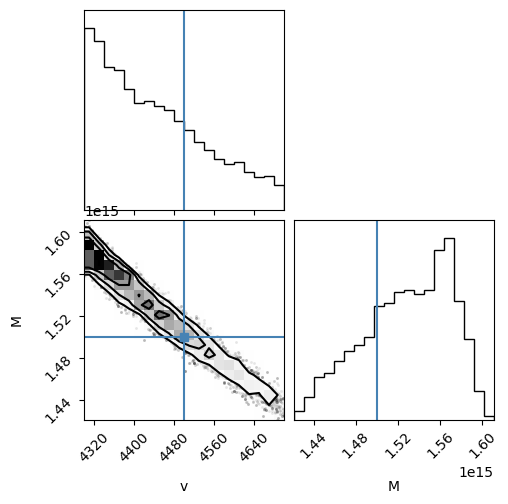

In [132]:
import corner 

labels = ["v", "M"]

fig = corner.corner(
    samples, labels = labels, truths = [4500, 1.5e15]
)

get moving lens dipole now
0.0 0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.692, z=0.30
		time taken for gettting deflection vector = 5.105733871459961e-05
check me. 
		time taken for get dot product = 5.443890889485677e-07


Text(0.5, 1.0, 'Predicted Signal')

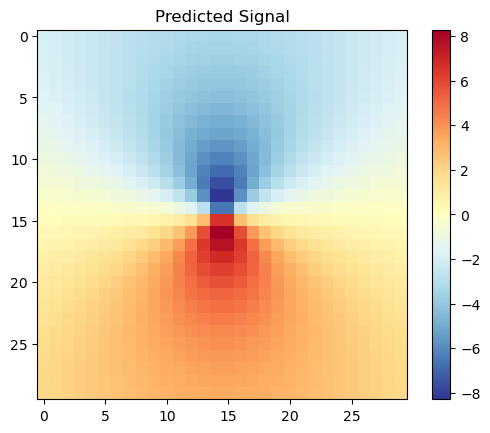

In [133]:
mvl_arr, vel_dir_arr, vel_mag_arr = moving_lens.get_moving_lens_dipole(ra_grid, dec_grid, ra_list, dec_list, [M_mode], redshift, v_phi, [v_mode], param_dict, bl = bl2d)
plt.imshow(mvl_arr[0], cmap = cmap); colorbar(); title("Predicted Signal")

get moving lens dipole now
0.0 0.0
i=0: (ra,dec)=(0.000,0.000), mass=20.000, z=0.30
		time taken for gettting deflection vector = 5.554755528767903e-05
check me. 
		time taken for get dot product = 4.0531158447265624e-07
get moving lens dipole now
0.0 0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.000, z=0.30
		time taken for gettting deflection vector = 2.6035308837890626e-05
check me. 
		time taken for get dot product = 3.814697265625e-07


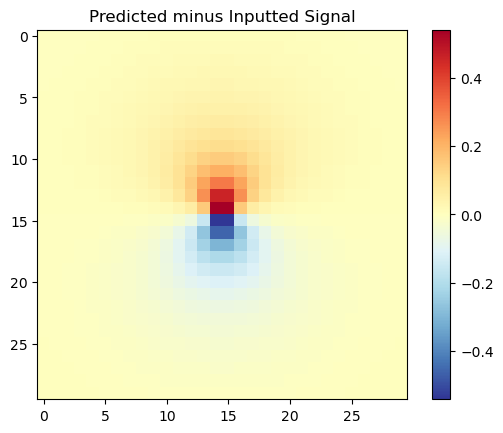

In [134]:
mvl_arr1, vel_dir_arr1, vel_mag_arr1 = moving_lens.get_moving_lens_dipole(ra_grid, dec_grid, ra_list, dec_list, [2e15], redshift, v_phi, [3450], param_dict, bl = bl2d)
mvl_arr2, vel_dir_arr2, vel_mag_arr2 = moving_lens.get_moving_lens_dipole(ra_grid, dec_grid, ra_list, dec_list, [1.5e15], redshift, v_phi, [4500], param_dict, bl = bl2d)
plt.imshow(mvl_arr1[0] - mvl_arr2[0], cmap = cmap); colorbar(); title("Predicted minus Inputted Signal"); show()

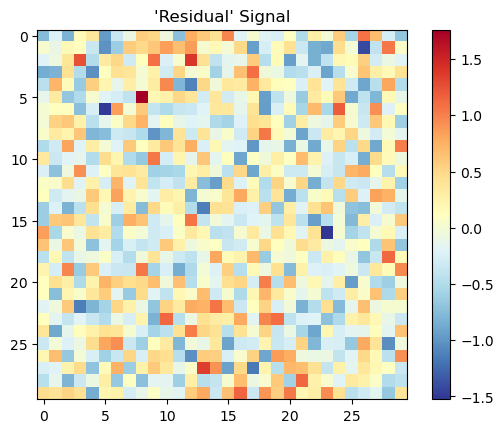

In [135]:
# Despite not being the same mass and velocity values, this mass and velocity gives a surprisingly accurate result.
# Maybe its because ML signal is prop to mass and velocity (so higher mass and lower velocity results in same signal)

plt.imshow(mock_signal - mvl_arr[0], cmap = cmap); colorbar(); title("\'Residual\' Signal"); show()

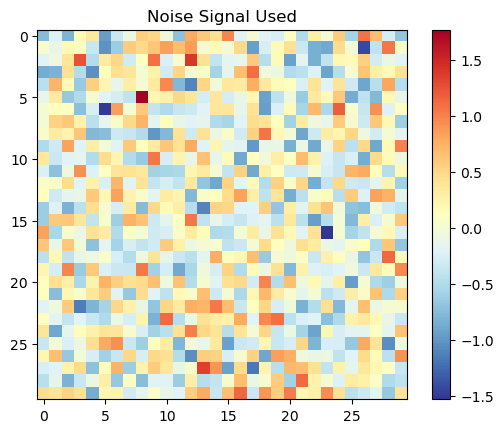

In [136]:
plt.imshow(noise_signal, cmap = cmap); colorbar(); title("Noise Signal Used"); show()

-------------------

# Foregrounds + ML #

In [138]:
# Simulate the Moving Lens signal

# There are 2 clusters in Bullet cluster
M200c_bullet_1, M200c_bullet_2 = 1.5e15, 1.5e14
redshift_1, redshift_2 = 0.296, 0.296
#redshift_1, redshift_2 = 2., 2.
v_phi_1, v_th_1 = 0., 4500.
phi_1, theta_1 = 0., 0.
v_phi_2, v_th_2 = 0., 4500. 
phi_2, theta_2 = 0., 0.

M200c = [M200c_bullet_1]#, M200c_bullet_2]
redshift = [redshift_1]#, redshift_2]
v_phi = [v_phi_1]#, v_phi_2]
v_th = [v_th_1]#, v_th_2]    
phi = [phi_1]#, phi_2]
theta = [theta_1]#, theta_2]

# Run 1 simulation for now
noofclus = len(M200c)

get moving lens dipole now
0.0 0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.000, z=0.30
		time taken for gettting deflection vector = 3.708998362223307e-05
check me. 
		time taken for get dot product = 5.483627319335937e-07
(1, 30, 30) (1,) (1,)
1
(1, 30, 30) (1,) (1,)


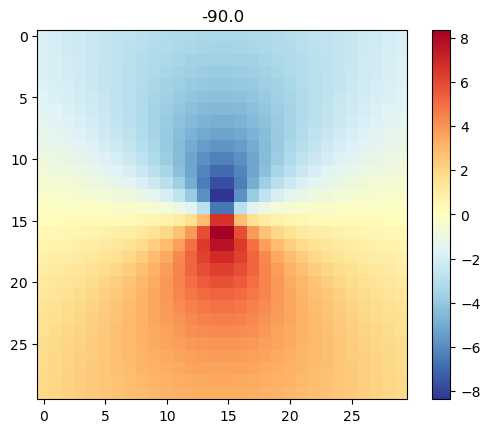

In [139]:
# get the moving lens dipole
ra_list = dec_list = np.zeros(len(M200c)) #cluster always at centre
mvl_arr, vel_dir_arr, vel_mag_arr = moving_lens.get_moving_lens_dipole(ra_grid, dec_grid, ra_list, dec_list, M200c, redshift, v_phi, v_th, param_dict, bl = bl2d)
print(mvl_arr.shape, vel_dir_arr.shape, vel_mag_arr.shape)
if (1): #repeat the same for all sims
    print(noofclus)
    mvl_arr = np.repeat(mvl_arr, noofclus, axis = 0)
    vel_dir_arr = np.repeat(vel_dir_arr, noofclus, axis = 0)
    vel_mag_arr = np.repeat(vel_mag_arr, noofclus, axis = 0)
    M200c = np.repeat(M200c, noofclus, axis = 0)
    redshift = np.repeat(redshift, noofclus, axis = 0)
    v_phi = np.repeat(v_phi, noofclus, axis = 0)
    v_th = np.repeat(v_th, noofclus, axis = 0)
    phi = np.repeat(phi, noofclus, axis = 0)
    theta = np.repeat(theta, noofclus, axis = 0)
print(mvl_arr.shape, vel_dir_arr.shape, vel_mag_arr.shape)
plt.imshow(mvl_arr[0], cmap = cmap); colorbar(); title(vel_dir_arr[0]); show()

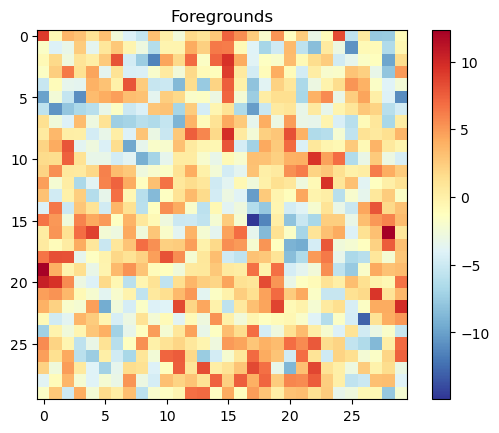

In [148]:
# Get foregrounds 
# ask if polarizations matter in this case
# ask why ls do not align, and if setting new el here is alright; or do I need to truncate all?
# why are the foregrounds randomly generated (model) too? or will it be specific to the data 

tsz_cl = fg.get_foreground_power_george_2015('tSZ')
ksz_cl = fg.get_foreground_power_george_2015('kSZ')
DG_Cl_cl = fg.get_foreground_power_george_2015('DG-Cl')
DG_Po_cl = fg.get_foreground_power_george_2015('DG-Po')
RG_cl = fg.get_foreground_power_george_2015('RG')
fg_cl = tsz_cl + ksz_cl + DG_Cl_cl + DG_Po_cl + RG_cl
el = np.arange(len(fg_cl))

fg_map = flatsky.make_gaussian_realisation(mapparams, el, fg_cl, bl = bl2d)
plt.imshow(fg_map, cmap = cmap); colorbar(); title("Foregrounds"); show()

----------------

# Simple CMB Modes Fitting #

Text(0.5, 0, 'Multipole $\\ell$')

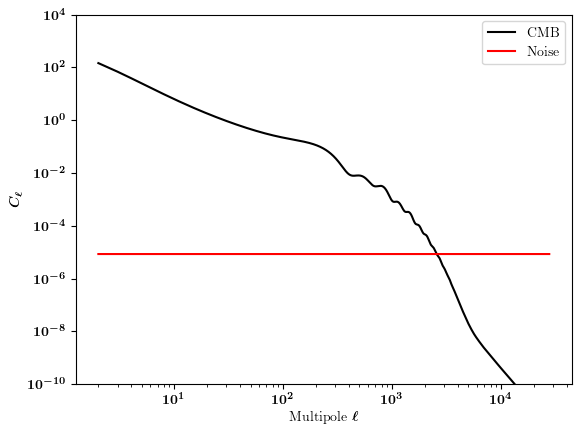

In [12]:
# Read in the Cls above
# Verify later -- what is the difference between files
# data/output_planck_r_0.0_lensedtotCls.dat  AND data/output_planck_r_0.0_2015_cosmo_lensedCls.dat
# For now I'm using the first one

from matplotlib import rc;rc('text', usetex=True);rc('font', weight='bold');matplotlib.rcParams['text.latex.preamble'] = r'\boldmath'
rcParams["figure.facecolor"] = 'white'
cmap = cm.RdYlBu
rcParams['figure.dpi'] = 100
rcParams['font.family'] = 'Times new roman'

#plot
ax =subplot(111, yscale = 'log', xscale = 'log')
plot(el, cl_tt, 'k-', label = r'CMB')
plot(el, nl, 'r-', label = r'Noise')
legend(loc = 1)
ylim(1e-10, 1e4)
ylabel(r'$C_{\ell}$')
xlabel(r'Multipole $\ell$')

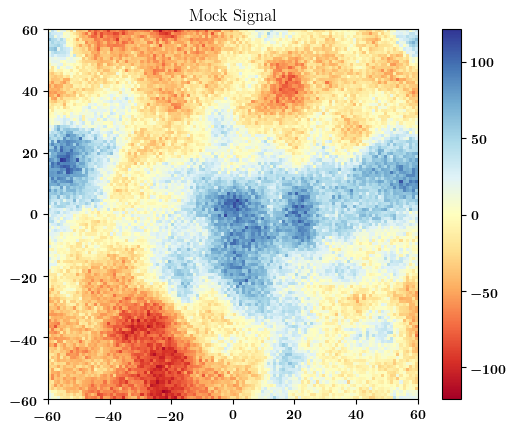

In [13]:
# Make a mock with CMB (with all k modes) and noise 

cmb_signal, g1 = flatsky.make_gaussian_realisation(mapparams, el, cl_tt, bl = bl2d)
noise_signal, g2 = flatsky.make_gaussian_realisation(mapparams, el, nl)
mock_signal = cmb_signal + noise_signal
plt.imshow(mock_signal, extent = [x1,x2,x1,x2], cmap = cmap); colorbar(); title("Mock Signal"); show()

In [7]:
# Figure out the distribution of the fft2 version of the gaussian distribution

fft_sims_real = list()
fft_sims_imag = list()
fft_sims_abs = list()

for i in tqdm(range(3*nx**2)):
    rands = np.random.standard_normal([nx,nx])
    fft_sims_real.append(np.fft.fft2(rands).real)
    fft_sims_imag.append(np.fft.fft2(rands).imag)
    fft_sims_abs.append(abs(np.fft.fft2(rands)))

fft_sims_real = np.asarray(fft_sims_real).flatten()
fft_sims_imag = np.asarray(fft_sims_imag).flatten()
fft_sims_abs = np.asarray(fft_sims_abs).flatten()

100%|████████████████████████████████████████████████████████████████████████████| 43200/43200 [00:54<00:00, 795.00it/s]


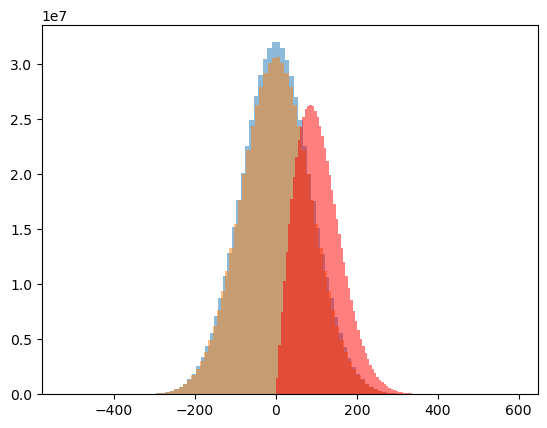

In [9]:
plt.hist(fft_sims_real, bins = 100, alpha = 0.5)
plt.hist(fft_sims_imag, bins = 100, alpha = 0.5)
plt.hist(fft_sims_abs, bins = 100, alpha = 0.5, color = "red")
plt.show()

In [10]:
# Very rudimentary, but they appear to be gaussian about mean of 0 and stddeviation of 84.85???

print(np.mean(fft_sims_real), np.std(fft_sims_real))
print(np.mean(fft_sims_imag), np.std(fft_sims_imag))
print(np.mean(fft_sims_abs), np.std(fft_sims_abs))

-0.0011732388910906445 84.8621245754576
-1.9532615122952548e-18 84.8374516459116
106.34198246506885 55.59097189299998


In [29]:
# Set up the prior cls, to help the realizations

nx, ny, dx, dy = mapparams
arcmins2radians = np.radians(1/60.)
dx *= arcmins2radians
dy *= arcmins2radians
norm = np.sqrt(1./ (dx * dy))

prior_cls = flatsky.cl_to_cl2d(el, cl_tt, mapparams)
prior_cls = prior_cls**0.5 * norm
prior_cls[np.isnan(prior_cls)] = 0.

In [30]:
# 5 params --> lmax = 250

In [31]:
# Restrict to the number of amplitudes we want to fit for
# First experiment with the l value and the number of modes it corresponds to

lmax = 250
lx, ly = flatsky.get_lxly(mapparams)
el_2d = np.sqrt(lx**2 + ly**2)
fft_filter = np.ones_like(lx)
fft_filter[el_2d>lmax] = 0.
np.unique(fft_filter, return_counts=True)

(array([0., 1.]), array([14395,     5]))

In [35]:
# Attempt an emcee with real amplitudes for the gaussian deviations

import scipy

cov = noise_cov
cov_inv = noise_cov_inv
data = mock_signal

amps_mat = np.zeros_like(fft_filter, dtype = complex128)
amps_idx = (fft_filter != 0.)
num_complex = len(amps_mat[amps_idx])
num_params = 2 * num_complex

def log_likelihood(amps_mat):
    
    complex_mat = prior_cls * amps_mat
    
    d = data.flatten() ## - np.mean(MAP.flatten())
    m = flatsky.make_direct_realization(mapparams, el, complex_mat, bl = bl2d).flatten()
    diff = d - m
    
    return -0.5 * np.asarray( np.dot(diff.T, np.dot( cov_inv, diff ))).squeeze()

def log_prior(amps):
    return np.log(np.mean(scipy.stats.norm.pdf(amps, loc = 0, scale = 84.85))) 
    # Is this logically sound??? # iamps.real
    # seems like it

def log_probability(amps):
    prior = log_prior(amps)
    reals, imag = amps[:num_complex], amps[num_complex:]
    complex_amps = reals + imag * 1.0j
    amps_mat[amps_idx] = complex_amps
    
    res = prior + log_likelihood(amps_mat)
    print(amps, prior, res)
    return res

In [39]:
nwalkers = 3 * num_params

initial_real = np.random.standard_normal((nwalkers, num_complex)) * 84.85
initial_imag = np.random.standard_normal((nwalkers, num_complex)) * 84.85

initial = np.hstack([initial_real, initial_imag])

In [87]:
# try using emcee

from multiprocessing import Pool

nwalkers, ndim = initial.shape

with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, pool = pool)
    burn_in = sampler.run_mcmc(initial, 100, progress = True)
    sampler.reset()
    result = sampler.run_mcmc(burn_in, 100, progress = True)
    samples = sampler.get_chain(flat = True)

[  77.8964781  -107.24085495   87.28608827   -7.80612599 -204.39773455
  -96.20353701   68.6342631   -85.80132756   63.3805484   166.74585496] -5.958755868108288 -78998.80122702481
[  93.24612048   23.63784005   76.34577024 -126.32617701  -52.33947002
   27.42394939  -56.14703408  -45.71996675   -6.19093727  -16.5253012 ][ -84.21733256  -53.60230826 -162.19015543  151.0117787    29.16693135
 -105.89335062   68.3097314   -33.76977942   42.32604164  -51.32295414][  23.62716846 -103.79145716  -61.14967232  -58.5263006  -195.77693862
   -1.62694106   56.85025436  184.27292597 -214.80235934  -47.69383822] [  8.84337329 -74.19233987  60.33367686  72.71782886  29.31610492
  47.35461046 -21.60482207 151.30255141 -12.64531154 170.94357165] [-69.05607978  15.22125436 -91.40595203 -93.83696612  55.78331611
   2.65418489  40.97867323  73.17605159  20.04861577  17.14754642] -5.781300057030553[  25.37967719   47.33496396  -44.06828579   19.44207445   12.46855441
   64.04609954 -152.37489642   82.395

  0%|                                                                                           | 0/100 [00:00<?, ?it/s]

[  51.97075935 -134.97397457  162.22044515   59.73763167   40.81281338
   69.86534349  -17.82201687  313.35089936  -60.09368092  275.47894958] [   8.23818839  -97.30887686 -113.34131175  -87.64874175  -97.18716623
   51.73049929  -59.17792417  137.02243577 -123.17135321  -52.78583644] -5.972631048209878[  90.0149904    24.76606317   70.61284157 -119.38613183  -49.25395165
   29.16753466  -60.72845496  -39.62039661   -8.74786889  -14.54182631][-115.31450733 -103.35789687 -228.69075465  164.76652384   46.8030187
 -156.87348587   64.86536855  -51.33606566  100.89995202  -60.68067552][-11.92250131 -19.39861944 -26.47650164  -7.20703902  -2.29013258
 -54.53901079  92.27033408  30.48793039  49.36035209 -29.05194523] -5.856199347353862[  72.27739619   91.52376794 -124.53849995  211.3778404   174.07005712
  138.12995513  -78.66723585  162.50426877   58.73676769  124.0672236 ][ -11.16018796   46.4330446   149.94817902 -267.03299669  173.1587358
  226.34907241   94.29727276 -261.14707347 -145.55

  1%|▊                                                                                  | 1/100 [00:02<04:24,  2.68s/it]

[ 184.15415123 -158.05499229  185.528409    -11.00625739 -370.78915974
 -139.38975115   75.86751173 -122.9359716   108.09859423  325.00354919][  21.68229007   48.95633333  -44.05243196   21.26451366   11.99720658
   64.04270349 -146.36606208   78.59091797  -52.98745438   23.5972761 ][   9.42824036  -63.76116541   65.1876008   -72.49204929 -134.14528292
    9.27928151   76.686683    115.08840946 -137.28718766  -14.30770793]   -6.537683588365096[ -98.49463661   49.01105739 -148.74904639 -156.77877898   65.78539533
  -14.23830878   64.62926011   43.65169277   32.40379927  -40.97266945][  9.58006889   3.39444766  80.45319077 -40.34222643 -64.72951692
   6.30111172   8.81890576  71.90435211   7.18724303   4.25973518][ -46.3257696   -10.04644135  -30.42461831 -105.6357122    10.30558446
   55.25216857    9.88062067 -140.46004007 -162.48843056   38.46429112][ 69.25854759  -4.16585888  71.79507409 -69.75713444 -29.13265365
  33.08831698 -46.33000968  10.27456154  -8.02529431  36.75404575][ -82

  2%|█▋                                                                                 | 2/100 [00:05<04:19,  2.65s/it]

[ 22.90107574   4.7419345   64.19891884 -28.99355127 -53.92734891
   7.45001004  10.1914768   48.45817962  10.28260414   6.45560996][ 121.07481307   -8.79988977 -103.27635715    8.7315773   -13.06459658
   41.20402687   95.66025474   -8.93967852  -88.01989704   43.7333112 ][-120.53540675   98.34619858 -208.48915699 -239.36346455   97.04488088
    0.26370636   67.4467992    87.94219495   46.468286    -44.12608016][  36.99789253  144.5867901   221.15861414 -304.79100334   38.51947335
  369.25792662   81.86536466 -138.66994041 -209.82455335    9.36805709][  80.33373218  -29.64772646   63.72553473   -5.15762957  -79.88831417
   -7.90786928   14.7069791  -127.84353145   80.7349119   115.56981583] [ 54.29368483  -5.04305053 -26.40539999  82.05859341  -1.53805238
   9.60222883  13.94244873  43.42286462  58.15441262 102.83748267][ 249.72279529  448.3257607  -313.24142185  133.18035306   93.04415937
   -9.20001255  -72.33155326 -132.4760602    63.49146472  -45.40909882] -5.432130604445166 [ -81

  3%|██▍                                                                                | 3/100 [00:07<04:15,  2.64s/it]

[ 56.76129961 -19.25343404 112.53016466 -34.98044099 -78.58863606
  -2.16321371  -1.73150112  66.08468826 -12.45079286  15.49909783][-202.84247411 -139.61773122 -303.73543534  231.15876285   32.64419531
 -219.05257868  130.59165256 -117.28121314   82.84381949 -173.48651657][-284.01713971  202.51684811 -430.0370253  -429.97699522  241.04582347
    6.91432154  110.3702529   263.5641182    18.57964459 -174.09807069]  [ 53.6387393  -13.0225456  -31.45288139  86.0641123   -5.37343862
   6.57120502  16.94170169  40.02242403  67.51206648 103.82923413] [ 207.56527357   94.5659289  -156.28091799  -46.61814469  -59.75268131
  100.70652473  192.70378741  -40.52079809 -153.13450184   -5.79290491][  57.28673786   37.46926245   18.42256915  194.4261982  -177.07070975
  -12.25963027  154.46411325  263.71637164 -160.87105559 -104.30291611][ 158.39823358    4.33749568  134.8441944  -171.02785341  -79.14542545
   24.53980205  -95.33604946  -62.92747786  -37.91231906  -15.45008125][ -97.87929701  -20.904

  4%|███▎                                                                               | 4/100 [00:10<04:14,  2.65s/it]

[   7.43697242   65.57781126  -71.22491788  -44.3485784    14.81600062
  108.22953528  -26.67160467  125.77326078 -203.61288242  -51.34265964] [-105.76882824  -37.23613267 -162.27891823  220.77604764   17.03094684
 -167.59115457  149.59668861  -59.92240391   45.7345025   -56.57790183]-5.72863584166063 [ 269.46794889 -263.57288169  285.61917981  -15.81233171 -609.83515958
 -247.43418756  126.12580728 -118.90321416  130.58453369  497.10444526][ 165.45775027    1.95823441  143.53359996 -169.29835106  -83.60461655
   25.15420447  -99.45591193  -66.7458304   -40.04790331  -14.72432192][  81.55574099  -44.73204953  219.64456251 -326.35162653  -42.14432008
  -91.66998132  274.70042445  268.27433989   18.69844112  -85.05297024] -5.987027017490931  [ -95.82793448  -15.38695073   27.661491    145.28586103 -165.40723525
  -92.86148324  -24.60303766   37.1843456    43.8530248   -54.78980262][117.53951242 206.4833865  -59.90137427  30.68384632   6.14706281
   7.57460799  23.14796362 -41.01649329 -1

  5%|████▏                                                                              | 5/100 [00:13<04:07,  2.60s/it]

[   4.36410885  -19.7667788   145.23609407 -152.35736076  -74.0836196
   94.49427652   67.531989      5.35906957 -155.81273839    8.08506965][ 46.26800142  16.64378606  -4.04642365 -23.78251688 -33.48693688
  49.72125641  -5.86785275  -8.28817332 -58.91466961  36.58219299] [  97.63848135  -62.49590631  214.29670929 -276.91988891  -93.66080669
  -99.15025969  243.53251353  206.95044753   32.71229813  -20.77485404][  16.08498107   10.72072821   -8.7487336    59.37257109  -75.999379
   17.2336346    75.66498327   69.29691675 -124.76359812  -14.85630957][ 40.31249554  53.53475851  17.62565773  41.02435727 -67.6264707
  32.65231403 141.34473759 -12.73578501 -98.84116851  44.62598697][ -88.67391229  -19.05678281  350.7444222  -174.15541251  -57.67124758
   51.76699843  197.21813087  193.91180238 -199.66099939  -65.7895597 ]-5.785898862977346[ -41.41987517   44.73641428  180.38180606 -118.06015224   78.02277379
  147.30799808   80.83612433 -169.17739158  -51.30721348   -5.93930809][ -81.78943

  6%|████▉                                                                              | 6/100 [00:15<04:03,  2.59s/it]

[ -19.78424566   48.60559038  -82.45437595 -165.55614062   15.24456122
    5.4761467    42.32316715  -25.15908165   73.08232173   48.01497485] [ 75.70916365  13.41261919  32.42100479 -62.44357872 -45.47513081
  43.10955795 -29.35882073 -22.63439019 -53.40024591  22.92048377][ -13.95379569  -23.30404788  178.33682502 -207.08025118  -77.42791398
  132.83240707   90.0442127    20.85199446 -236.68198001  -11.70607506][ 205.75995544   41.7021747   -85.12459062  -41.02727577 -125.15417148
   51.40347256  170.01081984  -58.96548855  -99.34734356   65.46612525]-5.588152186014236[ -72.66543644   36.12785677 -128.63562779   89.18781042    7.38516819
    7.30309379  -31.42096764 -143.44802782   68.16770386  -25.81982888] [ -61.8296428   -29.81624519 -150.13197387  137.04562222   19.80474323
  -89.58799696   70.39937946  -45.99677566   34.24232069  -50.26442164] [-113.88529464   68.77449182   61.53055571  -44.37945065  133.88273826
  224.01059165  -35.9005044  -348.72045947 -145.16363806   26.7212

  7%|█████▊                                                                             | 7/100 [00:18<04:00,  2.59s/it]

[ 59.62301504   2.95166965  73.59449384 -40.23941348 -68.57553262
  13.36028744  -9.79705677 -36.11535296  16.56232926  48.04072022][ 45.3910583  -49.99384721 -34.67147755  17.27698838 -40.30914452
 -12.58639857  56.70161204  -7.12688767   9.94670697  47.57887038][ -81.68286135  -22.55774773  -92.62013025 -254.01121718   19.34525411
    4.53026631   50.96638061  -18.01136124  113.48467667   76.94517193][ 194.50808556   39.32189433  -82.87458887  -44.64550381 -118.75427081
   51.7522956   162.6518879   -63.59836312 -102.10030728   64.67405828][ -5.19069173 -65.04999917 -41.25410299 -62.25708309   5.24202976
  71.0331369  -75.74611919  56.22238726 -33.42484134 -21.05644454][ 223.87200212   11.32158793  105.29688975 -171.41310023   85.07210353
  150.7232795   107.7225168   106.20332617  -46.04170069   60.64976449] [  -9.35706376   66.16933205  -34.89816127   71.08234573  -38.72145349
   94.76042603   90.35323617  143.95688007 -268.44890552  -99.21646327][  56.90756056  -87.6263596   307.1

  8%|██████▋                                                                            | 8/100 [00:20<03:58,  2.60s/it]

[-224.75589002  -73.36138983 -189.71276873  245.46818121  108.06531887
 -175.43292953    9.74934572  -38.10056544  115.58054463 -120.72883363][ -68.4079732    47.70526126   95.17568364 -104.76889671  123.0800393
  130.39263291   49.0893398  -249.75515175  -54.95962446   12.77342279][  32.92938044 -114.54999356  -97.00946728  -36.22073962  -15.88001129
   89.66299813 -142.84206775  149.06985761    0.96789994  -19.59795068] -6.267611994568707[ 161.08803372 -131.2359369   170.14049117  -13.92486565 -320.78200013
 -115.85067981   62.94293528 -109.2274       99.00157953  279.55411953] -299863.63758776645
[ 197.7074527   -41.12833352  166.29870031 -291.04772298   88.51427136
  152.00560439  211.54442506   65.76536999 -128.03031794   28.84036833] [   3.78330432   40.67657037   18.04898839   53.94817289 -100.41243609
  -14.41414561   69.61572741  -14.41070341  -33.6886359    -8.38054709][ 146.58571274   16.36967836    1.33121228 -227.43371395  125.09015403
  148.13765482  161.92141412   42.021

  9%|███████▍                                                                           | 9/100 [00:23<03:54,  2.57s/it]

[ -95.78214212  -14.72544037 -102.08808028 -289.35595099   21.94480542
   -7.72775498   74.32243287  -31.69436262  140.56350777   95.00914256] -5.811356029183559[ -73.0631185   -29.32662705 -163.82795934  155.57467365   16.83080683
 -100.04482913   64.29023565  -50.83414716   41.26592454  -53.68829342][ 190.69245936  -17.28001522  183.69801987 -174.60961382 -165.25444358
  -61.64093229 -115.02722663 -114.88398602   22.29305909    8.60714375][ 168.92898625 -192.04262117  211.55974707  -21.95670653 -379.64588778
 -138.07351986   70.10805765 -121.5088384   119.80700279  332.7990688 ] [ 63.89268071  81.47017861  45.48957531 -77.9221756  -24.84244437
  60.43576365  54.93694609 -12.23700005 -86.87975193  -2.76770675] [ 42.61015144  28.08257724  36.88383212  43.79810424 -65.09700873
  35.97605701  50.55577398  87.33189758 -88.97068055   3.60622505] [155.9290761    6.91430764  22.39927201 -52.06621189  16.67308535
  79.66708323  83.0751265   54.32809112 -11.24901464  77.91919686]-5.75341764164

 10%|████████▏                                                                         | 10/100 [00:25<03:48,  2.54s/it]


[  57.1923916  -117.19568112   79.16659698 -134.82797557 -210.13138048
  -83.05357422   71.88697771  -83.5974603   128.56848251  232.42611975] -6.173395864872518[ 149.32760847   24.19408706  -19.84271238  -78.22768735 -101.6528629
   66.76260912  142.15600838  -37.73411946 -112.24542866   47.65258591][ 114.4596235  -154.33071396  166.01374101  -68.45670288 -258.39882613
 -168.87099452   57.20562516  -59.47070409   67.63003894  119.38940108] [ 209.07162048  -69.42567331   77.4603991    28.50090547 -136.75518129
  -26.00578623   20.23471641 -222.15049725  197.39510966  238.96835888][-122.10505616   39.38065736  113.45141318  -57.16628121   26.12199323
   90.10754661   12.8100792  -211.20965878  -70.19918244    7.71826667][ -46.06288139  -21.22696504 -118.50254449  103.46662913    2.63552407
  -71.7147841    43.93405244  -50.42180241   15.68001864  -43.03658099] [ 371.9990011   -73.65982336  253.70027452 -433.25914786  135.12771009
  234.10560795  334.24716619  167.50882146 -162.57659256

 11%|█████████                                                                         | 11/100 [00:28<03:44,  2.52s/it]

[ 227.23637266   69.75076982   26.67820253  -43.31397796  -41.42988343
   89.06126628   91.09775775  125.84295535 -176.01895872   21.41002573][ -54.48799832    4.87500792   67.42785185 -127.70988817   48.71840756
  102.57221719   37.31464679 -172.30258737 -116.70359041   25.0662964 ][ 342.21710979  -96.8785143    79.1921629   140.6236696  -204.89798389
  -96.21054974    0.76185907 -324.19949576  411.26317518  369.68844968][  14.47375734  -93.04460874   44.02677774 -138.03456834 -134.7179111
  -34.92992607   48.08545418 -115.28843578   28.49997244  175.50124359][ -47.97372957  -22.59442461 -112.7341426    87.30270723    4.0239144
  -62.72664945   40.94351947  -58.98709934    2.80523834  -36.60593649][ 51.06278055  62.84331895 -14.0756319    4.70610037 -42.30468982
  44.79516933  71.8232584  -37.90914103 -71.77110555  10.65415097][ 160.44339171    2.42484597   24.98442696 -207.46680912   50.50045928
  126.16503527  145.21536737   96.71532613  -70.13953773   12.34701308] [ -78.50458133  -

 12%|█████████▊                                                                        | 12/100 [00:30<03:42,  2.53s/it]

[ -81.85596873 -119.99598519  140.69304842 -318.47009516    7.25497379
  137.88748349   -2.47247657  -49.34513464 -231.21342073   21.22699907][ 160.42700593    2.44633336   24.99597027 -207.38135722   50.48231196
  126.1413456   145.16299124   96.6484495   -70.1249564    12.37132643] -5.904857701097321[ 277.15574313  120.21140943 -173.35383458  186.55808551   89.75450771
  223.61323103  -43.4496641   -48.50279536  -24.91877999  172.7840399 ][ 27.91633403 -27.69699065  20.32060295 -47.9579393  -33.54332432
  26.05125847  60.30402476 -20.9107129  -48.98169377  27.37138915] [ 187.38954021   23.9261614   103.23950607   36.41621271  -18.01907988
  114.58895398  105.11818891  135.05108592 -199.66836663  -23.48945542][-41.91367847 -33.17915886 -99.3505029   82.95792219 -12.40436346
 -72.82096022  45.75338676 -58.62026275   8.30487994 -26.20487631][ -25.47953245   -1.28521683  -57.47824672  -20.42424345   51.55858074
   48.99721397 -132.26369315   60.05294242    6.82401148  -48.76936944][ -54.

 13%|██████████▋                                                                       | 13/100 [00:33<03:39,  2.52s/it]

[ 41.04163675 -14.34707612 -47.57725211  26.48594241  -1.52417966
  -8.13317613  62.48535756 -12.57653126  -1.69624897  17.33797063][ 169.21342159 -424.99067734  352.02902685   89.78605529 -603.55263768
 -469.65949727  225.01614531  -53.13482461  162.90887377  300.83251604][  45.94584623 -137.33358389   84.55114936 -139.89988097 -242.59792763
 -107.51343139   71.05512917  -96.51770633  153.19029946  258.26213009][ -21.65938292  -73.08123743  102.91397543 -220.27380237  -23.57238109
   -6.46013374  114.04129719   -5.36835302  -86.78647818   13.34050225] [ 172.51946328  -13.4110387    16.47717915 -270.44358355   63.87476539
  143.62397137  183.81579174  146.00239789  -80.88575968   -5.57156229] [ 79.25518865   7.66894097  68.45552647 -63.83144573 -37.66591112
  36.25648015  54.78914893 -32.39580779 -13.57086943  53.00892756] [  93.71145668  123.45983898 -102.11025639  156.26759174   57.57347045
   -0.89694555  123.21283328  -19.556746    150.03882823  -35.10902514][ 188.36230932  314.197

 14%|███████████▍                                                                      | 14/100 [00:35<03:35,  2.50s/it]

[ 104.00831298   13.83229144   51.4139137   -52.80655244  -10.24831102
   81.84783153   98.59831235   96.03194101 -121.32901331   -1.51553504][  64.37517593 -275.8929524   295.00920706  105.78424185 -536.40329287
 -438.44007692  -52.01273082 -236.71898521  195.74495895  227.18509671][ 180.02115497  106.58948853 -134.47285892  149.29650577 -325.03249182
  -18.643582    156.59936977  -74.31347144  -43.76137327   54.20537482][ -42.52038395 -136.6106876   111.77346932 -274.69574997 -290.85409613
 -124.5534602  -202.67515513 -118.53785538   31.8263662   118.44764496][  75.81819934  -99.69641412  139.22203698 -369.85473357   79.48074292
  184.78012397   90.52354091    5.45780005 -211.82123516   23.46297473][ 45.34264774  24.97598445  39.34717299 -70.22871034 -17.09733107
  45.85671756  77.3271642  -51.12397048 -67.25250865  15.60824   ] [ 22.31683005  15.42094373   6.60344089 -46.05457608  38.87647359
  57.94953588  71.43272046 -23.35121077  -3.92136304  -8.71451238][ 211.44845424  -50.78645

 15%|████████████▎                                                                     | 15/100 [00:38<03:32,  2.50s/it]

[  -8.52552947   -0.50021783  117.4574538    70.89464575 -117.47417332
  -51.73022717  -70.35924904 -140.80192846   63.35674276   98.47345074][-400.51461693 -204.80052073   46.03616887  264.30784756 -735.30215313
 -495.70183392 -214.49562074 -342.09289521  434.91437501  464.28206905][ 54.54033889  44.67628917  28.50270853 -58.37387614 -15.19924407
  41.07375187  70.77077215 -51.10629758 -59.73607746  13.51085583] [  10.12508086  -74.99739228   26.31039101 -172.18342901 -111.03344816
  -79.34423178   67.55269073  -48.02969083   98.82508424  104.96686297]  [121.61652079 -17.56869213  67.37993691  36.88644906 -91.09889372
 -13.91185917 116.79590006 122.32351011  76.55734322   8.06964154][293.46719173  37.59367347  70.70363528  -2.3176307   -0.48566921
  74.07259428 152.92157618 210.89368859  97.91593222  80.58863255][111.44976644   2.5104647  -58.25880139 130.03641334 -16.93141978
 -53.15240903 101.47102065  89.84031259 107.34969463  -5.87210198][  50.84455919  -53.05972228  143.48313696 

 16%|█████████████                                                                     | 16/100 [00:40<03:33,  2.54s/it]

[  55.36371967 -122.72226498   78.69102779 -131.91277523 -216.4401121
  -89.04198622   72.72238877  -81.95028166  135.14943802  238.7617302 ][ 22.83707786  20.00276703   3.23835894 -47.41485599  39.20497484
  59.41941767  68.81563355 -32.30491477  -8.64864093  -8.32822711][ -30.03617775    2.55863522   64.3105192  -144.12024543   52.74946383
  108.15440392   52.65951883 -143.97902608 -114.27658606   22.97520903] [ -34.69882805 -192.35654441  137.16723875 -225.71276348 -299.41358198
  -84.87903511 -104.45987075 -145.983439     12.37787116  156.72200598] [  36.4456832    55.71076075   14.46000121  -58.07509347  -32.86186283
   40.8363423    77.51799541 -118.88672896  -86.29125802   11.9087259 ][ 386.65161533  171.48254425 -303.10756385  366.3258096  -619.78312882
  -61.58879953  223.74416375    0.84500366   13.16991569  105.69716291][  9.35396944  13.33206915  -0.46576748 -59.88185789   0.60211604
  44.37787325   1.44434518 -34.42242566 -49.78238969  -5.64425417] [   3.37467994 -133.9792

 17%|█████████████▉                                                                    | 17/100 [00:43<03:30,  2.54s/it]

[  82.99300611  -14.41808378   48.63966583 -155.26263879  -28.16070906
   50.19962947  101.91820329  -66.84855447  -80.88469396   66.76652792] -5.714336543722931 -86017.15271852253
[ -95.97317336   41.00543986   55.08285739  -95.75806959   82.76074885
  126.94041351   22.06369423 -198.13977361 -129.98365801  -19.21831078][113.69129756   9.43729674  25.44817835 -59.26585197   3.57846573
  61.48082614  80.69653813  13.36271275 -30.59889582  59.39413951][ 335.761763    -92.20912928  256.80254376 -474.47984957   71.06864332
  198.17632327  327.59328903  118.33616659 -187.92629767   57.71098731][ 109.73564438   81.83109518   82.97394544  -41.10878367  114.41667083
  135.42932197   20.84253499   23.86031124 -103.75012762  -79.81573229]  [-10.02364626  97.61772177 -81.13139067 161.73227557   9.94594864
 -17.91436051  55.561774   -54.58624339 111.21162589 -32.22728233] [   2.66469938 -432.4610774   473.82478681  426.12375882 -979.07055152
 -868.78520814 -208.62315115 -434.18101483  428.8687020

 18%|██████████████▊                                                                   | 18/100 [00:45<03:25,  2.51s/it]

[  78.47257212  -36.85767509   60.28087982 -219.96824592   -9.93447245
   59.28766514  104.96583604  -54.41392751 -103.20281362   64.29966085][ 181.29773967  -60.23762378   81.80900816 -287.64450284  -57.7264024
   52.84047289   70.42283351  -33.35855125  -45.10488619   83.77842255][  62.18325349 -116.17508941  115.47054559 -276.00744978  -56.20988762
   59.69217277   82.17906792  -36.7674181   -56.9943085   121.44906182][ -16.39910736  -23.40319721   68.5013582  -144.08072561   -1.64759825
   68.71285538   55.93457042 -136.05654941  -65.66408389   66.66098899][   1.37839975  -73.592695     19.01008351 -189.69860939 -101.05045168
  -75.95729004   62.25835562  -44.85803946  104.10286555  102.05427676][ 194.24290607  -45.38264207  -15.61267879 -167.14588183  109.31302418
   82.750603    177.07832994   45.09703625  -47.60105972    5.76197394][-127.40453323  235.72189644  -28.95964588  -90.46238445  101.45222605
   92.09592178   49.03903935  221.14273622 -291.70195611 -250.43753162][-10.77

 19%|███████████████▌                                                                  | 19/100 [00:48<03:22,  2.50s/it]


[  90.3637908   -38.46319301   69.00446558 -259.34754164   -2.00718796
   68.40436793  116.7582524   -61.08653395 -117.25265874   71.50305864] [106.34944447   0.38730479  94.08523975 -53.11567787 -49.38433684
  25.2937835   34.44648367   0.82339427  45.93511703  64.74425983]-5.843471086256943  [  10.00739701  -50.13480511    0.51141486 -225.271205   -154.85291815
   17.345138     12.00047164 -131.91693418  173.65238583  300.879391  ]-5.564215556219037[ 443.84981972 -254.19081295  190.81416915 -107.91620687  -19.82356946
  170.10386705  -52.10018208 -447.14464774  430.38354372  499.44826782][  4.51446574 -54.40490908  50.42077561 -87.53141398 -56.18894313
  31.9532348   83.64238867 -22.4504682  -41.18728185  19.94788522][ 187.69753251  -45.29879036  -13.64934563 -167.94475537  106.68605029
   82.42158006  173.49606755   39.40517468  -51.44216317    6.90881775]-79011.45614299209[ 169.42961162  -82.14993677  166.4517224  -302.83732926   30.08560277
   90.08978375  190.20629384   35.27339

 20%|████████████████▍                                                                 | 20/100 [00:51<03:22,  2.54s/it]

[  61.5964644   198.56172554 -106.50608778  -37.00519718   53.55420586
   29.80729841   39.52095001 -134.75085253 -134.7420879   -27.43027343][  76.54988617  -84.93086388   64.45924633 -156.97838489 -168.96850888
  -44.0322454   107.97668793   13.78991796   64.03554121  155.58736141] [-312.69369875 -170.56040689  169.30954667 -190.62271342  191.4806877
   -6.1711578   -88.15725233 -100.45565483  -82.30597647  -62.82401568][ 342.71123417    5.62893042    4.66628714 -418.65156677  130.50633071
  218.56182479  241.50632294  192.82949662 -127.82300139   -4.16459938][ -30.04328988  108.3667777   -22.38588337  259.73977697  -77.76132762
  -14.21945743  121.50743827 -119.23148279   -1.82567723   55.18893547][ -29.76976243  -65.88270594   97.67444878 -131.1325688    42.92168397
   87.83301256  135.42807043   -8.70611414  -33.18267663   22.84946128][  -1.73966817  -95.72870929   22.44941128 -197.11932862 -134.25314756
 -114.04070097   65.59615365  -40.46527775  134.94048314  114.73765983]   -5.

 21%|█████████████████▏                                                                | 21/100 [00:53<03:20,  2.54s/it]

[ -43.69824024  -13.25735933  -47.03899296 -257.44883295  -12.9946723
  -13.07073701   27.95154423  -49.69991488  106.22137583   67.18581915][  53.42846427  -66.16552051   87.65080128 -164.43729107  -50.82914211
   38.55190922   58.73831069  -36.16418373  -33.97777663   80.25945011][ 401.59266066   -3.38348702    0.92172838 -492.93299474  167.16735867
  256.45337073  276.52083497  258.10440646 -141.5234224   -12.00097949]   [ 123.99038515   -0.75853242   47.81468576 -131.24386468   27.02939741
   83.60420434  124.55344276   -2.15996267  -67.06626135   40.48516596]-6.436651101118077[  73.60590225  -81.44198929   61.41230833 -162.23234352 -173.72271422
  -47.84624549  111.00402051   23.32965387   62.0259667   155.35443009]-5.623138535040777-5.6748798798192075[  83.32704412 -536.17797305  515.62370181  213.535116   -891.66391409
 -786.15348207 -149.98848321 -284.14493212  405.15128362  378.03453521]   [  33.85341112 -242.31819945  274.98013299   -3.12811621 -441.49144664
 -372.36438724   

 22%|██████████████████                                                                | 22/100 [00:56<03:17,  2.54s/it]

[  92.36785815  -31.04054513   63.22740695 -157.18999103  -49.94045895
   42.4861463   115.73164391  -66.11411079  -65.08244683   85.48251725][ 230.8992469  -168.08210539  140.2695698  -205.42888154 -125.43591088
    1.80185134   50.89313311 -159.79014483  135.00856289  231.08539158][ 82.06453979  78.97840917  -2.1993413  -72.61896065  14.42375545
  42.15685636  56.49978058 -66.58597463 -67.85326591  19.83418951] [ 162.03561615 -129.14250599  120.09163187  -44.4002621    -8.17157165
   86.17148204   60.87508714 -136.46333377   51.85878768   91.80871924][ 128.24188398  -59.66340682  125.7462837  -169.64032314  -47.37817052
   45.35973453  155.04330202   -9.46630655  -65.53844834   69.96633123][  -7.27350146  -75.59920136  133.44778287 -162.85159467 -122.0404936
   18.7187839     6.85725189  -70.32848282  -26.08226795  113.42068099][-114.13020041 -182.87322061  188.78315871   52.77691138 -393.50844308
 -319.03399043  -48.33179973 -180.33858651  107.44877339  149.87322385][ 280.31338073  

 23%|██████████████████▊                                                               | 23/100 [00:58<03:15,  2.55s/it]


[  80.98694471  -90.18916055   69.05147327 -149.05982191 -161.80315473
  -38.28393219  103.41400952   -0.58800255   67.06429408  155.93842646][ 274.52005068 -215.17192188   99.57239821 -122.78285201 -226.82257107
  -56.6052499   -55.88833494 -328.78901389  329.05996344  369.96275811][  61.51086696 -122.89238458  122.41005342 -278.61382287  -59.07437029
   59.60215566   82.20280922  -32.16929401  -53.88451937  123.34135081][-31.13733031 -49.06712368  34.64618601 -73.95724395 -55.26526521
  11.30707802  39.86788906 -79.54437005 -56.12923294  29.28525352][ -68.24325843 -110.36137026  173.22284404 -177.532827   -191.28082511
  -11.4193479   -47.81055003 -101.99155644   -7.04592687  147.29793954][ 592.45596828   26.98900381  -34.2609257  -619.80828973  237.35095362
  326.90209573  385.6623158   407.13850706 -184.47846761  -59.45333831] [  48.84371205 -347.57332326  359.4104367   167.53683021 -683.19359339
 -574.44751536  -98.0132596  -297.8283067   264.2147845   275.82575852]  [   6.537046

 24%|███████████████████▋                                                              | 24/100 [01:01<03:12,  2.54s/it]

[  68.96514195 -118.15904225  115.53616485 -283.15523813  -53.2270624
   65.43836048   85.4057327   -26.64599542  -55.12296589  120.40086553][ 325.29040696   67.63003154 -200.4626444   111.92653596 -470.16611513
  -98.00903872  171.6014684   -18.10308535   58.31866576  151.86903312][ 267.65048343 -182.17532083  153.71102671 -206.64931519 -139.8108608
   -1.68335935   49.99611962 -162.56537387  170.17891885  252.89808831][-124.68580279 -112.21961151   37.45251279  -22.5044359  -126.02091545
  -32.48553221   -7.07136986  -93.8671801   -32.57773135   38.42779812][  98.61322656 -159.58942412  103.29846976 -145.96913361 -234.85733226
  -96.01417646   59.92013894 -120.93980336  179.52152045  272.9396658 ][  16.13764104 -145.85799676  165.0962656   -88.86039493 -224.82449566
 -160.73395899   44.4666215  -111.51157968   39.95069978  120.5580748 ][ -19.3412479  -117.89513423   68.00591988 -283.90099479  -38.80111794
  -19.72229904   41.39917279  -88.36653745   29.21044714   86.41113432]   [ 112

 25%|████████████████████▌                                                             | 25/100 [01:03<03:08,  2.52s/it]

[ 166.24600382 -123.42967446   81.41398029   93.07502001 -490.11851844
 -273.16991976   41.64918532 -138.10798103  127.38855423  191.40759157][ 236.77385936 -142.63310298   85.68920826 -116.16011843  -31.28943569
   29.81238597  107.75190296 -113.49998019  114.86748414  182.47368   ][  74.85613992 -149.9506603   117.48866949  -63.08158713 -177.8733556
  -75.90297806   54.85605586 -102.42610965   79.86994097  147.98526057][ 111.08520916  -81.74559337   95.27865438 -192.51480322  -32.42026238
   62.10192512   94.93038308  -43.99278107  -24.36959458  112.15847544][   3.29754012  -47.75358472   74.10410049 -145.39454924  -42.28915728
   39.52920401   56.64282567 -133.53723393  -24.20483679  102.46196741][  70.15214198  -84.83203969   70.49129043 -161.03236891 -163.46721145
  -37.24787324  101.25690355    8.3276707    56.00194434  151.30787772][ -62.31575153 -263.21539088  240.59351049   35.87301002 -481.6061094
 -392.95937276  -50.10892268 -148.08263686  167.76610631  202.43964566]    [-25

 26%|█████████████████████▎                                                            | 26/100 [01:06<03:07,  2.53s/it]

-68860.96821604432

[ 293.97037536 -105.77180874   95.04946717 -292.11100635  -27.8162934
   87.19171426  129.30674838  -25.09791931   46.43607406  147.65243512] [ 103.5538301   -54.12970894   97.72510876 -336.66548225  -22.8604941
   83.14482024  126.58847247  -66.06284471 -140.56481552  101.46272665]-6.075703894036972[ -64.52027466 -130.41714173   58.5587906  -315.55668251  -41.01141216
  -48.06577241   22.85624801 -103.73736919   47.77028687   77.49239314] [ 140.70049053 -154.92975666   94.64741369 -209.89374311 -226.71600614
  -57.62201299   54.00054819 -157.06318753  239.24451902  356.19133042][ 171.11270546  -80.78781434   94.92509825 -186.04973452  -27.75152946
   38.63190997  131.49382468  -42.14792035   -9.52068874   92.63309427]  [  67.41370092 -113.4322581   105.07785952 -328.22277998  -11.25838863
  123.76183441   87.85440908  -16.31702344  -79.14524408  125.27692944][-318.92483495 -386.4031909   191.87025731  -54.772393   -390.03002694
   49.44782796  250.73331548  163.978

 27%|██████████████████████▏                                                           | 27/100 [01:08<03:00,  2.48s/it]

 -81883.59211559968-81473.695975562
[ 198.79779605 -128.60831429  129.92569382 -258.23419904  -94.04017723
   31.37986003   81.69840402 -122.34895668   40.9605814   189.60850605] -6.243963053371933[  87.32062811 -155.00777272  110.04358249 -106.56969912 -207.77079694
  -86.45459993   57.51299796 -112.13957832  132.15353762  213.54433908][ 214.15467262 -133.08301251  155.78650528 -286.62870712  104.03180908
  128.63020682  176.72079603   -1.98634598  -24.03338801  104.11983422] -68588.23724907014[-138.75531237  -95.48984827    2.31921216 -584.05200364  150.52586178
   63.9496609   -21.51842251 -152.20853593   33.53751117   46.88185092]  [ 243.66899557  -94.55382642  232.0958168  -436.12358038  138.64556899
  177.09142678  323.84095024  193.81335878 -221.52705706  -26.88347202][ 343.74131528 -293.06683218  219.80042505  -62.77526954 -179.66218099
  -23.00564008   26.09192822 -324.35449465  354.31151838  425.73041695][  17.30494606   22.43816855   30.10706478 -507.83366455  247.00170866
 

 28%|██████████████████████▉                                                           | 28/100 [01:11<02:58,  2.48s/it]

[ 116.18110713  -69.59369952  112.98760832 -303.05961842  -29.97172454
   70.3551227   130.82339462  -44.48041932 -113.55180062   97.78019737][ -17.89049023 -109.99465772  123.1698364  -102.68346972 -184.404704
  -13.9528161    92.03752741  -42.52270456  -46.35594203   67.35143403] [ 278.68945528 -178.94839843   98.03670671  220.99870284 -798.40125677
 -495.52554145   15.93315291 -182.16237716  254.38876887  288.58883199] [ 436.66335351   89.38704226 -243.0676147    35.57608001 -404.61601745
  -20.55508732  211.13396304   -3.74228441   64.39184145  165.08990159]-6.000789661293522[ 331.52472146   11.00870358  -14.96075946 -493.10732543  162.53319521
  226.56149172  244.49910345  207.11657239 -152.4791128   -29.07534691][-171.9217588   -97.31440455  -10.02119741 -636.02875067  174.81204559
   64.19494869  -36.97705608 -166.57422816   41.22470662   38.21634839][  -5.14122421 -175.27343581  115.72055489  -39.60412192 -429.6183324
 -245.99893881   -8.14267189 -100.84172618  201.4036754   28

 29%|███████████████████████▊                                                          | 29/100 [01:13<02:53,  2.44s/it]

 -6.520048204114295 -70392.15897526561[ -19.26462503 -117.79279283   91.99922509  -97.61486393 -186.29767639
  -60.86182042   25.67452768 -155.96588234   86.5690028   191.71642159] -6.032673552102149[ 253.96673567   16.88709067   95.26015794 -447.59234249  139.71864176
  143.90239394  118.55534113  -73.7404165  -105.38705212  158.47230606][ 246.4415421   -85.73809442   69.1306487  -165.28883892 -101.25153764
   29.45308015  164.19281292  -17.23492166    8.52985264  125.0740133 ] [ 165.04798491 -122.83815507   81.23687491   91.71206833 -486.83394699
 -270.80085126   41.92317453 -137.63860732  126.03544156  190.37218255] [   8.09439248 -136.74074517  105.01620731  -18.6281251  -190.96370102
 -101.08345577   59.03981391  -76.33895011   45.40573094  110.89104429] [  44.88756883 -125.79079499   86.32780206  -89.88896637 -304.65949067
 -160.97154602   45.78384494  -48.26385806  129.40989392  205.2997763 ]-70630.17838137333[ 206.2284487  -141.35272979  229.95171654 -328.6545942   -18.63295939

 30%|████████████████████████▌                                                         | 30/100 [01:15<02:51,  2.44s/it]

[-100.11903432  -90.70008626   15.08247965 -523.44981881  113.69584007
   53.0577112     2.51570584 -136.27009146   24.60938801   49.2315226 ] -5.812957282818896[ 382.51271481 -151.49665552  172.30425629 -376.80261437   24.22675045
   45.93230101  274.2989321    51.29138593  -16.09129754  124.24527593][ 143.08789421 -135.81111849   88.90743873   11.22401615 -402.71464758
 -212.51009936   47.90533454 -132.22943284  145.23938034  219.32495336][ 251.128403   -156.88672476  267.73642821 -409.76631655    8.43685621
   65.32419711  247.00678038  123.5329492  -128.91814068   64.08924929] [  63.54155094 -163.31213707  120.19465952  -51.46904579 -190.06789083
  -86.98664803   39.01320258 -111.27455266   98.43339929  162.87103665][ -73.63242678 -193.47278788  128.61082136  -87.96933129 -268.3034257
  -29.82293272  159.39948851   25.55036705 -119.13208471   -9.49379466][  38.16146596 -119.7319828    81.6288183  -109.07468058 -259.38743538
 -129.49845441   48.30668752  -66.28222678   97.48554651  

 31%|█████████████████████████▍                                                        | 31/100 [01:18<02:51,  2.48s/it]

-78282.66139243027
[ 257.26946608 -148.77542672  119.11936225 -200.64916788 -130.12204217
   62.56227378   37.96709266 -173.12771165  155.76434153  233.83952217][ -25.58994668  -22.30869277   61.13036413 -206.97410753 -100.72074203
   69.69554957   40.58955035 -108.07243091 -140.02479249   95.41444418] [ 105.65427751 -104.52270137   86.14277206 -236.11943388 -107.66965363
   38.18203801   97.00541456  -33.46518627  -25.25681954  137.22731145][-116.49339735  -92.0194109     9.5036652  -540.63805895  122.49134497
   52.97365685   -7.29597469 -142.15665824   27.39248916   46.23017876][ -64.74869654 -152.12916071   58.22769125  -55.55809523 -383.40252046
 -239.99240322  -35.6001697   -91.11195251  172.80764209  242.00287986] -6.574769634428827[ 185.70098674  -72.4391173    86.38247164 -127.51677693  -79.94024586
   -9.81245671   76.06887708  -73.29284278   21.56863204   90.9716426 ][ 272.18012584 -114.48594162   93.05439703 -154.16113005 -126.569375
   14.57811517  166.86779206  -33.962907

 32%|██████████████████████████▏                                                       | 32/100 [01:20<02:48,  2.48s/it]

[ 215.0235324  -174.62222313  146.96757874 -153.76077801 -191.54095547
  -48.43493904   61.07805291 -148.62906242  151.78481077  225.56531175][-153.335672    -66.49412078  -25.25409495 -642.71926432  198.01730201
   69.27565297  -19.7096297  -146.55054256   16.76890235   17.65705144][ 325.27771673   38.79710879   83.70815724 -514.57267952  181.52781732
  236.13099222  164.46980047  -59.95220492 -155.17089513  155.52824281][ 199.04788026 -161.76670854  176.00592898 -214.72214808  -87.31718993
   24.06813571  122.319489    -67.89938603   41.54039191  177.26481251][  52.81952895  -68.11321638   79.86080233 -112.83105167  -61.4758421
   25.45817623  134.52872701  -28.62261234  -63.13578223   43.8394248 ][ 151.83679147 -294.69895557  279.25957189    1.65085011 -436.97172089
 -458.22797687  113.91331474 -100.78431751  188.08290299  229.69870564]   [  95.62585582  -49.95325126   54.75845204 -378.26174638   50.67600206
  204.10556494  177.30025081   90.61244793 -208.50908023   24.57620613][ 16

 33%|███████████████████████████                                                       | 33/100 [01:23<02:48,  2.52s/it]

[ 280.27348667 -103.90048155   73.92513239 -150.28128476 -144.67567
   14.64168181  176.21242769  -25.54236041   27.2511034   154.21730633] [  26.53094573 -129.27114719  103.11265685 -113.38274168 -160.32908726
  -23.20748435   45.6350694  -126.61816184   63.70564517  175.51639921][ 226.58168816 -176.46742101  147.84183083 -157.97130971 -195.13607226
  -43.12107275   48.34172045 -165.1835629   166.08485446  238.15009151][ 106.97166666 -169.55228521  125.96721727  -50.27836778 -272.08372223
 -147.92701024   11.51074017 -168.23533556  175.8510091   241.30853737][ 171.75334383 -111.50575883   68.10542321  101.33861479 -497.3711021
 -262.79856966   38.0801692  -138.89308645  122.35431699  187.41372404]   [  97.71448624 -139.9960064   128.09906737  -52.13780937 -262.03066228
 -105.69748331   86.74300869 -113.05705901   82.05221554  153.49594227] [  60.12115006  -89.08469414   87.78170832  -88.49154267 -113.07862754
  -18.35556641  105.93514327  -61.71859003   -5.64832965   87.67737181][-310

 34%|███████████████████████████▉                                                      | 34/100 [01:26<02:47,  2.53s/it]

[ 509.0367843  -138.32812054  153.37216295 -267.22280896  -76.44880119
  -16.88598897  -28.17308219 -299.48311459  387.51194697  435.52475686][ 192.4432502   -57.46424357  119.79028949 -328.19144164  -22.48816064
  102.88490783  164.29203567   -7.91510373 -129.44152675   92.10143759]  [  37.95109623 -120.07940345   81.63708057 -106.39250361 -265.75963151
 -133.74646676   46.94218478  -64.4455411   101.80161217  193.1770798 ]-6.114350059886828[ 182.55131234 -164.47645443  167.98292246 -176.55220067 -145.27165874
  -39.10239505  145.00910146  -50.2533616    49.41939342  161.09668873][ 127.19067629 -188.10730877  154.01846582   22.24611605 -252.93070799
 -119.15676613   29.10072273 -101.37211145  175.66696064  173.63915339]-6.543290002994875 [ -64.91656333  -91.52962685   23.75271683 -485.45697854   88.438266
   40.28214147    1.4582039  -135.36211905   41.57533315   58.83680193][ 503.98137506  -36.11127759   35.16983091 -220.43574457  -34.62114989
   65.78652316  197.55535549  -36.872915

 35%|████████████████████████████▋                                                     | 35/100 [01:28<02:41,  2.49s/it]

[ 170.85710812   57.03715358   14.81019059 -470.15945958  202.54811539
  381.48311804  174.23433541   18.34873539 -283.5157997    14.90504594] [ 205.547275   -191.01706313  162.86085493 -131.89611359 -230.61734166
 -102.3780246    54.24608028 -159.06767974  169.47659548  238.13383795] -6.26145908181507[ 108.33397125    9.08082734  -22.09995693 -403.23710293  106.1777618
  348.80429926  106.82510207   35.10642782 -177.12094279   64.81083134] [ 290.9456775   -20.37873511  -91.04394706   61.65649167 -501.65266154
 -145.70938185  222.39328383   26.95250346   93.38750665  155.58427272]-6.855592275875742-94259.45431609935[ 131.58511581 -162.05292447  106.06659517  -14.80368072 -355.84463725
 -195.32407568  -89.72256371 -288.38822451  313.30851411  373.41487222][  26.3684245  -141.25614449   96.79080507  -81.28405194 -190.67476957
  -39.36550861   34.24795929 -143.90748295   98.43763728  199.22092676][  83.1957116  -116.05780653   88.18701687  -67.58179978 -133.71270704
  -14.13037009   11.42

 36%|█████████████████████████████▌                                                    | 36/100 [01:30<02:38,  2.48s/it]

[ 209.53636511 -192.44723004  164.38830775 -132.1462201  -231.83051912
 -102.10296486   53.69150903 -160.0897466   173.07214573  240.1958714 ][ 434.4578092  -108.57324436   94.0704529   -11.66359228 -242.41272844
    6.29073231  252.88904392   24.07487117   23.31413192  194.17772702][  22.9044624  -169.9494148   133.60227182  -83.63795575 -227.59643765
  -53.2949142    39.64051224 -147.84353331   96.022666    193.53983219] [  96.78041517 -146.28638454   96.96237467  -49.92405907 -319.90979589
 -170.80093784  -38.30018001 -205.64330099  232.90431462  305.4587561 ][ 178.64606087  -96.58237001   51.44908497  111.68092531 -506.4480806
 -249.81829581   33.61336342 -139.87568596  116.05371222  182.41519505] -6.867935555205408 [ 104.88372565 -112.75265781   92.83275221 -225.30472892 -119.47477973
   21.86596783  100.0692596   -33.72875147  -19.22860434  136.76188282] -6.054007773820312 [  70.43075683 -148.51851074  113.09663427  -74.72180993 -183.67179594
  -64.62595425   48.86626704 -116.480

 37%|██████████████████████████████▎                                                   | 37/100 [01:33<02:33,  2.44s/it]

[ 325.06064767  -58.375002    178.66326949 -114.43320793 -158.23815771
   85.28552708  254.64428672   41.6716337  -205.69307893  144.46389454] -6.4788844485639885 -105348.7527023563
[ 103.48765033 -115.34117799   95.14874626 -213.70309453 -132.76895148
   10.35337248  101.14765539  -35.54735257  -15.42198804  135.37484092] [ 191.15604241 -128.90564718  101.16825175  -89.05337962 -241.77334413
  -75.91544678  151.24183283  -43.98210734   37.64874013  135.18338886][ 209.71522656 -170.09818292  164.8004436  -131.30217849 -193.78493856
  -91.98085159  110.79999019 -114.4046852   128.01004828  231.86703256][  24.43735686 -169.68708082  133.65071493  -81.6928101  -231.300619
  -57.00533974   41.82407891 -145.64739193   94.78951005  191.30130482][  90.83850919 -150.36601479  131.02430657  -99.73659767 -223.99340124
  -93.97053603   83.2256381  -112.13183056   89.90550012  188.41225686]-5.975067488910025[ 266.79592199 -350.71143218  304.80669288 -136.01719201 -270.92295396
 -285.24327955  344.

 38%|███████████████████████████████▏                                                  | 38/100 [01:35<02:31,  2.45s/it]

[ 215.66132796 -199.80534085  167.48684316 -125.13872233 -243.74266104
 -111.70118821   48.729256   -168.42460504  188.87165943  250.26362659] -6.919291728360594 -64818.71374012035
[ 166.9889319  -177.89778351  126.21719805  -35.41184698 -339.359005
 -204.9858755   -43.16638206 -253.47499535  309.27833124  364.66386701][ 205.05559721 -116.23496168   91.21929814  -85.90921327 -247.64883921
  -69.76822411  156.68064377  -36.25106798   21.19882868  122.38306109][  41.22276503 -154.47343424  116.32956848  -58.39376412 -240.72579685
  -86.03432815   24.65078564 -160.5627012   120.6507737   199.43886013][ -73.75253358 -121.85339949   64.15265236   86.07305509 -405.65874233
 -206.02997427  -36.54822072 -235.38448161  180.26392907  268.4972675 ][ 236.40473162 -105.16184199   60.67707881  277.202492   -703.62233202
 -391.08985565   16.92298141 -159.61086703  171.84638999  243.64226075]    -6.766932324930974-6.10430949654143[  94.34285667 -194.7427173   149.57525608  -95.88259184 -287.19490972
 

 39%|███████████████████████████████▉                                                  | 39/100 [01:38<02:29,  2.45s/it]

[ -84.72473988  -79.66441056    9.24853763 -630.11941953  210.8107554
  107.63684393   17.75756401 -107.9740494   -14.79053522    6.30562434][-124.97068568 -157.24167814   52.11873161   55.56854632 -397.99096977
 -217.02970787 -101.42654837 -302.69713098  252.82793954  339.50232072][ 304.20652843 -233.28797768  207.40976326 -181.11643013 -222.72079651
  -93.16506341   74.52850212 -156.94578343  202.60951787  264.80094122][ 122.39245422 -122.86501533   96.90269462 -168.9821295  -187.84979785
  -34.75368937   82.19121008  -64.92476849   23.73337866  158.20448129]  [ 177.98714228 -179.61180607  144.84302317 -121.36787745 -208.98436677
  -77.27202778   79.26645342 -140.6737888   167.24642392  243.30386492][ 198.1547986  -130.44418346  106.71843703 -140.22440686 -171.9979675
  -20.49457869  182.03312272  -17.53638193   12.43532761  119.38656522][  46.7702702  -144.96834371  106.92704251 -183.63927874 -170.45521925
  -92.49357429   73.56392684  -92.30164689   66.02985341  128.87285964][ 217.

 40%|████████████████████████████████▊                                                 | 40/100 [01:40<02:25,  2.43s/it]

[ 208.56588226 -152.60637855  122.7685873  -135.72755519 -180.70085257
  -22.91348704   55.02993751 -180.49234833  200.66287523  283.75168769][  -6.73641388 -138.8703271    91.73907622 -231.00864581 -110.47748948
  -20.58529735   29.22952022 -140.33472589   70.80491882  141.22492778][  18.55613555 -127.79913114   73.66187373 -250.82177405  -69.23281207
  -21.82490072   22.04153623 -132.31964732   76.77486064  132.26336615] [ 104.84067235 -123.58277407   95.34896801 -183.83459088 -171.43756541
  -35.90761822   76.56660978  -75.60552844   32.04596077  154.306245  ][ 337.6644229   -59.85773979  -44.57973396   80.10699491 -480.8820496
 -198.41152283    7.0971378  -194.5170353   272.73434867  327.79681316][  58.42432648 -103.56944041   86.83613343 -121.87164576 -182.37116806
  -67.4099125    79.31233917  -61.83712749   38.59795175  144.36133083]  [ 136.38031994  -76.51481209  105.51238054 -263.13466144  -54.1069631
   54.18837438  134.34635319  -44.08748841  -82.78876911  106.01905845][  64

 41%|█████████████████████████████████▌                                                | 41/100 [01:43<02:24,  2.44s/it]

[ 284.00716824 -224.48512732  201.10932502 -178.00222831 -218.37041727
  -92.23046778   80.61394614 -144.44869464  181.34901029  248.28772217] [ 222.10375298 -215.03295863  182.03654814 -151.23559316 -190.74251618
  -88.71788018  123.73176973  -91.89011914  147.54482897  217.3721033 ][ 143.44620381 -166.00339106  133.10678715  -77.95492296 -280.09281956
 -160.08889476   22.88328761 -171.65216065  191.41325316  266.81025665][  35.77161539 -121.9392296    83.9244614  -153.16971371 -208.94939908
 -101.04558703   49.75122778  -83.74000591   87.75796952  173.95505769][  66.08755753 -123.55025314   63.0294313  -226.32749298 -169.26674587
  -99.73660219   -1.99191755 -170.87703146  120.37186754  159.11132629][ 171.94947108 -132.39437084  103.2578058  -105.7752244  -227.47665335
  -76.26170418  141.97352776  -51.90140895   39.88780959  131.11752127][ -38.58187107 -112.27714945   65.71336659 -353.49550375    2.36796848
   84.84162665   12.21449576 -151.32553163   40.67743625  119.3788457 ]-7.08

 42%|██████████████████████████████████▍                                               | 42/100 [01:45<02:21,  2.44s/it]

[   0.30404896 -127.20617169   71.26263651  -83.01332606 -271.22387799
 -144.50629083   -5.2637884  -190.0840438   137.71096325  200.66377542][ 200.66378663 -140.22323995   99.05963701 -136.40636328 -190.98351945
  -45.87535204  147.72128095  -44.6064368    39.27355201  144.15154308][ 305.2243086  -244.63381343  217.10399458 -184.31090088 -224.40869885
  -88.86456501   58.15013826 -177.28169439  222.20319124  280.72818884][ 216.29178053 -172.10096684  138.92453912  -27.11238874 -372.53793381
 -189.62270908   56.25867642 -144.4848057   153.64487993  217.86550608][  30.86833616 -140.86485335  112.30450315 -201.58164101 -153.38342512
  -91.92110209   92.15908707  -89.39620582   33.49209567   77.70621145]  [ 340.52146596  -91.51951324  -24.00007761  301.15232567 -740.70729985
 -357.09597551   25.0007632  -180.92240844  319.75600176  336.38506505][  21.31149823  -99.7651102    57.65535166 -214.41515452 -119.42018482
  -32.6362018    19.77330936 -122.33762366   83.49053534  157.47212814][  4

 43%|███████████████████████████████████▎                                              | 43/100 [01:47<02:20,  2.46s/it]

[ 335.71030273 -259.56705696  228.02993145 -189.47004565 -231.19647433
  -89.61812475   46.53697631 -199.12088942  257.08973468  307.93195788] -7.160512449701764[ 127.69894617  -94.80229436  115.88062146 -233.32389939  -87.19510323
   17.75335143  134.5189074   -41.09844039  -63.22614143  104.61730328][  39.14852582 -123.83045136   85.79427783 -152.74264231 -209.8490191
 -102.70734166   52.57238851  -82.50915128   88.72384804  174.3324396 ][  -3.57343282  -82.94632275   51.80691867 -342.69055507   14.64227137
   86.54962364   78.68162366  -36.65171662  -54.53453362   93.97202896][  35.34543336   -0.69696375   64.849796     80.49623958 -427.74194579
 -174.04843521   92.58675161 -126.82707303   35.58294598   57.72200536] [ 289.37436301  -85.86743195    6.72996377  159.22397898 -567.37059854
 -252.06969755   53.35876569 -145.42675136  217.02289861  278.04680476][ 161.31193574 -220.93207885  176.94662565  -68.84694658 -268.40002673
 -163.36129652   69.49342879 -154.40835519  182.7947871   

 44%|████████████████████████████████████                                              | 44/100 [01:50<02:18,  2.47s/it]

[ 388.22918374 -239.45612069  227.48697644 -295.75171519 -104.70430599
   37.24666065   25.55251575 -219.67416362  246.97532085  303.2808581 ] [  45.62717413 -117.2136617    49.25965566 -238.86631991 -165.87712851
 -100.65298414  -17.66803816 -178.9172734   119.2693727   149.4180944 ]-6.774317909033143[  492.45323991   -88.42578127   -74.06025168   446.42362923
 -1026.74077471  -501.36667792    -7.99336202  -234.46185159
   456.74980531   460.23973053][ 174.83308011 -179.37055674  126.9923308   -24.01541198 -351.44991503
 -211.89623479  -50.30672669 -262.32919584  324.32490753  380.49082031][  22.89595714 -105.81629512   84.26135022 -309.06530806  -30.74555133
   60.03755407   57.43323917 -110.57205031    2.26190279  113.92116523][ 191.2307513  -227.044297    183.72537644  -68.36886317 -259.89715085
 -146.89658847   76.32904505 -153.22462196  188.49425669  268.40196116][  84.19636673 -196.41129117  138.02334143  -55.03446706 -321.02757525
 -132.9383985    99.71324817  -80.7140783    64

 45%|████████████████████████████████████▉                                             | 45/100 [01:53<02:21,  2.58s/it]

[ 131.04159585 -245.33077338  203.42522871  -36.22000712 -359.36846738
 -302.87689573   32.59892045 -185.81705972  261.19769398  316.27288916] -6.821079107126149[ 147.51499215 -157.32346988  139.69061212 -133.7764257  -221.62850537
  -99.59522157  145.20143183  -46.01169972   26.11081239  139.13523053][ 316.81233151 -274.90409365  250.57622347 -316.80411429  -89.09819397
    6.74754378   59.88373967 -188.33781475  235.7199837   294.69559061]  [  36.11855713 -105.91450774   -1.56367129 -286.5421375  -160.7611783
 -112.04132602 -110.05272892 -279.85328043  221.97649712  205.20530504] [  87.86900904 -118.90549838  111.69625475   32.63791986 -373.95557687
 -244.37256184   99.36680644  -61.85384957   88.0898879   133.92170199]-6.329923661478417-64231.8431356525 [  29.02594986 -127.3415222    96.55523435 -281.74231501  -60.97154403
  -26.86486359   88.07429725  -85.69285375    9.45416124   54.94258851][ 130.54435315 -175.01622632  136.40071916 -141.18398706 -234.19716726
 -147.68260604  128.

 46%|█████████████████████████████████████▋                                            | 46/100 [01:55<02:17,  2.55s/it]

[ 463.17109028 -307.58250038  290.07643489 -223.30654422 -215.55790038
  -35.68089971   -5.84667468 -293.09748675  319.25884919  367.69653754] [  63.65806809 -111.10550702  127.19643466  -20.18355868 -330.75009973
 -174.42217044  121.92358725  -70.16700944   29.51884797   82.20115738][  68.95015616 -117.51881222   68.11173689 -210.94137759 -157.94243101
  -83.32599616   17.50520671 -151.81717957   96.12997717  148.30312437]-6.973366365840941   [ 210.5927188  -205.53166613  177.50964188 -128.29111685 -246.52711267
 -157.36731327  196.90508861  -21.5989087    88.49001222  168.59150413][ 169.62230207 -373.25426215  292.66451809   43.74054689 -568.42819852
 -546.89158645  -33.44952951 -289.98841277  492.19398286  495.98403272][ 191.29879499 -218.0222121   179.45733838 -109.48690211 -230.09380486
 -126.54184085   96.24764621 -123.56990307  165.40699412  238.44298568]-65999.8740418128-6.138420734479564 -6.0078248007348725[-146.10255587  -52.83176764    6.732044   -371.69669733   35.62924076


 47%|██████████████████████████████████████▌                                           | 47/100 [01:58<02:15,  2.56s/it]

[ 288.31557021 -234.71306587  213.2515285   -68.0069055  -312.83143891
 -221.50276817  255.96259873   16.50678652   96.4109282   178.61975637] -6.765421426500814[ 201.67498814 -211.42936075  178.85922766  -88.04156169 -299.25150359
 -213.78035053  176.95439977  -62.19290061  166.27115638  237.08411338][ 325.19649009 -157.48327042  126.5653727    37.17037427 -445.59281377
 -212.2729066   135.81254379  -85.29323004  136.20217372  202.83804838] [ 146.48888846 -272.22309922  241.12463485  -27.95732275 -384.73332704
 -346.0196405   119.89775759 -104.22838714  184.40755458  241.90345881] [ 154.68672572 -190.20083436  157.0827744  -117.26811998 -229.33033796
 -126.42307838  103.62758479 -101.35699701  128.67359209  199.39686664][  68.30419901 -122.83950786   61.43929632 -223.44909388 -173.90807088
 -105.12751708   -5.20707922 -174.13864028  123.09044367  159.97639098][ 172.39278053 -163.30437903  130.19150456 -159.39744966 -203.40816868
  -80.891075    105.35910091  -84.97477079   95.95744318

 48%|███████████████████████████████████████▎                                          | 48/100 [02:00<02:09,  2.49s/it]

[ 294.04946155 -157.87179777  125.58007193 -318.55264158  -90.71153117
   52.4672581    20.25157865 -173.72529415  160.2236744   200.01771425] [ 226.26943016 -183.10811018  145.03083537  -67.54644362 -319.6858939
 -192.72108987  141.45087788  -89.95873291  172.93577073  241.72095327][  70.67235146 -190.23953296  149.45714454 -181.03086066 -203.08457008
 -129.18166953   73.60636069 -115.13493922  128.2726185   203.65063991][ 126.85707959 -243.73967676  199.60993864  -31.78587384 -364.7591736
 -296.65055898   40.82203302 -173.87289923  243.63320996  299.92773663]-6.489693017281063[ 223.72249473 -213.8376372   180.81291016 -154.03417684 -186.36620413
  -83.03890445  123.89327724  -91.55398183  146.70668785  216.81209893]  [ 409.28761204 -193.04274154  164.47276485  161.61204041 -593.32258975
 -347.47262231  148.00425292  -98.64107713  218.80229225  278.00885814] [  98.12523894 -156.13375561  115.94487385 -168.48319275 -190.04434247
 -104.70108358  103.20997544  -70.90263615   84.16047271 

 49%|████████████████████████████████████████▏                                         | 49/100 [02:03<02:06,  2.49s/it]

[  75.26960705 -190.72500686  150.34023602 -179.33200525 -204.71537499
 -130.17277083   78.27191371 -111.32300118  126.16131924  201.8160118 ][ 149.62433433 -236.28183843  192.88734837   -0.71090463 -398.69989631
 -297.42044366   33.06921454 -182.7053869   246.60894718  304.18287212][  70.52512972 -225.53713083  172.06627703  -56.41590602 -334.51228553
 -274.97432437   50.73589493 -166.63784709  187.16831451  250.28642811]  [ 245.36824371 -188.94397532  153.72334395  -19.24896902 -379.54813107
 -228.03933873  123.02722014 -101.99979193  171.14559451  236.30368926][  34.79832693 -154.90513859   98.18902313 -253.61861987 -123.14640858
  -79.81021128   60.00361752 -130.44854716   83.83957586  103.74653082] [ 184.75107159 -233.97802638  189.14752386  -63.58188107 -317.94581668
 -205.85846182  122.66810512  -93.32313705  160.20840037  226.69760497][  97.08023002 -273.8752532   246.18173538   13.33035493 -432.81743349
 -396.41216915   59.24042773 -154.98173271  199.79912012  262.45834855][ 1

 50%|█████████████████████████████████████████                                         | 50/100 [02:05<02:03,  2.48s/it]

[ 155.4826451  -183.18339199  150.73223204 -139.6398626  -248.93024676
 -143.50612211   61.16787291 -145.8195315   149.02029088  203.16200142][  -6.63668735 -162.01468346  106.90435925 -315.39517749  -56.3172987
  -52.16264044   58.62864467 -129.48580221   64.09628487   77.0698366 ][-104.51809166  -93.29642418   24.25837671 -512.38815611  126.34639391
   70.41017414  -24.64893143 -161.85582157   40.88470913   63.64455966] [  77.3752254  -168.50079998  138.23823102 -168.5295298  -182.64975721
 -102.61926011   86.69675189  -98.853946     92.71651695  177.67536732][  93.33402072 -185.87168031  140.2950281  -125.30947023 -253.66801839
 -157.89384459   55.86402674 -142.38780698  133.97252076  201.22490961][ 185.94834209 -232.79773821  187.51805959  -64.86045523 -315.60809945
 -201.18136103  122.8788878   -92.85767227  159.35952434  226.16006846]  [ 312.80619475 -168.41480946  136.55002753   62.48862402 -475.0631909
 -242.61721021   95.32879511 -119.85841225  162.98347054  225.13714732]   -5

 51%|█████████████████████████████████████████▊                                        | 51/100 [02:08<02:04,  2.54s/it]

[ 333.44100313 -184.20540721  179.16192578 -211.17165825 -171.10855862
  -51.56708881  359.8621462   144.79576723  -40.98081479   62.73143392][  60.50692534 -189.03110441  148.66626869 -234.40914644 -168.46142904
 -106.28134374   62.42183609 -128.64527775  141.00271874  221.67610774][  30.34967171    1.82782935   31.24452824 -246.9279733   105.8938218
  197.4856886   173.69226022   33.49999468 -205.26926984  -49.79851148][ 292.90571187 -197.40857031  160.87796529  -20.67952215 -398.87632754
 -254.59591955  141.18867115 -111.21359806  223.25291893  286.44392379][ 172.37023478 -266.05573557  232.59855872  -43.22273139 -366.16888758
 -319.1113647   140.98570645  -86.35961919  178.62538752  233.79402177][ 246.05999362 -118.65622387   53.75277839   61.35698107 -463.88308696
 -220.77485185   67.01409068 -135.35722418  184.50324479  239.761034  ]  [ 124.30153368 -261.38985425  210.04763799  -55.86302007 -316.88510152
 -242.25873751  129.6082456   -65.65128904  119.18490585  180.26969834] -7.0

 52%|██████████████████████████████████████████▋                                       | 52/100 [02:10<02:01,  2.52s/it]

[  50.99860923 -248.24212583  212.54133806 -144.00655073 -246.18169703
 -236.49199732  108.62406132 -100.88831834  132.7463129   196.63385417][ 105.9449862  -135.1455001   117.99290563 -145.58804609 -158.03215227
  -68.63615045  122.05704834  -58.94290457   39.53688408  131.58203238][ 190.18380309 -177.18974868  130.77794897  -98.17714847 -315.6639157
 -145.07111986    1.42067692 -200.55884055  179.11891281  233.93330933][ 365.18299144 -277.64942242  244.17435196 -171.73764673 -222.60444691
 -207.94171776  347.04841844   72.26749824  154.25982992  186.61779905][ 241.96836228  -84.24876159    9.21532232  233.8892317  -638.30662623
 -285.70918759   22.86772641 -172.23794203  205.42977003  270.22561594][ 281.11822734 -209.17545238  170.7281076   -38.5683993  -324.65405177
 -185.44446045   96.82536914 -131.72569704  179.11801595  244.26278569][ 234.95769222 -194.50680105  171.78269993 -156.86523294 -233.23981297
 -138.28957083  239.94395888   18.43654518   52.25827988  142.73790525][ 251.7

 53%|███████████████████████████████████████████▍                                      | 53/100 [02:13<01:57,  2.50s/it]

[ 269.1011304  -254.68390535  230.30666595  -40.84065254 -326.08976858
 -194.33734419  145.86374985  -97.53161637  190.6062039   287.48428968] [ 264.74240735 -187.24396141  153.36457432    3.26353113 -402.78924325
 -245.36621473  137.9154493   -92.2729582   175.86680775  240.91738924]-7.055529673937141 [  34.32117134 -115.86860078   66.59511429 -410.06530423   49.29685611
   38.91836037  121.0647792   -72.92120919   -1.70527397    7.52188429] [ 235.44833392 -243.15160709  203.00782062  -99.60128324 -265.68345162
 -167.18366488  165.64490705  -64.41375462  153.0260102   220.80895813][ 101.10288336 -115.23202923  105.50200448 -173.21077776 -108.7403264
  -27.90875448  132.85258586  -43.849516     10.54658207  108.67349079][ 325.79951484 -138.36390799   80.15476534   10.3607143  -420.33706225
 -209.63130732  111.51482716 -102.04549587  200.74265547  259.62147258][ 149.69063532 -160.32531921  126.60761412 -226.64182311 -125.92663302
  -69.8875784   152.67428023  -38.05505208   78.92084904 

 54%|████████████████████████████████████████████▎                                     | 54/100 [02:15<01:55,  2.51s/it]

[ 239.21030526 -185.87440989  149.73008105 -100.19877259 -292.0531105
 -169.0294559   192.91212516  -22.51548131   97.81045057  176.97286605][  31.39769454 -164.98843678  114.51102188 -283.36273517  -89.7663114
  -64.31919598  108.00371262  -84.96150681   49.73831356   80.58774212][ 1.57014345e+02 -1.98606436e+02  1.47741985e+02 -1.24408010e+02
 -2.80788220e+02 -1.31101128e+02 -2.54051230e-01 -1.96915740e+02
  1.71947610e+02  2.27798578e+02][ 138.21847181 -210.47068578  164.31399106  -81.95766055 -309.98111903
 -212.34779611  121.90328556  -80.05312867  131.50388958  195.62796223][ 189.39470471 -220.91271543  167.80900439 -172.89288167 -228.77447327
 -204.98391167  137.09142264  -90.86146693  187.88122421  246.68741138] [ 137.78727941 -200.08463872  157.55763959 -129.78597615 -241.11053575
 -143.77566526   48.91691891 -158.85190479  173.40099618  245.53280062] [ 129.01451258 -289.24096052  265.91123044   33.55466995 -460.61703571
 -443.93542054  167.93754312  -56.83482845  168.70015917

 55%|█████████████████████████████████████████████                                     | 55/100 [02:18<01:51,  2.48s/it]

[ 281.218015   -178.37726681  150.0345541  -228.14271259 -155.56317247
 -113.68608208  292.51096135   66.65706489   56.53439635  141.30778358] [ 249.12796442 -230.86759312  167.73193982 -114.05307438 -317.28826865
 -261.07779588  107.63266319 -128.71245625  245.865606    294.35739808]-6.6573918640441905 [ 125.46359637 -177.77603265  126.62923986 -147.75372491 -240.0072425
 -149.78254099   52.47778773 -139.48598617  143.5615326   195.79603586][ 227.65309505 -207.49859282  172.56867122  -15.45214134 -387.64489632
 -257.81435755  120.16988516 -105.33869859  177.66032659  240.05785828][ 253.10942966 -186.26876662  161.4064728    48.06451933 -494.29893436
 -350.93703353  -74.82850261 -329.89506278  423.76860221  478.89292418]   [ 246.38422185 -158.89542216  106.40920746  -52.49367155 -355.10894673
 -187.19693075   96.1397426  -111.85435036  182.79544691  247.80818233]-7.3432674709384225[ 272.05326275 -205.87419525  160.0532557  -124.80171141 -284.80990752
 -201.75015097  129.65800538  -90.9

 56%|█████████████████████████████████████████████▉                                    | 56/100 [02:20<01:48,  2.47s/it]

[ 203.50798585 -204.9425824   165.87283047  -92.53624683 -304.44286584
 -202.14250243  151.95049118  -62.69102298  126.44668759  199.15629334][ 147.01493421 -183.7685775   134.41429857 -127.01841216 -266.14178972
 -154.79980785   48.23159914 -148.68710158  153.66506005  208.05548121][ 175.91323304 -221.62720283  178.53412301 -103.97720523 -288.13098237
 -206.31048813  156.28767396  -58.04946894  134.17625744  191.57844913][ 132.74462889 -234.54318962  202.7109647    85.51003463 -496.99610948
 -367.50800697  -51.53868291 -281.67252367  336.96047988  395.76531812][ 141.44824239 -192.5787486   150.94220384 -112.029232   -291.50508362
 -166.3367696    67.40763069 -133.49580077  155.03187028  226.54014891] [ 228.85288484 -194.72864745  155.35420096    7.73344914 -412.43810833
 -242.05326481   98.01475867 -115.72671571  168.85977115  232.40605001][ 209.31155963 -150.35413864  118.17679265  -60.49775703 -299.5676171
 -153.12986823  115.87585371  -85.10973678  117.54446776  192.9393436 ][ 276.

 57%|██████████████████████████████████████████████▋                                   | 57/100 [02:23<01:49,  2.54s/it]

[ 154.12709509 -235.02916948  187.60202177  -76.71878132 -300.63120483
 -212.18113254  119.95276831  -84.00501047  134.2251067   194.98821327][ 223.14946865 -210.33128928  168.60123076  -18.27466427 -380.90932082
 -229.27034287  113.45865365 -103.17001644  166.86559495  231.67351612][ 157.07732119 -189.88791932  141.43894075 -131.72697257 -261.52209604
 -152.66393587   38.74839158 -163.74998238  169.18729471  224.41310063][ 314.66518584 -204.16200958  173.57692063  -93.86451771 -310.03673125
 -178.73967562  171.3181076   -54.75107186  135.95174788  205.74195464][ 117.79708602 -250.34430545  192.99603874   29.16935544 -452.16449716
 -328.6927903   107.0043933  -102.82146877  164.69151018  224.96442292]  -6.840464252312231[ 113.86066452 -336.11376412  317.51665516   29.93333916 -450.55857952
 -506.73158091  187.11618942  -51.98500846  195.88738765  252.25145198] [ 226.8407402  -191.71020593  137.10644972  -79.3615184  -327.90685893
 -253.35763984  176.69420145  -39.97744501  157.694842  

 58%|███████████████████████████████████████████████▌                                  | 58/100 [02:25<01:46,  2.54s/it]

[ 221.01036544 -189.30373933  148.19024945 -145.58032819 -243.19621538
 -139.45694965  236.34593164   29.05913702   31.08922335  112.97232825] [ 169.64010803 -230.20787542  204.22973072 -108.56415467 -256.04556689
 -169.44659361  116.74577198 -109.79559767  144.34702714  214.29472054][ 153.7904071  -185.44319703  141.17688712 -119.26059304 -280.01876617
 -159.20044337   76.85957326 -125.76657682  150.03314115  214.94680544][ 188.5031997  -265.81609001  207.46318086  -79.79033106 -353.72673972
 -249.61430973   20.99518579 -209.33906452  254.73418967  300.05690431] -6.514947386849101  -7.058634637111212 -64347.774833825024
[ 216.52549482 -203.28824079  168.51590974  -25.65655761 -371.46973829
 -244.6233886   116.39144853 -106.58132843  170.61952344  236.3752787 ]-7.019947754743506 -6.816011315712528[ 141.75757334 -250.4709745   203.18270824  -67.60007366 -331.76406111
 -253.09013945   94.95889653 -121.8310405   176.62627387  240.0191378 ] [ 164.30553632 -172.90713821  158.1647652   -80.6

 59%|████████████████████████████████████████████████▍                                 | 59/100 [02:28<01:43,  2.53s/it]

[ 138.77172102 -179.62474499  119.88042869  -43.33829039 -353.19379963
 -141.90375626  -77.53615395 -275.35466131  231.69742148  284.15862832][ 109.67089063 -239.29164529  209.77637612  120.34404346 -532.1405851
 -394.96253924  -81.55035443 -313.26650484  360.9747774   420.09687287][ 172.56265584 -165.57386108  117.46313122 -200.82023028 -188.5730121
  -87.51768269    2.66926839 -199.79075996  174.10729768  223.15230459]  -6.7247903494064465 -7.25918190059291[ 231.26799652 -202.41597461  158.41691795  -38.83472632 -367.58636239
 -265.29108315  151.90654789  -70.59241062  170.455809    230.92577979]-6.7041444335419245 [  92.49560665 -135.18213349   81.15905821 -144.86797113 -226.22661977
  -87.59089867   66.36780531 -126.30612666   88.1621838   132.59045986][ 198.93041962 -216.80394552  165.74059728  -75.67583944 -331.47419633
 -240.15618532  107.17459592 -113.24401315  187.12713404  247.20574031][ 178.48139896 -225.33401887  177.28682585  -37.1714288  -373.01034994
 -232.20848263   48.

 60%|█████████████████████████████████████████████████▏                                | 60/100 [02:30<01:41,  2.54s/it]

[ 181.90743343 -170.69019407  120.84107243 -132.67349084 -257.73611636
 -146.6139267    98.77457557 -107.99652982  139.90568118  190.69501514][ 326.44635611 -193.71883823  146.88926448 -157.73939028 -268.74470116
 -199.25836226  140.46373985  -84.65213789  209.22774217  261.46736991][ 136.31259324 -162.66606663  160.02275058 -125.9341773  -227.81672681
 -136.54271607  199.51602524   -8.90648005   32.39981428  103.7363346 ][ 201.87904145 -215.07622308  163.97382879  -74.99400427 -331.9823019
 -237.94501754  106.76351977 -113.43708401  187.41604182  247.50402876][ 212.68332226 -185.52423299  134.91444633  -42.06836485 -357.11514581
 -218.09865433  125.78896289  -81.99512862  158.05675482  221.05772032][ 350.58594282 -204.33386941  175.98654545 -110.00953368 -299.28397834
 -170.05090813  195.42426621  -33.28015949  125.57395412  196.97243587] [ 330.07066553 -193.17511471  135.57609262   75.48080507 -492.75773184
 -307.6370962   169.07949341  -61.50356508  216.33786745  283.23841234][ 174.

 61%|██████████████████████████████████████████████████                                | 61/100 [02:33<01:39,  2.54s/it]

[ 136.17624888 -185.06085307  138.28266815 -151.57555584 -236.49230841
 -117.92335612    0.88841433 -196.05940354  167.91762969  221.91713972][ 187.58629982 -188.70265916  142.17373329  -95.69549421 -306.27682299
 -181.64971382   89.96474703 -117.88787749  164.20717069  227.74223093]  -6.753888181480557[ 277.02353332 -202.69913945  164.99435751  -63.45988117 -343.96464779
 -227.2805988   165.4596872   -58.90846351  153.09660158  217.9523924 ] -6.882744462874214[ 193.77121392 -204.61905182  155.30960932  -10.72344041 -401.59194669
 -273.19422592   77.53294238 -136.14671254  194.4128308   254.64115262][ 294.29866373 -204.23543647  159.03232759 -146.42457233 -265.11527966
 -193.01858561  140.72423606  -83.2234847   195.52721575  251.34786539]-64512.98755775273[ 422.3077218   -59.47401555  -30.55187347  182.68128049 -604.50008707
 -280.11097335   88.55310019 -126.63124413  299.93899968  350.9811537 ] [ 176.3671478  -193.04180777  169.05551489  -48.07365445 -339.18661274
 -224.36230822  107

 62%|██████████████████████████████████████████████████▊                               | 62/100 [02:36<01:38,  2.60s/it]

[ 242.70824163 -189.80086585  146.55636341  -32.74607631 -370.51281149
 -169.66803436   39.63003592 -174.57980536  194.05390434  256.761269  ] [ 247.11440043 -177.12743993  126.86985904  -70.26292672 -332.12289546
 -181.9539054    94.26866217 -118.17298002  184.66616527  246.0482438 ][ 199.26394323 -207.83608796  166.76495371  -92.82163159 -304.6366493
 -206.11048984  155.9486508   -58.18839291  128.26728389  196.60409361][ 157.52398541 -183.68342835  135.26921917 -140.43156196 -250.41097546
 -146.13007237   42.87573974 -158.08083208  163.45144812  218.26053423][ 258.31508731 -202.5833595   162.30498522  -53.39118977 -353.62305425
 -242.82226095  159.91810267  -63.68577592  160.19440476  223.25692896][ 275.51244991 -194.4653825   146.4046873   -31.41963041 -376.0963825
 -227.44853073  130.38191122  -90.25852499  181.00196047  244.97152559][ 158.01470091 -207.35418833  168.10142817  -55.98330541 -343.24765428
 -217.51022698  158.0019721   -51.32373609  115.84326513  185.23168654][ 397.6

 63%|███████████████████████████████████████████████████▋                              | 63/100 [02:38<01:36,  2.62s/it]

[ 247.15220686 -179.60897544  132.42491467  -21.59538308 -384.51498321
 -218.67084631   62.33764901 -148.71137656  197.67355755  257.12003457][ 190.6519457  -220.47942699  180.90829899   -4.86384106 -405.06467861
 -293.06630053   32.23168011 -191.46256686  265.34188928  323.16364513] [ 224.29122466 -203.44738026  160.08204096  -72.66746423 -328.09209691
 -213.11434051  147.55680138  -68.71487082  145.57654868  212.47988429][ 172.51149223 -194.90452161  153.56364671  -99.34660258 -292.7715296
 -181.91178823   73.51134139 -135.02313355  166.17828854  225.73270937][ 217.0610595  -214.64716906  152.75764015 -124.69812045 -288.0351633
 -274.02503533  191.246996    -34.03979485  178.44566374  234.04901191][ 331.34149558 -170.12728133  118.00962756  -57.57977001 -355.25141674
 -210.52260427  138.02768529  -84.26945608  204.50747586  262.62480353][ 280.29866688 -169.89261066  117.08174855  -62.03032002 -340.43687103
 -177.8002605    95.6821598  -119.24249952  196.92324631  257.0204904 ][ 206.1

 64%|████████████████████████████████████████████████████▍                             | 64/100 [02:41<01:32,  2.58s/it]

[ 252.09097551 -190.59540293  144.31612689  -30.62286224 -375.48288107
 -171.25152459   40.73860809 -174.01686726  197.16142394  259.40752031][ 241.29452333 -182.7723667   135.60307506  -25.96606337 -379.82086169
 -220.09497367   68.65751344 -142.49609031  193.67028037  252.86274216][ 330.195313   -159.70141543  105.01482693   10.14056427 -421.59556375
 -229.16874654  132.78054007  -87.82956764  199.99150402  262.13689159]   [ 238.29138002 -202.90991046  162.2712533  -101.08245939 -294.37620721
 -185.55446391  179.67818277  -37.78250096  123.17434369  193.13964514]-6.75213629774823[ 214.2598538  -197.3858886   152.13956898  -31.21599859 -372.77021462
 -232.49468704  105.99133709 -105.76244629  168.21117932  228.24873474]-6.772801514671653[ 125.79717911 -327.65436167  279.80696075   37.87713321 -480.36460767
 -284.83721025  -95.94846893 -324.44260803  307.05577794  374.40168826] -6.70524258435239  -6.807289001338255 [ 150.80347071 -195.36559145  152.01559185 -117.45646422 -282.40353037


 65%|█████████████████████████████████████████████████████▎                            | 65/100 [02:44<01:32,  2.63s/it]

[ 1.89729898e+02 -2.21099273e+02  1.81239956e+02  3.93788229e-01
 -4.12294644e+02 -3.00320968e+02  2.75133328e+01 -1.96252007e+02
  2.71659700e+02  3.28942603e+02] -6.854203080233622[ 233.6459657  -190.26351501  145.92248537  -14.73921881 -390.63643634
 -238.69624433  102.93477654 -110.91889245  176.38625344  237.97481442]  -64137.25627819568[ 154.29247167 -192.31935958  146.13372617 -125.39255027 -270.79098962
 -167.73689012   58.1748433  -144.97800125  159.58536405  215.39824625][ 211.42147344 -208.86267143  164.86110583  -32.24731764 -374.29794588
 -249.43696721   86.45554152 -126.72232288  186.59334405  245.92347411][ 323.28088688 -150.50038653   94.43846639  -38.58230786 -368.60933679
 -174.68400027   91.35650541 -125.02506525  210.68617377  269.43139668]
[ 274.7656742  -160.10256517  107.77680973   28.0999223  -431.28091894
 -233.842907     80.89851656 -125.58830364  191.00352367  250.10544891][ 170.07940976 -232.18428904  175.36384172 -110.66040077 -299.32065841
 -279.47415988  

 66%|██████████████████████████████████████████████████████                            | 66/100 [02:46<01:27,  2.57s/it]

[ 250.0469232  -186.04835203  139.39460465  -26.88657878 -379.22107788
 -190.87738294   49.67799614 -163.54345773  197.37338525  258.46077814] -6.758789342016444 -64146.509726341676
[ 204.42373031 -211.87369341  172.79828381  -89.06818137 -295.68334234
 -189.26670468  105.60025424 -117.00637421  170.87935661  236.18963287][  83.61218337 -189.35799513  146.66111072 -183.26671261 -210.63056027
 -119.60886779   23.1565345  -165.32393443  129.06604681  182.43888008][ 219.88618043 -204.76441489  149.31936542  -71.17988971 -339.36765202
 -266.74590433  154.96444387  -64.98365294  178.23404075  235.68398547] [ 380.89367776 -160.59563102  109.11304689   66.6480535  -482.36325694
 -263.16891808   65.43890614 -156.742318    251.17736419  306.43595813][ 282.33626566 -168.38809532  115.86069334  -24.31649566 -386.44823619
 -219.07293487  119.71894746  -95.97126671  184.58868843  244.75963088][ 193.3244458  -229.45139314  187.24440387  -40.3609438  -366.74590683
 -269.53010017  111.04386756 -104.94

 67%|██████████████████████████████████████████████████████▉                           | 67/100 [02:48<01:23,  2.52s/it]

[ 250.83573984 -193.92143487  148.76917683  -39.08036056 -367.07700649
 -155.56493065   29.56570302 -186.41228278  198.79966752  261.73431533][ 206.39326685 -232.49806506  187.44568022  -45.77469579 -368.75192005
 -214.6120042    49.08688251 -169.96719364  202.51628657  264.36781347][ 198.66032252 -199.12273837  148.81626475   26.96254066 -446.84589296
 -301.71121836   37.216711   -178.14481134  223.66659096  286.12580408][ 194.44494381 -227.75509413  171.39595303  -84.36791271 -333.69715408
 -299.66126901  177.9286719   -45.94273416  172.7763502   229.30701712][ 223.13549714 -199.755696    155.11502463  -46.09153915 -358.16596912
 -230.41674836  122.77416049  -92.70004043  162.97940822  228.05512495][ 334.31881517 -157.46087433  103.06221348   16.78700798 -428.40500783
 -228.21445443  128.27142887  -92.12115449  202.02494     264.43476473] [ 245.68646484 -188.83294489  143.78570729  -13.24381398 -390.23971302
 -266.52646257  153.55965336  -67.26707419  168.81529953  229.90101882][ 193

 68%|███████████████████████████████████████████████████████▊                          | 68/100 [02:51<01:20,  2.52s/it]

[ 232.64490362 -192.67766139  151.44841519  -31.58766484 -370.90688635
 -226.42633014  135.46773437  -76.98409551  147.08967973  213.91073158][ 182.50569672 -214.1459286   168.68146701  -31.81861546 -376.67327539
 -248.19705355   65.90503173 -145.13370765  187.16177425  247.32436678][ 201.19894777 -200.44404036  154.80661546  -66.38960275 -335.57381512
 -226.01319517  109.03558439 -104.41953833  169.20660893  228.57219299] [ 218.88471093 -207.23491332  152.16441937  -79.4886714  -331.69974576
 -277.26655847  180.2070836   -40.85829222  166.65338365  224.66796968]-6.757991125955414[ 204.72543938 -205.6344387   157.690679    -58.77445307 -341.03246416
 -225.67517406  105.53375027 -108.48438715  172.08450014  234.05191631]  [ 194.27981152 -217.08191354  176.20775063    0.47575935 -412.16570418
 -294.65459773   34.96266233 -187.40745661  260.41499742  318.35990934][ 217.99564202 -196.40361344  147.55728243    3.50762477 -417.54957886
 -250.02153695   40.45122189 -174.4231682   212.12513122

 69%|████████████████████████████████████████████████████████▌                         | 69/100 [02:53<01:17,  2.51s/it]

-64147.32815036182
-6.738993281500396-64125.997414997735 -64354.974802838144

[ 222.48262461 -194.73103442  140.02481719   21.80786413 -432.40887898
 -299.96538603  103.8370867  -104.84817618  197.48309448  253.86801486][ 226.28687577 -201.81094485  159.74887262  -76.50207442 -321.75633606
 -218.39654343  173.24849173  -42.59346879  132.84688935  199.52776097][ 280.57586957 -174.01162884  118.66412496  -55.38943393 -352.67306352
 -198.73095148   92.17550938 -126.97469771  208.60649238  267.98684211][ 222.54498627 -192.3314799   142.58725314  -53.80399477 -348.68766136
 -209.86812591   91.61311965 -121.59097456  182.11835757  241.82512419][ 226.20047421 -201.0081004   153.48316608  -41.07295222 -368.42491689
 -236.52260677   89.65942924 -124.75117985  190.68470081  250.17564969]     [  85.35538516 -296.02506205  244.71964678  -42.09187939 -384.59529713
 -265.35304055  -27.42759286 -247.79928322  249.67157849  306.95809328][ 155.80370106 -233.58990838  188.14812841 -206.8165444  -193.931

 70%|█████████████████████████████████████████████████████████▍                        | 70/100 [02:56<01:13,  2.46s/it]

[ 162.25816127 -212.67177515  165.26208744 -152.70412548 -248.42093662
 -210.57325789  129.94002806  -84.28348615  151.71695021  207.97602016] [ 192.69314265 -221.98319952  183.92223113   25.76117781 -443.39982882
 -325.23168401    6.66749423 -219.59124167  299.523193    354.84631022]-7.083764162944072[ 313.47186627 -157.39985032   97.17769131  -65.36935695 -341.58122154
 -174.93135781   95.00784243 -127.05576032  218.57237184  277.84442304][ 213.38417568 -212.1946898   165.01897372  -36.68766964 -375.39654378
 -261.22355248  109.79242973 -106.88943073  186.39287843  246.77903923][ 281.89612229 -196.02026751  145.71325892  -71.15468817 -342.04788172
 -229.74746922  145.49323249  -75.92516721  192.55214098  250.63998199][ 191.02670429 -214.54327896  157.89322129  -94.30658274 -319.34070984
 -246.23186048   66.87826431 -160.17900845  225.19707738  285.49017702]  [ 219.45917933 -197.10775631  147.65843911  -57.09592093 -347.66115236
 -235.97819772  121.43126728  -92.84437159  171.22422303

 71%|██████████████████████████████████████████████████████████▏                       | 71/100 [02:58<01:10,  2.44s/it]

[ 203.3918912  -225.91333779  179.85748797  -44.65111789 -368.02870248
 -176.67381349    2.65364866 -215.58497506  216.1373438   277.61894027][ 217.6501181  -209.60508319  163.23775216  -55.3735676  -347.72312161
 -230.98999517  123.91152661  -92.44805328  166.50525853  229.88266901][ 215.8686099  -205.84455037  155.92327084  -58.53157891 -349.75314195
 -237.85367445   96.48853812 -120.96468333  191.21735836  250.94313867]  [ 258.66164426 -194.90247584  149.51147752   16.79943922 -425.44947718
 -281.97596701  145.48840125  -76.5095384   182.48788075  244.67236699] [ 270.84099604 -200.86291685  151.1027414    22.3403355  -435.37213276
 -265.01811532   87.54218025 -133.75295227  210.41547281  271.49530976][ 185.41724451 -215.86132851  173.17834169  -41.9195258  -366.84639793
 -271.38357633   61.24935465 -158.86604506  230.33085999  287.80918486][ 214.64512153 -206.3364265   159.93646729  -16.19088789 -403.17116449
 -282.20762987   98.89525697 -117.32343558  197.73649328  257.32887956]-6.

 72%|███████████████████████████████████████████████████████████                       | 72/100 [03:01<01:07,  2.42s/it]

[ 212.75237018 -199.04908518  155.24199658  -54.29422396 -349.20865656
 -225.69239748  121.74809419  -92.53974547  157.78371293  223.66489147][ 209.4386355  -213.81199412  160.5617398   -70.30027021 -341.54860973
 -250.16367857  127.53965816  -92.71170949  182.38788256  241.0356981 ] [ 107.89886196 -226.72473164  193.95208478  -11.9531728  -401.12661442
 -317.60341311  -41.93528053 -262.63721804  307.20858085  364.31558757] [ 268.89831552 -197.12764556  153.89468634   23.25852271 -433.30609377
 -296.51311537  164.37479886  -62.18125323  180.98961506  243.57395032] -6.843080737687115-6.848796346854728 -64127.29088797713
[ 300.67769972 -168.27795993  113.472723    -27.02129818 -382.44964127
 -211.0542037   106.78364533 -112.85510954  205.49605936  266.12262488]  [ 227.66247244 -182.48213836  138.11056723   27.44019733 -438.10407438
 -237.82656452   42.63628655 -164.61106578  196.96880536  258.52668896][ 192.92716217 -216.27138958  164.26581383  -95.03014353 -312.15711026
 -234.52370487  

 73%|███████████████████████████████████████████████████████████▊                      | 73/100 [03:03<01:04,  2.40s/it]

[ 188.89809373 -211.68762376  161.50083923  -96.65453882 -310.8519623
 -226.00110836   90.56250309 -126.39124106  190.38417179  250.07879397][ 300.64711073 -176.04312208  122.04047919  -18.50685686 -391.07848685
 -222.43560463  111.97710781 -108.64592903  204.62061241  264.90358224] -7.056070672257625 -64122.520396934386[ 214.0656928  -212.81556041  160.3378236   -69.84774962 -341.79626007
 -247.6090624   128.13638861  -92.09043355  181.12580126  240.13467763]
[ 209.80954005 -216.75457131  168.64955952  -33.24040281 -381.71292115
 -272.51669876  105.03359191 -112.09097192  194.97577924  253.64284445]  [ 205.47050156 -188.21772814  137.06330133  -27.8227411  -377.01435135
 -211.50282657   55.3840932  -148.44597627  188.52276049  246.12708513]-6.785425653606066 [ 203.95237369 -211.47018368  166.91056647  -61.20951092 -338.51987681
 -231.30404981   87.7345064  -133.41901773  197.82642122  259.50529764][ 348.53068399 -162.71639102  110.05368888  -50.57642463 -363.057521
 -208.68844042  133

 74%|████████████████████████████████████████████████████████████▋                     | 74/100 [03:05<01:02,  2.41s/it]

[ 131.10020801 -240.58917888  187.46735186  -71.06112524 -344.78366952
 -218.52557167   23.46878568 -190.4970528   207.40757138  262.3930869 ] [ 208.1614081  -216.50859813  168.48080003  -38.23264335 -376.07210925
 -269.59175535  106.13471312 -110.87049009  193.04045468  251.65279862][ 180.7671281  -229.08255457  174.69932959 -122.74274608 -285.74083682
 -241.6103349   103.13519107 -125.39867418  203.08106903  264.71750679] -6.85120609557029[ 225.55130479 -196.17878548  146.12501223  -50.54483469 -354.06154547
 -209.95571139   83.98905994 -131.269356    191.65653323  252.72865899] -6.916782944868072[ 121.65455495 -291.34244662  247.4922942   -80.49631543 -343.2225864
 -200.1868173   -26.15026836 -251.15003084  233.1922586   295.12239329][ 326.9502081  -161.17368172  107.52767161   15.57036254 -426.87474286
 -232.42566938  129.12174122  -91.41049625  200.51167409  262.82963395][ 215.33713268 -212.25204938  160.69800018  -58.91207116 -351.47012577
 -274.384496    142.89880864  -76.302849

 75%|█████████████████████████████████████████████████████████████▌                    | 75/100 [03:08<00:59,  2.36s/it]

[ 252.68885031 -189.49805277  144.97149561   31.82087764 -444.76599319
 -300.87703758   53.18060776 -171.21127808  273.55314569  330.73568641] -6.865341915911848[ 220.58501358 -211.44307778  159.27738958  -59.26209591 -352.54126884
 -249.60808652  123.47508958  -96.87440314  184.48903763  243.73571556][ 160.95706881 -233.82122226  181.59734126  -33.8056147  -382.91401811
 -217.55429743    5.49906834 -209.71238235  217.83571643  274.62528567][ 305.51399078 -173.36178144  121.59041964  -49.82058945 -360.69044818
 -215.57616056  124.48374318  -94.94564865  201.52907432  260.19544064][ 274.25613036 -193.33877853  144.7155718    22.44397107 -432.75346499
 -260.15255185   78.0575119  -141.57017266  214.25296229  274.05679333] [ 227.93618384 -200.56883236  153.12443639  -38.8764683  -370.98902804
 -236.99735665   87.57182208 -126.80071653  192.47333137  252.01454546]  [ 235.3127008  -210.79909723  164.22774047    5.60027877 -420.86583617
 -234.44552269   81.78355126 -131.92992269  188.8358217

 76%|██████████████████████████████████████████████████████████████▎                   | 76/100 [03:10<00:56,  2.36s/it]

[ 233.68785805 -230.35382766  182.24003042  -24.35116451 -387.57641516
 -217.78653261   62.58466852 -158.94152868  202.16576716  262.26365664] -6.898893481424683 [ 235.10877446 -199.47768583  154.6246049     5.96465546 -417.66653903
 -275.83208899   61.93170061 -159.88536783  243.98488116  303.2183196 ]-64105.105741047984[ 220.91869586 -215.10803297  167.02471736  -17.25065528 -396.21782536
 -205.77039644   39.42942278 -177.73513375  203.93774432  266.36132091][ 220.3182348  -217.7371681   169.4036173   -30.01672751 -383.64645855
 -272.1308737   112.40359189 -106.06529292  193.19089814  251.74505923][ 257.59109982 -198.1935459   147.17403559  -14.23741773 -397.37987462
 -260.4386415   109.03241176 -111.5752858   199.66813758  258.58259761]  
-6.913922902181561[ 232.09986844 -202.12667882  151.95026604  -42.63492231 -363.5503603
 -228.45329208   99.34876789 -117.86610377  191.15553271  251.38697079] [ 282.78871649 -174.75831595  118.10291691  -79.71621297 -327.45462857
 -188.62527584  1

 77%|███████████████████████████████████████████████████████████████▏                  | 77/100 [03:12<00:53,  2.34s/it]

[ 227.35946375 -206.11311886  160.85940719   -2.31574731 -410.07186505
 -265.83951496   56.63792818 -164.66823879  238.65778394  298.15455012] -6.862041549747121 [ 194.7165158  -210.53258046  157.98196964  -78.64763296 -330.95478744
 -239.62484838   84.82469136 -133.82142506  199.48501257  257.91808148][ 428.31391673 -113.98548101   55.3548452    52.0812446  -462.59533884
 -227.85466501  174.09116944  -49.13724122  205.70069039  268.05023539] [ 256.17485889 -200.09900742  149.25165742  -14.83664617 -396.79903037
 -257.9115507   106.28043378 -114.38168388  199.8161194   258.80069633]-64110.098670126936[ 223.15721734 -215.97595004  167.71248193   -9.76029566 -405.57888073
 -199.12595968   27.95475974 -188.89994654  206.06136516  268.84815743][ 212.94990626 -219.04205044  170.93573165  -35.1847098  -376.94385565
 -260.13647075  100.08559882 -117.87849502  193.64428598  253.06092348][ 200.81716994 -216.95054492  165.50939858  -30.0705624  -383.70341387
 -232.24104202   54.04453363 -161.904

 78%|███████████████████████████████████████████████████████████████▉                  | 78/100 [03:15<00:52,  2.37s/it]

[ 201.97824443 -209.70940636  155.50380157  -57.09691771 -355.05695711
 -248.52949531   70.22857703 -149.43990943  213.86609419  272.57207823][ 186.48764858 -212.94786069  166.40856499  -26.56159081 -383.07562865
 -273.46327071  119.58319769  -95.75923584  171.31428141  235.25709461] [ 303.40144786 -184.08142373  135.06118688   48.71512368 -460.6058793
 -272.26214203   80.81435276 -140.10833405  222.39819537  281.34104421][ 241.24699512 -217.82584425  173.99116567   18.05418283 -436.32089644
 -303.52108742  134.57273755  -79.97151288  184.70178411  241.26891268][ 172.95914718 -225.53340673  172.38228162  -40.7455355  -374.03228676
 -236.95690351   47.04141605 -168.70950435  207.2128843   263.30417182] -6.877212076685374 -64143.83790140562  
 [ 265.29202687 -188.46218723  139.01683391   -4.45613877 -405.36779436
 -229.17184887   83.50617781 -131.73697372  197.68143603  257.88529827]-6.835083496481532-6.8524889716557595-6.892395190502615[ 237.90605019 -220.94229395  172.83337337  -25.933

 79%|████████████████████████████████████████████████████████████████▊                 | 79/100 [03:17<00:49,  2.37s/it]

[ 222.68447623 -280.71939818  237.21144372  -23.62570347 -390.19175354
 -189.83779508   38.36517284 -190.02954053  200.0314341   260.79593444][ 177.75782698 -216.29249347  161.47897689  -83.12056916 -328.83079137
 -243.87899915   78.66918664 -140.91062867  206.34441993  265.36573722][ 190.33031865 -223.85901589  177.10471039  -31.30778842 -381.30836145
 -248.54214601   75.44966058 -141.85894355  194.719731    256.96053983]   [ 157.71884818 -222.53529503  173.38749697 -122.00956445 -281.75867544
 -212.31127854  139.09863891  -76.8467457   158.08876721  219.53574607]-7.014669825618277-6.885176920612723-6.89445837408471[ 322.31586183 -146.87000846   88.1256401   -88.44428249 -317.47286336
 -173.20407225  162.76118915  -55.43733889  186.77397778  245.34683197]   [ 409.60296847 -143.82667506   88.80340092  -84.41492367 -332.01443187
 -193.65974353  170.97736423  -58.15613478  224.46941902  281.09412715]  -7.034852723389589-64114.530094989874-64127.9673009259-6.71294795877957 
-64115.6111259

 80%|█████████████████████████████████████████████████████████████████▌                | 80/100 [03:20<00:47,  2.39s/it]

[ 3.83075460e+02 -1.29740211e+02  6.95824843e+01 -8.49481694e-03
 -4.10052810e+02 -2.25640356e+02  1.55599067e+02 -6.70180289e+01
  2.12465470e+02  2.71690704e+02][ 233.30154473 -195.38815378  141.14693881  -34.09838437 -377.76812093
 -245.10103959   77.28311258 -142.66512476  215.04190934  274.70932594] [ 247.50311837 -198.63426682  149.68415688  -28.11497771 -379.84607013
 -235.66019875   94.92964399 -123.06805364  197.0582697   257.03758863] [ 261.62441251 -198.43075533  148.41975975   19.27633467 -432.16763389
 -259.54204223   68.77552231 -150.63955243  217.79172154  276.08143996]-6.865271173389164-6.556530630117814[ 228.82848158 -204.20716322  151.76969196  -26.16647817 -386.29559167
 -247.61681925   77.38714757 -142.55974447  210.2124477   268.62048389] [ 315.05363843 -173.37145867  126.36286702   37.60700212 -448.49920549
 -229.46253466   82.15938306 -131.94921884  201.14280119  261.16560637][ 338.07859888 -186.27578439  135.22929657 -153.11422242 -263.26641442
 -187.49648599  1

 81%|██████████████████████████████████████████████████████████████████▍               | 81/100 [03:22<00:45,  2.40s/it]

[ 235.18762203 -199.0252257   145.71841253  -30.80914104 -380.33542054
 -243.69346851   79.63269415 -140.35732588  211.86322506  271.85184084] -6.867094225469055[ 341.30136864 -166.13888545  114.0596749   -34.67077286 -378.68392873
 -218.87240046  125.44620743  -97.43527193  214.61700664  272.88511519][ 240.70598929 -202.66261315  154.00784871  -30.78988187 -377.39291017
 -232.68486227   89.32532802 -128.61547237  197.03256555  257.17991146] [ 264.47953102 -185.6195509   135.08293279  -22.5104221  -386.17841358
 -240.73426039  105.21535509 -114.25482015  198.50710488  258.57613285][ 174.86042887 -220.12195019  173.24830504  -36.2510956  -376.57293749
 -260.2455929    79.99569041 -135.9057929   193.49114201  256.24371954]-64110.992715877874  [ 255.40889536 -184.73139386  128.43934904 -100.59659434 -306.895301
 -191.16239917  165.34109916  -55.41818591  170.90531939  233.21762441]  [  64.21241675 -242.45158323  185.03701221 -192.18914105 -213.60674434
 -281.33371665   92.0176698  -132.69

 82%|███████████████████████████████████████████████████████████████████▏              | 82/100 [03:24<00:42,  2.39s/it]

[ 241.81374784 -199.20960428  150.46970007   -4.94428405 -408.4007479
 -259.84688428   60.78564489 -161.04896845  238.95979017  298.1251404 ] [ 138.12917336 -229.3761785   180.54218864 -168.15654216 -235.84757708
 -217.95300679  144.58615603  -72.58863737  149.77149829  208.86259237][ 250.46786813 -199.55157305  150.74598617   -5.74401991 -406.08269425
 -277.90627955  146.5577532   -76.16421506  187.76818148  248.63882101][ 222.95884846 -212.87880068  165.3143425   -27.70737809 -384.16865679
 -213.69956553   58.46129167 -158.90014815  198.68759417  260.76708482][ 291.37742963 -201.96685474  150.96840331   15.85334569 -421.73010093
 -260.20103065  128.51766892  -94.01277766  196.76380619  258.37696733][ 302.07398807 -175.61701464  121.66624386  -16.01096696 -393.61503632
 -223.20745123  110.25468818 -110.36985468  205.72659432  265.96282834][ 143.69549665 -237.88475595  192.53240168  -27.047293   -376.14789924
 -246.00509361   54.49167732 -158.68451356  180.07477579  242.03438927][ -13.

 83%|████████████████████████████████████████████████████████████████████              | 83/100 [03:27<00:40,  2.39s/it]

[ 251.46185653 -232.84369978  186.02706934  -14.49032223 -398.15346459
 -203.52229137   59.45515303 -162.92317657  200.4493651   260.64774279] [ 313.73980615 -184.56470233  133.4301329   -26.84045533 -385.60612061
 -232.9763849   122.66203649 -100.32604043  208.48756752  267.02332674][ 277.02133987 -156.0978343    98.32915378   -8.9141746  -396.55923494
 -274.15152174  141.64579066  -77.59580659  196.49754685  257.4143244 ][ 237.57956615 -189.28125145  140.59665724  -66.37149649 -336.19834724
 -221.59320237   48.04088942 -170.83150791  217.28126128  275.42031909]-6.883666351751096[ 257.7557369  -190.57834235  138.11728589  -15.22734083 -395.83621493
 -262.86821934   96.97630776 -125.62903677  212.71225102  271.9416496 ][ 294.03912283 -179.15807421  125.90070549  -17.94595901 -391.49108573
 -224.44832142  107.51442303 -112.75873947  204.58829177  264.81288774]    [ 189.53991407 -231.5818639   181.95692837  -28.97657666 -383.27554688
 -243.63414951   60.74994957 -157.83909747  204.130152

 84%|████████████████████████████████████████████████████████████████████▉             | 84/100 [03:29<00:38,  2.41s/it]

[ 208.0037821  -217.16989977  169.79656914  -31.75898783 -381.10772389
 -245.27774512   81.40095211 -136.60308058  197.20072282  259.00339256][ 234.41110635 -173.40339101  123.18782907    2.38004246 -416.26311419
 -303.06268763   61.8064827  -159.61095699  268.50743306  326.88017904][ 315.05003925 -161.73764727  106.5120078   -16.46263255 -392.83376304
 -214.50917951  109.76185882 -109.97744462  208.02604246  268.41955767][ 246.33439766 -209.19855559  159.45447448  -23.2541303  -389.57093029
 -277.77318485  129.85016639  -89.38193696  192.45588088  249.56815908] [ 361.65013481 -145.47268587   95.01303756   97.93106612 -510.74243671
 -266.15494045   86.53934141 -135.03705652  232.20962168  294.27150326][ 233.28144521 -200.00777046  148.78019125  -27.04741169 -384.1920497
 -255.6241879    89.06901299 -130.52986986  208.28674465  267.15042719] [ 511.98470728  -76.30207945   27.04022134  224.60358456 -631.79599496
 -224.73820068 -103.47719659 -320.14282265  335.43389531  396.76194073][  79

 85%|█████████████████████████████████████████████████████████████████████▋            | 85/100 [03:31<00:35,  2.38s/it]

[ 284.95202357 -176.50441826  120.0670842     3.83224998 -418.81433142
 -286.90869842  104.65262866 -121.5627011   225.87648163  283.86653895] [ 183.06572444 -221.4316691   172.04712532  -88.97170552 -319.27801427
 -238.82128939   98.83726094 -120.36247757  186.04029589  245.89692677][ 250.03457446 -236.96461322  190.31021888  -15.01517313 -397.80850632
 -197.72288708   55.40444049 -167.27566367  199.89845848  260.28576676][ 508.48388049 -124.58965479   75.2792073   240.41544403 -655.84176736
 -331.33923857   65.04369297 -164.22818776  263.47747671  328.85577771]-6.809471071987731[ 403.38259001 -144.51267931   90.4476196   -32.92921533 -381.89722841
 -196.67458462  118.78080166 -105.03667771  231.14013237  287.90339018] [ 287.76370805 -178.71399022  129.41075314   44.05342902 -455.0509462
 -266.63442857   85.68697028 -135.99450388  221.10810052  282.4097081 ] [ 210.06275617 -212.9319677   164.13968211   -4.30302492 -416.76818112
 -167.96317853  -24.31905004 -239.38273238  219.26559607 

 86%|██████████████████████████████████████████████████████████████████████▌           | 86/100 [03:34<00:33,  2.40s/it]

[ 191.06535191 -223.28712528  174.22870593  -80.1373787  -328.65871412
 -233.91196352   93.64908191 -125.96639658  187.69569446  247.61571632][ 403.17215681 -122.91275792   73.08465693  148.16522709 -562.8924706
 -269.3062414    68.84643805 -153.54123673  249.99745026  313.79456317][ 225.23331183 -207.95040834  158.79943855  -26.05499625 -386.18489189
 -251.46291294   88.53442034 -131.09279338  201.8874838   262.84042302]  [ 382.49150173 -158.86990432  108.79840634  117.84249275 -531.27062425
 -298.97969836   78.28018379 -146.5831342   237.87973165  300.0984137 ][ 465.73040354 -109.1480774    61.90145805  180.83576968 -588.09170026
 -205.49932107 -102.8970686  -319.01588931  316.12865836  376.93653481] [ 162.11464658 -232.35463746  181.14339964  -92.86977019 -315.83490041
 -251.34685605   90.52029894 -132.13612161  195.98572207  256.91126573][ 236.10663385 -213.5386206   164.80142183  -31.25602454 -380.77070927
 -261.62692578  113.53637204 -105.2258171   192.25232628  250.30348797][ 22

 87%|███████████████████████████████████████████████████████████████████████▎          | 87/100 [03:36<00:31,  2.39s/it]

[ 206.23777587 -220.25199005  171.02940766  -59.9957502  -352.54337753
 -248.40630436  126.00541035  -92.87738106  177.11378147  237.59092995] [ 260.41795265 -189.24567214  136.64608147  -14.16356182 -396.82371505
 -263.01454876   83.00960243 -139.58921337  219.37026291  278.10961085]-6.956937814003554[ 248.92615755 -145.98257816   95.27831077   35.75512587 -451.6492043
 -351.21149179   53.47546935 -169.36397307  314.64201607  371.48549971][ 299.54786645 -185.48087573  134.5839082   -28.12279914 -385.03024016
 -253.21689104  136.11904065  -84.97045206  201.83760451  259.18770642] [ 404.02145003 -118.87837247   69.00460658  147.75444742 -562.58042166
 -267.25836882   76.93119894 -145.69921622  246.9941983   311.71847894]   -6.839094822067663[ 180.38607457 -219.7774712   170.17327188  -26.99001325 -386.31307955
 -308.05534901  193.93573109  -31.11773489  166.96925444  228.76268421]-6.835412159727829-6.689310847347866-64107.21660906692   [ 191.70757304 -244.12010555  196.74656957  -51.396

 88%|████████████████████████████████████████████████████████████████████████▏         | 88/100 [03:39<00:28,  2.39s/it]

[ 248.93170569 -145.37351695   94.68500766   36.43159392 -452.38213367
 -352.31053255   52.33532399 -170.50673258  316.18981579  372.98266256] -6.68663492069472 [ 254.33142143 -206.57034977  156.75441052  -27.47294172 -385.66319429
 -288.35686331  153.09289899  -66.34380536  186.22540475  242.53220309][ 290.43968664 -173.27483702  117.7166863    -4.03846236 -405.87759305
 -272.96613871   80.06443453 -145.10014647  233.59108515  290.48377316]-64110.4217735869 [ 144.76652669 -249.62680112  199.08549012 -168.44757642 -244.57780457
 -252.83682713  255.82541259   39.47772057  100.02591408  158.98160635][ 170.24764356 -244.16471259  194.78705335  -24.57484587 -387.65600265
 -227.14667432   31.54052097 -186.92884939  207.30489305  269.01335334][ 237.73864431 -221.07635382  170.3983987   -57.04789977 -354.43873108
 -253.52846768  153.16679925  -67.60833402  174.41401588  233.81852205][ 197.23569883 -219.23602401  170.00960716  -21.09027977 -392.70382571
 -270.53926737  138.28366109  -84.437835

 89%|████████████████████████████████████████████████████████████████████████▉         | 89/100 [03:41<00:26,  2.40s/it]

[ 192.90774859 -220.36741998  171.93177789  -55.89657142 -353.36653618
 -253.87650023  111.80662482 -108.29577709  183.77873045  244.6796543 ][ 392.82510801 -148.29480026   98.68154215  125.71820257 -537.38489111
 -273.8070179    37.44444687 -185.07144754  254.68187823  316.52421171][ 244.56828568 -193.88993413  145.77646958   -1.27883826 -411.70252809
 -249.57560101   56.14490081 -161.05754105  217.62045693  278.37132108][ 398.55430409 -138.84613108   85.86236636  -19.01886487 -393.87043091
 -180.0346943    90.71400861 -133.53488296  238.99915018  298.68322897][ 210.13863049 -227.13937471  178.24705097  -49.12501188 -365.1326846
 -211.20084653   87.7347011  -130.24977     180.73055522  242.0244434 ][ 608.58013895  -13.90697261  -36.20026979  288.9942091  -705.77474141
 -310.36456959  114.46268985 -111.41932168  283.55184941  348.85023926][ 259.81815138 -189.54592477  136.97754607  -14.40323286 -396.60122976
 -262.98158052   86.15632245 -136.44396428  217.87020267  276.71995977]   [ 22

 90%|█████████████████████████████████████████████████████████████████████████▊        | 90/100 [03:43<00:23,  2.39s/it]

[ 248.50113872 -144.73548065   94.05112257   37.36175751 -453.32784151
 -353.40003295   51.2435141  -171.61836589  317.51709897  374.29710732] [  81.7500467  -239.88639701  187.12709573  -28.31479328 -381.18543908
 -350.641816    222.65334605    2.77291291  130.75013186  193.52975747]-6.684258280808033[ 476.09565068 -104.75583251   53.02208869  202.15499433 -616.91436
 -322.74655635   56.57121374 -168.34096951  265.6662721   329.5828046 ][  54.84493591 -331.66473358  281.31582497  -55.93879254 -354.82915483
 -164.78719014  -30.89185744 -248.71631186  178.27533049  242.36906495][ 256.82828856 -209.75682127  160.13555207  -32.25690701 -380.44061495
 -266.09198557  136.88437356  -82.47648934  186.94138831  244.85821953][ 177.01877973 -212.56588397  161.84026987  -31.51927305 -381.23644058
 -303.66553972  156.71164202  -65.45364671  182.59791006  242.20468992] [ 369.26371494 -153.3956072   104.19327805   91.8876481  -500.38310402
 -234.87646917   26.91105038 -191.27497816  246.59533512  30

 91%|██████████████████████████████████████████████████████████████████████████▌       | 91/100 [03:46<00:21,  2.38s/it]

-64107.22478553565[ 288.83594231 -244.60774172  195.68509632  -56.30861453 -359.97404808
 -184.59797844  114.1497845  -108.81842179  176.8630032   235.34062325] -6.987315828857559 -64108.31299565952
[ 154.8254001  -252.72229138  203.16154659  -31.46971596 -381.42306512
 -239.0415979    87.89567151 -133.36726803  180.16821708  242.74169589][ 215.01669946 -184.31244631  133.50311316  -26.30658402 -386.88302363
 -286.14659755   73.90501209 -143.03447317  219.4697465   280.41482501][ 122.41313936 -257.87613497  207.33634124   -4.13914426 -405.0749973
 -315.70026335  193.94123795  -27.35541955  132.11541143  196.94325536][ 482.39662423  -85.22399473   35.26044819  230.64577509 -647.89016466
 -277.05306595   56.77639027 -166.46829476  271.91958547  337.2136282 ][ 187.71328798 -233.03737736  183.83674916  -89.30055063 -321.21848206
 -231.04012719  122.91011256  -96.55273531  169.53778695  229.51339451][ 417.35165672 -222.55324617  173.17313852 -116.12384521 -296.93399267
 -103.79441509  110.4

 92%|███████████████████████████████████████████████████████████████████████████▍      | 92/100 [03:48<00:18,  2.35s/it]

[  39.17488765 -263.38266377  211.51340635  -42.73616673 -367.92334919
 -362.81339629  214.13651577   -8.67991793  135.24943752  199.41458698][ 285.84210321 -246.93975777  198.08555831  -59.93307081 -356.39787038
 -182.15794628  114.15175287 -108.81403764  175.8164338   234.21421891][ 209.0461783  -212.25625576  163.14073815  -47.77040147 -363.10507705
 -247.1488088    79.11774766 -141.07291865  209.60026382  269.4259548 ]  [  79.68391853 -265.00212105  215.97632286 -123.77742442 -289.69327554
 -266.64879745  202.89402922  -20.50911828  131.73200067  194.77719481] [ 239.03328522 -189.39162212  135.91092631  -29.59240621 -382.25151721
 -264.18965454   56.3278642  -167.90851256  235.68844397  294.97465493]-6.996822791357685[ 261.70832533 -214.23655331  164.42052329  -38.20261003 -374.41240978
 -267.77447446  155.4211085   -64.48254731  179.34724536  236.56105674] -6.495244375686267 -6.768236688272027[ 268.33258851 -195.17999075  148.43122047   56.8010648  -460.90308336
 -192.0174572   -4

 93%|████████████████████████████████████████████████████████████████████████████▎     | 93/100 [03:51<00:16,  2.38s/it]

[ 203.31622638 -216.69334606  167.53199697  -48.07393007 -362.79755271
 -244.08833984   75.02990934 -145.07283109  208.43626307  268.42054994][ 312.87468327 -248.65718853  199.1221185   -67.48578652 -350.46024419
 -165.10571291  129.38320688  -94.07503219  167.8433776   225.37732529] [ 221.40787842 -254.78552502  207.91713305   12.51003879 -424.08966873
 -178.84534042   14.18644573 -204.9058924   199.32783248  261.01971524] [ 271.60098659 -146.11685995   86.99231829  -24.3487061  -388.03653417
 -287.2700428    48.54774614 -178.04608324  264.3575463   322.09840079][  90.13640628 -275.59560962  225.94535072 -164.20038343 -244.05922421
 -210.41711764   97.79634033 -123.03441535  170.56190499  231.05077925][ 523.96234565  -69.9835899    14.65560378   15.5765527  -428.04460315
 -105.05259197   20.53568051 -206.83253921  296.1536549   358.1044852 ]-6.93530711361562 -6.978128103908611[ -46.81475065 -308.51888227  260.42745045 -206.18200719 -207.11753772
 -262.70125755  240.73928046   17.06035

 94%|█████████████████████████████████████████████████████████████████████████████     | 94/100 [03:53<00:14,  2.38s/it]

[ 183.39194804 -211.6701093   161.4493106   -36.53806259 -376.21781203
 -274.00043806   65.8616581  -152.20148187  212.61368745  273.5643769 ] -6.869107912185616 -64109.12466097198
[ 116.22203745 -231.98186944  180.92774197  -40.32255417 -370.58942115
 -327.54755263  167.12881879  -53.85102494  166.31252225  227.50540779][ 135.25243918 -233.00742211  184.3851916   -93.91724885 -317.99158493
 -237.88101391   35.93968103 -184.97708375  224.22381693  285.65105355]  [ 190.47263138 -208.37452663  158.36265773    3.53398728 -415.88652702
 -350.98975036  177.89368288  -42.05150937  179.06777417  235.30118781][ 268.47949017 -150.26458944   91.68099     -24.85129579 -387.48206121
 -285.05787104   49.29344233 -177.07443374  261.60971651  319.49868782]-6.727382289456168[ 149.89121359 -254.7664422   203.9046422  -133.62829934 -277.37819515
 -235.83395588  131.69013603  -90.98558959  167.85240992  229.08559   ][ 321.95502357 -176.95408953  124.54083008   33.05450505 -445.03223223
 -262.20295441   7

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 95/100 [03:55<00:11,  2.37s/it]

[ 313.20035938 -178.26721228  125.74125564   26.44040504 -438.40400556
 -262.41270511   77.2112268  -144.60574061  225.49576595  285.47673322] -6.815077087433154 -64107.1561853492
[  82.02723369 -228.09929628  175.25957705  -42.12975703 -368.66753017
 -364.81886988  208.61260495  -12.19580859  152.0517383   213.26373749] [ 365.5011047  -156.95993241  108.23902869  120.60621751 -528.90384159
 -236.48782684  -16.36916656 -235.49758256  267.27690778  327.57496713]-6.584687130719168[-258.13332969 -474.45294254  420.68438463 -244.09707671 -166.08030663
 -127.21705284  -25.70125429 -242.40907353  100.08695758  167.18897755][ 217.42240519 -233.03370659  186.01675152  -11.52026644 -402.29810439
 -210.08672186   40.67342127 -179.11433501  204.85652542  266.73507197][ 102.5189476  -289.22069402  238.05249761 -244.98290601 -168.08155674
 -236.43779498  337.70913063  119.59090617   45.56563054  103.82912514]   [ 415.54369618 -150.49927393   98.98084648   91.30966129 -505.28631325
 -272.31399193  1

 96%|██████████████████████████████████████████████████████████████████████████████▋   | 96/100 [03:58<00:09,  2.37s/it]

[ 333.36157898 -207.56229666  158.35120889  -26.5050102  -390.22927856
 -232.30513423  167.84893807  -55.87023557  178.53028024  235.84927108] -6.838834397169808 -64111.33952421588[ 202.77978792 -193.15606683  142.55843784  -28.42837591 -384.71356575
 -283.57979108   69.48624503 -147.69466339  218.09715583  279.04803173][ 306.02420231 -103.02307793   52.38624844   72.8628578  -489.72499813
 -387.19140141   62.365469   -161.19621627  346.19879478  401.49251003][ 430.17234911 -159.92167904  109.37656071  176.27130712 -591.45107756
 -346.8928061   118.09631014 -104.05808191  207.32173886  270.98210705]
 [ -12.84285495 -304.74714977  256.70772913 -187.69721411 -225.79179781
 -250.70538185  225.53149736    2.1004068    99.14617899  162.85452379]  [ 257.58044024 -211.92058266  162.67470806   51.33401986 -460.20439832
 -220.56908586   -9.25074    -228.26126013  236.10480143  297.48118923][ -41.16068727 -262.73750338  209.83622335  -54.55952456 -355.55900189
 -435.62393796  256.6825816    37.0

 97%|███████████████████████████████████████████████████████████████████████████████▌  | 97/100 [04:00<00:07,  2.36s/it]

[ 304.77399548 -221.51684601  172.20132423  -38.13171489 -378.2292149
 -223.70809511  154.64681639  -68.76900007  175.54681032  233.50223722][ 519.59146407 -128.26154652   76.21903674  258.63990217 -675.36760825
 -389.78308927  138.44033535  -84.00729704  209.70474492  274.34116073][ 267.51432122 -145.38604598   94.44550585   30.16237336 -445.5842532
 -330.25693699   58.64096407 -164.28207857  303.9749332   361.13586032][ 343.63656665 -129.72105499   80.20780831  193.05801266 -609.29150095
 -359.22452185    2.04558208 -211.74751247  270.13399805  331.97254911][ 467.70435558  -82.6138075    31.86058689  224.65067289 -640.09667269
 -288.51787005   78.0658756  -144.85519665  262.1292271   327.71499333][ 328.11429922 -229.21698575  187.0639553    81.04190723 -492.93907094
 -149.78752968   31.07792867 -188.00162876  190.63043481  251.92833137][ 340.58535382 -105.9335915    56.16827839   98.63271709 -512.05949087
 -466.68191766  284.58090711   63.85061474  199.88684438  250.85168695][ 252.21

 98%|████████████████████████████████████████████████████████████████████████████████▎ | 98/100 [04:02<00:04,  2.38s/it]

[ -60.57832322 -319.55798277  271.33684936 -224.1156652  -189.21802249
 -259.72998056  263.43189909   39.22723367   77.67043564  141.75051498][ -29.40410232 -347.34330176  296.54834263 -165.49248503 -244.97467269
 -192.53930734   52.15730079 -167.38113398  146.6592499   209.57492816][  72.10462901 -260.74826539  209.00738203  -99.2805786  -311.70811696
 -328.66025857  220.93309329    1.02083947  128.66546916  189.69723605][ 368.53244641 -148.45134415   94.9665013    59.53198324 -472.11643718
 -272.11491229   53.05764462 -169.73921358  253.75515642  314.42118976] [ 326.22709003 -220.062704    170.65944564  -31.07200897 -385.85233729
 -221.91450039  169.66930353  -54.06277001  169.38669448  226.90276096] [ 229.09476714 -183.73505688  134.80669231   23.76522426 -435.23426894
 -310.10464151  101.68697465 -121.68698548  236.2423653   297.68193735] [ 473.54155327 -209.53341923  160.2745828   141.46224951 -561.42724965
 -194.72468027   50.19431459 -172.86655152  174.68419317  237.6005266 ][ 3

 99%|█████████████████████████████████████████████████████████████████████████████████▏| 99/100 [04:05<00:02,  2.40s/it]

[ 321.54343358 -214.10557035  164.57967938  -26.18719745 -390.61729351
 -230.55723284  160.81231026  -62.85522497  180.12311664  237.61085281] -6.863124910407552 [ -90.87795534 -328.95901742  280.62254357 -247.23192885 -166.00316826
 -265.45825831  287.48881675   62.79313209   64.03891286  128.35494715][ 428.96026862 -158.12579718  107.59770181  175.82984837 -590.97577612
 -344.66486853  116.69886563 -105.48608919  209.11145565  272.80131612][ 345.19229115 -174.05941678  124.32343382  170.3105751  -581.86254144
 -309.07176966   26.11370042 -194.31116718  238.49923635  301.47040323][ 125.69239729 -229.11214841  177.5907455   -63.78306137 -348.42135921
 -329.09812033  176.42725064  -44.31066056  176.74109341  236.71134865][ 397.44875392 -151.1013725    97.19976837  -93.44991218 -318.24354671
 -132.35441579   86.59229062 -137.59716999  234.01680461  291.44631347][ 701.29319166   17.86521121  -73.59937676  247.70095139 -662.05592144
 -338.65727361   53.81052616 -171.7110765   343.31042292 

  0%|                                                                                           | 0/100 [00:00<?, ?it/s]

[ 316.05475776 -219.47612983  170.17662144  -27.33100289 -389.77949341
 -233.95628072  166.22962871  -57.42950853  175.82244408  233.15316128][  36.39712138 -267.88541801  219.14250845 -199.77974894 -211.13622101
 -212.18410126   29.84381931 -191.36479116  211.99670811  274.07545204][ -10.25324275 -260.00463439  208.04733536 -170.96366414 -239.91230824
 -321.15306539  202.47112313  -17.63435104  163.08730309  221.40997935]  [ 353.25018626 -165.15859003  115.36663299  169.52671951 -581.49043018
 -306.26737799   34.51203704 -186.28586536  240.63363209  303.81897769] [ 287.6410609  -173.71034942  118.92390188   36.18640332 -448.86030932
 -279.6452212    43.38020836 -181.89390525  242.08247509  302.15585973]-6.863253262143949[ -83.78917037 -331.04719228  282.43136823 -237.83441399 -175.08404471
 -257.13576584  260.57234142   36.46388656   73.50795891  137.66255684] [ 166.24723146 -250.32938894  202.22541491  -80.93573055 -331.96351845
 -199.11607469   64.4081414  -156.05030882  190.0785805

  1%|▊                                                                                  | 1/100 [00:02<03:55,  2.38s/it]

-64106.45296142142[  84.31212205 -255.61250902  206.47605545  -97.65713367 -315.74862547
 -268.64904982  198.63206326  -25.06696885  135.90582366  200.14946002][ 433.93509483 -139.18043872   86.73370414  139.22358602 -553.27436421
 -311.82759954   78.65591071 -144.32213081  241.94877181  304.23035531] [ 393.40434962  -93.43852142   42.95879754  121.31687036 -538.79904985
 -334.38300065   -6.54585094 -230.74587413  367.82813299  424.46253127]-6.723501121056113 [ 171.72871341 -133.63187678   82.85814239   19.93201246 -432.23960106
 -469.67699628  302.10288068   83.32300366  168.31851536  225.36583423][-140.81513297 -408.2626881   357.30164732 -251.23072733 -158.21882271
 -166.93357269   43.46149812 -175.20161649  119.33322523  181.83915755] [ 350.49366114 -156.37710491  105.12814787  -26.68350511 -386.17091545
 -190.94314778   94.85830371 -126.13755614  225.18258607  285.48474784][ 255.83186037 -310.44813372  261.35693146 -340.55746518  -72.36192245
  -45.87854381  218.96124078   -0.7230

  2%|█▋                                                                                 | 2/100 [00:04<03:52,  2.38s/it]

[ 172.53501962 -234.71863619  184.10081066  -91.20566574 -322.93635385
 -271.24341894  179.52109813  -42.5467313   172.47240842  230.33511248][  50.3829739  -267.26803682  218.18607282 -179.07348625 -231.90562228
 -221.3417199    47.28763725 -173.38459381  201.36059237  262.87623607] [ -91.92058564 -321.64016908  270.1825581  -425.13524497   17.13463258
 -157.35908783  198.44475164  -24.81341082  114.305577    174.81275722][ 260.60126299 -205.6204322   159.56433501   21.84759222 -433.06694505
 -240.04492692   55.03737941 -166.48128707  231.03586618  292.0096094 ][-210.58496159 -541.03167893  490.23661996 -332.48266278  -76.3011813
   58.88462848 -175.66947174 -395.91561087  127.72622025  195.93688941]-6.993770325894761[-600.85133667 -528.59359752  483.03346768 -437.33694539   24.48699381
 -379.22557714  388.82777102  164.10570175  -70.9157641    -2.98485979] [ 145.24618134 -233.46438039  182.08082191  -18.808695   -393.8661274
 -329.78633439  193.22674045  -27.88139     147.96597381  2

  3%|██▍                                                                                | 3/100 [00:07<03:47,  2.34s/it]

[ 324.28102957 -207.60139557  157.96712123  -15.14062597 -401.39984522
 -234.93632805  155.50442176  -68.07677696  184.7169419   242.69606112][ 239.62513639 -199.70732273  149.35452032   12.78163472 -426.10473034
 -293.6513812    82.32995446 -136.83317889  210.69328855  272.211334  ][ 177.70971004 -134.36582469   83.5816747    20.5708115  -433.0728611
 -460.97139923  286.90075443   67.86217195  176.78910501  233.84351775]  [  30.29901374 -258.96821042  210.12622698 -219.38952533 -191.67362586
 -212.37559716   31.96495353 -188.94535891  215.17309736  277.48123946][ 384.45417421 -225.57448152  175.65283847   17.78116874 -436.18755011
 -178.79754071   59.88558673 -163.6500992   180.20383267  240.97617922]-6.849281992174891 -6.8588418530062825[ 248.56649992 -234.70230006  187.58992397  -49.46221382 -363.00421997
 -205.74948156  144.23172157  -75.11441008  156.89657126  216.4674479 ][ 559.59805997  -88.03337484   33.27798319  -17.89444816 -394.17447515
  -83.93939509  131.91988544  -92.3524

  4%|███▎                                                                               | 4/100 [00:09<03:48,  2.38s/it]

[ 245.92627836 -106.04700859   53.01090076   74.54721507 -492.56160687
 -432.4797976    54.05193834 -169.29924791  364.32474727  418.52863541][ 265.30579043 -183.74578246  134.06137531   49.36086027 -462.92018519
 -284.93756013   58.24232121 -160.3605879   229.10214973  289.83263815][  71.91004877 -312.57832385  261.68663257 -163.58448079 -247.24065899
 -178.27627944  103.17003999 -117.03600155  156.95338693  218.9190981 ][ 333.58469371 -208.19188194  158.58941601   -5.2395102  -411.32579008
 -228.17831438  136.53537367  -86.84241855  186.94510534  245.44725613][ 635.10094522 -117.86568349   68.34318914  297.95325885 -714.4998435
 -335.06915377   38.6145682  -183.90901497  252.72777702  319.85838696][ 536.31817104  -77.96483085   27.74008393  430.33217743 -840.20998079
 -411.48309433   -9.82065087 -228.633982    286.75298751  352.42632987][ 198.64680966  -57.9899549     6.61104152   42.96610118 -455.62970642
 -575.98103196  419.22576791  199.11099207  177.17528129  232.65212116]   [ 38

  5%|████▏                                                                              | 5/100 [00:11<03:44,  2.36s/it]

[ 327.58291764 -203.96203471  154.13488506  -21.13081746 -395.60450356
 -235.44420028  168.15261353  -55.33263822  182.17433738  240.03529182][ 873.27370488   42.84800505 -102.18011446  390.8838374  -803.44249543
 -282.97153639 -120.36684865 -344.29893237  409.05752696  469.27002282] [ 247.18171973 -432.66641393  384.94453213 -615.05260654  203.9861598
  164.68609049  337.66850282  120.38227429  -61.89849096   -1.55440227][-1.17460952e+02 -3.06524328e+02  2.56712485e+02 -3.86933181e+02
 -2.43667835e+01 -1.45331147e+02 -3.47405214e-01 -2.19262318e+02
  1.89298846e+02  2.51659567e+02] [ 364.5786474  -213.79484405  167.25944347   -2.90714779 -409.5572993
 -170.4860009   124.87830581  -93.22513584  164.47265128  223.18292326][ 409.47153155  -69.16669897   15.92531468  146.80662047 -561.04714535
 -319.79530297  141.19785925  -81.46632743  255.29089964  320.51722093] -6.826941163267471[ 398.42439803 -112.038232     62.38147632 -113.24295476 -294.03374801
 -176.55905478 -195.42510124 -418.960

  6%|████▉                                                                              | 6/100 [00:14<03:43,  2.38s/it]

[ 389.9799302   -80.66392995   28.91298577  123.58697788 -539.88155896
 -355.74722948  -11.75301063 -234.26281448  384.31651543  439.03942478] -6.5843358865512664[ 244.10504551 -229.3534446   175.60095983 -135.38963603 -277.21280529
 -217.1596351   193.04581166  -30.14651621  146.4721123   204.53705223]  -64117.75369231387-7.08802134604962
 [-121.74695208 -344.5044363   291.52249983 -295.64009743 -114.16297229
 -214.67987542  129.30387308  -91.82033803  160.15545034  219.58124775][ 187.63623161  -72.38497412   21.14086307   30.03991023 -442.78214131
 -555.67304499  403.316651    182.95407308  175.6064236   231.51410862][ 270.58441822 -218.01061175  169.59445349   58.95111173 -472.59680865
 -259.10266051   20.43103401 -201.03716854  225.50127215  285.75378801]-64111.74744586488[ 167.2670885  -169.26360086  114.54023601 -105.23940521 -306.54991285
 -272.68180581  159.14377307  -66.54174722  204.17238039  270.3938627 ] [ 378.80343666 -215.2582094   165.49807697   -2.83817196 -412.48209441

  7%|█████▊                                                                             | 7/100 [00:16<03:47,  2.45s/it]

[ 300.23913047 -171.59109104  122.23615469   -1.05947873 -410.79450839
 -242.77097898    4.55985738 -215.78520385  266.23147522  325.49177328][ 411.32796372 -138.31410093   85.90337317   77.02359587 -489.72536396
 -251.5222225    42.67707522 -180.66544417  262.69468302  323.79370073] [-457.63907949 -492.16176733  438.44600527 -574.53785862  167.48828006
 -163.60143246  159.24490462  -60.37413345   99.7967855   156.70557252] [ 262.78726129 -217.53664852  167.25746654   64.54782229 -475.9129254
 -262.7857559    55.2232838  -165.60821106  211.78957197  274.6935602 ]-6.727065395750611[  37.41854517 -236.47927109  187.3290845  -192.71022063 -218.68893209
 -215.27965761  -45.09970158 -264.25289041  231.86812706  294.94013688] [  45.66876955 -172.75239209  122.01194359   -7.38490353 -408.79621305
 -481.77025298   65.43470744 -156.47663289  333.14675686  388.64267128]-6.733269903115503-7.005396455105351[-431.57294138 -335.99165919  287.0131212  -339.28412055  -72.39945655
 -421.3932682   320.7

  8%|██████▋                                                                            | 8/100 [00:19<03:48,  2.49s/it]

[ 228.14723173 -252.89809788  202.27805085 -212.90191259 -205.36846426
 -187.88533933  257.62197962   32.46690997  131.71263972  187.25483289] -7.188498189658715[ 167.66383218 -183.27135196  133.57542994  -19.96834525 -394.87164639
 -354.5975187   102.73522858 -118.26331677  265.25085362  322.45213202][-245.82478796 -287.63398199  236.50615885 -343.90967752  -69.39341524
 -356.4834421   374.39074853  151.19676831   99.19241195  162.8979754 ][ 261.30386167 -154.46075275  104.55895529  140.34724886 -554.07039972
 -346.34243136   28.56559201 -189.71280205  256.68679094  317.76258307][ 158.3583639  -209.86032803  158.71253142  -52.20548382 -359.95733978
 -296.58217918   93.76810416 -126.56508785  205.35813573  265.50380299][-438.1057127  -454.0241476   399.52024621 -528.73153302  120.56179463
 -193.71464097  137.72014653  -83.19187986  123.60379493  183.20809688][ 226.20678601  129.68511201 -182.49073309  153.85006962 -565.65075246
 -842.25017131  578.2084534   357.94295223  254.49305873  

  9%|███████▍                                                                           | 9/100 [00:22<03:50,  2.54s/it]

[ 186.5997584  -178.92372085  129.6751163   -26.8860095  -388.26590617
 -337.31633623   75.97403681 -144.89599661  281.70664235  338.76177095] [ 493.45179865 -114.18935648   70.11036888   82.34898792 -498.15835735
 -135.64838516 -102.5312857  -325.42144144  332.56109924  393.720809  ][-457.04233793 -390.06482244  334.3691189  -300.15303041 -107.25195932
 -344.4055964    98.45022793 -123.10742444  183.29695187  242.71813703]  -6.800945115303989[ 157.58749991 -212.69324156  161.63256611  -49.61942256 -362.55344244
 -295.69289854   93.11464201 -127.02396339  203.37902767  263.47789885][ 242.53409225  146.07398864 -198.08917259  313.53488888 -726.10346757
 -958.43912447  636.01072797  414.96293907  238.99561724  292.63324221][ 616.76773364 -101.74012751   50.41459469   81.73807681 -496.08119799
  -90.92585621   49.99575188 -174.83274008  261.30817005  320.82198456][  94.14931392 -278.01643259  226.66784706  -74.45703844 -334.72753458
 -203.90258751   49.7518458  -169.69573616  191.54328715

 10%|████████▏                                                                         | 10/100 [00:24<03:48,  2.54s/it]

[ 289.42399321 -223.81763602  173.36783342 -100.76669194 -315.7307532
 -207.25477314  190.29541787  -33.89932462  165.17621892  222.63201325] -7.025849440460484 [ 269.21552344 -204.967117    155.48943008 -192.71882046 -219.96598794
 -227.7658699   258.55911045   37.94618895  152.73489633  210.60765087][ 443.22381206  -65.72165099   17.11126305  340.6870688  -756.19938952
 -405.18797615  -17.70030553 -234.82253159  301.87109976  363.70277247]-64111.58818836674 
[-719.93314531 -395.13964942  347.49545669 -920.92119804  510.41461661
 -118.47485156 -166.05907916 -380.55559323  199.20483044  263.43013167] [ 155.28898492 -269.16662663  217.12076907 -177.07071948 -236.19216993
 -281.80186138  419.46927113  203.89932723   -8.5947628    47.26965313][ 360.06965302 -168.63293443  122.29295537  -42.19605939 -372.81434986
 -163.4605665    64.81033924 -156.06522253  223.88688952  283.98570913][ 100.37932123 -167.01078045  119.15149623   81.45502338 -493.44542374
 -400.88759048  -28.42717872 -245.328

 11%|█████████                                                                         | 11/100 [00:27<03:43,  2.51s/it]



[ 194.78113218 -193.38095582  142.85216072   23.43901453 -437.01508976
 -331.21117828  152.60831281  -65.39228482  178.64785696  238.64592693][ 164.15869466 -183.01891071  133.0668498    14.34596112 -429.20673503
 -381.7024667   111.0800228  -109.96001578  261.79044708  319.05530877] [-255.13625903 -279.888612    228.95011745 -346.17822992  -67.52473003
 -372.2126503   400.09118948  176.65591533   93.48649216  157.66303606][-123.00799308 -281.86166683  232.64396422 -369.93576461  -42.02486335
 -179.96550598  -26.59185825 -244.21239095  202.63572471  264.09888847] -6.778113605555466[ 376.7920178  -205.03457837  155.10188931  -56.69793126 -361.01461039
 -172.3088643   108.08081146 -118.66382207  220.75771538  278.09326027][ 362.04598473 -168.98173049  119.3617004   214.53958003 -626.00992041
 -326.20009066    5.85772825 -214.44612731  248.09916044  311.15934619][ 539.89748533 -123.43384534   72.07953246   56.02422334 -469.98796607
 -114.56740964   54.9001022  -169.26329035  253.1724150

 12%|█████████▊                                                                        | 12/100 [00:29<03:42,  2.52s/it]

[ -672.83602455  -340.23766787   292.60561156 -1034.69272063
   623.18182947   -51.26786425  -254.33781299  -469.32170421
   240.8180147    303.98602422][ 182.06953787 -238.94581464  188.46145125 -175.86615151 -240.8913412
 -236.68899866  252.27786159   27.1132751   152.06136227  208.81036928][-441.92906341 -374.19537888  319.97770335 -477.73592954   65.89138862
 -349.89943932  392.10543384  170.95518517   66.1035988   126.92765279][ 263.49157751 -168.10526172  118.66983613   28.01546555 -441.75437732
 -276.71273683   73.66384355 -149.17478851  249.89370186  312.03707345][  52.08697757 -232.10640508  180.2480025  -218.90548517 -193.66803758
 -268.44207658  169.78977762  -50.42217787  170.6057785   228.67478021][ 187.27406047 -173.55570773  122.51592634   94.63804133 -506.73576786
 -350.30200817  -35.981943   -252.13006066  267.642611    328.32101459][ 265.23688727  -25.78660566  -24.27105099   94.49967559 -507.41775145
 -555.8058715   327.09864903  105.54973782  240.17323315  296.41451

 13%|██████████▋                                                                       | 13/100 [00:32<03:37,  2.50s/it]

[ 204.47083014 -294.03122832  244.46622677 -261.82311604 -151.24456226
  -91.05015158  175.66089926  -45.96758014  135.57546234  195.45568891] [ 271.29970725  -94.06293624   47.19959718  208.99717375 -627.24725901
 -443.85699572 -177.45690324 -400.47806499  514.18018535  570.39954926][ 159.69556937 -207.19239742  154.82411756   82.44960183 -497.20127245
 -447.08136689  177.9471598   -43.71265132  174.14481689  237.46299209][ 489.89533198 -122.62013445   71.00102958   22.18357648 -435.67804629
 -127.27883819   92.10772945 -132.08783476  245.3305424   304.81704209] -6.883838977124267 [-608.89447609 -378.93476805  330.02069632 -982.05118566  572.14737999
   -4.10021568 -201.32349857 -417.59189833  212.77438308  276.23748158][  10.75907084 -237.45585914  186.40823591 -364.98270987  -45.61643869
 -216.75238786  322.39875166  100.54420714  106.6572885   165.13941577]-6.891355530710894[ 290.57352119 -232.13164453  183.48400799   13.54961521 -427.12537842
 -223.47277098   90.54459884 -132.4159

 14%|███████████▍                                                                      | 14/100 [00:34<03:30,  2.45s/it]

[ 349.31628055  -79.66091278   29.72999918  259.26643494 -674.07707206
 -394.74691189  -14.22456324 -233.12865918  318.66450544  380.98744057] [ 709.69097978 -162.3607254   111.86340725  139.31166127 -556.10259535
  -81.26847105    2.17055859 -220.5472975   208.2935042   267.66591915]-6.705529717508469[ 266.82288245 -137.99343578   87.71175992   63.4741555  -478.67921273
 -331.6106872   112.36599806 -110.39753742  258.68154862  320.63568004][ 252.02630318 -157.32304225  104.17200898  180.47609542 -595.51441364
 -499.58887906  197.4374534   -23.15798474  191.69065988  256.43261725]  [  37.95477445 -181.24436557  127.09898942  268.95292786 -683.05835437
 -681.40606629  328.89134078  105.49146308  176.4522105   234.12695934][  81.41475333 -197.74585365  149.25529304  -51.82365697 -359.7003931
 -331.29586775  -16.59117969 -235.11255293  269.69166198  330.49488861][-106.75958553 -265.79512851  212.90779262 -326.42617378  -86.03510597
 -296.08394667  193.83287732  -26.3350428   151.5960508  

 15%|████████████▎                                                                     | 15/100 [00:36<03:26,  2.43s/it]

[ 331.61901166  -88.52972995   39.04766596  223.80206063 -638.90840845
 -387.51108211  -35.80564573 -255.52516018  342.87869303  404.03961815][ 615.67397041 -104.6535967    54.32998835  168.40607899 -581.53626928
 -175.64194754   46.74862968 -176.06216893  267.60441206  328.07584509][ 344.43651821 -167.29671815  113.91505047  373.47024027 -790.21140612
 -529.27573543  283.50055924   62.16173787  128.2785594   194.90913837] [  148.91443417   317.40827711  -370.03911099   678.36713087
 -1091.03025942 -1225.93313163   417.56288322   194.88506273
   421.22502465   475.4094576 ] -6.771652592110263[  94.93731449 -320.39329779  273.16052155  -36.90859501 -377.11044962
 -305.66070663  106.97268331 -115.72162477  133.55031507  192.45162437] [ 311.45861602 -187.65870477  135.94933014  -63.76106246 -351.2848019
 -223.86069479  152.38941585  -72.55505774  209.14123764  268.00860429] -6.737467324206723-7.126869239157082[ 333.24604112 -217.32221103  167.6785411   -99.79695123 -310.49804617
 -174.729

 16%|█████████████                                                                     | 16/100 [00:39<03:23,  2.43s/it]

[ 314.69736677 -208.24832476  155.77349499 -118.93999041 -295.9526138
 -186.40943143  209.42930962  -16.43783632  164.45867655  223.29672297] [ 164.16778958 -240.22441577  189.46613589  -72.45423923 -341.07873567
 -207.96108116  153.05871228  -68.56158973  180.54681561  242.28391803][ 237.42296735  -45.43653371   -4.83974647   38.42498199 -451.09519221
 -519.25782483  335.82787053  114.15090242  224.10858277  280.45306256][ -65.09599591 -252.39088998  202.84885928 -186.94311927 -227.01171835
 -331.73849958  225.71867364    3.85272199  150.57044359  213.20799647]-7.012710807038382[  709.38439336   -20.16266504   -28.90008693   681.52504632
 -1091.33540943  -525.23289501  -149.29472738  -368.04118125
   352.19984075   417.31285855][ -42.05197044 -233.66727255  185.03698755 -246.10672881 -165.99267935
 -243.26995911  -34.6023572  -253.04858685  244.93375881  306.5986883 ]   [ 224.04923044 -209.08266461  159.93132882 -131.71949865 -282.4110599
 -214.29612034  213.73928859   -5.65436657  14

 17%|█████████████▉                                                                    | 17/100 [00:41<03:21,  2.43s/it]

-64106.955093065655
[ 589.79839008   32.96889472  -81.72729826  423.70266124 -840.9531037
 -389.4505281  -209.7769495  -430.55058136  488.04369069  550.38362157] -7.190386394798806 [ 291.98139769 -156.73156702  106.13190037   88.89316545 -501.86109582
 -315.12774853  101.78759566 -117.31327762  220.04693796  279.08447987]-64111.30098781542[-177.93036634 -204.36552642  153.1916131  -292.81232073 -121.09710182
 -350.0493383   309.54059974   88.25942927  162.60107491  227.87651274][  20.93820173 -238.17360769  186.70440463 -183.74474728 -229.71564535
 -297.14513117  260.99809268   39.99426272  147.45946036  207.98309295][ 148.1381337  -257.36010211  207.07417908 -155.09997511 -258.53086482
 -134.60573362  150.00439615  -72.43677832  175.17825932  237.03309238]
[ 7.90814486e+02 -1.31875862e-01 -4.90346408e+01  8.17866665e+02
 -1.22535841e+03 -5.94024388e+02 -2.67137966e+02 -4.85465330e+02
  3.95632014e+02  4.61427006e+02]  [ 842.1557244   -61.84791997   10.92667348  270.40857434 -683.88753

 18%|██████████████▊                                                                   | 18/100 [00:44<03:20,  2.44s/it]

[  13.46275668 -235.88527444  186.54081058 -138.48364017 -275.49490831
 -319.48832086  217.76833992   -4.01406071  157.46716229  219.86258074] -6.700309651125739 [ 850.69715985  -60.05106236    9.26071554  278.73482038 -692.23877051
 -115.44096425   45.39396136 -178.60726937  279.79942674  339.89338612][ 152.88747604 -228.20517862  176.20161932 -163.6899558  -250.57739097
 -241.57775805  217.58932878   -5.85093031  166.92978927  226.0001402 ][ 258.94952809  -46.24103234   -3.95493205   68.62726775 -481.17059214
 -517.97968503  310.95311272   89.40883689  229.57103438  286.35355673]-64105.29099653685  [ 207.0285414  -250.65965431  198.41071208   18.64831447 -433.32953853
 -206.79445481  255.50139852   33.47250391  130.97162902  194.19595027] -6.500598404630782[  96.40688097 -236.65790411  186.55802368 -224.98039884 -188.50728346
 -222.08826597  219.49102236    0.98693805  123.3442339   182.98430638] [  10.00177472 -308.48320673  260.49587476 -428.36765708   13.22165369
 -241.14409824  4

 19%|███████████████▌                                                                  | 19/100 [00:46<03:19,  2.47s/it]

[  98.93101321 -243.86049125  188.19004241 -477.37896796   64.45477439
 -133.57520962  180.15420539  -48.86664321  205.23038483  262.3238059 ] -6.683504380414163[ 637.21951511  -28.23360128  -24.84140393   57.66002894 -469.85111391
 -167.44760847  199.49096552  -18.90951855  241.86497695  299.27711318][  47.59677161 -223.18868447  174.32152694 -100.93032973 -313.27194809
 -324.51849383  195.62502339  -26.43360559  170.47695192  233.27512362][ 633.50215002  154.25940172 -205.77351034  512.75004112 -925.23453136
 -840.31067298  641.4878003   417.05226162  235.53488335  287.15504932][ 428.38157567 -124.50849003   75.19309732   94.32879219 -507.20302921
 -254.35289577  146.77550995  -72.61923968  215.3144166   275.35550371]   [ 507.73328474  -57.55192452    6.47112853  272.6421178  -687.31944951
 -318.4401054    24.94777109 -196.75961768  300.45771315  362.07612239]  [  455.71922766  -144.98736634    92.13395059   613.01973965
 -1030.26979683  -670.39949536   -55.74702279  -276.39265825
  

 20%|████████████████▍                                                                 | 20/100 [00:49<03:18,  2.48s/it]

[ -570.25227783    28.5594719    -80.17812852   277.14069347
  -696.4599928  -1017.11970946  -403.26894125  -627.3189306
   771.3564621    830.34533044] [  762.51138386   317.63933085  -369.0342695   1123.07529719
 -1545.98696161  -905.74845462  -607.74526135  -826.25844377
   853.74512684   919.00143478]-7.198890066983736[ -37.17790782 -252.87973724  195.56250191 -157.41010168 -253.89680538
 -516.85224434  185.74948556  -37.09041741  162.89441674  227.8956623 ][  27.22121727 -215.21100165  165.88273094    7.84089296 -423.3764441
 -421.0601561   326.68948859  105.22884135  112.5443788   177.26646447][ 398.68427215 -159.81450154  109.2604039    20.0903715  -433.13675352
 -226.04392605  160.2783435   -60.06509918  192.22234896  250.38461824]     [ 470.77189669 -127.56011323   80.68439822  186.66055514 -603.65418042
 -247.63118099  126.3451805   -92.78798745  190.20315536  252.4916506 ]-14.586757851871333-64119.00349375376[ 259.15728012  -45.4230898    -4.76465999   68.8272491  -481.36201

 21%|█████████████████▏                                                                | 21/100 [00:51<03:15,  2.48s/it]

[ 265.59395071   44.51053517  -94.76989802  328.67179659 -747.43491954
 -522.13585876 -380.75328014 -601.76361035  612.95769865  677.14895863] -7.314970468591881[ 611.56875009  -66.53855718   17.73857226  559.47985123 -969.97435574
 -489.31922524 -100.15745152 -319.56767877  317.60259393  381.75168869][-566.36206432 -392.28180093  339.12693005 -580.55947509  169.56169563
 -346.45326262  471.9641736   255.80924581    7.37519844   67.81974955][ 406.30136777 -153.48494421  103.12464701   17.0239314  -429.95681409
 -230.33798425  152.82358832  -67.41665559  197.04364679  254.88236937] [ 139.20395672 -270.15525036  221.14371526 -108.5915086  -305.27145645
 -267.05712047  211.16585057   -9.20380665  111.29674698  170.07842424][ 351.12967804 -141.14405729   92.07674489   52.85458055 -465.94732504
 -272.93424502  152.73382548  -67.14794984  209.08518562  269.6078589 ][  40.40131924 -170.68462024  121.92317223  -63.10078847 -352.75195239
 -370.35877352  -61.24611229 -282.97197812  362.9245232  

 22%|██████████████████                                                                | 22/100 [00:54<03:12,  2.47s/it]

[ 105.23720398 -234.19866265  181.16095713 -218.96371186 -196.16724387
 -242.94360867  163.44207785  -62.46707176  197.35288042  256.18968925][ 341.10555853   -1.00504401  -48.33205829  253.2777716  -670.74960274
 -401.50306701 -271.66686892 -492.97785995  521.69314512  584.93129898] -7.1283740688114765[ 362.61829464 -304.92460649  251.65586163   26.74869229 -441.55023412
  -13.60076584  180.26810437  -40.88130872  108.76614333  171.98859198] [1028.61333533 -177.54457789  135.44731164  -18.31884335 -395.56675221
  296.70943099  277.50143753   56.91771241  -58.92698257    4.89482753] [ 341.67676876 -170.45805289  118.47624344  157.88552955 -572.02099561
 -399.46603464  150.49458405  -71.06359066  194.16896719  256.87722313]-7.0375088359114555[  716.3737383    -35.44215734   -12.87057428   679.36272024
 -1089.56723243  -514.72937118  -156.98123884  -376.32830994
   346.83585466   411.55504503][-536.39369096 -363.71798799  317.37370371 -986.37668826  574.65397158
   68.60805808 -302.32299

 23%|██████████████████▊                                                               | 23/100 [00:56<03:11,  2.48s/it]

[ 339.02611947  -46.56429825   -3.39455054  209.57258174 -626.31873836
 -356.2316046  -166.06475921 -387.3641644   442.76680058  505.53543102][-439.89757778 -203.12875658  153.3140056  -203.13706255 -215.40215635
 -582.81004678 -270.91898343 -494.96726826  559.57204321  617.98137098][-175.85609114 -325.29941803  277.46338863 -659.15291839  246.64824052
  -13.94374039  -35.02162911 -254.11153629  183.51376882  246.07727103] [1309.59682935    1.84785684  -52.938908    495.73834899 -908.50381254
   19.3658517    70.94071987 -153.94681136  246.84876472  307.43253327][ 347.21945262 -174.77335249  123.57265287  -33.30075936 -380.94839686
 -226.30298253  152.55312231  -70.61760278  204.57979291  263.05930523][ 1539.34176867   254.63967093  -301.80419965   895.82296814
 -1308.26924549   120.63214926  -396.68196375  -616.10585442
   509.23595283   566.3999389 ]-6.9423354415465655[ 444.02996004 -100.86546578   49.43901908  228.61869505 -643.0881539
 -349.52362567   73.11058689 -148.53955973  259

 24%|███████████████████▋                                                              | 24/100 [00:59<03:10,  2.50s/it]

[ 100.42501792 -387.06539735  331.86368062 -450.20740045   35.03980936
 -196.10541329  581.97681661  352.73184252  -81.45901199  -21.92484976][ 627.36503663  -53.71598152    6.19441352   69.03682257 -481.51415168
   49.07767561 -204.38589236 -423.63220284  336.04832248  396.08325026][ 644.61125224 -198.0403724   150.37807426   18.74194238 -432.70875032
   28.82209599  247.72937156   26.80800256   56.28192838  118.56528643] [ 610.02139343  125.54505917 -176.60313294  533.79426211 -952.75903639
 -395.70575628 -529.76850847 -750.06293318  699.36206608  762.57310102] -6.536682944019367  [-590.95355443 -411.67060822  356.99745762 -576.78609039  164.0412178
 -355.28075376  409.93348744  190.10425521   35.89677686   95.79154763] -6.428304887784264-6.194983880135764[-210.66429668 -150.80201057  100.68706959  -15.76097191 -395.41725836
 -543.17966919   12.98359085 -206.01966355  299.55229139  361.56451232] -8.462436516265672-64131.27052420496[  80.21592154 -159.8522947   106.6330312   411.56117

 25%|████████████████████▌                                                             | 25/100 [01:01<03:04,  2.47s/it]

[-5.61862472e+02 -5.07105605e+01 -7.48687167e-01  2.04161011e+02
 -6.22187401e+02 -8.41944285e+02 -9.13841143e+02 -1.13337161e+03
  8.88697096e+02  9.45217554e+02] [ 1633.82036476    18.02015621   -69.4894247    591.33331783
 -1002.76901285   144.83588076   150.11347211   -75.97268886
   181.40145872   241.25536429][-638.73189616 -522.05095885  467.34741723 -838.70928947  429.36411052
 -242.35904272  756.8737616   538.15620425 -199.80734164 -142.54492081]-7.024921982596949  [ 114.77223731  -74.02332521   23.80345258   54.76305765 -466.87207284
 -538.79009842  220.09906869   -0.57886837  253.09763904  311.45716901] [ 422.926553   -204.02205402  151.47483118  224.80592114 -639.64802909
 -476.7292637   326.82430654  103.92480737  132.73195808  196.0794212 ]-6.589491601416161[ 700.06436603  -90.08001756   36.7543325   271.08989638 -686.10211026
 -143.11747489  130.77242419  -92.13243839  234.27166002  295.56056707]-64118.759157439716[ -62.06602002 -262.90586327  213.96857606 -248.0825648  

 26%|█████████████████████▎                                                            | 26/100 [01:03<03:02,  2.46s/it]

[ 426.19029778  -46.16313262   -3.65054724  210.09617045 -626.71845993
 -309.23717365  -93.71473201 -315.18528831  399.62145706  462.99462039] -6.764747211942771 [ 289.63359906  -80.97751443   37.18752369  456.61887616 -864.4980645
 -562.00773247 -492.90506374 -705.56355652  472.47538941  541.23791844][ 404.55792261 -160.75949231  110.69745097  -37.37782087 -376.91243177
 -131.33605071   -9.58530129 -229.42471727  240.368926    300.80546152][-210.76350993 -332.76698683  284.87440266 -692.05295263  279.62594596
  -13.81202176  -41.91122513 -260.98583706  185.63070768  248.24013707][ 342.12949355 -226.73038773  173.24727234  113.22497391 -527.35903788
 -249.29988458  349.58556294  126.7593929   107.61802629  167.58672838]-64110.51877984758[ 306.73129911 -213.3821344   161.86991544   53.80443234 -467.98607372
 -378.88298502  313.2098746    92.10144293  118.58647491  179.94852899] 
[ 294.47307898 -132.05607874   82.57389908 -213.20706691 -198.12732523
 -239.28851145  171.38016704  -48.7320

 27%|██████████████████████▏                                                           | 27/100 [01:06<03:01,  2.49s/it]

[ 675.6823148   -81.27103803   28.37405009  220.71036737 -635.32344073
 -190.28098593  114.95291218 -109.25085696  223.77801551  283.54092241][1308.96262036    3.50356069  -54.30632975  504.90611307 -917.76585052
   11.71680704   72.38107914 -152.27736458  247.78604932  308.29080808][ 638.83384049   42.99923474  -91.88026957  406.10906519 -824.08357309
 -314.30478965 -241.24331767 -463.25976819  505.08495779  569.69311289][ 493.64107603 -302.88999919  248.25624084 -100.09033885 -315.10525371
   43.63020576  535.89990319  309.68049938    2.83424773   64.18487558][-296.99563732 -349.12499012  300.54674171 -271.06261775 -146.83352657
 -348.89727448  436.99002519  211.57246934   43.66965235  107.28025504] [   57.55319799  -760.8196376    714.72570009 -1425.18357001
  1014.70620015   463.20410921   394.37113065   171.5642821
   -95.34099533   -41.61361792]  [ 123.93890213 -238.69472145  190.29524236 -381.05573489  -32.21327757
   -5.91123966 -105.17441929 -323.57585837  230.70358968  293.16

 28%|██████████████████████▉                                                           | 28/100 [01:09<03:00,  2.51s/it]

[ 561.68256313  -32.58962555  -18.84747026  338.73526164 -751.76608569
 -341.31109332   -3.4331378  -225.97282767  305.62415057  366.71617296] -6.585768845889968 [  972.81202918    44.2933323    -92.67368596  1046.10726584
 -1455.80537518  -640.70590566  -181.27482625  -400.70063875
   385.92796498   451.14653755]-64105.01662651171 [1127.39663701  -58.28499666    6.83677829  373.29816289 -786.65554491
   17.38854797  148.28565258  -76.37627147  203.84865829  264.58164117][-1356.41347682  -567.20961659   509.59198924 -1153.19913508
   741.83820959  -435.06752202   519.01004042   299.86935664
   -38.10215434    22.1757033 ][  894.53268241    65.86483016  -119.26604257   649.93907853
 -1064.99142564  -298.41166424  -187.06156258  -408.19709624
   416.10950534   477.64091876]-7.24008933146899
[-423.44642503 -219.60794183  169.62950437 -611.68645414  204.21088854
 -389.10321715  191.77583576  -29.07230318  182.16253978  237.75724361]   [  394.18486884  -842.10243049   800.21658018 -2032.262

 29%|███████████████████████▊                                                          | 29/100 [01:11<02:56,  2.49s/it]

[ 640.99594174 -215.04317541  167.20709917  161.38708856 -572.10016259
 -212.79539767  -16.12913237 -236.20992497  230.7226804   292.11763209][ 734.4457926   -62.06827007    6.08468585  357.33401075 -772.06719879
 -361.18067503  377.71359189  147.95484865  165.26971109  222.77560829]  [ 1957.46925597   129.5171786   -181.20233429   861.07529857
 -1272.7855816    161.69694269   -50.1796207   -275.4757479
   305.55495211   365.44875371]-6.890672539015538-7.311052774856438[-214.24791603 -333.11516286  285.22594799 -695.93970715  283.54821675
  -10.48523926  -49.18738984 -268.18408056  186.6402238   249.30980235]   [ 156.84257319 -301.73780669  249.69899181   73.2995451  -486.51993828
 -629.21862575  718.9307752   497.62655733  -28.96356491   32.23334566] -64138.741682361615-7.309491331610959[ 384.82594006 -196.59217258  147.36370293   94.65154894 -508.58702703
 -293.98868719  284.8220611    64.61557863  112.62509597  170.79468244]-6.971353683413589 -6.907686781711113 -64108.694343186486 [

 30%|████████████████████████▌                                                         | 30/100 [01:13<02:54,  2.50s/it]

[ 306.86028217 -277.54713643  225.53890275  330.37923019 -743.75163672
 -798.04508577  825.29375206  603.55263722  -50.96453506   10.29312074][ 182.36155367  -61.19313202    9.64406751  541.88622797 -956.95001819
 -725.62103853  411.4966394   191.90836376  106.83119965  165.51202283][ 922.13802533  243.85711355 -288.89316661  121.65071601 -534.25744489
 -344.68476102  419.23870822  197.17848508  272.20406273  329.02697612][1113.74945818   72.49043047 -120.41123015  566.4983207  -979.6078811
  -36.49189693  -94.05184709 -313.99312489  348.68672036  407.01555936] [ 721.58802615  -52.5912936     1.51558457  356.58166835 -770.83252645
 -189.4522976     4.95425099 -215.4592888   256.41238508  318.01168079][1166.15944532  -17.46631833  -34.06867352  428.47513123 -841.72932764
   -8.54392118  -23.91063975 -246.89656782  258.07606538  318.642132  ]  [ 179.68345498 -202.18959653  153.32700738  -11.62357117 -398.37254233
 -404.0210628   317.29956261   95.17027062  128.7450492   189.49782605] [-2

 31%|█████████████████████████▍                                                        | 31/100 [01:16<02:51,  2.49s/it]

[ 241.66343437  -93.70215811   44.26183068   92.28098013 -507.6623655
 -322.48882705 -142.18399963 -362.17785712  371.52302722  431.4780348 ][ 319.32606724 -124.45491161   73.79556047   -0.51258608 -414.28997055
 -245.13639005   77.17889043 -145.34759312  274.77262805  336.09698339]  -6.584052518747412[-142.96718181 -254.6694298   204.64991889 -583.10803318  171.54693137
 -410.70529686  351.89288374  131.21167222  185.94491569  246.37159053][-1626.0599273   -705.09356421   648.06961527 -1882.15062904
  1470.7560935    -58.49971277   593.56055307   374.45242301
  -132.68394948   -70.26890875][ 437.86321388 -177.05527777  125.40044072  407.31282628 -820.30542379
 -685.02733329  583.72264164  361.75071188   65.91569061  127.41819525][ 748.98320223  282.34210207 -328.89433675   80.22433537 -492.64525443
 -555.6969097   382.45932051  157.67723877  403.37288114  456.80264884] -6.858768892840827 [ 177.69572642 -281.8636375   231.83703611 -578.21074292  164.67008238
  294.6098963   -83.5382624

 32%|██████████████████████████▏                                                       | 32/100 [01:18<02:49,  2.49s/it]

[ 922.20093812    2.13936309  -50.56092684  414.61960025 -826.54848909
  -51.50774391 -148.69948417 -368.35982036  346.7514277   405.71299774][ 371.09842451 -137.17930165   86.46289695  -15.74949704 -398.83407762
 -199.91294557  141.78616884  -80.96467031  229.65264293  291.36456049] [ 779.45582462  -79.03215396   27.41873938  323.55593977 -740.77800299
 -140.92825123 -167.34415648 -387.79032384  276.78287338  339.6538485 ][ 2720.05655235   268.38944114  -319.81786275  1354.84178255
 -1768.35115679   267.6203317   -156.57120783  -383.45080642
   381.24007983   441.98681908][   64.48735359  -136.35896538    82.03672147   610.22660003
 -1022.86250153  -862.27367985   310.60915286    90.84241821
   200.71309183   257.0035562 ][-276.83207808 -273.58208861  223.30620404 -718.75551568  307.60965672
 -510.42225792  456.71013675  235.89752325  183.73068121  243.83379412]-6.6030946034691285[-252.00963918 -279.75527783  229.53747716   27.47372946 -445.13453583
 -834.48345503  817.02374851  591.5

 33%|███████████████████████████                                                       | 33/100 [01:21<02:46,  2.48s/it]

[ 880.75962252  -43.62782527  -10.73735632  379.91955053 -794.55248545
 -183.79575669   96.88599463 -128.29603693  219.82261007  278.27324186][ 2697.8547089    251.56467138  -303.07149478  1297.513392
 -1709.81516704   291.19629962  -125.74054915  -352.63180311
   357.17672666   416.99553228][  -16.14160076  -392.28743132   341.9877124  -1084.01969462
   669.94449817   771.58848023  -256.07242553  -478.97351311
   199.92265712   263.90846442] [-146.6088644  -246.86996647  192.89945194  338.14209102 -751.09324162
 -793.40361297  369.68577609  150.80055446  126.35032773  182.17171797][ -701.18090152  -438.36277336   386.85786067 -1060.82346884
   650.71611817  -599.44529183   514.36376012   294.2357048
   153.13982888   214.6352077 ] [-183.4611042  -139.80676183   90.46959638 -228.39560624 -186.48025138
 -343.88375282 -255.54086561 -477.74679354  480.32019192  539.17317078] [-469.74123379 -433.06733639  380.81194272 -960.98009934  548.58911056
   -9.26066177  388.00464684  168.32416324  

 34%|███████████████████████████▉                                                      | 34/100 [01:23<02:43,  2.48s/it]

[ 1532.19405799   209.6095076   -266.92750308  1443.20323323
 -1858.24126299  -877.70738807   353.24562846   126.40690895
   234.27628041   288.70662119] -8.555490895157874 -64143.44669955458
[  94.40259152 -152.63218551   99.40575595  442.86125745 -855.41308961
 -708.92741697  250.86759855   31.15432002  196.70796248  253.98647374][ 536.66194817  -73.64875772   23.45218991  214.8542949  -629.445292
  -86.05882323 -343.47369993 -565.56769222  393.50108897  453.48018317][  -7.07622044   61.41783082 -112.4810867   486.39214235 -901.65126658
 -566.36084396   73.53681369 -144.78300738  226.65152892  283.08070177][ 3415.75084927   376.76520031  -428.70456363  1631.29824959
 -2042.4243983    517.59251836  -277.30457125  -505.48216424
   427.37989642   486.44868308]   [ 283.9474225  -211.16705955  159.8911568  -220.14544413 -194.33156743
  -13.41085596 -172.47551197 -393.75616002  249.07222107  310.77885574]-6.835013011655882-6.520236631321319[ -773.31950104  -581.69993289   529.46590162 -128

 35%|████████████████████████████▋                                                     | 35/100 [01:26<02:40,  2.47s/it]

[ 879.44111663  -44.05345832  -10.30186383  378.20339489 -792.83334109
 -183.12929393   96.20143282 -128.98087579  220.05203436  278.49977743][ 2183.15384723   164.96553128  -216.18933887   952.43525774
 -1364.49213685   133.68427609   -21.3400055   -247.20458527
   332.3536439    392.17674545][ -231.41121438  -542.9726065    491.81181051 -1433.08106911
  1018.83370763  1100.83143744  -433.46026641  -656.52289637
   183.61066996   249.74813076][ 1009.33675276  -319.96364745   267.12214884  1240.97003134
 -1656.34602469 -1479.41011685  1489.88980827  1266.31684624
  -242.33991127  -177.49029187]   [ 130.14522146  -83.65644956   32.31257374  391.63012668 -806.17893478
 -711.01910022  418.74511896  198.97806109  120.28741725  179.11216548][ 230.02077408 -188.95747086  141.25787568 -151.24412729 -260.24180527
 -194.24002512  206.99847566  -12.52814579  148.71135966  209.84753029][-292.58567028 -271.45995313  218.66657932 -747.09672436  334.90786928
  -65.05080326  406.43106954  183.5227027

 36%|█████████████████████████████▌                                                    | 36/100 [01:28<02:39,  2.50s/it]

[ 258.92682012 -184.39415065  136.97629902 -118.28674072 -293.16031228
 -201.38564997  195.96759802  -23.37197467  150.05449986  211.41950755][ 571.06717144 -171.2071354   121.73035104  168.02702795 -581.07716029
 -258.30800003  135.22695003  -85.58613803  196.47600527  255.84157735][-189.56821914 -258.30929427  209.69902604  -23.33166032 -393.88911012
 -648.45949124  531.36584629  310.10276113   62.87795573  126.67275946][ 5313.07613802   475.96728121  -526.7358929   2237.88509533
 -2652.29169051  1204.99047879 -1217.42086511 -1433.54811039
   579.80695325   630.1843698 ]  [ 1972.80437861   118.78972235  -169.66077394   819.4322143
 -1231.77798288    96.36313132    26.29060003  -199.41217479
   311.01753716   370.69487253][ 603.34918112   47.6629105   -95.23715528  -28.51405055 -384.81775988
 -237.63335508  223.87431996    1.13136635  274.14353753  331.2004675 ][ 150.9184363  -315.8470814   265.67184128 -339.5358013   -73.64450399
  -74.0033761   490.07183649  269.57725107  -50.103853

 37%|██████████████████████████████▎                                                   | 37/100 [01:31<02:38,  2.51s/it]

[  551.15217809   196.30119689  -249.03423624   449.08650577
  -868.12351156    75.9743823   -916.62229285 -1141.59473803
   689.20614103   749.03478131][-181.06118805 -236.4717409   186.74010951 -578.92933933  164.29170902
   58.26847153 -274.34733124 -497.16664606  395.36113165  455.83856708][ 471.76587229 -175.7834484   124.59887644  183.5691264  -598.12683714
 -408.98748607  383.28689832  160.66618288  141.18525423  203.25269335][-428.40780637 -434.73815342  388.7925075  -667.54386345  257.12271661
 -411.40858191  553.95126357  334.97048059  -72.75538425   -8.08536612] [ 185.31209975  -62.82990952   11.30679942  537.75925227 -952.79379417
 -721.06507636  408.2831584   188.68975073  107.60883867  166.3016274 ][-1348.48462528  -460.41425876   413.01564987  -475.00815761
    55.17464614 -1047.64470004   802.05924567   583.17559744
   -70.11162813    -4.11008092] [ 277.27381478 -132.76626402   82.28892936  235.90607474 -648.04246844
 -419.93870375  171.31882712  -48.25561834  205.01656

 38%|███████████████████████████████▏                                                  | 38/100 [01:33<02:35,  2.52s/it]

[-658.54359547 -390.37902198  343.76527671 -881.16109564  469.81458863
 -121.9045284   218.10405801   -2.37219897  113.11430427  174.24668678] [-1037.6874252   -508.08446479   455.31775754 -1466.26742434
  1052.33736914    21.79224548   640.15507728   419.28429509
   -64.18120979    -2.50734076][ 3965.91439926   533.38524506  -586.78938652  2280.29932124
 -2693.14999071   103.51775889   -73.51105382  -300.1644244
   428.32318201   487.65065591][ 580.36648526  142.41640741 -188.60467042  233.45953008 -647.11040586
 -574.22447932  588.38637612  365.65243154  214.86162111  270.35920742][ 349.06036647 -258.15232559  206.38967009 -526.07454144  111.84546103
  391.06879242 -194.21783258 -417.71638342  233.78458397  295.80641574][-323.71924019  -88.41266548   38.68714223 -377.34025464  -36.64886973
 -261.05549172 -648.622404   -872.06067712  716.64953397  772.53755693]-7.007186522349213 [ 603.17492002 -232.31989646  183.61847606  103.11134957 -516.7974971
 -111.72890848  562.93789327  341.868

 39%|███████████████████████████████▉                                                  | 39/100 [01:36<02:33,  2.51s/it]

[ 698.238279   -132.86186736   79.59015042   -7.71576387 -406.73643435
   46.25159263 -146.30466591 -370.48554862  268.24790266  328.42354336] [-2694.00711933  -576.46718306   525.65673063 -1845.78626313
  1429.88168263  -840.42153626  -586.97996607  -813.57821131
   757.33501543   813.41482135]-6.554200186130179 -26.82342643556821 [-2892.5155124  -1116.90057656  1062.22635234 -3555.19233411
  3139.36724042   408.64084834  1359.25298489  1140.27047105
  -512.77546621  -451.43392621] -64109.87124679396[1000.87216254 -194.43856015  145.91415554  359.67727458 -771.30218724
 -165.18446559  -29.69672977 -249.64574343  222.42865053  282.66091818]-64138.59249096664 
[ 1067.09490239  -264.25125485   214.14478728   745.25582235
 -1160.75338573  -834.42523152  1060.50483735   837.18795108
  -103.63702511   -40.16196218][ -60.88742246 -257.61454333  208.25722565 -481.65345839   69.83746953
 -448.57387042  535.35310079  314.26861918   90.67549381  151.07105421][ 1439.51680055   258.08480704  -310.

 40%|████████████████████████████████▊                                                 | 40/100 [01:38<02:29,  2.50s/it]

[-194.66670136 -294.71491082  245.51967795 -575.22556335  163.10731657
 -134.38543821  340.95240343  121.22055071   77.17360581  138.73619716][-317.31401347 -266.24400643  215.83998782 -795.53390882  381.66279982
 -122.42370029  463.4354042   241.77533284   81.63079564  141.53293708][ 384.42270477  -84.11013515   31.29992148  251.37772474 -665.41280892
 -450.97082479  222.24318649    0.67946147  205.29716823  264.3531319 ][1160.57007419 -155.39143821  106.40907875  439.56095395 -850.96104832
 -154.92771256  -28.6154671  -248.16098096  244.08410242  304.48191837][ 682.30633326 -166.89975344  113.29185096  -96.96366165 -317.82715292
  105.17062827 -154.42392413 -378.80076736  250.47935245  310.3867255 ][  63.16481522 -247.96800022  192.47220587   37.98178242 -452.79209244
 -654.0392611   597.60145058  374.30154125   73.63100188  138.15005201] [-203.77687352 -373.86172014  327.0185683  -135.25144142 -280.05558513
 -448.68715787  250.51911617   28.38459815   60.0257301   121.43962863][ 680

 41%|█████████████████████████████████▌                                                | 41/100 [01:41<02:28,  2.51s/it]

[ 6.26119047e+02 -1.51283843e+02  9.78264022e+01 -3.12589527e+01
 -3.83389315e+02  2.70338619e-01 -8.33763718e+01 -3.07222600e+02
  2.41957017e+02  3.01703796e+02][-146.78895802 -313.49365224  264.15460253 -603.87444758  192.09395597
  -87.04966947  418.29632449  198.85158906   16.28075228   78.2790928 ][-246.65786159 -329.17917757  280.70019989 -771.88931935  359.74793725
 -442.6981944   695.84116655  475.04679148   17.89648415   77.18877871] [-1263.29645844  -564.31670689   511.21727096 -1655.60186924
  1241.69808995    10.52852365   680.04372931   459.03307018
   -85.31860367   -23.59968658][ 1431.34046371    94.34664037  -144.16257645   639.34613959
 -1051.87023154    42.25840415   -96.19731368  -318.16875582
   350.2839003    408.88777266][ 1027.54426458   293.02706332  -346.09821379   649.18277391
 -1067.9688813    388.41952095 -1496.40745169 -1721.20945393
   886.10422657   946.6188386 ][ 461.84198645 -131.03237917   79.03645234  223.24888894 -637.65114687
 -430.15565219  336.91

 42%|██████████████████████████████████▍                                               | 42/100 [01:44<02:25,  2.52s/it]

[ 1199.50203399   416.23308054  -464.94854645  1832.57348521
 -2250.57035019 -1241.6303775   -805.3729538  -1026.88825181
  1009.28091654  1063.95048072] -19.644970498733148 [ 2379.4506457     -7.98914684   -40.66066219  1412.37951964
 -1823.42496099  -218.21195654  -445.28149879  -664.92097068
   456.47034887   515.37595934][ 147.39829737 -192.19456524  142.04646162  119.92009624 -532.5341964
 -436.63195819  198.22072177  -21.88530211  169.93894058  229.45718584][-237.86170734 -396.8149245   351.28387764  163.26635895 -580.95095045
 -693.580595    183.11079569  -40.55073564   86.72632943  148.07580925][ 641.20001888  -67.62921147   16.15597775  100.89318606 -514.25655275
  -35.31681032   -6.8792006  -230.37297891  286.76184182  345.5984042 ] -64133.84757978047   -7.008140138364896[  46.4399575  -330.16162052  284.11547493 -554.0262688   143.6277036
 -777.66786712  886.02699246  666.09734345  -16.42488707   42.00920583][ 176.3275571  -449.72171383  404.92035088  145.99234854 -559.59791

 43%|███████████████████████████████████▎                                              | 43/100 [01:46<02:21,  2.49s/it]

[ 648.27633878 -156.48924289  105.16267915  181.04466844 -595.24201375
 -260.0887249   443.49056523  221.27550417   86.89137582  148.99209183][ 247.96263142 -148.8341476    97.89458532 -243.93038    -169.79773692
  -11.21802352  -71.90541378 -294.58609878  280.20908119  339.78385039] [ -644.01367074  -397.17500009   348.28304704 -1061.30615528
   650.2200918    -98.4722178    441.72002646   222.99889161
    18.109562      81.03742902] [-537.7664997   -83.89835588   36.52129131 -179.53608225 -235.63945756
 -606.6035827  -441.95078008 -664.30802285  681.98763864  739.33359926][ 1205.90629134    87.02548576  -134.95907145  1452.17442426
 -1863.82081992  -772.15666519  -163.31284392  -382.74007911
   361.47020558   419.33718737][ 3179.77408262   389.42547826  -442.76459932  2040.23614444
 -2451.54197518   -63.59489591   275.10365045    47.28888264
   327.11643688   383.3452489 ]-6.710594703133997[ -84.28498958   39.57078985  -94.23733604  -87.70809893 -325.32287924
 -187.6994751  -353.2887

 44%|████████████████████████████████████                                              | 44/100 [01:48<02:18,  2.47s/it]

[  59.96734111   21.6044521   -69.34155743    5.35400923 -420.31740763
 -567.32034843  100.88491331 -120.8460158   410.66172909  468.4499839 ][ 717.03948978 -140.0321734    88.5389633   253.30164716 -667.65582414
 -246.03463341  420.45574077  198.12212584   95.02377215  157.27818186] [-537.48463871  -56.6572836     3.9120974   188.06729736 -603.43774295
 -974.79249228  802.95876503  585.65303474   47.84200976  107.80441859][-848.28784753 -534.25402405  487.46886238 -560.72645301  145.15813788
 -553.85127724  383.61812338  160.86702038  -19.91946554   42.06999285][  40.12477162 -188.91738284  137.41891685 -188.08003613 -224.96778063
 -332.9620255   295.71921688   75.10712868  142.63086483  202.98305679]-6.199819707759499 [ 679.57217695  -93.13650702   41.27627555  155.58413559 -569.95577063
 -112.98524763  -51.74572664 -272.96437839  256.75334237  317.50095311][ -870.13105523  -406.16511367   353.91902597 -1157.02170266
   742.81902436   -67.54312516   360.33451313   138.90885866
    95

 45%|████████████████████████████████████▉                                             | 45/100 [01:51<02:15,  2.46s/it]

[ 389.08327967 -291.75515725  241.94255289 -594.6756452   180.77699642
  477.71830398 -123.25558975 -345.42250791  201.12955382  263.60789429][-573.74780456 -484.08811524  436.66562504 -374.71279626  -40.78366138
 -582.30822059  455.87259531  233.10475968  -20.34090573   41.70013233][ 1692.8878118   -161.48861453   111.94936818   883.26451557
 -1294.40509691  -247.62763231  -358.17778566  -578.57017496
   387.98803541   447.26065708][-1356.31639215  -167.55115815   123.25262981  -760.38612083
   344.57669067  -615.7225086   -744.59932688  -967.31707719
   905.81780233   962.6435263 ][ 542.82363868 -301.18320604  251.96113677 -374.98339954  -37.71933041
  425.84126452 1031.95688768  811.11280941 -439.75032717 -376.15052826][ 681.41427527 -126.05333283   75.3118699   -34.34738202 -379.89935622
   -8.13317724 -124.99467286 -346.32846317  264.77842656  326.31778186][ 1586.32347877   148.45187248  -196.2504222   1525.48731541
 -1937.81404696  -555.86560786  -211.79236528  -431.19314934
   3

 46%|█████████████████████████████████████▋                                            | 46/100 [01:53<02:12,  2.46s/it]

[ -834.33727539  -387.70934717   337.31539728 -1081.04521423
   665.21165169   -48.1887972   -281.24741844  -499.36057353
   233.45952804   296.57736848][ 1301.07445036   117.92486232  -169.30016683   873.32847432
 -1287.59091122  -303.0401163     48.09642726  -172.45864463
   297.36141632   356.50954936]  [-1521.81322717  -716.7432463    668.08012858 -2210.12072316
  1794.761509     834.6299882   -293.9324561   -513.23952849
   114.09456116   179.0866623 ][ -18.1396057  -178.41696731  128.21816476 -167.71737966 -246.40408875
 -240.50992725  118.81337859 -102.59929072  195.00513383  254.66589633][ 2003.13470592  -251.05674916   201.43777781  1069.80421459
 -1480.61141938  -439.68939759  -338.58781976  -559.44845951
   363.63645462   423.50306542]-7.789672231979656[-1956.6042536  -1069.23387275  1018.97784813 -2703.27881208
  2292.37809571   756.09339632  2230.55443611  2007.4300557
 -1260.39928058 -1193.14860935]-7.257186388481477 [  883.95253536  -206.14589399   155.52047881   601.064

 47%|██████████████████████████████████████▌                                           | 47/100 [01:56<02:10,  2.46s/it]

[ -32.63945459  167.61934665 -222.13523328  212.19295522 -626.25083434
 -325.96420405 -700.48371047 -923.43373487  634.4623918   694.69487444][-714.47299044  343.62066363 -392.8733859  -431.74199592   19.18063876
  813.96675468 -539.00088957 -757.19447917  589.12640518  644.13832082][-301.02076815 -331.43842861  280.09205058 -606.77720741  193.76390041
 -125.55081479  411.47031248  189.90283245   48.27799801  109.10114146][ -793.84184276  -118.96245325    68.30040217   493.19313076
  -909.19548592 -1444.53584619   212.90798469    -5.32956196
   328.21397945   385.36680656] [ 2094.97429986   115.88143967  -161.67914462 -1568.04309712
  1156.91945355  1956.90213084 -2226.76939126 -2446.60891056
   967.92125101  1032.61474417][ 564.20882121  -92.66295011   39.96853057  374.67944558 -788.93053279
 -469.7072729   381.99975349  160.37412819  138.3565065   198.68860818] [ 150.55571548 -319.62333706  270.01934555 -718.32196862  304.99201729
  370.11623483  -10.8525073  -232.38507759  164.11729

 48%|███████████████████████████████████████▎                                          | 48/100 [01:58<02:07,  2.44s/it]

[-1333.17733153  -496.50271709   447.61266592 -1231.26254166
   820.65749104  -333.442433     734.17363738   515.41920823
   -82.70835917   -20.14064581][ 217.34522924  180.65500582 -233.30866542  269.27151675 -683.53996219
 -397.22826626 -343.64310158 -566.10532979  509.73912051  569.32783025][ 223.44250869 -501.91585742  453.42583209 -227.21929997 -187.14180942
 -540.38794747 1171.8853656   949.44195812 -214.31722884 -151.32802804][1114.80728258  164.223544   -214.8191364   558.20728557 -971.96750918
 -288.22936182 -157.88998944 -381.87994319  589.4290961   647.87720489]  [ 1689.02870983    99.88126248  -146.92217206  1571.08942265
 -1981.8812333   -493.07656199  -277.65905065  -497.65446003
   366.41016986   424.73163314]-9.429199865545604[-441.66159592 -418.79797184  370.12361019 -971.21715981  559.52504965
 -479.47382299  811.31853936  590.97696323  -43.57719196   16.09393854] [ 489.27996326  -54.9839472     3.66640041 -446.59074384   33.68768385
  428.61830202 -421.24467951 -644.

 49%|████████████████████████████████████████▏                                         | 49/100 [02:01<02:05,  2.46s/it]

[-3362.56575757   118.16014864  -168.44518754 -1595.87619118
  1177.61217868 -1377.00377553  -657.36465785  -880.92333414
  1413.34686073  1468.76107254][ -667.44830586  -417.34115595   365.14674225 -1005.56146937
   591.34718436  -127.50123464   550.46102029   329.10274031
    15.45567343    77.18032522][ 618.78250988 -232.13321053  179.46848457 -818.59041127  405.34249316
  416.56246725 -454.63006891 -680.85835747  407.20730706  467.06657978]  [ -883.27737443  -490.50138564   441.02507763 -1285.91731708
   873.52420883   429.65808652  1888.53714917  1665.89563117
  -904.05896495  -837.52440709][ -926.40639553    -6.10103703   -45.30920241  1044.41341351
 -1462.03819271 -1807.79590024   -12.34038816  -229.78595477
   468.16030183   524.3652116 ][ 3060.8487871    228.51363215  -280.34237327  1556.63105645
 -1968.27876823   179.00178146   -20.48317743  -246.77664747
   327.55407567   387.35829401]-6.985011112729694[-1092.79868964  -475.55125164   426.71935666 -1161.14672293
   750.24856

 50%|█████████████████████████████████████████                                         | 50/100 [02:03<02:05,  2.50s/it]

[ 1416.85909226    49.39977833   -98.30959884   685.43143734
 -1097.90988071  -159.83929114  -355.87213172  -576.21997126
   383.01107311   443.54500254] -7.24042582809106 -64105.41193412812[-815.77468393 -253.3765605   195.25876456 -962.71643666  545.69764062
 -412.23484195  682.13786527  459.13133811   57.07816334  116.80984478]
[ 294.4325829  -424.73272833  376.69937221  197.0618958  -610.89599541
 -659.97622079  198.66481926  -23.68200036  112.50746793  173.56250905] [ 1099.26654395  -710.17779353   661.7512414  -1575.2456382
  1163.00307237  2133.37394253  -465.14308709  -687.90546515
  -225.74999861  -159.65642308][1063.0997877  -171.26156159  121.58218442  118.52608997 -531.55088497
  815.69705827 1025.53132843  804.33512265 -565.63890064 -499.72368804]-7.425303934866772 [-871.21616603   57.76630403 -107.5559509  -410.38825453   -5.1974632
 -766.66400094 -499.30661805 -720.82688754  943.58320547 1000.81208796][ 2297.42665464   161.88967606  -210.90317188   975.53402731
 -1388.50

 51%|█████████████████████████████████████████▊                                        | 51/100 [02:06<02:02,  2.51s/it]

[ 930.59394389   17.59851785  -67.84618053  -40.1575388  -373.84038576
  -24.33868547 -426.24535417 -646.98128379  469.47652322  531.00775055] [ 471.39320187 -227.82159182  177.80223415 -181.91953187 -230.91174294
  166.40746097  796.34475772  575.33016155 -250.51529028 -187.88470426][-1113.77253849  -520.47219267   468.225919   -1404.5895907
   990.50805196   -29.02860853   554.36712981   332.98581327
   -17.45610107    43.7757383 ] [ 2473.93678655   182.54534035  -233.51891537  1263.04699693
 -1675.00723333    14.51276776   106.01202051  -119.2300201
   278.63946882   338.17604838]-6.633482255980336[ 1999.21567836  -172.63716464   122.82474657   925.80717186
 -1336.19196107  -255.58432783  -547.57743506  -769.12766256
   473.77632626   532.58364119] [ 166.99269197 -219.68044049  170.877913    350.81899626 -763.43978111
 -712.32148219  111.43818622 -110.49527584  230.71951772  292.48348383]-64106.589790210644
[ 1069.34430657  -109.49469433    58.06312659   693.52872676
 -1107.27090559

 52%|██████████████████████████████████████████▋                                       | 52/100 [02:08<02:01,  2.53s/it]

[-2441.59383851  -734.56198489   686.04150469 -2382.43179666
  1971.39953789  -488.29081957  1103.87084926   886.9880668
  -176.57081132  -113.71138565][ 1230.518958     177.89362001  -228.29039914    52.43370481
  -467.19362171  -148.92372078 -1224.77489258 -1445.32881232
   939.7361179   1000.54930378][ 2263.91452718    28.80148065   -79.71753693   708.62903015
 -1120.58373822   575.4729898   -134.74550616  -359.17134069
   186.60326833   247.85624754][-100.35130669 -197.00682433  147.91695241    0.69742809 -415.23322392
 -677.9420568   -39.78667562 -261.73934001  438.18412606  497.86911378]   [ 453.83259255 -836.35172872  789.78826269 -591.51124589  177.64828716
 -508.77356271 2146.87668317 1922.1319217  -619.59450173 -553.7945707 ][1271.99842138  746.33553968 -792.74600468  423.92752148 -840.53342067
 -958.69364688  382.08111754  162.48605108  550.77528533  606.17233057]-8.312287609486212-7.498287802713343[-1104.35079261   141.3169836   -190.56772471 -1304.68608945
   893.56625969 

 53%|███████████████████████████████████████████▍                                      | 53/100 [02:11<01:56,  2.48s/it]

[ 1638.76635732    33.01199264   -83.1911582   1286.79412234
 -1699.56936083  -426.5279704    260.0320868     39.03685645
   173.1530422    234.46670159] -6.706576740754336 [-257.64728569 -780.14637824  733.50690873  282.35991401 -695.6479902
 -961.38195059 1038.17325563  814.76902939 -375.37089086 -314.17320969]-64104.550240025135[  96.97650261   42.96729038  -90.9528686  -293.95287249 -119.07204985
 -568.76910397  537.43009425  317.5864534   186.11678529  245.25390037][-374.39767912   90.39209333 -140.50508388 -632.65633218  220.77819257
  696.67447032 -357.6304702  -575.72292597  419.96542497  477.79373683]
[-3599.11790566 -1254.79186097  1200.58423376 -2967.30974257
  2553.90332563    86.20528332  2401.66422686  2179.54947075
 -1009.62523142  -947.84951179][-563.36487402  102.05156586 -152.41466897 -185.53054692 -229.78024105
 -688.13780831 -498.58798457 -719.98722228  893.0624432   950.79039842]  [ 2863.74626104  -160.84237304   112.66229575  1281.9684482
 -1690.81592907   -75.536

 54%|████████████████████████████████████████████▎                                     | 54/100 [02:13<01:54,  2.49s/it]

[-6650.90897612 -2135.730428    2078.57549247 -4369.2263311
  3954.64642749  -697.82869168  4828.38385309  4607.92322927
 -2184.15122857 -2120.18744391][ 2587.18892848  -337.0819166    284.89430588  -841.16921337
   429.03027434  2829.49351546 -1015.20734886 -1236.86003104
   -51.68050473    15.81577885] [-547.25164768   36.52380132  -86.74289657 -209.24028126 -206.04445404
 -731.86327282 -314.64319789 -536.3879547   803.35257131  861.53445926]-41.481657250789866[ -828.0227869   -595.07227483   545.22954548 -1621.42810748
  1210.61290673  -491.3621732   1204.52745162   984.84453299
  -167.3177194   -107.51474633][ -281.55088594   147.68639692  -197.83192775   678.90994971
 -1090.34335458 -1094.97519715    31.85564688  -188.90616501
   501.14004408   563.67968458][ 1680.18106587    67.1923449   -117.38070921  1126.95493836
 -1539.99989546  -349.64872188    -4.4314064   -225.42815905
   305.51290802   366.86233492][-566.33186566 -100.94305005   50.43974764 -455.96004006   42.28464608
 -4

 55%|█████████████████████████████████████████████                                     | 55/100 [02:16<01:51,  2.48s/it]

[-1229.94849794  -370.16640207   320.69742157 -1112.98536513
   700.95007788  -409.4063292    577.7598894    357.57874375
    19.128287      80.35700073][ 2461.47638252    82.9898827   -133.04811458  1937.00612013
 -2349.44551554  -433.26759108   416.88955718   196.53111834
   104.95109012   166.96730536]  [ -298.21181907  -139.08177837    88.82937619   416.55575954
  -830.01391093 -1026.36373679   419.91768912   200.26772029
   149.0030532    208.41516987]-7.1984725520634205[ 1823.88392225   134.99312799  -185.16054932   998.54572895
 -1411.78857282  -146.69944626   -77.33159949  -301.23326641
   423.61763152   482.85751915]-7.18335912197164[ 3191.34818135     7.67040204   -56.56072352  1863.33449049
 -2272.76450563  -211.2780998   -782.04630411 -1004.04327331
   552.46441809   610.91726905] [-3016.51996594  -312.21335091   262.46385929 -2900.73736392
  2487.3158699    629.38162535  -392.74605538  -612.15778812
   475.07706531   533.8477565 ][-1001.33930693    30.58907331   -79.199496

 56%|█████████████████████████████████████████████▉                                    | 56/100 [02:18<01:48,  2.47s/it]

[ 703.89973436 -155.71850224  107.63128377  269.46950842 -683.1263981
 -163.02446895   78.04004644 -142.79095862  211.2018372   271.71479722][ 1868.31443992   115.91858588  -166.07700685  1117.2303192
 -1530.33751468  -155.9064142    117.2212798   -107.10853273
   332.03972661   390.91093985][  903.17128526  -487.22337612   436.96344339 -1054.35689924
   642.64002733  1401.35603624  -233.98074498  -455.59926506
  -147.10817186   -81.77056996] [1364.30756568 -185.50154265  135.0961622   295.61653649 -709.1278985
  249.79271538  695.78080968  471.85260143 -312.13870371 -250.86876733][-325.86204627 -625.47365704  578.11720079 -500.82245553   86.59705987
 -568.14749216  -76.17285555 -298.48281696  203.77863616  265.862135  ] [ 1566.7052368    193.95585535  -246.04841597  1034.92582983
 -1448.453981    -178.82465817 -1064.16284121 -1291.73933017
   807.26958231   863.4256643 ][ -40.72676942 -572.53995434  524.15017917 -354.8469765   -59.4058834
 -751.88903435 1462.1157329  1239.50251756 -28

 57%|██████████████████████████████████████████████▋                                   | 57/100 [02:21<01:46,  2.47s/it]

[ 4860.09207878  1507.6253012  -1561.42976812  1819.02828373
 -2234.19392659   706.33495573 -4884.16431411 -5102.73527266
  2806.55989379  2868.81647996] [-8.35412586e+02  4.88784919e-01 -5.07369675e+01 -4.18288345e+02
  2.74852316e+00 -7.51531519e+02 -3.03805958e+02 -5.25255183e+02
  7.90334489e+02  8.48671247e+02][-2437.40767283   136.82286688  -185.86482558 -2288.308314
  1877.58198437 -1354.55367099  1618.77177451  1400.88397948
   -15.996477      41.82286467] [ 1447.23590133   162.29617555  -212.25176369  1499.44590067
 -1910.95046545  -570.24451467   -34.70195639  -254.95689303
   331.15163665   392.69659489][ 504.3926483  -859.93137577  814.51492557   61.34848354 -477.58513353
 -713.92513934 -676.70251775 -900.96744628  373.3496091   436.21808748][ 962.98626807 -186.62480275  137.94802592  211.19581344 -622.60642794
  -11.25087088  164.74284445  -53.62475955  109.3769934   169.9481099 ]  [-8101.36974666 -2204.28716158  2146.64073235 -5905.38390619
  5492.0545484    -71.72999504 

 58%|███████████████████████████████████████████████▌                                  | 58/100 [02:23<01:43,  2.46s/it]

[ 2920.62832099   684.41488508  -736.07652675   958.73280826
 -1373.53722385   129.25331548 -2372.66969877 -2592.84035133
  1581.90510171  1644.32281972][ 1712.48084166   237.2450525   -288.29829022  1153.23618158
 -1569.21612205  -231.72864575   923.08970467   695.58027774
   146.53495354   205.82284209][-1657.64664685  1220.3015739  -1265.28948437 -1853.08913122
  1444.54289135 -2522.12828686  1075.44673968   861.03999801
   741.01663253   795.74326048] [-1913.91812986    58.90716991  -108.60507696 -1136.52892096
   720.85024949  -845.62728444  -604.06278848  -825.75555164
  1111.43402164  1169.02256116][ 1400.01641577   -87.46157711    36.79446892  1107.06589716
 -1520.95138133  -410.13880092  1239.72337328  1015.47339699
  -466.77536797  -407.83937317]-8.822653589780419    [-749.93332005  -42.98588762   -8.00903431 -488.71418313   74.41386701
 -477.1652428  -269.08057897 -493.28238002  440.21846786  499.20064019][ 1724.24927277  -179.251443     129.78343212 -1383.16499617
   970.71

 59%|████████████████████████████████████████████████▍                                 | 59/100 [02:26<01:42,  2.50s/it]

[ -187.95799994  -848.32478389   797.74877525 -2203.19249385
  1793.70424397  2007.85512797    62.3634962   -160.00501612
  -497.818851    -431.48317088] [ 6120.5747461    762.51824557  -815.4086762   5376.23388081
 -5783.92053028  -372.45791489  -294.98216887  -513.57117236
   427.76174565   491.19778357]-7.644303419142283[ 3627.57564409   364.48636345  -415.64228718  2433.01935437
 -2846.55062713  -167.29113927   179.28036299   -46.49989686
   409.21729381   468.15575151][ 5197.93233585   979.05911812 -1031.64577328  1945.70190591
 -2360.0945049    588.46898891 -3205.7686582  -3425.22232342
  1803.51961931  1868.21211277]   [  -4.48987181  201.03751546 -249.29109554 -545.23379186  133.21040068
 -553.35594828  947.09438276  728.90800585   55.52671039  114.822052  ]-64120.71971500562-13.677024216537705[-748.54776986 -708.64603558  661.51844165 -717.91348135  303.13469947
 -711.28421217  -88.19474608 -311.33893202  217.81034751  280.12884807]-7.557007488888929 [ 1983.70057841    47.4862

 60%|█████████████████████████████████████████████████▏                                | 60/100 [02:28<01:38,  2.46s/it]


[ 2753.06805075   597.63571273  -649.0088599    999.376829
 -1413.93761394   112.08725325 -2030.35318305 -2251.21178242
  1384.52710139  1446.14395379][-4192.68292789   239.41276196  -287.71136141 -3841.38563798
  3432.10433648 -1786.53825588  1792.15221508  1577.17454389
   190.1941901    247.50276373][ 3.01443845e+03 -1.72471563e+00 -4.73410791e+01  1.78864633e+03
 -2.19851636e+03 -2.30917339e+02 -5.82378809e+02 -8.04598282e+02
  4.51805546e+02  5.10306112e+02][-2663.42368126  -477.35019349   427.32912098 -1931.98850378
  1519.45353764  -710.63053366   831.98815773   610.58432172
   -26.56439745    35.00346577][-1419.54076893  -730.87947563   681.08912997 -2190.1495909
  1779.76859679  -543.42582725  1390.57974122  1171.92112273
  -257.34354556  -197.37890139][-902.15928297 -161.20303661  109.34646137 -465.52734335   50.67314856
 -718.43294561   80.62284127 -142.42685961  283.09734148  342.62343774]  [  519.0986521   -173.27297823   127.52690213  1117.14245487
 -1530.93860006  -326.

 61%|██████████████████████████████████████████████████                                | 61/100 [02:31<01:36,  2.49s/it]

[ 2847.08048211   638.02738765  -689.32488801  1006.9655998
 -1421.48792449   158.45186682 -2162.86593238 -2383.73958454
  1453.37482423  1515.0788324 ][ 2761.56801037   -11.15676494   -37.95257897  1491.06878976
 -1901.12838243   -87.11980913  -590.80258268  -813.08428902
   454.37501092   512.98583631][ 3730.02761696   232.82367088  -281.78985747  3160.292639
 -3573.36712374   -88.34667831  -358.7680721   -578.00765136
   290.78739019   351.38390362][ 1586.96389435   -63.94811439    12.19170703  1034.55628765
 -1448.89048078  -342.16496345  1538.55595615  1313.3391077
  -620.1386588   -561.57680976][-2236.56995879  -156.46421869   104.81203694 -1127.2173828
   712.1291228  -1011.40189586   -72.85146243  -297.44580141
   392.89799348   452.1602164 ][  637.82057179  -632.21543706   591.30696663   715.67854064
 -1131.98924966 -1865.34877111 -1461.00927373 -1683.77799349
   877.45100378   940.69080495][-1050.69446238    58.30195128  -108.16166651  -918.33135565
   502.94038418  -452.1822

 62%|██████████████████████████████████████████████████▊                               | 62/100 [02:33<01:34,  2.48s/it]

[-2167.56474387    96.65969616  -146.03977628 -1694.60108697
  1281.32197582 -1092.21760599   472.96820092   253.1190606
   565.15963593   622.86000611][  787.01878407  -233.88951165   181.66089427   710.45842712
 -1125.56253086  -759.98256763   739.16527464   518.0789619
   -46.18754223    13.84653275] [  567.4727805   -722.53969965   675.3432726    694.48463322
 -1110.62472929 -1238.50478602   -45.37460968  -267.15982568
   232.99290334   297.32212187][ 4215.65823752   320.91850156  -369.79113883  3669.2920505
 -4082.60650556   -45.22670197  -525.1391846   -744.33152315
   339.51353923   400.19474975]-7.934625465849246 -64108.494321787824 
[-1228.56324799   158.45711312  -205.61769113  -385.93443486
   -26.08521528 -1345.46376538  -489.50442378  -711.57173255
   703.90309085   764.72793279][ 1646.89707269  -104.35705939    55.05388808   829.81145145
 -1242.13090864   -40.25645422   468.0878114    247.84773173
   -86.80451832   -27.08076063] [ 3746.76865546   536.90713159  -588.023534

 63%|███████████████████████████████████████████████████▋                              | 63/100 [02:36<01:32,  2.50s/it]

[ 4261.72597672  1475.77105432 -1529.26135136  1968.62546641
 -2384.5590772   -440.19720753 -3997.66811505 -4217.7581439
  2767.77855162  2828.8807317 ] [-199.91718026 -599.59267849  551.53682788 -128.03514824 -286.47139824
 -829.78322607  703.08931994  480.48039339 -105.39149854  -43.75093551]-21.11979982127367 -64126.729708316976
 -7.117847850217602[-4226.27561812  -306.75695539   254.10334731 -2168.77740447
  1752.91006197 -1441.89887517  -191.00222861  -416.52421314
   457.00797529   516.02494948][ -970.38772764  -432.12816492   377.12330301    15.69239336
  -435.28625936 -1358.8500851   1922.875532    1702.85315448
  -491.70284199  -430.40203328][ 284.58687672 -322.88520023  275.07565334 -671.48852028  257.53229388
 -500.81687624  -80.15884571 -301.53281766  500.94873019  564.76720707][-2663.99978427  -155.25951936   102.6005679  -1174.19775972
   758.12412386  1789.87178709 -1831.53245764 -2051.88582973
   792.05764594   850.67301875][-2490.45387712    53.90169927  -103.64878708 

 64%|████████████████████████████████████████████████████▍                             | 64/100 [02:38<01:29,  2.48s/it]


[-1490.34444365  -173.61506441   124.76099158  -890.38554459
   474.99958952  -881.90786163  -407.32379899  -629.14356998
   824.303697     883.3533946 ][-2170.3097966    327.48431454  -375.90346028 -2087.93681527
  1677.56864513 -1549.40815611  1517.41657372  1299.9385178
   103.88215902   161.05940141][ 7176.20676256   409.26443407  -459.06808315  5874.50997228
 -6288.52853771   661.837647    -544.51724239  -762.14618223
   141.35978071   201.96288497][1368.57718783 -283.82260871  235.04634331  -82.74223427 -330.0848155
  962.46845426 -272.09252694 -493.69982159   26.89664883   89.44675383][ 2886.91543009   575.21615283  -625.86663771  1087.54913528
 -1501.81645507   202.55038988 -1720.66850451 -1941.117047
  1208.08047139  1269.66375004][ 3958.92740063  -146.8891498     98.36710754  1649.47436156
 -2056.02252166   322.08382286 -1164.05891441 -1388.81361379
   617.24069389   675.4651962 ] [ -132.23175506  -809.02569934   760.07204253 -1855.85470489
  1447.13175731  -237.66166397  18

 65%|█████████████████████████████████████████████████████▎                            | 65/100 [02:41<01:27,  2.51s/it]

[ 1786.5289873    285.87582954  -336.89873658  1148.80963641
 -1562.77619611  -102.42483981  -614.34949618  -836.07262668
   540.97871301   602.76790452][ 2483.43059762   174.70190749  -224.10476225  1651.24091693
 -2064.36841795    -3.9185616    382.94735191   160.30349219
    72.50807686   132.77414715][-1857.10285583    52.97501026  -102.65696501 -1118.28938866
   702.66007465  -814.33174707  -598.3168606   -820.00814442
  1092.66223918  1150.33665626]  [ 1022.94056868    95.29881504  -145.47625549  1039.132855
 -1451.9903844   -499.43739084  1258.81264955  1033.12197673
  -416.35507388  -357.94017064] [ 3801.00610156    29.58524438   -78.30080638  1848.92508034
 -2257.30806135   205.84973685  -717.93726281  -941.07433056
   457.5451016    516.32957157]-6.827094793925892-8.383133510424733[  390.51128895   324.90323295  -374.87176137   247.28161744
  -658.11283387 -1080.0556223   1022.9619347    803.54506033
    34.11489499    92.14756094][-2067.41282154  -202.51159235   153.64490871

 66%|██████████████████████████████████████████████████████                            | 66/100 [02:43<01:25,  2.52s/it]

[-6587.66278957  -133.60649135    83.98826544 -4780.27573464
  4363.80290447 -1587.37153935  -626.49062294  -850.30927342
  1590.83992654  1646.9806499 ] -7.765374874249878[1949.14046569   -7.77807429  -41.81534318  459.47265413 -875.24992625
 -702.23450078 -306.57563508 -527.41768691  869.52596101  936.33733447] [-1075.51560365  -558.17350024   506.66055356 -1385.66852335
   972.4844299     84.07605122  1317.27742211  1095.76144884
  -331.68729156  -270.50701986][ 2477.71838671  -949.60023895   896.66880622  2044.52372807
 -2459.31282666  -700.05604029  3507.7755228   3289.99221479
 -1546.54433155 -1487.01378283][ 4032.19237711    44.71139002   -93.29834017  1882.59815833
 -2290.65996753   250.24234175  -866.43524612 -1089.58883717
   535.41628356   593.99278275]-64114.39345989421 [-6514.64768371   457.39465402  -506.08574289 -3111.82591913
  2699.77770817 -5123.92421217  3819.79462347  3607.34520161
   -94.93759772   -40.08634466] [-3715.63667342  -182.61883143   132.18923813 -1948.2

 67%|██████████████████████████████████████████████████████▉                           | 67/100 [02:46<01:23,  2.52s/it]

[ -567.81598852  -213.97083792   165.12315934    38.04200331
  -450.35294099  -832.29464188  2349.16544458  2123.23017897
 -1002.47624767  -943.50072571] [ 4275.61364987   -19.06382162   -29.71970235  1993.13677869
 -2399.9228915    213.51829396 -1140.32777664 -1364.62958982
   637.45879912   695.41405664][ 6018.04927344   296.85406948  -347.23535638  4319.30178008
 -4732.96267998   903.43815503  -505.14865371  -724.28678557
   131.37684626   192.5966671 ]  [-1977.90152963  -772.88758667   725.26361864 -2273.50714644
  1859.68813918 -1071.07444623  -208.495124    -429.70843657
   580.47734279   646.21130692][-5639.72077968  -210.8417471    156.36922527  -813.52459654
   396.52429165 -3686.0394653   -104.57668682  -334.32644124
   660.17701232   719.13849793][ -482.23760555  -313.4506158    262.84537881   231.49397345
  -645.61394637 -1210.79307994  1032.3359506    810.83459213
  -155.34504717   -95.44889973]-7.570272159998173-8.629754864008214[ 4139.27054738   709.29566048  -761.342223

 68%|███████████████████████████████████████████████████████▊                          | 68/100 [02:48<01:20,  2.50s/it]

[-2783.65905081  -148.34662872    96.14076139 -1020.3360761
   604.40483407 -1577.81519968    23.26751394  -201.67768144
   401.53916022   460.76954113][-4605.67385392  -142.10502659    92.04205107 -2685.5675229
  2269.36104589 -1348.94087563 -1009.88392467 -1231.20673786
  1498.6729451   1555.13187417] [ 4159.43249735   688.02320364  -740.38237826  1455.75225378
 -1866.66256536  2358.67719027  -848.37191749 -1070.69364222
   320.42550817   380.82940863][-267.84888979 -385.34747677  337.47493836 -948.52022389  534.42108053
 -650.00415981   12.22751911 -209.2806846   459.10640085  522.92292811]  [-2165.9883084     60.1989095   -113.36288401  -384.37596456
   -32.30400716  2011.8014319  -2306.91020382 -2527.58627855
   936.98853921   995.25846742]-7.093911561569823 [  985.89661066    45.46787949   -94.3729695    748.73504918
 -1161.98795043  -418.2615107   1435.61081289  1211.16139088
  -439.38378475  -380.0253431 ]-7.8840088472357746-14.74148924547137[ 1218.19467663  -279.25816973   229

 69%|████████████████████████████████████████████████████████▌                         | 69/100 [02:51<01:17,  2.51s/it]

[ -404.55982218  -510.34848756   460.63096541 -1166.94900692
   755.87878532  -406.57677256  1069.56257222   849.87219734
  -170.05095199  -110.2672472 ][   62.63574109   -22.23436583   -32.00781331   846.32957467
 -1261.30527343  3562.26950047 -2017.14564387 -2237.00800796
   146.19033829   206.30237737] [  758.9199716   -611.28043181   557.6221845   2048.66604344
 -2466.77089329 -1712.04351221  2660.43739071  2439.43987172
 -1035.32594064  -976.62009634] [-1542.63032523   131.92482584  -180.92160121 -1964.85775125
  1553.90656751  -805.11143797  1102.27464413   883.83201534
    96.18988372   155.04782859] -8.235025623303086-6.584753355869941 -29.24432110705219[ -159.61769067   -36.6799985    -13.67903141   416.12720261
  -829.74497807 -1960.74115289   647.63770177   426.69234571
   197.56015243   255.13886375][ 198.36671733 -429.2671238   382.19761322 -935.21171927  521.45209001
 -478.06750341   10.18165017 -210.68962983  469.77443394  534.44083971][1915.61178395 -110.45537829   60.9

 70%|█████████████████████████████████████████████████████████▍                        | 70/100 [02:53<01:14,  2.50s/it]

[ 4571.3694387   1204.52304983 -1257.71645965  2089.43720926
 -2504.19378866   605.97784002 -3366.90274033 -3587.42513245
  2003.75843093  2064.29304072] [1294.44045055  -60.78447874   11.39650955  170.23406071 -583.05001558
 -144.64963101  645.26960075  424.16206934  108.29955368  168.15125685][-1147.59169106   131.7109189   -178.73443082    37.60838324
  -448.85765152 -1568.60758651    -7.13413301  -229.32443572
   436.37092848   496.54654164][ 7669.40732254   351.19329397  -397.82983699  3636.3058403
 -4042.99772113  1190.43361536  -878.44351323 -1100.13056571
   537.73484968   596.50714902] -33.16473482085019[ 732.01249357  122.12616617 -171.38709332  507.90279808 -920.77948988
 -250.30791081 1555.69877509 1330.49919619 -556.00464886 -497.21258592][ 1147.4973886   -307.33533734   257.60277763 -1631.94512876
  1221.93264123  2141.17232355  -246.65737683  -469.5772056
   -51.4417912      9.45684884] [-1413.28308479   -73.97953917    24.2327872  -1710.59251386
  1299.23198262  -711.82

 71%|██████████████████████████████████████████████████████████▏                       | 71/100 [02:56<01:12,  2.49s/it]

-7.111249302038044 -64115.4310380351[ 1527.89233789  -419.78845578   371.67569828   651.69583749
 -1065.27180839    71.1566955    783.75869468   561.40979738
  -234.89817157  -173.06211538][-2598.91476087  -162.58674713   112.61522873 -2227.12818679
  1811.48416931  -386.80080456  -406.52303804  -627.21643019
   822.0548092    879.77315422][ 5024.40968905   151.68901756  -201.01219816  3603.63334173
 -4017.69413896   873.97415368  -534.86982036  -754.4862115
   125.43834183   186.24998079][-1749.55719538    71.31185734  -117.57826816  -535.98395641
   124.46141418 -1537.03412136   -17.63137528  -239.59224374
   474.44405629   535.10507288] [-1036.64039201   -11.03368913   -38.85015866 -1470.34343896
  1058.70338547  -634.89006675   774.19780187   554.64440632
   143.04904901   202.50576626]   [ -624.43417416 -1047.9078692    997.2227144  -1808.30963001
  1399.15435195  -274.52129139  1770.63743357  1551.48445821
  -541.93769775  -483.30349804]-7.82469366435399 [ 1486.72878407   306.214

 72%|███████████████████████████████████████████████████████████                       | 72/100 [02:58<01:09,  2.49s/it]

[-4065.59093848  -104.1223394     54.19492122 -2405.68677406
  1989.68751861 -1229.86680807  -915.30541635 -1136.38941698
  1406.31158259  1463.08491721][-2318.08443704  -156.63563236   104.64667162  -647.88485355
   232.37609417 -1409.25707705   267.36657649    42.72330858
   219.49601361   279.12436353] [1233.97095168 -149.65291631  101.58502014  392.95091784 -805.86741128
  695.29789189 -436.00663424 -657.72940341  210.45874443  270.86011707][-1784.12252786  -624.94650977   574.12827613 -1368.02448151
   954.65678674  -363.43154056   936.56179221   715.55425454
  -223.02125331  -162.40701768][   58.92276592  -530.53379686   477.33232912  1063.47694398
 -1479.86489002 -1296.23714343  2057.62223308  1836.15068131
  -741.95755003  -682.75885315][ 667.46688728  203.21348615 -253.16742408  -14.1114756  -398.76027664
 -276.66845189  405.88053325  183.55654855  155.17117826  214.88074614][-424.87474632  139.69629958 -189.61200934  -18.56121811 -392.37336282
 -686.6826208   -68.3009583  -29

 73%|███████████████████████████████████████████████████████████▊                      | 73/100 [03:01<01:07,  2.49s/it]

[ 4318.68841704  1175.96462205 -1229.26469995  2026.63537002
 -2441.45950806   526.68820409 -3261.46711304 -3482.20498593
  1948.13970887  2008.50899193] -26.92760740932455[-4576.16230666     5.07384316   -55.00607998 -2526.67789861
  2109.89243968 -1352.37157568 -1231.22744754 -1452.4943309
  1646.59433853  1702.88923147][10121.96206576   209.1803803   -261.67966466  8027.63033259
 -8442.88162232  1796.0011433  -1353.51056722 -1573.1474615
   -12.41428631    48.52682571][-299.46114785   44.08188808  -94.72677697  112.75944222 -527.43339841
 -775.07150807  327.23635839  104.93664669  171.7037726   231.89171931] [-297.72177309 -328.86156776  277.1914555    -7.42912631 -407.04859533
 -853.72820801 1372.44595819 1151.57359657 -335.8896785  -276.34419696][-3690.9418082   -681.111173     627.70353819 -3002.3959916
  2590.49130706   759.85093804   379.02795814   158.17407524
  -335.80766695  -276.3765308 ][1188.86296106 -295.4733369   245.29576676 -492.10448265   81.69333845
 1713.52896819  

 74%|████████████████████████████████████████████████████████████▋                     | 74/100 [03:03<01:04,  2.49s/it]

[ 8466.47125337  1117.17287808 -1169.5038822   3681.93181456
 -4094.74094784  1302.14439466 -2868.11576089 -3088.69173725
  1307.10775654  1372.906462  ] -94.33980278663711 -64203.98222028495
[-520.52580574 -373.4811115   321.78835507 -188.90843362 -225.76453536
 -857.98903077 1431.20697278 1210.36057145 -358.38145279 -298.76656696][-2693.26708996    89.03288448  -132.44981985  -958.18051737
   548.70888793 -2032.91276243  -242.06829663  -463.80864888
   671.46479964   732.433686  ][-1551.45957404   407.55268555  -458.08233327  -243.37312222
  -166.68739598 -1635.68721766  -268.87624769  -490.50154819
   952.27716087  1013.6699769 ] [-1739.02311033  -569.10677408   518.67584679 -1460.74134954
  1047.91919497  -125.24319879   235.26999784    13.77147055
   -38.24879141    22.65948379][-3.57342679e+03 -9.36716421e+02  8.90997294e+02 -3.36990231e+03
  2.95783475e+03 -2.35442880e+02  2.58191662e+02  3.50334189e+01
 -5.77351076e+01  1.56883972e+00][ 2324.0784702    -56.45467214     6.856286

 75%|█████████████████████████████████████████████████████████████▌                    | 75/100 [03:06<01:02,  2.49s/it]

[ 12379.30933644    279.92478033   -332.5566557    9616.69497869
 -10032.27061554   1690.29504364  -1345.62996804  -1565.17001843
    -33.58133025     27.45371195] [-3202.44094331   106.90490555  -156.67145554 -1775.15489574
  1358.51253551 -1101.41505075 -1018.48935929 -1240.02437452
  1470.22905539  1526.9835099 ][   52.93069479  -870.37297015   818.7364145  -1304.82479584
   893.01676513   -78.04755141  1411.05130514  1191.09564246
  -379.77622802  -319.87217765]-7.031953432994564  [-3953.22377532  -737.19436546   683.57307222 -3243.30819983
  2831.61767839   878.55498469   383.03328916   162.29122019
  -375.05633501  -315.68372722] -8.118126529912324[-1394.91370728  -513.96059613   466.69827033 -1400.47241134
   988.83102332  -384.99601424   239.14090131    16.47791231
    -8.78573256    50.19396675]-64110.902846511206-7.270973732199061[ -608.29226946  -137.24237564    88.14983676 -1349.09486935
   936.73698086  -324.52679776   339.24385466   118.93659073
   276.27123722   337.2669

 76%|██████████████████████████████████████████████████████████████▎                   | 76/100 [03:08<01:00,  2.52s/it]

[-4319.64355358  -725.01328878   671.21046307 -3420.61006484
  3008.93029129   966.04988579   289.00642717    68.19243017
  -374.6246337   -315.30063388] -7.979731468558295[-1011.45501858  -334.21526378   283.57801482  -458.55341963
    44.29203743  -997.91305895  1207.6353095    986.59567414
  -217.39705946  -157.49717014][ 3163.64077034    73.24528943  -124.10677984  1867.04230551
 -2277.38317589  -478.34858082   926.09168318   702.86647384
  -161.92835053  -103.01612086] [-2924.91779386 -1114.70047435  1067.40261945 -2437.04434506
  2024.3435357   -916.46381525    85.11426999  -134.76272745
    -7.66209988    55.84361133][-4429.70144301   221.58671769  -271.78660027 -2421.28178686
  2003.59950022 -1281.30776258 -1439.70077067 -1661.57810226
  1905.09645892  1960.84866041]-64112.17770534097 [ -966.79145267   -23.90630579   -24.47489345 -2744.64874964
  2333.8525541  -1035.53201138   827.73706312   607.92027975
   456.017745     515.61921045] [-1324.89706231  -584.07477424   537.03172

 77%|███████████████████████████████████████████████████████████████▏                  | 77/100 [03:11<00:57,  2.50s/it]

[ 1679.29570068   100.69569764  -150.45958551   318.61684354
  -731.78791183   425.01067705  -998.12772777 -1219.95203955
   625.22659363   686.40516008] -8.014849095935896[10414.60741268  1723.57636744 -1771.47594321  7579.60639127
 -7995.59446846  -428.72642512    57.81418337  -168.54829735
   960.93622346  1020.05171831][-393.04349777 -273.77622877  226.64876971 -673.00983164  259.77127516
 -859.43709516    7.52077737 -213.90872331  441.84295668  504.83877148][ -778.60266326    23.93207787   -74.62214711    36.95003629
  -452.15520432 -1011.18500479   913.9534077    693.44061341
   -96.27082094   -35.01022132] [ 1684.68906056   205.84950324  -255.82971377   747.76845269
 -1160.90139868  -146.91012844  -500.1994204   -724.14080244
   549.11609328   607.38780359][-2415.12840966 -1066.09878917  1018.61836928 -2037.19540958
  1624.41071576  -831.66210349    42.23604903  -177.64152917
    -9.01347388    54.39769892]   [-5640.6061584  -1001.23665881   945.29781109 -3686.92650016
  3274.89

 78%|███████████████████████████████████████████████████████████████▉                  | 78/100 [03:13<00:55,  2.51s/it]

[ 5777.55268353   978.5134369  -1027.5549777   4411.9314271
 -4827.47751565  -666.80332985   447.48361042   223.46223819
   510.38826945   570.21416367][1316.60788401 -168.1168793   118.37414053 -486.52422881   75.59226669
 1245.19422006  548.9910661   325.85111564 -255.03870727 -194.27374809]  [ 3075.71279357   632.27234936  -682.44100117  2148.74005444
 -2560.9237653   -891.77936408 -2097.32403503 -2319.21612302
  1464.90358707  1526.56233425]-7.419423920340926[-11437.17402215  -1492.81348134   1436.15364249  -8436.17806403
   8023.14895485   2383.36111376   -350.62770653   -569.07499376
   -578.39759174   -518.65296007]  [ -215.11864667    10.43892071   -58.28140698 -1631.59296229
  1215.87895281  1969.37258173 -3786.46686179 -4008.93162844
  1892.91647564  1958.67622283][ 1642.78981517   142.63880817  -192.345892     804.64782144
 -1217.88647293  -317.50787224  -292.28274267  -515.93379149
   482.39489882   541.00033262]-11.130343040874225-64106.50490315953-35.41574324429841[ -914.

 79%|████████████████████████████████████████████████████████████████▊                 | 79/100 [03:16<00:52,  2.49s/it]

[ 926.83183089  -16.75738411  -31.26225789 -924.5149406   511.87044749
 -538.75609955  403.955208    183.42639536  404.83643366  464.57642524][-4861.09197165  -717.50040226   665.83639102 -5251.42879329
  4839.69189925   486.19030127 -3031.0957252  -3248.74609561
  1253.23887338  1315.64485752][-1057.51893972  -122.85236085    72.39024911 -1029.60065362
   613.86002503  -183.55597997   704.49854039   484.06225063
   -96.34287658   -35.61709836][1557.75874547 -512.50409461  464.1896849    -6.66765106 -405.98163739
 2096.72291854 -144.35671891 -367.30511997 -395.99557744 -333.37020686][-1786.65509125    97.75475119  -142.87032048  -555.23138037
   143.91256411 -1274.86243423  -191.59112182  -413.96421543
   514.17407581   575.69478968][ 2198.61021758   -10.52194486   -39.79239774   698.934502
 -1109.77942196   273.00796194   576.86957342   353.81556206
  -100.47150495   -40.6244533 ]   [-3148.67756469  -548.45978667   495.39321108 -2634.11744028
  2222.19117717   839.65190468   316.85282

 80%|█████████████████████████████████████████████████████████████████▌                | 80/100 [03:18<00:49,  2.46s/it]

[-1777.59786106  -182.62832512   134.90996225 -2003.49043797
  1589.60537126    11.93323342    21.68148276  -199.58337942
   243.3178812    303.34858474][ 2.08937634e+03 -4.88659824e+01  5.15221790e+00  2.01994747e+03
 -2.42913186e+03  4.21339494e+03 -4.96286133e+03 -5.18177186e+03
  1.26739416e+03  1.32907075e+03][-1732.62854421  -929.5025968    876.84838371 -2228.48273101
  1821.7320339   -346.5694628    872.85005205   651.85455173
  -598.30687562  -539.18091599][-1056.7326728     46.29465002   -96.52510108  -514.78298597
    99.16330796  -747.27684248   784.35414169   564.02848016
    -6.55557093    55.42050181][ 8647.53756821    38.68517813   -89.95860727  6328.59984173
 -6742.97871124  1658.41528637  -845.95071942 -1066.71966444
  -146.22515123   -84.87956175] [-5928.52509711   -20.60127194   -29.24635826 -3078.62860235
  2660.48010289 -1651.33717948 -1102.9919486  -1324.95646212
  1823.31065736  1878.08308648][ 1159.61017687  -114.67853733    66.05829718  1100.0334292
 -1513.0375

 81%|██████████████████████████████████████████████████████████████████▍               | 81/100 [03:20<00:46,  2.43s/it]

[ 3530.56875467   532.5190733   -583.91249898  2630.99041281
 -3046.86164629   795.39303759 -3197.11507811 -3419.7765055
  1441.88988635  1503.76273382] -27.33810616656357 [-10250.37045245    126.1256036    -179.68109882  -6163.38105678
   5743.09271391  -4221.3446633     133.71405985    -89.18447373
   2288.95808771   2341.5857389 ]-64128.555692753405[-1684.90705283  -887.48899487   839.90355921 -1395.7978304
   982.54170754 -1037.4972769    334.94352609   114.77421223
   -25.55875742    37.35851492] [ 6056.46909515   211.06756751  -263.78191182  5197.26940726
 -5608.03947176    84.33732393   401.5741458    175.89280081
  -365.61416005  -306.78370411][ 374.76778905  252.31867684 -303.44659737  159.48814049 -572.6543185
  320.04612856  -29.2509105  -252.29429448  123.90536407  183.86265537][  345.71288523  -495.04551473   446.26089566 -1456.20585649
  1042.20287303  1958.64900453   -19.22760143  -241.15182541
  -249.68842269  -188.34030395][  944.22641199  -123.28291565    64.08534641 

 82%|███████████████████████████████████████████████████████████████████▏              | 82/100 [03:23<00:43,  2.41s/it]

[ 3803.62779045   -24.55110757   -20.53728549  2640.76733032
 -3053.67920557  2625.50062096 -2989.15714552 -3209.60923221
   842.46319429   903.41656508][-1416.15673694    49.99672661   -96.53289426  -348.4908092
   -63.20152712 -1556.25941497    77.34874572  -144.27555975
   424.19260744   484.52457695][-6622.88356875   145.3320259   -195.88394364 -3894.06985287
  3475.05839407  -993.96140365 -2192.90320422 -2416.13634281
  2410.63639255  2466.23137005][-4738.42425378  -732.4749683    679.49596207 -5006.73189166
  4595.87643494  1674.69893517  -272.20249668  -492.14791915
   -37.85600346    21.2334033 ][-2355.65792606   -19.05119437   -33.95053851 -1459.13518387
  1046.19949433   494.4102005   -336.04754278  -561.87618564
    71.23249444   130.80432671] [ 2040.23837645   231.82468295  -282.73791678  1529.10911452
 -1942.92029184   278.71950314  -354.90632712  -580.67740176
   335.72855225   395.40284458]  [ -987.47062572  -622.81972079   578.39445168 -3669.66503687
  3256.48663318  -3

 83%|████████████████████████████████████████████████████████████████████              | 83/100 [03:25<00:41,  2.42s/it]

[-4142.55624128    83.98027968  -133.98975071 -2260.37462634
  1843.15062274 -1278.71486344 -1280.63716792 -1502.43215185
  1711.60764942  1767.7398504 ][ 8112.46925704  1346.43638309 -1396.31814072  6320.15616631
 -6733.84768059  -555.34925594   198.02714024   -26.37717726
   565.38435863   623.55324206][  443.15714066   212.07043263  -260.66394172   -11.3485864
  -401.55983602  -593.77301874 -1028.53645154 -1250.0210559
   885.21428723   946.08717219][1239.46724361  -49.69915496    2.40255912 -258.97173623 -155.21124966
 -360.99516032 -200.61445295 -422.6028411   740.8010136   805.15131971][  983.53043409    90.38570113  -139.3110246    710.49534358
 -1121.57650651  -876.70990744   348.72999383   126.15454693
   198.30786289   258.08850672] [-1207.80071531    17.43007665   -67.83533949  -617.69379276
   202.09767012  -639.824215     740.28277618   519.95460164
   -23.88530741    38.05747941] [-4680.07599108  -490.12470013   441.69887575 -6387.38021045
  5978.4451058  -1784.87861858  

 84%|████████████████████████████████████████████████████████████████████▉             | 84/100 [03:27<00:38,  2.38s/it]

[10647.2348188     30.23879027   -82.51593507  7585.05100448
 -7999.95709972  2279.08235535  -983.9597892  -1204.45133319
  -264.95350282  -203.50235454][ 3255.71532057  -418.05730982   364.04852908  -655.80013005
   248.07837242  4351.30626356  1551.91709419  1327.04805084
 -1573.20970456 -1515.52409145][ 1.38828699e+02 -6.06101575e+01  5.68249909e+00  2.99725337e+03
 -3.40959610e+03 -6.36418054e+03  4.62886152e+03  4.40491882e+03
 -1.18273565e+03 -1.12656491e+03][ -911.70582534   -30.83906238   -17.69658824 -2908.56090595
  2497.82293214 -1000.89153371   892.10050215   672.44298045
   454.05575038   513.5752893 ] [-2912.59770426  -735.84400865   683.69703644  1333.69950027
 -1749.55746963  3664.36299014 -3561.16474511 -3782.69973839
   182.23276393   244.50313604] [-4943.95479667  -800.87685465   749.82999352 -4923.28533912
  4511.37125223  1144.99066785   -20.94925556  -241.73577737
   -78.01137903   -18.43408895][ 1314.41826788   -36.03684753   -12.26471991  1260.00309905
 -1676.30

 85%|█████████████████████████████████████████████████████████████████████▋            | 85/100 [03:30<00:36,  2.42s/it]

[12568.85380163    95.56217804  -148.48672962  8993.38614252
 -9408.57453041  2692.435692   -1205.06437503 -1425.27019056
  -294.98923548  -233.28491246][ 1807.23686523   593.26228124  -644.21783351   554.22065148
  -968.09816561  -205.8039101  -3152.4177642  -3372.64205668
  1808.60855588  1868.24603759][-4368.18361368    77.87872669  -127.68306076 -2276.61436527
  1859.23436495 -1490.59420512 -1286.40749717 -1508.05361561
  1738.07506727  1794.10748078][-1080.09424515    96.06797515  -143.46246513   761.76963678
 -1174.13616329 -1569.32687444   247.01356035    24.76865198
   211.02957994   271.99171272][-3321.07978242  -619.25199173   568.88716657 -3316.51256238
  2904.28861864   375.82348862   205.40132358   -14.93088389
   -48.37088542    10.73895914] [ -154.18748002  2243.88795171 -2293.63252605  3453.7009782
 -3862.07366427 -6820.47944668 -1368.59405228 -1592.38497851
  3317.33596484  3376.82118692] [ 16602.99725054   3122.4431094   -3172.23091128  13578.0963599
 -13994.65868512 

 86%|██████████████████████████████████████████████████████████████████████▌           | 86/100 [03:32<00:34,  2.45s/it]

[ 3068.45248993     5.94917544   -56.72061648  1063.25139629
 -1473.94867119   589.89813132   692.09825561   468.74749203
  -200.58404561  -140.72718441] [  753.70222956   599.7165995   -650.93797521  1288.12238617
 -1702.26768729  -396.51923534  -266.17195576  -489.48193702
   351.2407379    411.00810814][ 7281.54058418  -205.92051501   154.90203783  5144.50281518
 -5558.90932707  1356.83628062  -617.64191156  -838.06054337
  -196.12540721  -134.33218168][ 1957.13537639  1246.78547668 -1299.85304463  1368.1721876
 -1782.9499533   -924.01554995 -6163.91491258 -6382.00496273
  3204.52278392  3261.07855996][1589.97344541  -45.02744617   -2.46659917  385.40526833 -797.51779913
   19.88838043 -400.12169304 -620.49547377  502.11615288  562.4352566 ][-4420.8435609   -723.68681574   672.35225203 -4188.75617308
  3776.78891845   516.56800002   365.69461512   144.67074949
  -165.4989363   -106.19038826][ -836.06550293 -1141.62331725  1094.61188525 -1962.74022497
  1550.92220534  4038.00711348  

 87%|███████████████████████████████████████████████████████████████████████▎          | 87/100 [03:35<00:31,  2.46s/it]

[ 1899.71737984   958.71111279 -1010.99240549  4149.17221137
 -4560.47780958  -782.87609192  -696.19290581  -922.0606581
   332.82394715   393.99364683][-1791.44349841  -588.61105761   537.55928136   207.5032978
  -620.9038295   2647.16268513 -2095.93455584 -2316.65191777
     6.98190532    69.24993291]  [-1324.2309478   -406.58895474   357.8687938  -1402.4640812
   990.08031535    96.89052635   662.18202704   439.42539599
  -319.8447299   -260.66347393][  904.27772847    30.04865416   -77.14359589  1682.30500796
 -2095.01351919  -542.34316064  -459.6897514   -681.35683029
   353.41485489   414.36056394]-15.31080402897441[-1871.90235058 -1142.4066113   1091.71075164 -2365.12207168
  1952.57623414 -1081.0316146   1356.65473357  1136.84073036
  -251.65846028  -192.65100221] [ 6509.62240444  -140.18186328    93.25416991  4493.28427253
 -4908.59649412 -2092.4822208   4726.43254592  4503.4247513
 -1862.84600522 -1795.64649034][ 1661.83028443   649.5553089   -700.87947962   352.59343715
  -7

 88%|████████████████████████████████████████████████████████████████████████▏         | 88/100 [03:37<00:29,  2.44s/it]

[-4394.99901277    63.77426182  -113.59676005 -2345.28852865
  1927.99722786 -1460.76501417 -1255.77785014 -1477.41178588
  1710.98863825  1767.05726304][-2542.83247778  -405.24501766   358.16109535 -4985.92550415
  4577.07097861 -1477.87422937  3318.45599814  3099.13848911
  -358.55688425  -299.10810064][-1936.42280125   295.00781186  -345.95303241 -2211.76736035
  1796.64207789 -1416.87786345  1502.9034154   1284.02274727
    -7.1456251     54.70471774]  -7.512222998964909 [ 22949.03992499   5242.95948537  -5288.40346687  20042.22354202
 -20460.09646634   -842.32429111  -1631.36502466  -1859.3186981
   1985.22750862   2041.83397861][ -980.1316015   -478.70972535   428.22782031    78.54852484
  -491.8285184   2159.24401833 -1565.35649166 -1786.51026942
    70.96839033   133.41333098][   35.13530956   288.10891655  -336.87886427   681.6039912
 -1094.55413559 -1042.66711489 -1066.01433199 -1287.47877893
   828.09330482   888.54379209] -7.068297713649174-13.745341696334833  [ 1.33305535e

 89%|████████████████████████████████████████████████████████████████████████▉         | 89/100 [03:40<00:26,  2.43s/it]

[ 1.45199409e+04 -1.01897188e+02  4.93645242e+01  1.09188162e+04
 -1.13340349e+04  3.53794374e+03 -2.33009678e+03 -2.55163326e+03
 -4.57599139e+01  1.45194703e+01] [-5788.96936184    62.11180857  -111.50977453 -3748.10234492
  3330.25395821 -1429.17756607 -1875.06520838 -2096.76796254
  2231.95028103  2287.0223075 ]-6.50532283800968[ 14215.35277161   2317.00685232  -2365.57835514  11442.8419509
 -11858.00065017    -70.23352582   -587.51853268   -814.56454414
   1121.7339212    1178.93205815][ 1719.17600266   238.54013243  -288.35949161   122.91056237
  -536.29529638   187.17260308 -1481.7469278  -1703.17029177
  1031.19379869  1092.4989913 ] [-2265.22583082    35.07545025   -82.44549488 -3495.26150086
  3088.57630573 -2824.38482529  1072.83866011   854.19729288
   852.1035833    912.21390266][ -939.81300622 -1055.13523051  1008.03250887 -1863.21300934
  1451.36660681  3608.14478757  -173.08039606  -397.05201099
 -1092.66488748 -1030.05361087] [3719.53232021 -264.78739156  213.88972272 

 90%|█████████████████████████████████████████████████████████████████████████▊        | 90/100 [03:42<00:24,  2.42s/it]

[   27.30720738  -283.40464207   232.480761    1452.02605126
 -1865.84334004   823.32758986  -469.06729219  -690.28198498
  -176.33757319  -114.56981864][ 2886.77819156   108.87056268  -159.79343822    69.72866445
  -481.67689456  1843.85613079  -832.61639404 -1055.16937107
   341.83119728   402.64776613][15507.24000376  3401.70043794 -3451.01109656  6859.26514462
 -7273.34924831  7142.46361194 -2780.28039053 -3008.47210475
  1122.1064213   1176.6447811 ][1549.63444763 -444.39826904  396.7663963  -707.48084053  295.04484475
  943.76125318 1734.75724089 1511.02533216 -465.54496805 -401.02896996][-5431.26200148  -398.97364618   348.50935619 -4715.90903713
  4301.45842734  -459.23009162  -299.49177775  -520.78479852
   857.49269891   914.70703848]  -13.694061441762903 [ 3461.88095736   -65.95876271    19.2546612   3197.02533289
 -3610.35281455    23.0848316  -1062.77319647 -1283.58981801
   567.28031289   628.22519683][ 1336.69149326  -132.35809731    84.08708022  1350.19063276
 -1763.100

 91%|██████████████████████████████████████████████████████████████████████████▌       | 91/100 [03:44<00:21,  2.40s/it]

[ 20244.22417269   -184.63654766    131.52617029  14633.17367418
 -15048.49870135   5562.62260856  -3963.15872896  -4184.78834949
    136.13178158    196.49591804] -7.964820531608113[ 4120.30350606  -137.41005791    87.06450368  1229.29397762
 -1639.96800996  1404.31862914   148.67538543   -73.98874576
  -183.42752058  -124.05039651]  [6714.80267467  690.54219422 -741.90160591   60.9974958  -471.62735458
 1531.63975654 -107.24466739 -331.18277345  609.97023131  669.17480311][-1297.1873115  -1088.31180364  1041.04537712   122.85364805
  -534.11222893   695.09500724  1902.89243514  1679.7974405
 -1691.40194234 -1629.53226864][ 1336.94536664   -13.55873923   -34.63554955  1228.1942447
 -1645.21253298 -1729.98628793  2000.9673675   1777.96422819
  -149.36971764   -86.61029638]-64110.421910111356[-4985.96690277 -1513.26087684  1465.67071916 -3428.83854656
  3016.61866781 -3100.53934082  1798.35244386  1583.3348086
  -604.94555166  -546.96884848]  [-2790.74272834  -324.3325782    277.0334800

 92%|███████████████████████████████████████████████████████████████████████████▍      | 92/100 [03:47<00:19,  2.39s/it]

[ -548.40953757    -4.02227416   -41.9007952   2082.34856729
 -2493.59962694 -1661.82349997  -242.19036356  -465.68044377
   290.87740708   351.2688519 ][-2731.86796599  2386.79910835 -2432.59620224 -1914.88790586
  1501.04074821 -4753.52895324  3238.72219961  3012.4212234
  1090.29240878  1149.5014782 ][  671.02161304   309.62241453  -360.25313555  -259.17640329
  -155.1851523    298.80167053 -1325.6727762  -1548.20792441
   890.95374227   951.97266012][-1073.41390479  -531.53184711   484.22821864  -487.67505495
    73.55807443    57.33764135   278.89322261    57.02031275
    95.58431796   160.49694757][-8886.25903736  -521.35528077   471.35887974 -9619.28350174
  9208.24742393  1225.26713066   405.19367257   184.43474537
    55.21375463   112.8514037 ] [-1890.56499798   305.22429813  -354.7317098   -797.34476194
   381.61425757 -1330.54541095  -765.04261248  -986.22309473
  1351.0014276   1408.32590625][ -654.27347924  -415.53790077   364.9130377    522.80261132
  -936.25639411  1727

 93%|████████████████████████████████████████████████████████████████████████████▎     | 93/100 [03:49<00:16,  2.42s/it]

-64105.80304752367

-64106.672007246016[2468.99263564  366.7374495  -415.93720409  442.70175974 -854.27756576
 -157.42879535   85.71659371 -137.29924285  392.67085712  452.83275653][ 2113.54913826   749.47106517  -800.79320368   894.08672084
 -1308.21862811  -459.03442919 -3795.99274435 -4015.71750024
  2171.16154035  2230.47176312] [ 3530.39255002  -128.63911618    79.00726896 -1032.05200737
   618.51254529  4069.61682117 -2292.81804918 -2514.35633552
   627.68851035   689.25489958][  -93.21320809  -276.48429453   224.70591595  1053.0998128
 -1465.47310907 -1969.28523741  2136.2201586   1913.05369568
  -845.38985183  -786.63234063][-1643.55474372 -2038.48485001  1992.35886191  2846.67648453
 -3258.4028475   2218.99310443  2811.12128374  2584.93760982
 -3619.16423087 -3555.18288598]-7.614245206943305 [10041.17336113  1506.36425683 -1555.28690858  7784.09972617
 -8199.13717101  -353.03439217   -37.95443007  -262.6955169
   756.87622499   816.92008419] [-3471.9254463   -254.74615449   20

 94%|█████████████████████████████████████████████████████████████████████████████     | 94/100 [03:52<00:14,  2.41s/it]

[-1601.79024875   232.91102683  -284.40292533  -448.53961437
    38.40442245 -3156.24788356    89.88036521  -132.53203037
  1309.30364932  1369.0253244 ][ 2101.43612202   432.29864456  -482.63845555   514.74710396
  -928.31246164   -28.55656678 -2319.64676032 -2540.44354388
  1439.90571152  1500.72242898][ 1.43505285e+04  2.16213674e+03 -2.21118027e+03  1.12572199e+04
 -1.16719521e+04 -6.61064227e+00 -7.50986334e+02 -9.76597465e+02
  1.11592434e+03  1.17529899e+03][ 15243.50457661   -163.71907038    111.79020193  10621.43859543
 -11036.11336129   4221.03508638  -2859.37956543  -3081.26742453
    173.27467331    234.32792079][-2527.97053236   116.99870525  -161.90626149 -1846.13847051
  1434.78187474  -995.45355309  -571.56074149  -794.27427232
   765.81475932   826.61664064] [2347.59985149  -57.52615851    6.93554991  484.32177153 -893.58127493
  273.72160364 -101.83360906 -324.29761796  244.68076678  303.99426617]  [-5199.71615883   571.30030809  -621.23883685 -4241.61152826
  3831.52

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 95/100 [03:54<00:12,  2.43s/it]

[-4339.865734     -11.12607587   -38.39311386 -2943.84815403
  2527.22076867 -1121.34396983  -696.61913309  -918.2710951
  1325.3013984   1382.4519457 ][  219.67899993    -4.87985261   -44.7675001   -345.00691803
   -68.36881927  1230.17868265 -1040.87851891 -1263.53576439
   170.15678566   230.25823013] [ -7722.4133769   -2346.89271666   2291.93416204 -11149.79338092
  10740.73124204   3526.38988317    926.9636384     705.87645431
   -791.76581544   -733.40087268][ 18959.90005213   -127.16143294     74.70775196  12244.47440191
 -12658.84966055   5499.25699429  -3457.22770983  -3678.72980116
    226.92951164    288.40123894]  [-13735.03959708   -159.1175967     107.37697082 -15843.69235284
  15432.79843584   1564.00266753   -551.7102686    -770.97664456
   1171.1547475    1226.08848766]-7.627953638435701-7.023646234920125 [   41.25589427  -136.34335276    87.74687732  2599.19807739
 -3013.02085432 -6366.45383002  3690.25719398  3472.43084458
  -477.53084546  -420.74604505] [ 6.80987680

 96%|██████████████████████████████████████████████████████████████████████████████▋   | 96/100 [03:56<00:09,  2.40s/it]



[-8574.55199026    12.70526667   -64.69381195 -4111.90904783
  3692.33348861 -5340.44792155  1248.33257806  1026.10173743
  1656.17709582  1712.15145037][  102.93928906  -890.02815884   842.3193247   1994.48313681
 -2406.68181653  -852.22889976  1982.40092865  1759.67645929
 -1285.0949738  -1223.03068298] -8.398325286865381 [-2.17177944e+03 -6.69691479e+02  6.19363013e+02 -9.12879333e+01
 -3.22426182e+02  2.33928590e+03 -1.80541747e+03 -2.02620328e+03
  2.00794920e+00  6.50126323e+01][-2873.25777729   288.60665727  -341.3883445  -2169.98788818
  1754.68043617 -2934.80053029  2899.17347622  2679.61232336
  -426.80221438  -364.4792413 ] [-6451.16150774 -2607.53415771  2549.51288628 -5878.04755255
  5467.14096077 -3765.8599869   4807.63226641  4586.27543147
 -1231.68866992 -1171.06794924]-7.110468793656488[ 5063.32703606  -130.51084903    80.0490941   2020.01386339
 -2429.85606813  1357.48829417    78.04187011  -143.93992044
  -188.8131987   -128.92540555]-64107.85663356098   [-4174.007

 97%|███████████████████████████████████████████████████████████████████████████████▌  | 97/100 [03:59<00:07,  2.41s/it]

[-815.66253506   28.04282684  -76.01224337 -861.26194425  448.78619423
  -77.21035182 -276.18237143 -498.24151499  337.4580805   398.70917651][-2383.10619312 -1202.80525506  1149.67601098 -2764.091773
  2352.57475686 -1235.38743858  1795.91918795  1574.62057407
  -401.11424803  -341.64047168][ 6403.31190603   704.59609308  -755.93659742  1092.40631246
 -1503.0127256    889.90407222    49.77830514  -173.6994583
   494.54595688   553.57477878][ 8351.17545364  1464.55001731 -1513.74622692  6698.87726074
 -7114.21779831  -364.42432534  -733.53522918  -957.87552252
  1183.13142601  1241.79216559][  -65.70091497  -690.58314315   641.30995737  1620.91091885
 -2032.95739936 -1811.71679226  2241.56456223  2019.10812537
 -1044.97389259  -983.98850998][-4248.17330774   316.44041444  -367.82078332 -2931.5825823
  2513.51936408   267.01205381    68.793808    -157.00205865
   294.10446155   356.39447493] [ -535.73275862  -177.07338186   125.33083156  2751.57658299
 -3165.90354946  3655.65075366 -299

 98%|████████████████████████████████████████████████████████████████████████████████▎ | 98/100 [04:01<00:04,  2.38s/it]

[-6199.5439572   -219.83264345   170.11825294 -5674.39980633
  5260.05951586  -161.47506481  -245.92841102  -467.21508184
   805.77874053   863.12853425] -8.71973820076326 -64108.9627525623
[  1123.73338425   3791.36552639  -3842.25672962   6456.26732844
  -6862.14802092 -10554.83416399  -2347.25027323  -2572.47649846
   5196.41213591   5255.48083617][ -543.58505739   670.35108916  -718.53377814 -6356.17316753
  5942.38413337  1386.60535309 -4817.89400067 -5039.29524809
  3255.68716922  3316.34613282] [-7845.36800882 -1888.6730009   1841.61094885 -8064.2741566
  7651.28862709 -1042.75244418  1288.99269286  1070.28834211
  -380.79024768  -315.82678258] [ -992.08318689 -1124.35186763  1074.77914304   -79.29693746
  -332.6478561   -612.52613062  1781.32381948  1559.15243285
  -974.5615052   -913.24304538][10877.84209472  1304.86599558 -1354.43983027  7803.22786401
 -8216.13159755   503.45558883  -440.9946758   -665.24871733
   628.05462713   687.62114807] -28.18351836274128-95.36105244344

 99%|█████████████████████████████████████████████████████████████████████████████████▏| 99/100 [04:04<00:02,  2.38s/it]

[  3702.7285153     142.99635936   -183.46484351  -8900.56935559
   8490.95399484  20577.41515999 -11894.83832238 -12114.716146
   1788.80905915   1843.57737575][ 3156.52006549   137.12376353  -188.19579069  4366.46223113
 -4779.63411589  -984.58235984  -361.0982228   -581.90973787
   112.31816387   173.3826447 ] [-5660.83659116  -244.48736723   190.60641511 -8023.51565247
  7612.89313355 -6049.64144963  3749.37044592  3526.45603765
   565.06949715   620.50452546]-8.746378333174265[-2680.9212786  -1138.2763346   1086.45249004 -3241.71679982
  2829.96052665  -241.86966203   990.00740558   768.70870174
  -154.20964868   -94.32740656]    [ 31215.5139732    5162.07331301  -5212.34805585  25658.47191154
 -26074.58763932     71.44152926  -2261.08332771  -2491.04954833
   2503.62437086   2559.5934236 ][ 2208.22686734  -148.2957215    100.11216055  5175.96910462
 -5590.51519575 -8401.58309606  4924.58059777  4708.01836165
  -840.8873518   -785.51994655][ 4699.03181765   383.24845537  -436.0587

100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [04:06<00:00,  2.47s/it]


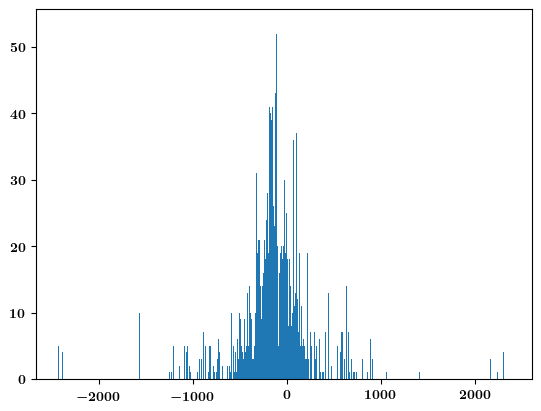

In [90]:
plt.hist(samples[:,1], bins = 1000)
plt.show()

In [101]:
args = list()

for i in tqdm(range(samples.shape[1])):
    vals, bins, foo = plt.hist(samples[:,i], bins = 1000)
#     args.append(bins[np.argmax(vals)])
    args.append(np.mean(samples[:,i]))
    
plt.close()
args = np.asarray(args)

100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.78it/s]


In [102]:
actual_mat = np.fft.fft2(g1) * fft_filter
my_mat = np.zeros_like(fft_filter, dtype = complex128)
my_mat[amps_idx] = args[:num_complex] + args[num_complex:]*1.0j

In [117]:
abs(check_vals), np.angle(check_vals)

(array([685.9589795 , 164.97106743, 116.1853955 , 335.38652352,
        728.76989506]),
 array([-0.35285256,  2.30421001, -1.01996115,  0.65647971,  2.7696226 ]))

In [118]:
abs(act_vals), np.angle(act_vals)

(array([206.36337805, 114.66775369, 114.66775369, 207.86497758,
        207.86497758]),
 array([ 3.14159265,  1.80640636, -1.80640636, -3.00543199,  3.00543199]))

In [115]:
check_vals = my_mat[my_mat != 0.]

In [116]:
act_vals = actual_mat[actual_mat != 0.]

In [113]:
chosen_mat = actual_mat # actual_mat
complex_mat = prior_cls * chosen_mat
    
d = mock_signal.flatten() ## - np.mean(MAP.flatten())
m = flatsky.make_direct_realization(mapparams, el, complex_mat, bl = bl2d)
diff = d - m.flatten()

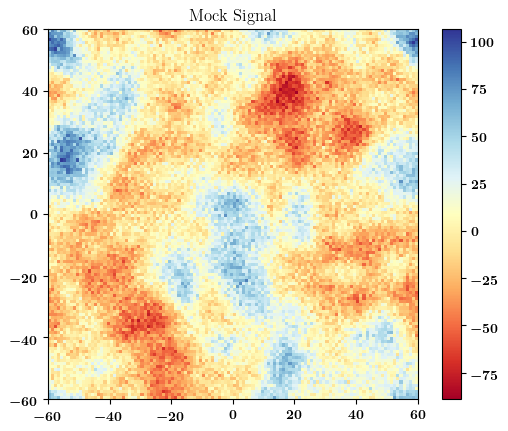

-64107.50676217843
0.0


In [114]:
cov_inv = noise_cov_inv
chosen_map = diff.reshape(nx, nx) #m
plt.imshow(chosen_map, extent = [x1,x2,x1,x2], cmap = cmap); colorbar(); title("Mock Signal"); show()
print(-0.5 * np.asarray( np.dot(diff.T, np.dot( cov_inv, diff ))).squeeze())
print(np.exp(-0.5 * np.asarray( np.dot(diff.T, np.dot( cov_inv, diff ))).squeeze()))

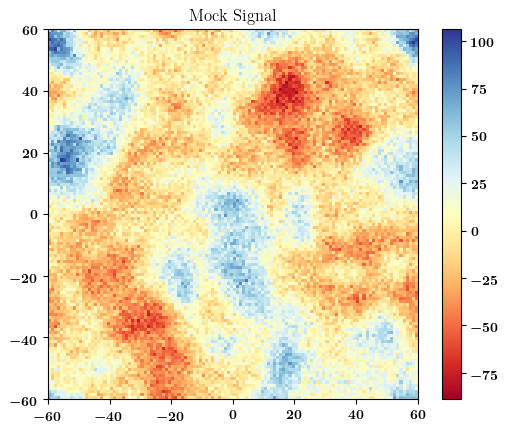

-64097.062311064255
0.0


In [112]:
cov_inv = noise_cov_inv
chosen_map = diff.reshape(nx, nx) #m
plt.imshow(chosen_map, extent = [x1,x2,x1,x2], cmap = cmap); colorbar(); title("Mock Signal"); show()
print(-0.5 * np.asarray( np.dot(diff.T, np.dot( cov_inv, diff ))).squeeze())
print(np.exp(-0.5 * np.asarray( np.dot(diff.T, np.dot( cov_inv, diff ))).squeeze()))

In [48]:
complex_mat = prior_cls * amps_mat
    
d = data.flatten() ## - np.mean(MAP.flatten())
m = flatsky.make_direct_realization(mapparams, el, complex_mat, bl = bl2d)
diff = d - m.flatten()

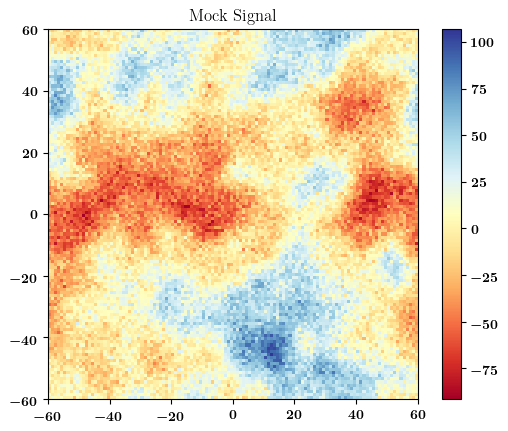

In [52]:
plt.imshow(diff.reshape(nx,nx), extent = [x1,x2,x1,x2], cmap = cmap); colorbar(); title("Mock Signal"); show()

In [78]:
my = [-0.64829971-9.75222j, -1.63663138-1.53141j, 0.10804642+1.21068j]
jy = np.fft.fft(my)
np.fft.ifft(jy)

array([-0.64829971-9.75222j, -1.63663138-1.53141j,  0.10804642+1.21068j])

In [76]:
np.fft.ifft2(np.fft.fft2( np.random.standard_normal([nx,nx])))

array([[-0.64829971-9.75222989e-17j, -1.63663138-1.53141388e-16j,
         0.10804642+1.21068279e-16j, ..., -0.07430926-1.28646638e-16j,
         1.42592676-2.73212323e-16j,  0.01551458+3.42480111e-16j],
       [-0.96548929-2.19770190e-16j, -0.77188454-3.14123727e-16j,
         0.88340348-7.96353724e-17j, ...,  0.36785517-2.84834430e-16j,
         0.36777734-1.00669201e-16j, -0.89771275-1.08699162e-16j],
       [-0.16190836+1.91135688e-16j,  1.41136094-2.90068895e-16j,
        -0.74534857-1.89794168e-16j, ..., -0.24595994+1.19816122e-17j,
         0.25049691-1.62190021e-16j, -1.66438943-1.33065417e-16j],
       ...,
       [ 0.33364202-1.16537041e-16j, -0.05895355-1.59052130e-16j,
        -1.77703485-9.37005556e-17j, ...,  0.3620023 +1.89037787e-16j,
        -1.0349121 -9.92955609e-17j,  0.12921018-3.10355715e-16j],
       [ 0.06038217+1.49076339e-16j,  0.23759226-2.49792118e-17j,
        -0.04242926-2.45935747e-16j, ..., -0.17430269+3.11848385e-16j,
         1.11166668+1.75210057e-16j

---------------

In [24]:
# Attempt an emcee with real amplitudes for the gaussian deviations
# Then, the actual deviations can be found by fft2'ing the real amplitudes used.
# (I tried ifft2, but they are not always consistent??)

import scipy

cov = noise_cov
cov_inv = noise_cov_inv
data = mock_signal
amps_mat = np.zeros_like(prior_cls, dtype = complex128)
amps_idx = (prior_cls != 0.)
num_params = len(amps_mat[amps_idx])

def log_likelihood(amps_mat):
    
    complex_mat = prior_cls * amps_mat
    
    d = data.flatten() ## - np.mean(MAP.flatten())
    m = flatsky.make_direct_realization(mapparams, el, complex_mat, bl = bl2d).flatten()
    diff = d - m
    
    return -0.5 * np.asarray( np.dot(diff.T, np.dot( cov_inv, diff ))).squeeze()

def log_prior(amps_mat):
    iamps_mat = np.fft.ifft2(amps_mat)
    r = abs(iamps_mat)
    return np.log(np.mean(scipy.stats.norm.pdf(r)))    # Is this logically sound??? # iamps.real

def log_probability(theta):
    amps, phases = theta[:num_params], theta[num_params:]
    if (np.any(phases) > 2*pi) or (np.any(phases) < 0):
        return -np.inf
    complex_amps = amps * np.exp(1.j * phases)
    amps_mat[amps_idx] = complex_amps
    
    # figure out how to properly incorp prior
    prior = log_prior(amps_mat)
    res = prior + log_likelihood(amps_mat)
    print(theta, np.exp(prior), np.exp(res))
    return res


# try with complex next -- otherwise we cant use k space...

# Scratch #

In [46]:

nx, ny, dx, dy = mapparams
arcmins2radians = np.radians(1/60.)

dx *= arcmins2radians
dy *= arcmins2radians

################################################
#map stuff
norm = np.sqrt(1./ (dx * dy))
    
cl2d_test = flatsky.cl_to_cl2d(el, cl_tt, mapparams)
cl2d_test = cl2d_test**0.5 * norm
cl2d_test[np.isnan(cl2d_test)] = 0.

test_amps = (np.copy(cl2d_test) * np.fft.fft2( np.random.standard_normal([nx,nx])))

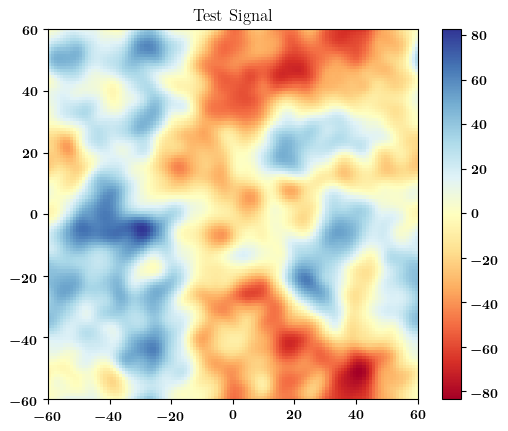

In [47]:
test = flatsky.make_direct_realization(mapparams, el, test_amps, bl = bl2d)
plt.imshow(test, extent = [x1,x2,x1,x2], cmap = cmap); colorbar(); title("Test Signal"); show()

In [15]:
(3 * np.exp(1.j * np.pi))**2

(9-2.204364238465236e-15j)

In [49]:
np.copy(cl2d_test) * np.fft.fft2( np.random.standard_normal([nx,nx]))

array([[ 2.27378261e+06    +0.j        ,  2.32037520e+05-30068.40040273j,
        -2.31392622e+04-27907.70640425j, ...,
         1.83202435e+04+17969.03781333j, -2.31392622e+04+27907.70640425j,
         2.32037520e+05+30068.40040273j],
       [-2.32317256e+05-74794.24341058j, -6.49357707e+04-27607.7040265j ,
         5.17659406e+04 -9689.70769619j, ...,
         1.48157129e+03-12188.55857763j,  3.27873096e+03+45429.20389681j,
        -1.13794944e+05-73802.92380307j],
       [ 4.58372427e+04-10987.81984888j,  5.20729218e+04 -7575.35923853j,
         3.49187495e+04-27257.12999691j, ...,
        -8.85364186e+02+32529.04112364j,  1.90436846e+04+22714.98208163j,
         1.85556921e+04 -3506.6939092j ],
       ...,
       [ 1.49561273e+04 -7681.31382073j,  1.11393568e+04+15820.52662358j,
         1.21330619e+04-26630.08963927j, ...,
        -2.37711809e+03-10736.05568068j, -1.55338009e+04 +1224.48667853j,
        -6.64445292e+03+20516.69843718j],
       [ 4.58372427e+04+10987.81984888j,  1.

In [74]:
# Attempt a simple Emcee with mass and velocity characteristics (2 params)

# To save shallow copy space, use global memory for now
cov = noise_cov
cov_inv = noise_cov_inv
data = mock_signal

sigma = 1
mu = 0

def log_likelihood(amps, phases):
    complex_amps = amps * np.exp(1.j * phases)
    d = data.flatten() ## - np.mean(MAP.flatten())
    m = flatsky.make_direct_realization(mapparams, el, complex_amps, bl = bl2d).flatten()
    diff = d - m
    
    return -0.5 * np.asarray( np.dot(diff.T, np.dot( cov_inv, diff ))).squeeze()

def log_prior(amps, phases):
    if (np.any(phases < 0)) or (np.any(phases > 2*np.pi)):
        return -np.inf
    return np.log(1.0/np.sqrt(2*np.pi)) * (-0.5 * (amps)**2)

# def log_prior(amps, phases):
#     if (np.any(phases < 0)) or (np.any(phases > 2*np.pi)):
#         return -np.inf
    
#     complex_amps = amps * np.exp(1.j * phases)
#     prior_vals = abs(np.fft.ifft2(complex_amps / prior_cls))
# #     return np.log(1.0/(np.sqrt(2*np.pi)*sigma))-0.5*(prior_vals-mu)**2/sigma**2
#     return np.log(1.0/np.sqrt(2*np.pi)) * (-0.5 * (prior_vals)**2)     # for a standard normal distribution

def log_probability(amps, phases):
    prior = log_prior(theta)
    if not np.isfinite(prior):
        return -np.inf
    return prior + log_likelihood(theta)


In [39]:
import pandas as pd

rands = np.random.standard_normal([nx,nx])
rands_fft2 = np.fft.fft2( np.random.standard_normal([nx,nx])) 
pd.Series(rands_fft2.flatten()).describe()

count    1440000000.0+0.000000j
mean    -0.34043100-0.00000000j
std      119.7731008+0.0000000j
min      -288.384374-51.265917j
25%     -57.0425950-33.1282040j
50%      0.05716700-0.00000000j
75%      55.7596690-13.9231420j
max      292.824056+112.127469j
dtype: complex128

In [40]:
rands = np.random.standard_normal([nx,nx])
rands_fft2 = np.fft.fft2( np.random.standard_normal([nx,nx])) 
t = prior_cls * rands_fft2
rands_fft2

array([[-178.41475878  +0.j        ,   49.73734591 -88.99010662j,
         114.94655293 -61.67908946j, ...,  -13.66971395 +31.217261j  ,
         114.94655293 +61.67908946j,   49.73734591 +88.99010662j],
       [   6.88952207 -43.89073757j,  -31.01374412+158.96395322j,
         -67.06588263 -82.92653781j, ...,   27.06445892 -82.09538587j,
         -11.25466634 +92.1092741j ,   76.33394827 -42.30993111j],
       [-187.51028946-121.10167274j,   -3.12712829+112.32013387j,
         -70.94831908 -29.54745072j, ...,   80.89100743 -68.53891361j,
         -34.89840102 +31.06361794j,  -87.48053615 -93.8100982j ],
       ...,
       [-157.97687573 -15.67578896j,   11.62835471+106.1274244j ,
          79.38689735 -60.53456767j, ...,   77.98477155  -3.4873943j ,
          83.47495658 -33.70167137j,  -67.6089602  +33.41459455j],
       [-187.51028946+121.10167274j,  -87.48053615 +93.8100982j ,
         -34.89840102 -31.06361794j, ...,  -86.31849569 -89.33872565j,
         -70.94831908 +29.54745072j

In [46]:
my_rands = np.fft.ifft2(t/prior_cls).real
my_rands

array([[-0.08695027, -0.60814006, -0.24479408, ..., -0.85393719,
         1.04284916, -0.44684201],
       [ 0.52914166, -1.33201464, -0.06287991, ..., -0.76156135,
        -1.45692593,  0.55754243],
       [-0.93856343, -2.38262167,  0.41118073, ...,  0.39984158,
        -1.41230759,  0.00406307],
       ...,
       [ 0.93742048,  2.07437341, -0.90479727, ..., -0.26932127,
         0.63758154,  0.11642294],
       [-1.94680659, -0.07921611,  0.28446799, ...,  0.06435067,
         2.37253505, -0.39119988],
       [ 0.14120557,  0.43284945,  0.5143608 , ...,  0.71518304,
        -1.06219343,  0.70533574]])

/home/dchanda2002/anaconda3/lib/python3.10/site-packages/numpy/lib/histograms.py:852: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
/home/dchanda2002/anaconda3/lib/python3.10/site-packages/matplotlib/axes/_axes.py:6793: ComplexWarning: Casting complex values to real discards the imaginary part
  bins = np.array(bins, float)  # causes problems if float16


(array([  76.,  349., 1412., 3075., 4064., 3228., 1552.,  522.,  112.,
          10.]),
 array([-276.30215758, -215.97319932, -155.64424106,  -95.3152828 ,
         -34.98632454,   25.34263372,   85.67159198,  146.00055025,
         206.32950851,  266.65846677,  326.98742503]),
 <BarContainer object of 10 artists>)

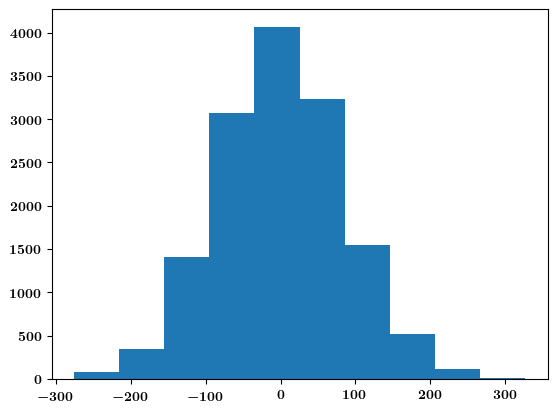

In [51]:
plt.hist(rands_fft2.flatten())

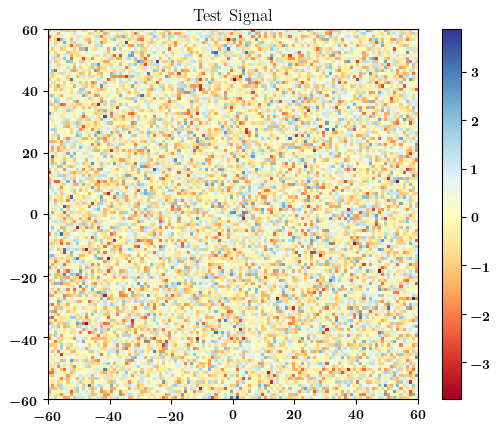

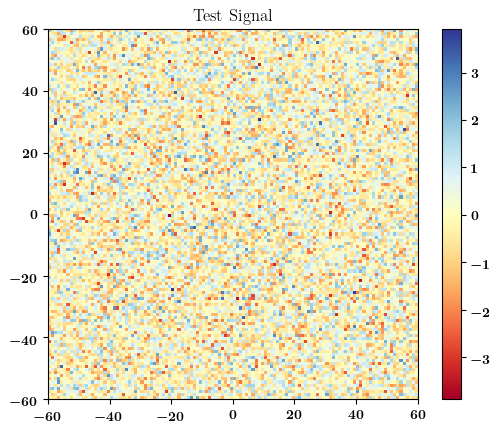

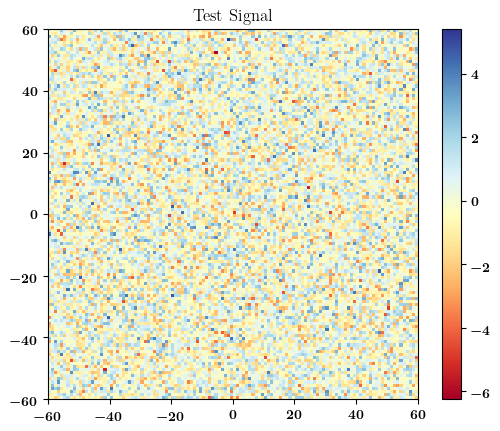

In [34]:
plt.imshow(my_rands, extent = [x1,x2,x1,x2], cmap = cmap); colorbar(); title("Test Signal"); show()
plt.imshow(rands, extent = [x1,x2,x1,x2], cmap = cmap); colorbar(); title("Test Signal"); show()

In [77]:
np.min(test_results)

1.000000478450108

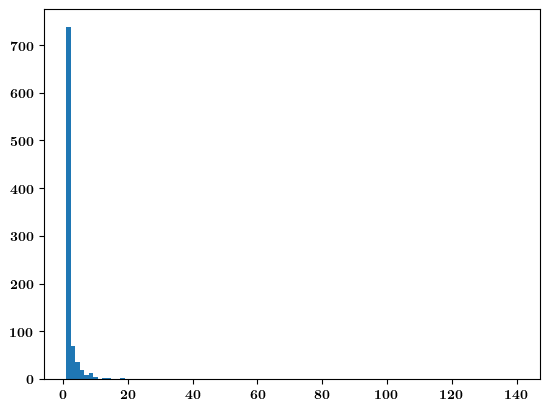

In [80]:
plt.hist(test_results.flatten(), bins = 100)
plt.show()

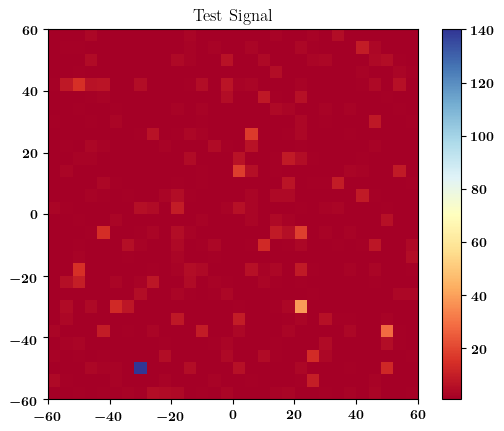

In [78]:
plt.imshow(test_results.real, extent = [x1,x2,x1,x2], cmap = cmap); colorbar(); title("Test Signal"); show()